In [15]:
import numpy as np
import pandas as pd

def g(x1, x2):    
    return(3*(1-x1)**2 * np.exp(-(x1**2) - (x2+1)**2)
           - 10*(x1/5 - x1**3 - x2**5) * np.exp(-x1**2 - x2**2)
           - 1/3 * np.exp(-(x1+1)**2 - x2**2))
    
def GetGrid(grid):
    x1 = np.linspace(-2, 2, grid)
    x2 = np.linspace(-2, 2, grid)
    x1, x2 = np.meshgrid(x1, x2)
    y = g(x1, x2)
    return x1, x2, y

def create_dataframe(grid):
   x1, x2, y = GetGrid(grid)
   data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': y.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../../results_g/virtual_samples_RBF.xlsx")

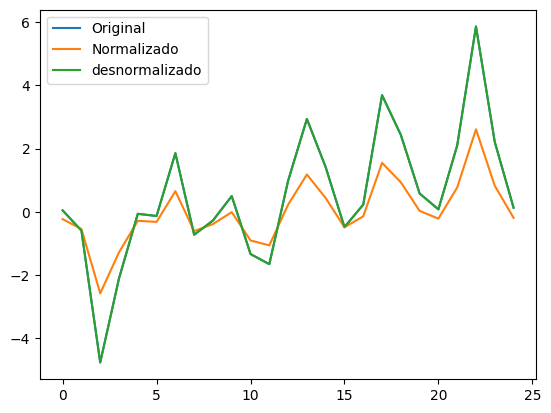

In [16]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [17]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [18]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import tf_levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.lm_model = lm.model.ModelWrapper(self.model)
        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.loss.MeanSquaredError()
        )

        return(self.lm_model)

In [19]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)

    def plot_loss_history(self):
      history = self.results.history
      
      plt.figure(figsize=(8, 5))
      plt.plot(history['loss'], label='Loss de Treinamento')
      plt.plot(history['val_loss'], label='Loss de Validação')
      plt.xlabel('Época')
      plt.ylabel('Loss')
      plt.title('Histórico de Loss')
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights("./content/models/initial-weights/initial-.weights.h5")
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
      
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [20]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"./content/models/{fileName}.weights.h5"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./content/models/initial-weights/initial-.weights.h5",
                f"./content/models/initial-weights/{fileName}.weights.h5")

  def SaveDataset(self, trainer, fileName):
    path = f"./content/dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] >= boundarie): # should be >= to acsending metrics
        #trainer.plot_loss_history()
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'./content/results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando Com amostras virtuais



In [21]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=15)
tester.Loop(sort_by='r2_sup',
            boundarie = 0.5,
            hidden_sizes = [[4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.2, 0.02],
            learning_rate=[0.1, 0.01])

Testando combinacao1: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.1
+++++++++++ [1_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_0_7  0.920558  0.767922  0.644220  0.821399  0.330737  1.551906   
model_1_0_6  0.911915  0.760853  0.637309  0.813150  0.366721  1.599177   
model_1_0_5  0.901150  0.752095  0.629483  0.802490  0.411538  1.657744   
model_1_0_4  0.887669  0.740923  0.620958  0.789612  0.467662  1.732446   
model_1_0_3  0.870642  0.726649  0.611176  0.774068  0.538547  1.827899   
model_1_0_2  0.849643  0.708884  0.599324  0.757175  0.625971  1.946695   
model_1_0_1  0.664727  0.544952  0.578925  0.579220  1.395822  3.042909   
model_1_0_0  0.666684  0.511173  0.507804  0.645592  1.387676  3.268786   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_0_7  1.272603  0.573134  0.686426  0.575098  0.869633  0.584155   
model_1_0_6  1.297326  0.599606  0.698397  0.605575  0.855450  0.615112   
model_1_0_5  1.325320  0.633813  0.712669  0.641512  0.837784  0.651615   
model_1_0_4  1.355811  0.675138  0.729961  0.683858  0.815662  0.694628   
model_1_0_3  1.390801  0.725018  0.751294  0.733857  0.787721  0.745415   
model_1_0_2  1.433193  0.779230  0.780985  0.791183  0.753261  0.803644   
model_1_0_1  1.506160  1.350291  1.244195  1.181449  0.449809  1.200056   
model_1_0_0  1.760557  1.137302  1.533085  1.177997  0.453020  1.196549   

                   aic         bic  
model_1_0_7  52.212861  106.572543  
model_1_0_6  52.006310  106.365991  
model_1_0_5  51.775708  106.135390  
model_1_0_4  51.520020  105.879702  
model_1_0_3  51.237763  105.597444  
model_1_0_2  50.936902  105.296584  
model_1_0_1  49.333033  103.692715  
model_1_0_0  49.344740  103.704421

DataFrame salvo em ./content/results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_1_9  0.965185  0.802896  0.681867  0.958850  0.144945  1.318034   
model_1_1_8  0.963412  0.801637  0.679450  0.957722  0.152323  1.326455   
model_1_1_7  0.961288  0.800104  0.676842  0.956447  0.161168  1.336706   
model_1_1_6  0.958780  0.798251  0.674073  0.955033  0.171611  1.349094   
model_1_1_5  0.955801  0.795992  0.671111  0.953426  0.184011  1.364203   
model_1_1_4  0.952264  0.793300  0.667794  0.951591  0.198738  1.382201   
model_1_1_3  0.948075  0.790011  0.664263  0.949472  0.216177  1.404196   
model_1_1_2  0.943087  0.786020  0.660405  0.946990  0.236941  1.430885   
model_1_1_1  0.937082  0.781110  0.656172  0.944007  0.261944  1.463718   
model_1_1_0  0.929699  0.775060  0.651165  0.940318  0.292681  1.504178   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_1_9  1.137945  0.250960  0.562153  0.380716  0.942867  0.386712   
model_1_1_8  1.146590  0.257837  0.567022  0.390286  0.939959  0.396432   
model_1_1_7  1.155916  0.265612  0.574380  0.401457  0.936472  0.407780   
model_1_1_6  1.165823  0.274237  0.583587  0.414259  0.932356  0.420783   
model_1_1_5  1.176416  0.284038  0.593539  0.428965  0.927468  0.435721   
model_1_1_4  1.188281  0.295229  0.604188  0.445801  0.921663  0.452822   
model_1_1_3  1.200913  0.308150  0.615563  0.464948  0.914789  0.472271   
model_1_1_2  1.214710  0.323287  0.629250  0.486766  0.906605  0.494432   
model_1_1_1  1.229852  0.341481  0.644704  0.511804  0.896750  0.519865   
model_1_1_0  1.247762  0.363977  0.663704  0.541000  0.884634  0.549520   

                   aic         bic  
model_1_1_9  53.862806  108.222488  
model_1_1_8  53.763507  108.123188  
model_1_1_7  53.650615  108.010297  
model_1_1_6  53.525053  107.884735  
model_1_1_5  53.385520  107.745202  
model_1_1_4  53.231532  107.591213  
model_1_1_3  53.063315  107.422997  
model_1_1_2  52.879886  107.239568  
model_1_1_1  52.679250  107.038932  
model_1_1_0  52.457347  106.817028

DataFrame salvo em ./content/results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_2_0  0.975482  0.81427  0.778363  0.871143  0.102075  1.241976   
model_1_2_1  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_2  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_3  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_4  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_5  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_6  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_7  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_8  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   
model_1_2_9  0.975482  0.81427  0.778363  0.871142  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_2_0  0.792784  0.253327  0.816252  0.319492  0.959765  0.324524   
model_1_2_1  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_2  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_3  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_4  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_5  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_6  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_7  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_8  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   
model_1_2_9  0.792783  0.253329  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_2_0  54.564091  108.923772  
model_1_2_1  54.564083  108.923765  
model_1_2_2  54.564083  108.923765  
model_1_2_3  54.564083  108.923765  
model_1_2_4  54.564083  108.923765  
model_1_2_5  54.564083  108.923765  
model_1_2_6  54.564083  108.923765  
model_1_2_7  54.564083  108.923765  
model_1_2_8  54.564083  108.923765  
model_1_2_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_3_0  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_1  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_2  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_3  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_4  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_5  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_6  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_7  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_8  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   
model_1_3_9  0.975482  0.81427  0.778363  0.977496  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_3_0  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_1  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_2  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_3  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_4  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_5  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_6  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_7  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_8  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   
model_1_3_9  0.792783  0.137092  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_3_0  54.564083  108.923765  
model_1_3_1  54.564083  108.923765  
model_1_3_2  54.564083  108.923765  
model_1_3_3  54.564083  108.923765  
model_1_3_4  54.564083  108.923765  
model_1_3_5  54.564083  108.923765  
model_1_3_6  54.564083  108.923765  
model_1_3_7  54.564083  108.923765  
model_1_3_8  54.564083  108.923765  
model_1_3_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_4_0  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_1  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_2  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_3  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_4  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_5  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_6  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_7  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_8  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   
model_1_4_9  0.975482  0.81427  0.778363  0.994539  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_4_0  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_1  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_2  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_3  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_4  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_5  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_6  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_7  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_8  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   
model_1_4_9  0.792783  0.039302  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_4_0  54.564083  108.923765  
model_1_4_1  54.564083  108.923765  
model_1_4_2  54.564083  108.923765  
model_1_4_3  54.564083  108.923765  
model_1_4_4  54.564083  108.923765  
model_1_4_5  54.564083  108.923765  
model_1_4_6  54.564083  108.923765  
model_1_4_7  54.564083  108.923765  
model_1_4_8  54.564083  108.923765  
model_1_4_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_5_0  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_1  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_2  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_3  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_4  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_5  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_6  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_7  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_8  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   
model_1_5_9  0.975482  0.81427  0.778363  0.950187  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_5_0  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_1  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_2  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_3  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_4  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_5  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_6  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_7  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_8  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   
model_1_5_9  0.792783  0.190502  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_5_0  54.564083  108.923765  
model_1_5_1  54.564083  108.923765  
model_1_5_2  54.564083  108.923765  
model_1_5_3  54.564083  108.923765  
model_1_5_4  54.564083  108.923765  
model_1_5_5  54.564083  108.923765  
model_1_5_6  54.564083  108.923765  
model_1_5_7  54.564083  108.923765  
model_1_5_8  54.564083  108.923765  
model_1_5_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_6_0  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_1  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_2  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_3  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_4  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_5  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_6  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_7  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_8  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   
model_1_6_9  0.975482  0.81427  0.778363  0.911177  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_6_0  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_1  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_2  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_3  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_4  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_5  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_6  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_7  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_8  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   
model_1_6_9  0.792783  0.343604  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_6_0  54.564083  108.923765  
model_1_6_1  54.564083  108.923765  
model_1_6_2  54.564083  108.923765  
model_1_6_3  54.564083  108.923765  
model_1_6_4  54.564083  108.923765  
model_1_6_5  54.564083  108.923765  
model_1_6_6  54.564083  108.923765  
model_1_6_7  54.564083  108.923765  
model_1_6_8  54.564083  108.923765  
model_1_6_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_7_0  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_1  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_2  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_3  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_4  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_5  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_6  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_7  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_8  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   
model_1_7_9  0.975482  0.81427  0.778363  0.994259  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_7_0  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_1  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_2  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_3  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_4  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_5  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_6  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_7  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_8  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   
model_1_7_9  0.792783  0.026158  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_7_0  54.564083  108.923765  
model_1_7_1  54.564083  108.923765  
model_1_7_2  54.564083  108.923765  
model_1_7_3  54.564083  108.923765  
model_1_7_4  54.564083  108.923765  
model_1_7_5  54.564083  108.923765  
model_1_7_6  54.564083  108.923765  
model_1_7_7  54.564083  108.923765  
model_1_7_8  54.564083  108.923765  
model_1_7_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_8_0  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_1  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_2  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_3  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_4  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_5  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_6  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_7  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_8  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   
model_1_8_9  0.975482  0.81427  0.778363  0.957537  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_8_0  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_1  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_2  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_3  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_4  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_5  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_6  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_7  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_8  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   
model_1_8_9  0.792783  0.204881  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_8_0  54.564083  108.923765  
model_1_8_1  54.564083  108.923765  
model_1_8_2  54.564083  108.923765  
model_1_8_3  54.564083  108.923765  
model_1_8_4  54.564083  108.923765  
model_1_8_5  54.564083  108.923765  
model_1_8_6  54.564083  108.923765  
model_1_8_7  54.564083  108.923765  
model_1_8_8  54.564083  108.923765  
model_1_8_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_9_0  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_1  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_2  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_3  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_4  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_5  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_6  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_7  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_8  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   
model_1_9_9  0.975482  0.81427  0.778363  0.985643  0.102076  1.241979   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_9_0  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_1  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_2  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_3  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_4  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_5  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_6  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_7  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_8  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   
model_1_9_9  0.792783  0.045059  0.816258  0.319493  0.959765  0.324524   

                   aic         bic  
model_1_9_0  54.564083  108.923765  
model_1_9_1  54.564083  108.923765  
model_1_9_2  54.564083  108.923765  
model_1_9_3  54.564083  108.923765  
model_1_9_4  54.564083  108.923765  
model_1_9_5  54.564083  108.923765  
model_1_9_6  54.564083  108.923765  
model_1_9_7  54.564083  108.923765  
model_1_9_8  54.564083  108.923765  
model_1_9_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_10_0  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_1  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_2  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_3  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_4  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_5  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_6  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_7  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_8  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   
model_1_10_9  0.975482  0.81427  0.778363  0.969547  0.102076  1.241979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_10_0  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_1  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_2  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_3  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_4  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_5  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_6  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_7  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_8  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   
model_1_10_9  0.792783  0.124915  0.816258  0.319493  0.959765  0.324524   

                    aic         bic  
model_1_10_0  54.564083  108.923765  
model_1_10_1  54.564083  108.923765  
model_1_10_2  54.564083  108.923765  
model_1_10_3  54.564083  108.923765  
model_1_10_4  54.564083  108.923765  
model_1_10_5  54.564083  108.923765  
model_1_10_6  54.564083  108.923765  
model_1_10_7  54.564083  108.923765  
model_1_10_8  54.564083  108.923765  
model_1_10_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_11_0  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_1  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_2  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_3  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_4  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_5  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_6  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_7  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_8  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   
model_1_11_9  0.975482  0.81427  0.778363  0.905459  0.102076  1.241979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_11_0  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_1  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_2  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_3  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_4  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_5  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_6  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_7  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_8  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   
model_1_11_9  0.792783  0.239474  0.816258  0.319493  0.959765  0.324524   

                    aic         bic  
model_1_11_0  54.564083  108.923765  
model_1_11_1  54.564083  108.923765  
model_1_11_2  54.564083  108.923765  
model_1_11_3  54.564083  108.923765  
model_1_11_4  54.564083  108.923765  
model_1_11_5  54.564083  108.923765  
model_1_11_6  54.564083  108.923765  
model_1_11_7  54.564083  108.923765  
model_1_11_8  54.564083  108.923765  
model_1_11_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_12_0  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_1  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_2  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_3  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_4  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_5  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_6  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_7  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_8  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   
model_1_12_9  0.975482  0.81427  0.778363  0.995818  0.102076  1.241979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_12_0  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_1  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_2  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_3  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_4  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_5  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_6  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_7  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_8  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   
model_1_12_9  0.792783  0.020172  0.816258  0.319493  0.959765  0.324524   

                    aic         bic  
model_1_12_0  54.564083  108.923765  
model_1_12_1  54.564083  108.923765  
model_1_12_2  54.564083  108.923765  
model_1_12_3  54.564083  108.923765  
model_1_12_4  54.564083  108.923765  
model_1_12_5  54.564083  108.923765  
model_1_12_6  54.564083  108.923765  
model_1_12_7  54.564083  108.923765  
model_1_12_8  54.564083  108.923765  
model_1_12_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_13_0  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_1  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_2  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_3  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_4  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_5  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_6  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_7  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_8  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   
model_1_13_9  0.975482  0.81427  0.778363  0.981208  0.102076  1.241979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_13_0  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_1  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_2  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_3  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_4  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_5  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_6  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_7  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_8  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   
model_1_13_9  0.792783  0.090727  0.816258  0.319493  0.959765  0.324524   

                    aic         bic  
model_1_13_0  54.564083  108.923765  
model_1_13_1  54.564083  108.923765  
model_1_13_2  54.564083  108.923765  
model_1_13_3  54.564083  108.923765  
model_1_13_4  54.564083  108.923765  
model_1_13_5  54.564083  108.923765  
model_1_13_6  54.564083  108.923765  
model_1_13_7  54.564083  108.923765  
model_1_13_8  54.564083  108.923765  
model_1_13_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_14_0  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_1  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_2  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_3  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_4  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_5  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_6  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_7  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_8  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   
model_1_14_9  0.975482  0.81427  0.778363  0.993486  0.102076  1.241979   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_14_0  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_1  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_2  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_3  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_4  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_5  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_6  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_7  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_8  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   
model_1_14_9  0.792783  0.024792  0.816258  0.319493  0.959765  0.324524   

                    aic         bic  
model_1_14_0  54.564083  108.923765  
model_1_14_1  54.564083  108.923765  
model_1_14_2  54.564083  108.923765  
model_1_14_3  54.564083  108.923765  
model_1_14_4  54.564083  108.923765  
model_1_14_5  54.564083  108.923765  
model_1_14_6  54.564083  108.923765  
model_1_14_7  54.564083  108.923765  
model_1_14_8  54.564083  108.923765  
model_1_14_9  54.564083  108.923765

DataFrame salvo em ./content/results/metrics_1_14
Testando combinacao2: Hidden Size=[4, 2], regularizer=0.2, learning_rate=0.01


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_1_5  0.978354  0.797546  0.728390  0.888519  0.090116  1.353809   
model_2_1_6  0.978382  0.797496  0.728400  0.888756  0.090000  1.354146   
model_2_1_4  0.831397  0.638874  0.631826  0.724052  0.701937  2.414849   
model_2_1_3  0.828816  0.636572  0.630434  0.720735  0.712678  2.430244   
model_2_1_2  0.819474  0.628507  0.622985  0.706339  0.751575  2.484177   
model_2_1_1  0.813043  0.623017  0.618086  0.696457  0.778347  2.520889   
model_2_1_0  0.704131  0.531832  0.534521  0.535008  1.231774  3.130641   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_1_5  0.971534  0.196803  0.398952  0.300193  0.964479  0.304920   
model_2_1_6  0.971499  0.196385  0.398461  0.299999  0.964525  0.304724   
model_2_1_4  1.316938  0.487145  1.159784  0.837817  0.723317  0.851012   
model_2_1_3  1.321915  0.493002  1.164931  0.844203  0.719083  0.857498   
model_2_1_2  1.348560  0.518415  1.195116  0.866934  0.703752  0.880587   
model_2_1_1  1.366083  0.535860  1.214275  0.882240  0.693199  0.896134   
model_2_1_0  1.664992  0.820874  1.479854  1.109853  0.514472  1.127332   

                   aic         bic  
model_2_1_5  54.813322  109.173004  
model_2_1_6  54.815898  109.175580  
model_2_1_4  50.707823  105.067505  
model_2_1_3  50.677450  105.037132  
model_2_1_2  50.571169  104.930851  
model_2_1_1  50.501166  104.860848  
model_2_1_0  49.583090  103.942772

DataFrame salvo em ./content/results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_2_9  0.979512  0.798239  0.728804  0.949110  0.085295  1.349179   
model_2_2_8  0.979409  0.798174  0.728781  0.949054  0.085724  1.349612   
model_2_2_7  0.979304  0.798107  0.728754  0.948996  0.086162  1.350059   
model_2_2_6  0.979197  0.798038  0.728724  0.948935  0.086609  1.350518   
model_2_2_5  0.979087  0.797967  0.728690  0.948872  0.087064  1.350993   
model_2_2_4  0.978976  0.797894  0.728652  0.948805  0.087529  1.351482   
model_2_2_3  0.978862  0.797819  0.728610  0.948736  0.088003  1.351986   
model_2_2_2  0.978746  0.797742  0.728564  0.948664  0.088487  1.352503   
model_2_2_1  0.978627  0.797662  0.728514  0.948588  0.088981  1.353035   
model_2_2_0  0.978506  0.797580  0.728459  0.948508  0.089485  1.353582   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_2_9  0.970051  0.143423  0.391416  0.292053  0.966379  0.296653   
model_2_2_8  0.970136  0.143581  0.392109  0.292787  0.966210  0.297398   
model_2_2_7  0.970231  0.143745  0.392800  0.293534  0.966037  0.298157   
model_2_2_6  0.970340  0.143917  0.393498  0.294293  0.965861  0.298928   
model_2_2_5  0.970461  0.144095  0.394194  0.295066  0.965682  0.299713   
model_2_2_4  0.970596  0.144283  0.394893  0.295853  0.965499  0.300512   
model_2_2_3  0.970745  0.144478  0.395593  0.296653  0.965312  0.301325   
model_2_2_2  0.970909  0.144682  0.396295  0.297468  0.965121  0.302152   
model_2_2_1  0.971090  0.144896  0.397003  0.298297  0.964926  0.302994   
model_2_2_0  0.971287  0.145120  0.397721  0.299140  0.964728  0.303851   

                   aic         bic  
model_2_2_9  54.923275  109.282957  
model_2_2_8  54.913237  109.272918  
model_2_2_7  54.903051  109.262733  
model_2_2_6  54.892711  109.252393  
model_2_2_5  54.882222  109.241904  
model_2_2_4  54.871573  109.231255  
model_2_2_3  54.860766  109.220447  
model_2_2_2  54.849801  109.209483  
model_2_2_1  54.838668  109.198350  
model_2_2_0  54.827370  109.187052

DataFrame salvo em ./content/results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_3_0  0.979645  0.798226  0.728897  0.939781  0.084741  1.349261   
model_2_3_1  0.979776  0.798213  0.728988  0.939791  0.084198  1.349352   
model_2_3_2  0.979904  0.798198  0.729078  0.939798  0.083664  1.349452   
model_2_3_3  0.980030  0.798181  0.729169  0.939802  0.083140  1.349561   
model_2_3_4  0.980154  0.798164  0.729259  0.939805  0.082625  1.349679   
model_2_3_5  0.980275  0.798145  0.729348  0.939804  0.082120  1.349804   
model_2_3_6  0.980394  0.798125  0.729438  0.939802  0.081624  1.349938   
model_2_3_7  0.980511  0.798104  0.729527  0.939797  0.081137  1.350078   
model_2_3_8  0.980626  0.798082  0.729615  0.939789  0.080659  1.350226   
model_2_3_9  0.980739  0.798059  0.729704  0.939780  0.080190  1.350381   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_3_0  0.969721  0.115612  0.392045  0.291104  0.966597  0.295688   
model_2_3_1  0.969395  0.115593  0.392661  0.290168  0.966812  0.294738   
model_2_3_2  0.969071  0.115579  0.393266  0.289247  0.967022  0.293802   
model_2_3_3  0.968747  0.115570  0.393861  0.288340  0.967229  0.292881   
model_2_3_4  0.968426  0.115566  0.394443  0.287446  0.967432  0.291973   
model_2_3_5  0.968106  0.115567  0.395013  0.286566  0.967631  0.291079   
model_2_3_6  0.967784  0.115571  0.395575  0.285699  0.967826  0.290199   
model_2_3_7  0.967468  0.115581  0.396123  0.284846  0.968018  0.289332   
model_2_3_8  0.967151  0.115595  0.396662  0.284006  0.968206  0.288479   
model_2_3_9  0.966834  0.115613  0.397189  0.283179  0.968391  0.287639   

                   aic         bic  
model_2_3_0  54.936303  109.295985  
model_2_3_1  54.949176  109.308858  
model_2_3_2  54.961897  109.321579  
model_2_3_3  54.974462  109.334144  
model_2_3_4  54.986883  109.346564  
model_2_3_5  54.999144  109.358825  
model_2_3_6  55.011263  109.370945  
model_2_3_7  55.023226  109.382907  
model_2_3_8  55.035040  109.394722  
model_2_3_9  55.046707  109.406388

DataFrame salvo em ./content/results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_4_9  0.982109  0.798317  0.732507  0.942368  0.074483  1.348654   
model_2_4_8  0.982014  0.798304  0.732310  0.942435  0.074879  1.348741   
model_2_4_7  0.981917  0.798290  0.732111  0.942503  0.075282  1.348835   
model_2_4_6  0.981819  0.798275  0.731909  0.942572  0.075692  1.348937   
model_2_4_5  0.981719  0.798259  0.731703  0.942642  0.076108  1.349045   
model_2_4_4  0.981617  0.798241  0.731495  0.942713  0.076531  1.349163   
model_2_4_3  0.981514  0.798222  0.731283  0.942785  0.076962  1.349288   
model_2_4_2  0.981409  0.798203  0.731068  0.942859  0.077400  1.349420   
model_2_4_1  0.981302  0.798182  0.730850  0.942933  0.077845  1.349560   
model_2_4_0  0.981193  0.798160  0.730628  0.943008  0.078299  1.349708   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_4_9  0.956808  0.080675  0.396723  0.272916  0.970641  0.277214   
model_2_4_8  0.957511  0.080582  0.396837  0.273641  0.970485  0.277951   
model_2_4_7  0.958223  0.080488  0.396939  0.274376  0.970326  0.278697   
model_2_4_6  0.958947  0.080391  0.397029  0.275121  0.970165  0.279454   
model_2_4_5  0.959682  0.080293  0.397104  0.275877  0.970001  0.280221   
model_2_4_4  0.960427  0.080193  0.397169  0.276643  0.969834  0.281000   
model_2_4_3  0.961186  0.080092  0.397219  0.277421  0.969664  0.281790   
model_2_4_2  0.961953  0.079989  0.397255  0.278209  0.969491  0.282590   
model_2_4_1  0.962734  0.079885  0.397281  0.279008  0.969316  0.283402   
model_2_4_0  0.963527  0.079780  0.397290  0.279819  0.969137  0.284226   

                   aic         bic  
model_2_4_9  55.194365  109.554047  
model_2_4_8  55.183753  109.543434  
model_2_4_7  55.173025  109.532707  
model_2_4_6  55.162178  109.521859  
model_2_4_5  55.151206  109.510888  
model_2_4_4  55.140108  109.499790  
model_2_4_3  55.128882  109.488563  
model_2_4_2  55.117535  109.477217  
model_2_4_1  55.106061  109.465742  
model_2_4_0  55.094451  109.454132

DataFrame salvo em ./content/results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_5_0  0.982215  0.798197  0.732700  0.978874  0.074043  1.349460   
model_2_5_1  0.982319  0.798077  0.732891  0.978897  0.073610  1.350262   
model_2_5_2  0.982422  0.797958  0.733081  0.978919  0.073182  1.351058   
model_2_5_3  0.982523  0.797839  0.733270  0.978940  0.072760  1.351851   
model_2_5_4  0.982623  0.797721  0.733457  0.978960  0.072344  1.352638   
model_2_5_5  0.982722  0.797604  0.733643  0.978979  0.071934  1.353421   
model_2_5_6  0.982819  0.797488  0.733829  0.978998  0.071529  1.354199   
model_2_5_7  0.982915  0.797372  0.734013  0.979016  0.071130  1.354972   
model_2_5_8  0.983010  0.797258  0.734196  0.979033  0.070735  1.355739   
model_2_5_9  0.983103  0.797144  0.734378  0.979050  0.070347  1.356502   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_5_0  0.956118  0.069083  0.395791  0.272109  0.970814  0.276395   
model_2_5_1  0.955433  0.069009  0.394850  0.271311  0.970985  0.275584   
model_2_5_2  0.954753  0.068937  0.393911  0.270522  0.971154  0.274783   
model_2_5_3  0.954079  0.068868  0.393031  0.269741  0.971320  0.273989   
model_2_5_4  0.953409  0.068802  0.392141  0.268969  0.971484  0.273205   
model_2_5_5  0.952742  0.068739  0.391242  0.268205  0.971646  0.272429   
model_2_5_6  0.952078  0.068677  0.390335  0.267449  0.971805  0.271661   
model_2_5_7  0.951419  0.068618  0.389417  0.266701  0.971963  0.270902   
model_2_5_8  0.950764  0.068562  0.388507  0.265961  0.972118  0.270150   
model_2_5_9  0.950113  0.068508  0.387595  0.265230  0.972271  0.269407   

                   aic         bic  
model_2_5_0  55.206205  109.565887  
model_2_5_1  55.217952  109.577634  
model_2_5_2  55.229602  109.589284  
model_2_5_3  55.241168  109.600849  
model_2_5_4  55.252635  109.612317  
model_2_5_5  55.264013  109.623695  
model_2_5_6  55.275302  109.634984  
model_2_5_7  55.286501  109.646183  
model_2_5_8  55.297616  109.657298  
model_2_5_9  55.308638  109.668320

DataFrame salvo em ./content/results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_6_0  0.983189  0.797113  0.734365  0.935957  0.069987  1.356706   
model_2_6_1  0.983274  0.797082  0.734351  0.935414  0.069636  1.356916   
model_2_6_2  0.983356  0.797050  0.734334  0.934869  0.069294  1.357130   
model_2_6_3  0.983436  0.797017  0.734315  0.934325  0.068960  1.357350   
model_2_6_4  0.983514  0.796983  0.734294  0.933780  0.068633  1.357573   
model_2_6_5  0.983591  0.796949  0.734272  0.933236  0.068315  1.357802   
model_2_6_6  0.983665  0.796914  0.734248  0.932693  0.068005  1.358035   
model_2_6_7  0.983738  0.796879  0.734222  0.932150  0.067702  1.358270   
model_2_6_8  0.983809  0.796843  0.734195  0.931609  0.067407  1.358511   
model_2_6_9  0.983878  0.796806  0.734166  0.931070  0.067118  1.358756   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_6_0  0.950159  0.061531  0.388199  0.264550  0.972413  0.268717   
model_2_6_1  0.950212  0.062053  0.388788  0.263886  0.972552  0.268042   
model_2_6_2  0.950273  0.062576  0.389377  0.263237  0.972687  0.267383   
model_2_6_3  0.950340  0.063100  0.389939  0.262601  0.972818  0.266737   
model_2_6_4  0.950416  0.063623  0.390484  0.261980  0.972947  0.266106   
model_2_6_5  0.950494  0.064145  0.391000  0.261372  0.973072  0.265489   
model_2_6_6  0.950580  0.064667  0.391494  0.260778  0.973194  0.264885   
model_2_6_7  0.950674  0.065189  0.391970  0.260197  0.973314  0.264294   
model_2_6_8  0.950770  0.065709  0.392421  0.259628  0.973430  0.263717   
model_2_6_9  0.950872  0.066227  0.392847  0.259072  0.973544  0.263152   

                   aic         bic  
model_2_6_0  55.318893  109.678575  
model_2_6_1  55.328947  109.688629  
model_2_6_2  55.338805  109.698487  
model_2_6_3  55.348472  109.708153  
model_2_6_4  55.357951  109.717632  
model_2_6_5  55.367239  109.726920  
model_2_6_6  55.376347  109.736028  
model_2_6_7  55.385270  109.744952  
model_2_6_8  55.394014  109.753696  
model_2_6_9  55.402595  109.762276

DataFrame salvo em ./content/results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_7_9  0.984593  0.797241  0.736436  0.987242  0.064143  1.355847   
model_2_7_8  0.984528  0.797206  0.736225  0.987278  0.064416  1.356088   
model_2_7_7  0.984461  0.797168  0.736010  0.987314  0.064693  1.356339   
model_2_7_6  0.984393  0.797129  0.735793  0.987350  0.064976  1.356602   
model_2_7_5  0.984324  0.797088  0.735571  0.987387  0.065264  1.356875   
model_2_7_4  0.984253  0.797045  0.735347  0.987424  0.065558  1.357160   
model_2_7_3  0.984181  0.797001  0.735118  0.987461  0.065858  1.357455   
model_2_7_2  0.984108  0.796955  0.734886  0.987498  0.066164  1.357762   
model_2_7_1  0.984033  0.796907  0.734650  0.987535  0.066476  1.358082   
model_2_7_0  0.983956  0.796858  0.734410  0.987573  0.066794  1.358414   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_7_9  0.942752  0.057046  0.382374  0.253266  0.974717  0.257254   
model_2_7_8  0.943509  0.056887  0.383395  0.253802  0.974609  0.257800   
model_2_7_7  0.944276  0.056725  0.384417  0.254348  0.974500  0.258353   
model_2_7_6  0.945054  0.056562  0.385440  0.254903  0.974389  0.258918   
model_2_7_5  0.945846  0.056399  0.386483  0.255468  0.974275  0.259491   
model_2_7_4  0.946649  0.056234  0.387538  0.256043  0.974159  0.260075   
model_2_7_3  0.947466  0.056069  0.388596  0.256628  0.974041  0.260670   
model_2_7_2  0.948298  0.055903  0.389657  0.257223  0.973920  0.261274   
model_2_7_1  0.949141  0.055736  0.390718  0.257829  0.973797  0.261889   
model_2_7_0  0.949998  0.055568  0.391780  0.258445  0.973672  0.262515   

                   aic         bic  
model_2_7_9  55.493267  109.852949  
model_2_7_8  55.484797  109.844478  
model_2_7_7  55.476213  109.835895  
model_2_7_6  55.467488  109.827170  
model_2_7_5  55.458631  109.818313  
model_2_7_4  55.449644  109.809325  
model_2_7_3  55.440512  109.800194  
model_2_7_2  55.431248  109.790930  
model_2_7_1  55.421842  109.781523  
model_2_7_0  55.412290  109.771972

DataFrame salvo em ./content/results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_8_0  0.984658  0.797135  0.736313  0.973897  0.063872  1.356558   
model_2_8_1  0.984722  0.797029  0.736189  0.973744  0.063606  1.357268   
model_2_8_2  0.984784  0.796923  0.736067  0.973592  0.063347  1.357977   
model_2_8_3  0.984845  0.796817  0.735947  0.973441  0.063094  1.358688   
model_2_8_4  0.984904  0.796711  0.735825  0.973288  0.062847  1.359396   
model_2_8_5  0.984963  0.796605  0.735707  0.973137  0.062605  1.360105   
model_2_8_6  0.985019  0.796499  0.735588  0.972986  0.062368  1.360813   
model_2_8_7  0.985075  0.796393  0.735469  0.972835  0.062137  1.361519   
model_2_8_8  0.985129  0.796288  0.735350  0.972683  0.061912  1.362224   
model_2_8_9  0.985182  0.796183  0.735230  0.972532  0.061691  1.362927   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_8_0  0.943194  0.075226  0.380954  0.252729  0.974824  0.256709   
model_2_8_1  0.943636  0.075664  0.379540  0.252203  0.974928  0.256175   
model_2_8_2  0.944075  0.076103  0.378132  0.251689  0.975030  0.255653   
model_2_8_3  0.944503  0.076540  0.376728  0.251185  0.975130  0.255141   
model_2_8_4  0.944939  0.076979  0.375332  0.250692  0.975228  0.254640   
model_2_8_5  0.945362  0.077414  0.373942  0.250209  0.975323  0.254150   
model_2_8_6  0.945787  0.077850  0.372558  0.249736  0.975416  0.253669   
model_2_8_7  0.946212  0.078286  0.371181  0.249274  0.975507  0.253199   
model_2_8_8  0.946638  0.078722  0.369810  0.248820  0.975596  0.252739   
model_2_8_9  0.947067  0.079158  0.368446  0.248377  0.975683  0.252288   

                   aic         bic  
model_2_8_0  55.501754  109.861436  
model_2_8_1  55.510079  109.869761  
model_2_8_2  55.518245  109.877927  
model_2_8_3  55.526263  109.885945  
model_2_8_4  55.534118  109.893800  
model_2_8_5  55.541831  109.901513  
model_2_8_6  55.549398  109.909080  
model_2_8_7  55.556818  109.916500  
model_2_8_8  55.564097  109.923778  
model_2_8_9  55.571237  109.930919

DataFrame salvo em ./content/results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_9_0  0.985240  0.796163  0.735214  0.975331  0.061448  1.363056   
model_2_9_1  0.985297  0.796143  0.735196  0.975212  0.061213  1.363193   
model_2_9_2  0.985351  0.796121  0.735166  0.975089  0.060986  1.363337   
model_2_9_3  0.985404  0.796099  0.735134  0.974963  0.060766  1.363488   
model_2_9_4  0.985455  0.796074  0.735094  0.974833  0.060554  1.363651   
model_2_9_5  0.985504  0.796049  0.735050  0.974700  0.060349  1.363819   
model_2_9_6  0.985552  0.796023  0.734998  0.974563  0.060152  1.363995   
model_2_9_7  0.985597  0.795995  0.734947  0.974424  0.059962  1.364179   
model_2_9_8  0.985641  0.795967  0.734885  0.974280  0.059779  1.364369   
model_2_9_9  0.985683  0.795937  0.734821  0.974133  0.059603  1.364569   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_9_0  0.947123  0.085290  0.370354  0.247887  0.975779  0.251791   
model_2_9_1  0.947190  0.085699  0.372238  0.247412  0.975872  0.251309   
model_2_9_2  0.947296  0.086126  0.374140  0.246953  0.975961  0.250842   
model_2_9_3  0.947409  0.086560  0.376015  0.246507  0.976048  0.250390   
model_2_9_4  0.947553  0.087010  0.377905  0.246077  0.976131  0.249952   
model_2_9_5  0.947711  0.087471  0.379781  0.245661  0.976212  0.249530   
model_2_9_6  0.947895  0.087944  0.381655  0.245259  0.976290  0.249121   
model_2_9_7  0.948078  0.088426  0.383503  0.244872  0.976365  0.248728   
model_2_9_8  0.948301  0.088924  0.385364  0.244497  0.976437  0.248348   
model_2_9_9  0.948532  0.089432  0.387212  0.244138  0.976506  0.247983   

                   aic         bic  
model_2_9_0  55.579133  109.938814  
model_2_9_1  55.586797  109.946478  
model_2_9_2  55.594230  109.953912  
model_2_9_3  55.601452  109.961134  
model_2_9_4  55.608446  109.968127  
model_2_9_5  55.615217  109.974898  
model_2_9_6  55.621765  109.981446  
model_2_9_7  55.628086  109.987768  
model_2_9_8  55.634201  109.993883  
model_2_9_9  55.640092  109.999774

DataFrame salvo em ./content/results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_10_0  0.985757  0.795726  0.734991  0.978586  0.059296  1.365980   
model_2_10_1  0.985830  0.795517  0.735157  0.978529  0.058994  1.367377   
model_2_10_2  0.985901  0.795311  0.735319  0.978471  0.058697  1.368758   
model_2_10_3  0.985971  0.795106  0.735476  0.978411  0.058407  1.370124   
model_2_10_4  0.986039  0.794905  0.735629  0.978349  0.058121  1.371474   
model_2_10_5  0.986107  0.794705  0.735776  0.978286  0.057842  1.372808   
model_2_10_6  0.986172  0.794508  0.735919  0.978221  0.057567  1.374125   
model_2_10_7  0.986237  0.794313  0.736057  0.978155  0.057299  1.375427   
model_2_10_8  0.986300  0.794121  0.736191  0.978088  0.057035  1.376712   
model_2_10_9  0.986362  0.793931  0.736321  0.978019  0.056778  1.377982   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_10_0  0.947921  0.088830  0.387019  0.243507  0.976627  0.247342   
model_2_10_1  0.947327  0.089066  0.386818  0.242886  0.976746  0.246711   
model_2_10_2  0.946747  0.089308  0.386665  0.242275  0.976863  0.246091   
model_2_10_3  0.946185  0.089558  0.386556  0.241674  0.976978  0.245480   
model_2_10_4  0.945640  0.089815  0.386443  0.241084  0.977090  0.244881   
model_2_10_5  0.945114  0.090076  0.386329  0.240503  0.977200  0.244291   
model_2_10_6  0.944604  0.090343  0.386210  0.239932  0.977309  0.243711   
model_2_10_7  0.944109  0.090618  0.386084  0.239372  0.977414  0.243142   
model_2_10_8  0.943631  0.090897  0.385954  0.238821  0.977518  0.242582   
model_2_10_9  0.943164  0.091184  0.385815  0.238280  0.977620  0.242033   

                    aic         bic  
model_2_10_0  55.650439  110.010121  
model_2_10_1  55.660650  110.020332  
model_2_10_2  55.670728  110.030410  
model_2_10_3  55.680656  110.040338  
model_2_10_4  55.690441  110.050122  
model_2_10_5  55.700086  110.059768  
model_2_10_6  55.709597  110.069279  
model_2_10_7  55.718949  110.078630  
model_2_10_8  55.728171  110.087853  
model_2_10_9  55.737229  110.096911

DataFrame salvo em ./content/results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_11_0  0.986414  0.793887  0.736552  0.971461  0.056562  1.378280   
model_2_11_1  0.986464  0.793842  0.736780  0.971261  0.056352  1.378582   
model_2_11_2  0.986514  0.793796  0.737005  0.971061  0.056145  1.378890   
model_2_11_3  0.986563  0.793749  0.737226  0.970859  0.055943  1.379200   
model_2_11_4  0.986610  0.793702  0.737443  0.970657  0.055746  1.379515   
model_2_11_5  0.986656  0.793654  0.737658  0.970454  0.055552  1.379833   
model_2_11_6  0.986702  0.793606  0.737869  0.970250  0.055363  1.380156   
model_2_11_7  0.986747  0.793558  0.738077  0.970046  0.055177  1.380482   
model_2_11_8  0.986790  0.793508  0.738283  0.969841  0.054996  1.380810   
model_2_11_9  0.986833  0.793459  0.738485  0.969635  0.054819  1.381143   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_11_0  0.942337  0.042136  0.383964  0.237828  0.977705  0.241574   
model_2_11_1  0.941522  0.042431  0.382121  0.237385  0.977788  0.241124   
model_2_11_2  0.940716  0.042727  0.380283  0.236950  0.977869  0.240682   
model_2_11_3  0.939929  0.043024  0.378453  0.236524  0.977949  0.240249   
model_2_11_4  0.939150  0.043323  0.376629  0.236105  0.978027  0.239823   
model_2_11_5  0.938383  0.043623  0.374813  0.235695  0.978103  0.239407   
model_2_11_6  0.937627  0.043923  0.373004  0.235293  0.978178  0.238999   
model_2_11_7  0.936882  0.044225  0.371201  0.234899  0.978251  0.238598   
model_2_11_8  0.936148  0.044528  0.369406  0.234512  0.978322  0.238206   
model_2_11_9  0.935425  0.044832  0.367618  0.234134  0.978392  0.237822   

                    aic         bic  
model_2_11_0  55.744824  110.104506  
model_2_11_1  55.752288  110.111970  
model_2_11_2  55.759620  110.119302  
model_2_11_3  55.766829  110.126511  
model_2_11_4  55.773913  110.133595  
model_2_11_5  55.780861  110.140543  
model_2_11_6  55.787696  110.147378  
model_2_11_7  55.794402  110.154083  
model_2_11_8  55.800987  110.160669  
model_2_11_9  55.807444  110.167126

DataFrame salvo em ./content/results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_12_5  0.987038  0.793501  0.739102  0.977060  0.053965  1.380860   
model_2_12_6  0.987067  0.793500  0.739192  0.976902  0.053844  1.380864   
model_2_12_4  0.987007  0.793499  0.739009  0.977216  0.054092  1.380870   
model_2_12_7  0.987094  0.793498  0.739278  0.976745  0.053729  1.380880   
model_2_12_3  0.986975  0.793496  0.738912  0.977373  0.054225  1.380896   
model_2_12_8  0.987121  0.793494  0.739359  0.976586  0.053619  1.380908   
model_2_12_2  0.986942  0.793490  0.738811  0.977528  0.054364  1.380936   
model_2_12_9  0.987146  0.793487  0.739439  0.976428  0.053514  1.380951   
model_2_12_1  0.986907  0.793482  0.738708  0.977683  0.054509  1.380990   
model_2_12_0  0.986871  0.793471  0.738600  0.977838  0.054660  1.381059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_12_5  0.933218  0.094008  0.361335  0.232304  0.978728  0.235963   
model_2_12_6  0.932894  0.094651  0.360354  0.232044  0.978776  0.235698   
model_2_12_4  0.933551  0.093365  0.362333  0.232577  0.978678  0.236240   
model_2_12_7  0.932587  0.095297  0.359395  0.231795  0.978822  0.235445   
model_2_12_3  0.933897  0.092725  0.363352  0.232862  0.978626  0.236529   
model_2_12_8  0.932297  0.095947  0.358456  0.231558  0.978865  0.235205   
model_2_12_2  0.934257  0.092087  0.364390  0.233160  0.978571  0.236832   
model_2_12_9  0.932013  0.096595  0.357530  0.231332  0.978906  0.234975   
model_2_12_1  0.934628  0.091451  0.365442  0.233471  0.978514  0.237148   
model_2_12_0  0.935013  0.090818  0.366514  0.233795  0.978455  0.237477   

                    aic         bic  
model_2_12_5  55.838828  110.198510  
model_2_12_6  55.843315  110.202997  
model_2_12_4  55.834133  110.193815  
model_2_12_7  55.847611  110.207293  
model_2_12_3  55.829235  110.188917  
model_2_12_8  55.851697  110.211378  
model_2_12_2  55.824120  110.183802  
model_2_12_9  55.855609  110.215291  
model_2_12_1  55.818792  110.178473  
model_2_12_0  55.813237  110.172919

DataFrame salvo em ./content/results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  53
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_13_0  0.987387  0.791565  0.750865  0.984417  0.052510  1.393806   
model_2_13_1  0.987377  0.791532  0.751061  0.984277  0.052553  1.394026   
model_2_13_2  0.987366  0.791499  0.751255  0.984137  0.052598  1.394245   
model_2_13_3  0.987355  0.791467  0.751449  0.983998  0.052645  1.394462   
model_2_13_4  0.987344  0.791435  0.751640  0.983860  0.052691  1.394676   
model_2_13_5  0.987332  0.791403  0.751831  0.983722  0.052740  1.394889   
model_2_13_6  0.987320  0.791372  0.752020  0.983585  0.052789  1.395099   
model_2_13_7  0.987308  0.791340  0.752207  0.983448  0.052840  1.395308   
model_2_13_8  0.987296  0.791309  0.752392  0.983312  0.052892  1.395515   
model_2_13_9  0.987283  0.791279  0.752576  0.983176  0.052944  1.395720   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_13_0  0.891143  0.077521  0.340231  0.229151  0.979302  0.232759   
model_2_13_1  0.890441  0.078216  0.340073  0.229245  0.979285  0.232856   
model_2_13_2  0.889745  0.078910  0.339917  0.229343  0.979267  0.232955   
model_2_13_3  0.889054  0.079602  0.339758  0.229444  0.979249  0.233058   
model_2_13_4  0.888368  0.080290  0.339601  0.229546  0.979231  0.233161   
model_2_13_5  0.887687  0.080976  0.339442  0.229651  0.979212  0.233268   
model_2_13_6  0.887010  0.081659  0.339283  0.229759  0.979192  0.233378   
model_2_13_7  0.886342  0.082341  0.339123  0.229869  0.979172  0.233490   
model_2_13_8  0.885679  0.083019  0.338962  0.229982  0.979152  0.233604   
model_2_13_9  0.885021  0.083694  0.338802  0.230096  0.979131  0.233720   

                    aic         bic  
model_2_13_0  55.893503  110.253185  
model_2_13_1  55.891852  110.251533  
model_2_13_2  55.890147  110.249829  
model_2_13_3  55.888385  110.248066  
model_2_13_4  55.886607  110.246289  
model_2_13_5  55.884771  110.244453  
model_2_13_6  55.882894  110.242576  
model_2_13_7  55.880975  110.240656  
model_2_13_8  55.879019  110.238701  
model_2_13_9  55.877028  110.236709

DataFrame salvo em ./content/results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_14_0  0.987592  0.790679  0.752911  0.992198  0.051658  1.399729   
model_2_14_1  0.987625  0.790604  0.752951  0.992118  0.051520  1.400235   
model_2_14_2  0.987657  0.790527  0.752991  0.992038  0.051387  1.400744   
model_2_14_3  0.987688  0.790452  0.753030  0.991957  0.051258  1.401251   
model_2_14_4  0.987718  0.790376  0.753069  0.991875  0.051134  1.401759   
model_2_14_5  0.987746  0.790301  0.753108  0.991794  0.051015  1.402259   
model_2_14_6  0.987774  0.790226  0.753147  0.991711  0.050900  1.402760   
model_2_14_7  0.987801  0.790150  0.753185  0.991629  0.050789  1.403265   
model_2_14_8  0.987826  0.790074  0.753222  0.991546  0.050681  1.403773   
model_2_14_9  0.987851  0.789999  0.753259  0.991463  0.050578  1.404276   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_14_0  0.883823  0.045246  0.335668  0.227283  0.979638  0.230863   
model_2_14_1  0.883679  0.045708  0.335286  0.226979  0.979692  0.230554   
model_2_14_2  0.883538  0.046174  0.334905  0.226686  0.979745  0.230256   
model_2_14_3  0.883397  0.046644  0.334523  0.226402  0.979796  0.229968   
model_2_14_4  0.883258  0.047116  0.334145  0.226128  0.979845  0.229690   
model_2_14_5  0.883118  0.047590  0.333771  0.225864  0.979892  0.229421   
model_2_14_6  0.882979  0.048066  0.333401  0.225609  0.979937  0.229163   
model_2_14_7  0.882843  0.048545  0.333029  0.225363  0.979981  0.228912   
model_2_14_8  0.882711  0.049025  0.332658  0.225125  0.980023  0.228671   
model_2_14_9  0.882579  0.049507  0.332295  0.224897  0.980063  0.228438   

                    aic         bic  
model_2_14_0  55.926233  110.285915  
model_2_14_1  55.931584  110.291266  
model_2_14_2  55.936758  110.296440  
model_2_14_3  55.941765  110.301447  
model_2_14_4  55.946612  110.306294  
model_2_14_5  55.951287  110.310969  
model_2_14_6  55.955800  110.315482  
model_2_14_7  55.960169  110.319851  
model_2_14_8  55.964394  110.324075  
model_2_14_9  55.968458  110.328140

DataFrame salvo em ./content/results/metrics_2_14
Testando combinacao3: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.1
+++++++++++ [3_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_0_4  0.979152  0.802651  0.805795  0.896511  0.086797  1.319676   
model_3_0_5  0.980856  0.802349  0.805117  0.902244  0.079700  1.321696   
model_3_0_3  0.979218  0.802340  0.807518  0.898528  0.086519  1.321751   
model_3_0_6  0.983255  0.800454  0.802662  0.915163  0.069714  1.334362   
model_3_0_7  0.983665  0.799717  0.802709  0.917928  0.068007  1.339290   
model_3_0_2  0.975095  0.793926  0.803969  0.928029  0.103686  1.378020   
model_3_0_1  0.972991  0.791841  0.784543  0.915059  0.112447  1.391961   
model_3_0_0  0.956261  0.773253  0.755013  0.870077  0.182097  1.516260   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_0_4  0.694659  0.252081  0.679214  0.294613  0.965787  0.299253   
model_3_0_5  0.697085  0.238116  0.719095  0.282312  0.968585  0.286759   
model_3_0_3  0.688498  0.247169  0.667584  0.294141  0.965897  0.298774   
model_3_0_6  0.705866  0.206648  0.707778  0.264035  0.972521  0.268193   
model_3_0_7  0.705699  0.199914  0.699510  0.260782  0.973194  0.264889   
model_3_0_2  0.701191  0.175310  0.516214  0.322003  0.959130  0.327075   
model_3_0_1  0.770677  0.206903  0.512653  0.335331  0.955677  0.340612   
model_3_0_0  0.876303  0.316470  0.677236  0.426728  0.928223  0.433449   

                   aic         bic  
model_3_0_4  54.888373  109.248054  
model_3_0_5  55.058964  109.418646  
model_3_0_3  54.894779  109.254460  
model_3_0_6  55.326696  109.686378  
model_3_0_7  55.376285  109.735967  
model_3_0_2  54.532774  108.892456  
model_3_0_1  54.370546  108.730227  
model_3_0_0  53.406432  107.766114

DataFrame salvo em ./content/results/metrics_3_0
+++++++++++ [3_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_1_0  0.983931  0.795752  0.804969  0.965169  0.066900  1.365808   
model_3_1_9  0.991215  0.794563  0.794202  0.972309  0.036573  1.373759   
model_3_1_8  0.991169  0.794074  0.794775  0.972176  0.036764  1.377025   
model_3_1_7  0.990908  0.792678  0.797193  0.971259  0.037851  1.386360   
model_3_1_6  0.990134  0.789784  0.799702  0.968661  0.041076  1.405714   
model_3_1_5  0.990011  0.789327  0.800243  0.968412  0.041588  1.408769   
model_3_1_4  0.988550  0.785836  0.803321  0.963759  0.047668  1.432114   
model_3_1_3  0.988501  0.785610  0.804649  0.963838  0.047873  1.433629   
model_3_1_1  0.983298  0.780449  0.811942  0.951961  0.069535  1.468141   
model_3_1_2  0.983366  0.776712  0.811086  0.949024  0.069251  1.493126   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_1_0  0.697616  0.109406  0.681391  0.258650  0.973630  0.262724   
model_3_1_9  0.736127  0.086977  0.403258  0.191242  0.985584  0.194254   
model_3_1_8  0.734078  0.087396  0.403732  0.191740  0.985509  0.194760   
model_3_1_7  0.725428  0.090275  0.405947  0.194553  0.985080  0.197617   
model_3_1_6  0.716454  0.098436  0.413065  0.202672  0.983809  0.205864   
model_3_1_5  0.714517  0.099219  0.414034  0.203930  0.983607  0.207142   
model_3_1_4  0.703508  0.113835  0.426517  0.218330  0.981211  0.221768   
model_3_1_3  0.698759  0.113585  0.430371  0.218799  0.981130  0.222245   
model_3_1_1  0.672674  0.150892  0.556865  0.263695  0.972591  0.267848   
model_3_1_2  0.675736  0.160118  0.484323  0.263157  0.972703  0.267301   

                   aic         bic  
model_3_1_0  55.409116  109.768798  
model_3_1_9  56.616870  110.976552  
model_3_1_8  56.606457  110.966139  
model_3_1_7  56.548209  110.907891  
model_3_1_6  56.384662  110.744343  
model_3_1_5  56.359910  110.719591  
model_3_1_4  56.086996  110.446678  
model_3_1_3  56.078403  110.438085  
model_3_1_1  55.331853  109.691534  
model_3_1_2  55.340021  109.699703

DataFrame salvo em ./content/results/metrics_3_1
+++++++++++ [3_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_2_9  0.990929  0.802172  0.788065  0.963463  0.037763  1.322877   
model_3_2_6  0.991087  0.802011  0.788160  0.965485  0.037106  1.323953   
model_3_2_8  0.990998  0.801796  0.788574  0.964245  0.037479  1.325393   
model_3_2_5  0.991180  0.801782  0.787939  0.966674  0.036718  1.325482   
model_3_2_7  0.991083  0.801592  0.788593  0.965354  0.037122  1.326755   
model_3_2_4  0.991210  0.801493  0.788360  0.966966  0.036594  1.327416   
model_3_2_3  0.991231  0.801417  0.788235  0.967236  0.036508  1.327929   
model_3_2_2  0.991356  0.800591  0.787621  0.968933  0.035985  1.333448   
model_3_2_1  0.991593  0.798624  0.786123  0.972810  0.035000  1.346601   
model_3_2_0  0.991852  0.795933  0.786851  0.978848  0.033922  1.364599   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_2_9  0.758080  0.078698  0.405172  0.194328  0.985115  0.197389   
model_3_2_6  0.757739  0.074343  0.402949  0.192629  0.985374  0.195663   
model_3_2_8  0.756259  0.077012  0.404127  0.193596  0.985227  0.196645   
model_3_2_5  0.758531  0.071781  0.402700  0.191620  0.985527  0.194638   
model_3_2_7  0.756190  0.074623  0.406434  0.192671  0.985368  0.195705   
model_3_2_4  0.757022  0.071151  0.402308  0.191295  0.985576  0.194308   
model_3_2_3  0.757471  0.070571  0.402218  0.191071  0.985610  0.194081   
model_3_2_2  0.759668  0.066915  0.399971  0.189698  0.985816  0.192685   
model_3_2_1  0.765024  0.058565  0.397961  0.187082  0.986204  0.190028   
model_3_2_0  0.762421  0.045559  0.399412  0.184179  0.986629  0.187079   

                   aic         bic  
model_3_2_9  56.552828  110.912510  
model_3_2_6  56.587952  110.947633  
model_3_2_8  56.567926  110.927608  
model_3_2_5  56.608955  110.968637  
model_3_2_7  56.587088  110.946770  
model_3_2_4  56.615754  110.975436  
model_3_2_3  56.620430  110.980112  
model_3_2_2  56.649298  111.008980  
model_3_2_1  56.704842  111.064523  
model_3_2_0  56.767396  111.127078

DataFrame salvo em ./content/results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_3_1  0.990748  0.800416  0.797021  0.967388  0.038519  1.334622   
model_3_3_3  0.990968  0.800222  0.796110  0.967405  0.037601  1.335917   
model_3_3_4  0.991021  0.800184  0.795867  0.967394  0.037383  1.336171   
model_3_3_2  0.990893  0.800183  0.796629  0.967332  0.037914  1.336178   
model_3_3_5  0.991159  0.799964  0.794342  0.967038  0.036809  1.337640   
model_3_3_6  0.991140  0.799727  0.794563  0.966560  0.036885  1.339229   
model_3_3_7  0.991135  0.799707  0.794594  0.966498  0.036907  1.339358   
model_3_3_8  0.991132  0.799692  0.794650  0.966446  0.036921  1.339457   
model_3_3_9  0.991124  0.799628  0.794702  0.966352  0.036951  1.339886   
model_3_3_0  0.991305  0.798538  0.794513  0.972424  0.036199  1.347179   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_3_1  0.726045  0.079976  0.392014  0.196263  0.984817  0.199353   
model_3_3_3  0.729304  0.079935  0.403811  0.193910  0.985179  0.196964   
model_3_3_4  0.730170  0.079963  0.407060  0.193348  0.985265  0.196393   
model_3_3_2  0.727448  0.080116  0.399867  0.194715  0.985055  0.197781   
model_3_3_5  0.735627  0.080835  0.428387  0.191856  0.985491  0.194877   
model_3_3_6  0.734837  0.082007  0.439407  0.192056  0.985461  0.195080   
model_3_3_7  0.734725  0.082161  0.440359  0.192113  0.985452  0.195139   
model_3_3_8  0.734524  0.082287  0.441234  0.192149  0.985447  0.195175   
model_3_3_9  0.734340  0.082518  0.442925  0.192226  0.985435  0.195254   
model_3_3_0  0.735015  0.067626  0.393658  0.190259  0.985732  0.193256   

                   aic         bic  
model_3_3_1  56.513208  110.872890  
model_3_3_3  56.561451  110.921133  
model_3_3_4  56.573052  110.932734  
model_3_3_2  56.544878  110.904559  
model_3_3_5  56.604045  110.963727  
model_3_3_6  56.599880  110.959562  
model_3_3_7  56.598682  110.958364  
model_3_3_8  56.597933  110.957615  
model_3_3_9  56.596327  110.956009  
model_3_3_0  56.637467  110.997149

DataFrame salvo em ./content/results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_4_0  0.991310  0.799105  0.795231  0.991440  0.036178  1.343388   
model_3_4_1  0.991441  0.798220  0.795191  0.991033  0.035632  1.349301   
model_3_4_2  0.991524  0.797512  0.795136  0.990602  0.035288  1.354037   
model_3_4_3  0.991564  0.796876  0.794912  0.990161  0.035121  1.358292   
model_3_4_4  0.991531  0.796290  0.794875  0.989634  0.035259  1.362212   
model_3_4_5  0.991509  0.795734  0.794884  0.989193  0.035349  1.365930   
model_3_4_7  0.991048  0.791325  0.794025  0.985941  0.037271  1.395409   
model_3_4_8  0.991040  0.791233  0.793794  0.985839  0.037304  1.396025   
model_3_4_6  0.990933  0.791134  0.794806  0.985737  0.037749  1.396690   
model_3_4_9  0.990779  0.790609  0.793368  0.984748  0.038388  1.400198   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_4_0  0.732448  0.050717  0.438135  0.190206  0.985740  0.193201   
model_3_4_1  0.732589  0.053130  0.435405  0.188765  0.985955  0.191738   
model_3_4_2  0.732787  0.055685  0.434541  0.187850  0.986091  0.190808   
model_3_4_3  0.733588  0.058299  0.434180  0.187407  0.986156  0.190358   
model_3_4_4  0.733719  0.061421  0.435864  0.187773  0.986102  0.190730   
model_3_4_5  0.733687  0.064035  0.439191  0.188013  0.986067  0.190974   
model_3_4_7  0.736761  0.083301  0.471045  0.193056  0.985309  0.196097   
model_3_4_8  0.737588  0.083908  0.474048  0.193144  0.985296  0.196185   
model_3_4_6  0.733968  0.084513  0.472835  0.194291  0.985121  0.197351   
model_3_4_9  0.739112  0.090371  0.486538  0.195927  0.984869  0.199013   

                   aic         bic  
model_3_4_0  56.638594  110.998276  
model_3_4_1  56.669006  111.028687  
model_3_4_2  56.688445  111.048127  
model_3_4_3  56.697896  111.057578  
model_3_4_4  56.690095  111.049777  
model_3_4_5  56.684980  111.044662  
model_3_4_7  56.579092  110.938774  
model_3_4_8  56.577287  110.936968  
model_3_4_6  56.553600  110.913282  
model_3_4_9  56.520045  110.879726

DataFrame salvo em ./content/results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_5_8  0.989468  0.798019  0.783956  0.969491  0.043848  1.350648   
model_3_5_6  0.989667  0.797907  0.783696  0.971342  0.043020  1.351394   
model_3_5_9  0.989478  0.797870  0.784007  0.969483  0.043804  1.351642   
model_3_5_4  0.989974  0.797721  0.782668  0.973604  0.041743  1.352643   
model_3_5_5  0.989769  0.797496  0.783881  0.972150  0.042595  1.354143   
model_3_5_7  0.989290  0.797309  0.784716  0.969103  0.044589  1.355396   
model_3_5_2  0.990379  0.796774  0.784579  0.978887  0.040054  1.358974   
model_3_5_3  0.990418  0.795771  0.785254  0.977615  0.039892  1.365678   
model_3_5_0  0.991046  0.790699  0.793412  0.988123  0.037277  1.399598   
model_3_5_1  0.991176  0.790689  0.792137  0.987949  0.036738  1.399662   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_5_8  0.772778  0.117228  0.461922  0.209400  0.982716  0.212698   
model_3_5_6  0.773707  0.110115  0.463814  0.207412  0.983043  0.210678   
model_3_5_9  0.772593  0.117258  0.461006  0.209295  0.982734  0.212591   
model_3_5_4  0.777384  0.101425  0.453722  0.204310  0.983546  0.207528   
model_3_5_5  0.773044  0.107010  0.460100  0.206385  0.983210  0.209635   
model_3_5_7  0.770058  0.118719  0.467377  0.211161  0.982424  0.214487   
model_3_5_2  0.770547  0.081126  0.459364  0.200135  0.984212  0.203287   
model_3_5_3  0.768134  0.086013  0.460850  0.199729  0.984276  0.202874   
model_3_5_0  0.738952  0.045638  0.487689  0.193074  0.985306  0.196114   
model_3_5_1  0.743514  0.046306  0.487051  0.191673  0.985519  0.194691   

                   aic         bic  
model_3_5_8  56.254031  110.613713  
model_3_5_6  56.292194  110.651875  
model_3_5_9  56.256050  110.615732  
model_3_5_4  56.352461  110.712142  
model_3_5_5  56.312050  110.671731  
model_3_5_7  56.220532  110.580214  
model_3_5_2  56.435055  110.794737  
model_3_5_3  56.443181  110.802862  
model_3_5_0  56.578736  110.938418  
model_3_5_1  56.607863  110.967545

DataFrame salvo em ./content/results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_6_2  0.988212  0.801585  0.768975  0.976829  0.049078  1.326804   
model_3_6_1  0.988698  0.798925  0.770310  0.978943  0.047053  1.344587   
model_3_6_0  0.989919  0.798112  0.776213  0.987108  0.041969  1.350027   
model_3_6_4  0.988672  0.796127  0.765409  0.974607  0.047162  1.363299   
model_3_6_3  0.988642  0.796067  0.765445  0.974519  0.047286  1.363702   
model_3_6_5  0.988650  0.796003  0.765492  0.974528  0.047254  1.364130   
model_3_6_6  0.988644  0.796002  0.765468  0.974504  0.047277  1.364138   
model_3_6_9  0.988613  0.795904  0.765434  0.974365  0.047408  1.364792   
model_3_6_7  0.988614  0.795879  0.765327  0.974384  0.047402  1.364957   
model_3_6_8  0.988593  0.795842  0.765412  0.974299  0.047490  1.365207   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_2  0.826362  0.138936  0.371649  0.221535  0.980655  0.225024   
model_3_6_1  0.821587  0.126263  0.383248  0.216918  0.981453  0.220334   
model_3_6_0  0.800472  0.077302  0.430145  0.204865  0.983457  0.208091   
model_3_6_4  0.839118  0.152262  0.369525  0.217167  0.981410  0.220588   
model_3_6_3  0.838991  0.152788  0.372775  0.217455  0.981361  0.220879   
model_3_6_5  0.838821  0.152734  0.369601  0.217379  0.981374  0.220803   
model_3_6_6  0.838906  0.152876  0.369818  0.217432  0.981365  0.220856   
model_3_6_9  0.839027  0.153711  0.365794  0.217734  0.981313  0.221163   
model_3_6_7  0.839413  0.153595  0.367344  0.217721  0.981315  0.221150   
model_3_6_8  0.839109  0.154109  0.366305  0.217921  0.981281  0.221353   

                   aic         bic  
model_3_6_2  56.028691  110.388373  
model_3_6_1  56.112941  110.472622  
model_3_6_0  56.341625  110.701306  
model_3_6_4  56.108347  110.468029  
model_3_6_3  56.103062  110.462743  
model_3_6_5  56.104451  110.464133  
model_3_6_6  56.103482  110.463163  
model_3_6_9  56.097919  110.457601  
model_3_6_7  56.098167  110.457849  
model_3_6_8  56.094487  110.454169

DataFrame salvo em ./content/results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_7_0  0.989300  0.795801  0.767224  0.992806  0.044547  1.365477   
model_3_7_1  0.989559  0.794825  0.768344  0.992466  0.043468  1.372006   
model_3_7_3  0.991009  0.794389  0.778018  0.985203  0.037433  1.374919   
model_3_7_2  0.991029  0.794346  0.777919  0.985508  0.037348  1.375211   
model_3_7_8  0.990525  0.794222  0.778414  0.982607  0.039448  1.376038   
model_3_7_9  0.990477  0.794182  0.778220  0.982413  0.039646  1.376303   
model_3_7_7  0.990403  0.794050  0.778448  0.982277  0.039956  1.377186   
model_3_7_6  0.990379  0.794033  0.778503  0.982227  0.040054  1.377304   
model_3_7_5  0.990362  0.794010  0.778542  0.982205  0.040124  1.377459   
model_3_7_4  0.990309  0.793923  0.778583  0.982129  0.040344  1.378040   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_0  0.832627  0.041386  0.362879  0.211061  0.982441  0.214385   
model_3_7_1  0.828619  0.043343  0.366907  0.208490  0.982866  0.211774   
model_3_7_3  0.794018  0.085128  0.374924  0.193475  0.985245  0.196522   
model_3_7_2  0.794371  0.083374  0.372695  0.193257  0.985278  0.196301   
model_3_7_8  0.792599  0.100058  0.395936  0.198615  0.984451  0.201743   
model_3_7_9  0.793295  0.101176  0.396891  0.199114  0.984373  0.202250   
model_3_7_7  0.792480  0.101961  0.386378  0.199890  0.984251  0.203038   
model_3_7_6  0.792283  0.102248  0.385048  0.200134  0.984212  0.203286   
model_3_7_5  0.792142  0.102375  0.383680  0.200310  0.984184  0.203465   
model_3_7_4  0.791997  0.102810  0.380626  0.200859  0.984097  0.204022   

                   aic         bic  
model_3_7_0  56.222430  110.582112  
model_3_7_1  56.271450  110.631132  
model_3_7_3  56.570422  110.930103  
model_3_7_2  56.574930  110.934612  
model_3_7_8  56.465547  110.825229  
model_3_7_9  56.455516  110.815198  
model_3_7_7  56.439961  110.799642  
model_3_7_6  56.435078  110.794760  
model_3_7_5  56.431556  110.791238  
model_3_7_4  56.420609  110.780290

DataFrame salvo em ./content/results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_8_8  0.991181  0.793338  0.792810  0.976403  0.036714  1.381949   
model_3_8_5  0.991197  0.793268  0.792920  0.976510  0.036651  1.382421   
model_3_8_9  0.991170  0.793260  0.792834  0.976337  0.036762  1.382471   
model_3_8_7  0.991182  0.793193  0.792939  0.976418  0.036712  1.382917   
model_3_8_6  0.991181  0.793161  0.792890  0.976417  0.036714  1.383132   
model_3_8_4  0.991216  0.793124  0.793082  0.976651  0.036571  1.383384   
model_3_8_0  0.991523  0.793103  0.792230  0.979163  0.035293  1.383521   
model_3_8_3  0.991219  0.793096  0.793113  0.976676  0.036559  1.383566   
model_3_8_2  0.991239  0.792738  0.792858  0.977048  0.036472  1.385965   
model_3_8_1  0.991240  0.792669  0.792854  0.977100  0.036470  1.386427   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_8  0.741108  0.088949  0.467384  0.191608  0.985529  0.194625   
model_3_8_5  0.740711  0.088546  0.466835  0.191444  0.985553  0.194459   
model_3_8_9  0.741022  0.089198  0.465916  0.191735  0.985509  0.194754   
model_3_8_7  0.740644  0.088891  0.467038  0.191605  0.985529  0.194623   
model_3_8_6  0.740819  0.088897  0.467120  0.191610  0.985528  0.194628   
model_3_8_4  0.740135  0.088013  0.463645  0.191236  0.985585  0.194247   
model_3_8_0  0.743180  0.078543  0.449902  0.187865  0.986088  0.190824   
model_3_8_3  0.740022  0.087920  0.463334  0.191205  0.985589  0.194216   
model_3_8_2  0.740934  0.086517  0.461339  0.190977  0.985624  0.193985   
model_3_8_1  0.740950  0.086324  0.460500  0.190972  0.985624  0.193980   

                   aic         bic  
model_3_8_8  56.609218  110.968899  
model_3_8_5  56.612644  110.972326  
model_3_8_9  56.606573  110.966255  
model_3_8_7  56.609277  110.968959  
model_3_8_6  56.609174  110.968856  
model_3_8_4  56.616994  110.976676  
model_3_8_0  56.688127  111.047809  
model_3_8_3  56.617641  110.977323  
model_3_8_2  56.622405  110.982086  
model_3_8_1  56.622509  110.982191

DataFrame salvo em ./content/results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_9_0  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_1  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_2  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_3  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_4  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_5  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_6  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_7  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_8  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   
model_3_9_9  0.99117  0.79326  0.792834  0.987288  0.036762  1.382471   

             mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_0  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_1  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_2  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_3  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_4  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_5  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_6  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_7  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_8  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   
model_3_9_9  0.741022  0.03366  0.465916  0.191735  0.985509  0.194754   

                   aic         bic  
model_3_9_0  56.606573  110.966255  
model_3_9_1  56.606573  110.966255  
model_3_9_2  56.606573  110.966255  
model_3_9_3  56.606573  110.966255  
model_3_9_4  56.606573  110.966255  
model_3_9_5  56.606573  110.966255  
model_3_9_6  56.606573  110.966255  
model_3_9_7  56.606573  110.966255  
model_3_9_8  56.606573  110.966255  
model_3_9_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_10_0  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_1  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_2  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_3  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_4  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_5  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_6  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_7  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_8  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   
model_3_10_9  0.99117  0.79326  0.792834  0.990823  0.036762  1.382471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_0  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_1  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_2  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_3  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_4  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_5  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_6  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_7  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_8  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   
model_3_10_9  0.741022  0.050291  0.465916  0.191735  0.985509  0.194754   

                    aic         bic  
model_3_10_0  56.606573  110.966255  
model_3_10_1  56.606573  110.966255  
model_3_10_2  56.606573  110.966255  
model_3_10_3  56.606573  110.966255  
model_3_10_4  56.606573  110.966255  
model_3_10_5  56.606573  110.966255  
model_3_10_6  56.606573  110.966255  
model_3_10_7  56.606573  110.966255  
model_3_10_8  56.606573  110.966255  
model_3_10_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_11_0  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_1  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_2  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_3  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_4  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_5  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_6  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_7  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_8  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   
model_3_11_9  0.99117  0.79326  0.792834  0.993785  0.036762  1.382471   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_3_11_0  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_1  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_2  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_3  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_4  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_5  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_6  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_7  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_8  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   
model_3_11_9  0.741022  0.03229  0.465916  0.191735  0.985509  0.194754   

                    aic         bic  
model_3_11_0  56.606573  110.966255  
model_3_11_1  56.606573  110.966255  
model_3_11_2  56.606573  110.966255  
model_3_11_3  56.606573  110.966255  
model_3_11_4  56.606573  110.966255  
model_3_11_5  56.606573  110.966255  
model_3_11_6  56.606573  110.966255  
model_3_11_7  56.606573  110.966255  
model_3_11_8  56.606573  110.966255  
model_3_11_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_12_0  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_1  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_2  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_3  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_4  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_5  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_6  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_7  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_8  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   
model_3_12_9  0.99117  0.79326  0.792834  0.992015  0.036762  1.382471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_0  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_1  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_2  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_3  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_4  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_5  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_6  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_7  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_8  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   
model_3_12_9  0.741022  0.032449  0.465916  0.191735  0.985509  0.194754   

                    aic         bic  
model_3_12_0  56.606573  110.966255  
model_3_12_1  56.606573  110.966255  
model_3_12_2  56.606573  110.966255  
model_3_12_3  56.606573  110.966255  
model_3_12_4  56.606573  110.966255  
model_3_12_5  56.606573  110.966255  
model_3_12_6  56.606573  110.966255  
model_3_12_7  56.606573  110.966255  
model_3_12_8  56.606573  110.966255  
model_3_12_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_13_0  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_1  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_2  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_3  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_4  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_5  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_6  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_7  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_8  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   
model_3_13_9  0.99117  0.79326  0.792834  0.990327  0.036762  1.382471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_13_0  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_1  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_2  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_3  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_4  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_5  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_6  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_7  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_8  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   
model_3_13_9  0.741022  0.040017  0.465916  0.191735  0.985509  0.194754   

                    aic         bic  
model_3_13_0  56.606573  110.966255  
model_3_13_1  56.606573  110.966255  
model_3_13_2  56.606573  110.966255  
model_3_13_3  56.606573  110.966255  
model_3_13_4  56.606573  110.966255  
model_3_13_5  56.606573  110.966255  
model_3_13_6  56.606573  110.966255  
model_3_13_7  56.606573  110.966255  
model_3_13_8  56.606573  110.966255  
model_3_13_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2   r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_14_0  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_1  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_2  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_3  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_4  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_5  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_6  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_7  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_8  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   
model_3_14_9  0.99117  0.79326  0.792834  0.968825  0.036762  1.382471   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_0  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_1  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_2  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_3  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_4  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_5  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_6  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_7  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_8  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   
model_3_14_9  0.741022  0.062654  0.465916  0.191735  0.985509  0.194754   

                    aic         bic  
model_3_14_0  56.606573  110.966255  
model_3_14_1  56.606573  110.966255  
model_3_14_2  56.606573  110.966255  
model_3_14_3  56.606573  110.966255  
model_3_14_4  56.606573  110.966255  
model_3_14_5  56.606573  110.966255  
model_3_14_6  56.606573  110.966255  
model_3_14_7  56.606573  110.966255  
model_3_14_8  56.606573  110.966255  
model_3_14_9  56.606573  110.966255

DataFrame salvo em ./content/results/metrics_3_14
Testando combinacao4: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_2_8  0.761693  0.579435  0.636896  0.661412  0.992128  2.812323   
model_4_2_7  0.758628  0.576697  0.635226  0.658801  1.004891  2.830628   
model_4_2_6  0.741033  0.561011  0.625507  0.644918  1.078143  2.935518   
model_4_2_5  0.737486  0.557897  0.623460  0.641914  1.092908  2.956345   
model_4_2_4  0.734150  0.554953  0.621502  0.639208  1.106796  2.976034   
model_4_2_3  0.732858  0.553817  0.620960  0.638579  1.112175  2.983626   
model_4_2_2  0.712200  0.535920  0.609075  0.621529  1.198180  3.103303   
model_4_2_1  0.689741  0.516812  0.595885  0.602603  1.291683  3.231082   
model_4_2_0  0.673916  0.503581  0.587660  0.590369  1.357566  3.319559   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_2_8  1.298804  0.902468  0.759778  0.996056  0.608933  1.011743   
model_4_2_7  1.304776  0.909427  0.759452  1.002443  0.603902  1.018230   
model_4_2_6  1.339539  0.946432  0.752437  1.038337  0.575028  1.054690   
model_4_2_5  1.346862  0.954438  0.751982  1.045422  0.569208  1.061887   
model_4_2_4  1.353865  0.961651  0.751446  1.052044  0.563734  1.068612   
model_4_2_3  1.355806  0.963327  0.748289  1.054597  0.561614  1.071206   
model_4_2_2  1.398316  1.008773  0.740183  1.094614  0.527713  1.111853   
model_4_2_1  1.445496  1.059216  0.733109  1.136522  0.490857  1.154421   
model_4_2_0  1.474917  1.091825  0.719703  1.165146  0.464888  1.183496   

                   aic         bic  
model_4_2_8  50.015807  104.375489  
model_4_2_7  49.990242  104.349924  
model_4_2_6  49.849519  104.209201  
model_4_2_5  49.822316  104.181997  
model_4_2_4  49.797061  104.156743  
model_4_2_3  49.787365  104.147047  
model_4_2_2  49.638393  103.998075  
model_4_2_1  49.488108  103.847790  
model_4_2_0  49.388614  103.748296

DataFrame salvo em ./content/results/metrics_4_2
+++++++++++ [4_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_3_9  0.810475  0.624985  0.660914  0.713337  0.789039  2.507725   
model_4_3_8  0.795827  0.610739  0.654284  0.706298  0.850021  2.602993   
model_4_3_7  0.793505  0.608577  0.653118  0.704739  0.859687  2.617449   
model_4_3_6  0.791359  0.606570  0.652057  0.703379  0.868621  2.630865   
model_4_3_5  0.789565  0.604860  0.651186  0.702394  0.876094  2.642300   
model_4_3_4  0.773690  0.590286  0.643164  0.692606  0.942185  2.739760   
model_4_3_3  0.770861  0.587729  0.641656  0.690737  0.953961  2.756855   
model_4_3_2  0.768029  0.585189  0.640140  0.688879  0.965750  2.773845   
model_4_3_1  0.765080  0.582527  0.638538  0.686938  0.978028  2.791645   
model_4_3_0  0.763750  0.581321  0.637946  0.686538  0.983565  2.799708   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_3_9  1.212890  0.838654  0.733713  0.888279  0.688984  0.902268   
model_4_3_8  1.236608  0.859248  0.740575  0.921966  0.664947  0.936486   
model_4_3_7  1.240778  0.863807  0.742434  0.927193  0.661137  0.941796   
model_4_3_6  1.244571  0.867787  0.744051  0.931999  0.657615  0.946677   
model_4_3_5  1.247688  0.870669  0.745037  0.935999  0.654670  0.950740   
model_4_3_4  1.276381  0.899303  0.754054  0.970662  0.628619  0.985949   
model_4_3_3  1.281775  0.904771  0.755895  0.976709  0.623977  0.992091   
model_4_3_2  1.287198  0.910209  0.757632  0.982726  0.619330  0.998203   
model_4_3_1  1.292928  0.915888  0.759401  0.988953  0.614491  1.004528   
model_4_3_0  1.295046  0.917056  0.759054  0.991748  0.612308  1.007367   

                   aic         bic  
model_4_3_9  50.473879  104.833560  
model_4_3_8  50.324988  104.684670  
model_4_3_7  50.302373  104.662055  
model_4_3_6  50.281696  104.641378  
model_4_3_5  50.264565  104.624246  
model_4_3_4  50.119108  104.478789  
model_4_3_3  50.094266  104.453948  
model_4_3_2  50.069701  104.429382  
model_4_3_1  50.044434  104.404116  
model_4_3_0  50.033144  104.392826

DataFrame salvo em ./content/results/metrics_4_3
+++++++++++ [4_4] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [4_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_4] | 4 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_4_9  0.856925  0.672556  0.688788  0.863304  0.595655  2.189619   
model_4_4_8  0.852394  0.667218  0.686107  0.860238  0.614519  2.225314   
model_4_4_7  0.850981  0.665746  0.685443  0.859207  0.620400  2.235159   
model_4_4_6  0.850341  0.665022  0.685070  0.858742  0.623066  2.240000   
model_4_4_5  0.845664  0.660120  0.682705  0.855286  0.642538  2.272782   
model_4_4_4  0.844320  0.658733  0.681995  0.854279  0.648132  2.282057   
model_4_4_3  0.843455  0.657806  0.681484  0.853641  0.651735  2.288250   
model_4_4_2  0.834861  0.648988  0.676600  0.847183  0.687513  2.347220   
model_4_4_1  0.833047  0.647180  0.675558  0.845752  0.695064  2.359312   
model_4_4_0  0.831256  0.645400  0.674507  0.844367  0.702523  2.371212   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_4_9  1.113187  0.560774  0.719572  0.771787  0.765210  0.783942   
model_4_4_8  1.122777  0.573352  0.715871  0.783913  0.757775  0.796258   
model_4_4_7  1.125153  0.577581  0.716764  0.787655  0.755457  0.800060   
model_4_4_6  1.126486  0.579488  0.716172  0.789345  0.754406  0.801776   
model_4_4_5  1.134946  0.593664  0.717480  0.801585  0.746731  0.814209   
model_4_4_4  1.137486  0.597796  0.718029  0.805066  0.744526  0.817745   
model_4_4_3  1.139314  0.600416  0.717841  0.807301  0.743105  0.820015   
model_4_4_2  1.156785  0.626906  0.720232  0.829164  0.729003  0.842223   
model_4_4_1  1.160510  0.632779  0.721314  0.833705  0.726027  0.846835   
model_4_4_0  1.164268  0.638461  0.722462  0.838167  0.723086  0.851367   

                   aic         bic  
model_4_4_9  51.036186  105.395867  
model_4_4_8  50.973831  105.333513  
model_4_4_7  50.954780  105.314462  
model_4_4_6  50.946207  105.305889  
model_4_4_5  50.884657  105.244339  
model_4_4_4  50.867323  105.227005  
model_4_4_3  50.856234  105.215915  
model_4_4_2  50.749349  105.109031  
model_4_4_1  50.727503  105.087184  
model_4_4_0  50.706153  105.065835

DataFrame salvo em ./content/results/metrics_4_4
+++++++++++ [4_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_5] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [4_5] | 3 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_5_9  0.880978  0.700006  0.698376  0.819108  0.495519  2.006061   
model_4_5_8  0.878506  0.696804  0.697584  0.820643  0.505808  2.027473   
model_4_5_7  0.877981  0.696017  0.697576  0.821257  0.507995  2.032736   
model_4_5_6  0.877327  0.695215  0.697386  0.821388  0.510719  2.038098   
model_4_5_5  0.876681  0.694421  0.697186  0.821583  0.513405  2.043408   
model_4_5_4  0.875987  0.693603  0.696975  0.821634  0.516294  2.048875   
model_4_5_3  0.875278  0.692724  0.696818  0.821793  0.519249  2.054755   
model_4_5_2  0.874625  0.691943  0.696625  0.822002  0.521967  2.059979   
model_4_5_1  0.870964  0.687737  0.695446  0.822585  0.537207  2.088104   
model_4_5_0  0.860962  0.677325  0.692405  0.823736  0.578849  2.157728   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_5_9  1.078892  0.648089  0.650152  0.703931  0.804681  0.715017   
model_4_5_8  1.081723  0.642589  0.659977  0.711202  0.800625  0.722403   
model_4_5_7  1.081753  0.640389  0.661125  0.712738  0.799764  0.723963   
model_4_5_6  1.082433  0.639920  0.663319  0.714646  0.798690  0.725901   
model_4_5_5  1.083146  0.639223  0.665515  0.716523  0.797631  0.727807   
model_4_5_4  1.083904  0.639042  0.667721  0.718536  0.796492  0.729853   
model_4_5_3  1.084465  0.638469  0.669702  0.720589  0.795328  0.731938   
model_4_5_2  1.085153  0.637720  0.671710  0.722473  0.794256  0.733851   
model_4_5_1  1.089374  0.635635  0.682380  0.732944  0.788249  0.744487   
model_4_5_0  1.100248  0.631511  0.712177  0.760822  0.771835  0.772804   

                   aic         bic  
model_4_5_9  51.404299  105.763981  
model_4_5_8  51.363195  105.722877  
model_4_5_7  51.354568  105.714249  
model_4_5_6  51.343871  105.703553  
model_4_5_5  51.333381  105.693063  
model_4_5_4  51.322156  105.681838  
model_4_5_3  51.310744  105.670425  
model_4_5_2  51.300301  105.659983  
model_4_5_1  51.242743  105.602425  
model_4_5_0  51.093426  105.453108

DataFrame salvo em ./content/results/metrics_4_5
+++++++++++ [4_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_6] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [4_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_6_9  0.901107  0.720760  0.694950  0.892133  0.411717  1.867281   
model_4_6_8  0.899341  0.718398  0.695561  0.891365  0.419066  1.883072   
model_4_6_7  0.898889  0.717809  0.695694  0.891183  0.420950  1.887011   
model_4_6_6  0.898589  0.717394  0.695810  0.891090  0.422200  1.889787   
model_4_6_5  0.898142  0.716822  0.695933  0.890902  0.424059  1.893615   
model_4_6_4  0.897671  0.716212  0.696058  0.890716  0.426019  1.897693   
model_4_6_3  0.895393  0.713267  0.696618  0.889737  0.435502  1.917383   
model_4_6_2  0.895358  0.712983  0.697452  0.889850  0.435649  1.919285   
model_4_6_1  0.890134  0.707309  0.698374  0.888607  0.457400  1.957224   
model_4_6_0  0.883467  0.701834  0.698710  0.888033  0.485155  1.993841   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_6_9  1.091146  0.399535  0.671060  0.641651  0.837714  0.651757   
model_4_6_8  1.088961  0.402378  0.671835  0.647353  0.834817  0.657548   
model_4_6_7  1.088485  0.403053  0.672177  0.648806  0.834074  0.659024   
model_4_6_6  1.088069  0.403398  0.672097  0.649769  0.833581  0.660003   
model_4_6_5  1.087630  0.404096  0.672348  0.651198  0.832849  0.661454   
model_4_6_4  1.087183  0.404782  0.672627  0.652701  0.832076  0.662981   
model_4_6_3  1.085180  0.408408  0.671799  0.659926  0.828338  0.670319   
model_4_6_2  1.082195  0.407992  0.658832  0.660037  0.828280  0.670432   
model_4_6_1  1.078898  0.412595  0.654550  0.676314  0.819707  0.686965   
model_4_6_0  1.077698  0.414720  0.651221  0.696530  0.808767  0.707500   

                   aic         bic  
model_4_6_9  51.774840  106.134522  
model_4_6_8  51.739453  106.099135  
model_4_6_7  51.730484  106.090166  
model_4_6_6  51.724551  106.084233  
model_4_6_5  51.715766  106.075448  
model_4_6_4  51.706543  106.066224  
model_4_6_3  51.662510  106.022192  
model_4_6_2  51.661838  106.021520  
model_4_6_1  51.564394  105.924076  
model_4_6_0  51.446575  105.806257

DataFrame salvo em ./content/results/metrics_4_6
+++++++++++ [4_7] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [4_7] | 2 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [4_7] | 3 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_7] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_7_9  0.915165  0.745230  0.689975  0.823596  0.353188  1.703649   
model_4_7_8  0.914266  0.743426  0.690771  0.822296  0.356930  1.715712   
model_4_7_7  0.913331  0.741643  0.691502  0.820896  0.360823  1.727634   
model_4_7_6  0.912633  0.740313  0.692083  0.819848  0.363729  1.736529   
model_4_7_5  0.910578  0.736564  0.693226  0.816824  0.372285  1.761599   
model_4_7_4  0.910447  0.736297  0.693296  0.816606  0.372829  1.763384   
model_4_7_3  0.910293  0.736016  0.693360  0.816371  0.373470  1.765262   
model_4_7_2  0.908151  0.732363  0.694164  0.813243  0.382388  1.789690   
model_4_7_1  0.905768  0.728377  0.694816  0.809732  0.392311  1.816345   
model_4_7_0  0.902301  0.722557  0.694906  0.805236  0.406746  1.855261   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_7_9  1.108943  0.390588  0.624691  0.594296  0.860784  0.603656   
model_4_7_8  1.106095  0.393466  0.627895  0.597437  0.859309  0.606846   
model_4_7_7  1.103480  0.396566  0.630743  0.600685  0.857774  0.610145   
model_4_7_6  1.101402  0.398885  0.632506  0.603100  0.856629  0.612598   
model_4_7_5  1.097313  0.405580  0.638079  0.610151  0.853256  0.619761   
model_4_7_4  1.097061  0.406064  0.638512  0.610597  0.853042  0.620214   
model_4_7_3  1.096835  0.406584  0.639065  0.611122  0.852789  0.620747   
model_4_7_2  1.093958  0.413510  0.644825  0.618375  0.849274  0.628114   
model_4_7_1  1.091624  0.421284  0.652561  0.626347  0.845363  0.636212   
model_4_7_0  1.091303  0.431238  0.665645  0.637766  0.839673  0.647810   

                   aic         bic  
model_4_7_9  52.081508  106.441190  
model_4_7_8  52.060429  106.420110  
model_4_7_7  52.038737  106.398418  
model_4_7_6  52.022692  106.382374  
model_4_7_5  51.976192  106.335874  
model_4_7_4  51.973270  106.332952  
model_4_7_3  51.969834  106.329515  
model_4_7_2  51.922640  106.282322  
model_4_7_1  51.871401  106.231083  
model_4_7_0  51.799135  106.158816

DataFrame salvo em ./content/results/metrics_4_7
+++++++++++ [4_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_8] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_8] | 5 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_8_9  0.918261  0.752371  0.685807  0.877305  0.340298  1.655893   
model_4_8_8  0.917923  0.751461  0.686462  0.877073  0.341707  1.661980   
model_4_8_7  0.917846  0.751283  0.686630  0.877007  0.342025  1.663169   
model_4_8_6  0.917679  0.750847  0.686867  0.876866  0.342722  1.666085   
model_4_8_5  0.917515  0.750469  0.687111  0.876693  0.343406  1.668612   
model_4_8_4  0.917442  0.750295  0.687209  0.876621  0.343710  1.669776   
model_4_8_3  0.917154  0.749609  0.687610  0.876350  0.344908  1.674363   
model_4_8_2  0.917074  0.749424  0.687716  0.876270  0.345243  1.675602   
model_4_8_1  0.916547  0.748197  0.688477  0.875820  0.347433  1.683808   
model_4_8_0  0.915353  0.745637  0.689807  0.874615  0.352404  1.700926   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_8_9  1.123850  0.405604  0.632306  0.583351  0.865865  0.592538   
model_4_8_8  1.121508  0.406371  0.630479  0.584557  0.865309  0.593764   
model_4_8_7  1.120906  0.406589  0.630097  0.584829  0.865184  0.594040   
model_4_8_6  1.120057  0.407055  0.629605  0.585424  0.864909  0.594644   
model_4_8_5  1.119186  0.407627  0.629300  0.586009  0.864639  0.595238   
model_4_8_4  1.118834  0.407867  0.629165  0.586268  0.864520  0.595501   
model_4_8_3  1.117399  0.408763  0.628496  0.587289  0.864047  0.596538   
model_4_8_2  1.117021  0.409028  0.628355  0.587574  0.863916  0.596827   
model_4_8_1  1.114299  0.410515  0.626648  0.589435  0.863052  0.598718   
model_4_8_0  1.109543  0.414499  0.624867  0.593636  0.861093  0.602986   

                   aic         bic  
model_4_8_9  52.155867  106.515549  
model_4_8_8  52.147601  106.507283  
model_4_8_7  52.145742  106.505424  
model_4_8_6  52.141672  106.501354  
model_4_8_5  52.137681  106.497363  
model_4_8_4  52.135915  106.495597  
model_4_8_3  52.128954  106.488635  
model_4_8_2  52.127014  106.486696  
model_4_8_1  52.114364  106.474046  
model_4_8_0  52.085953  106.445635

DataFrame salvo em ./content/results/metrics_4_8
+++++++++++ [4_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_9_9  0.920133  0.755806  0.684296  0.881741  0.332506  1.632923   
model_4_9_8  0.920085  0.755714  0.684421  0.881749  0.332706  1.633542   
model_4_9_7  0.920064  0.755677  0.684359  0.881751  0.332793  1.633792   
model_4_9_6  0.919858  0.755260  0.684601  0.881653  0.333652  1.636576   
model_4_9_5  0.919227  0.754057  0.685319  0.881118  0.336276  1.644620   
model_4_9_4  0.919137  0.753903  0.685370  0.881025  0.336650  1.645649   
model_4_9_3  0.918988  0.753635  0.685495  0.880858  0.337271  1.647442   
model_4_9_2  0.918901  0.753478  0.685573  0.880753  0.337637  1.648497   
model_4_9_1  0.918819  0.753333  0.685631  0.880655  0.337977  1.649460   
model_4_9_0  0.918726  0.753169  0.685707  0.880540  0.338364  1.650557   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_9_9  1.129254  0.345543  0.637882  0.576634  0.868936  0.585715   
model_4_9_8  1.128809  0.345520  0.636783  0.576807  0.868857  0.585891   
model_4_9_7  1.129031  0.345514  0.636991  0.576882  0.868823  0.585968   
model_4_9_6  1.128164  0.345801  0.636176  0.577626  0.868484  0.586723   
model_4_9_5  1.125597  0.347366  0.635175  0.579893  0.867450  0.589026   
model_4_9_4  1.125414  0.347636  0.634154  0.580216  0.867303  0.589353   
model_4_9_3  1.124965  0.348123  0.633557  0.580750  0.867058  0.589897   
model_4_9_2  1.124689  0.348430  0.633331  0.581065  0.866914  0.590216   
model_4_9_1  1.124480  0.348718  0.632978  0.581358  0.866780  0.590513   
model_4_9_0  1.124207  0.349053  0.632494  0.581691  0.866627  0.590852   

                   aic         bic  
model_4_9_9  52.202193  106.561874  
model_4_9_8  52.200991  106.560673  
model_4_9_7  52.200468  106.560149  
model_4_9_6  52.195316  106.554997  
model_4_9_5  52.179646  106.539328  
model_4_9_4  52.177422  106.537104  
model_4_9_3  52.173737  106.533419  
model_4_9_2  52.171570  106.531252  
model_4_9_1  52.169557  106.529239  
model_4_9_0  52.167265  106.526947

DataFrame salvo em ./content/results/metrics_4_9
+++++++++++ [4_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_10_9  0.920797  0.758291  0.677379  0.955079  0.329741  1.616311   
model_4_10_8  0.920739  0.757962  0.678351  0.955406  0.329981  1.618507   
model_4_10_7  0.920746  0.757795  0.679261  0.955903  0.329953  1.619626   
model_4_10_6  0.920669  0.757473  0.680310  0.956296  0.330272  1.621780   
model_4_10_5  0.920571  0.757208  0.681021  0.956485  0.330681  1.623549   
model_4_10_4  0.920479  0.756885  0.681941  0.956840  0.331065  1.625710   
model_4_10_3  0.920444  0.756775  0.682161  0.956885  0.331210  1.626447   
model_4_10_2  0.920414  0.756683  0.682366  0.956931  0.331337  1.627063   
model_4_10_1  0.920238  0.756084  0.683514  0.957269  0.332069  1.631065   
model_4_10_0  0.920159  0.755821  0.684172  0.957631  0.332398  1.632825   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_10_9  1.153998  0.278770  0.661281  0.574231  0.870026  0.583274   
model_4_10_8  1.150519  0.276742  0.658707  0.574439  0.869931  0.583486   
model_4_10_7  1.147265  0.273657  0.655102  0.574416  0.869942  0.583462   
model_4_10_6  1.143514  0.271216  0.651979  0.574693  0.869817  0.583744   
model_4_10_5  1.140970  0.270043  0.650628  0.575049  0.869655  0.584106   
model_4_10_4  1.137677  0.267841  0.647374  0.575382  0.869504  0.584444   
model_4_10_3  1.136890  0.267564  0.646860  0.575508  0.869447  0.584572   
model_4_10_2  1.136157  0.267274  0.646318  0.575619  0.869397  0.584684   
model_4_10_1  1.132052  0.265181  0.642327  0.576254  0.869108  0.585329   
model_4_10_0  1.129697  0.262931  0.638150  0.576539  0.868979  0.585619   

                    aic         bic  
model_4_10_9  52.218895  106.578577  
model_4_10_8  52.217442  106.577124  
model_4_10_7  52.217607  106.577289  
model_4_10_6  52.215676  106.575357  
model_4_10_5  52.213199  106.572881  
model_4_10_4  52.210883  106.570565  
model_4_10_3  52.210007  106.569689  
model_4_10_2  52.209238  106.568920  
model_4_10_1  52.204826  106.564508  
model_4_10_0  52.202846  106.562528

DataFrame salvo em ./content/results/metrics_4_10
+++++++++++ [4_11] | 1 ++++++++++++++++++
Stopped at epoch:  18
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [4_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_11] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_11_9  0.921801  0.762004  0.677295  0.756936  0.325559  1.591478   
model_4_11_8  0.921564  0.760866  0.677502  0.757644  0.326549  1.599093   
model_4_11_7  0.921542  0.760771  0.677535  0.757693  0.326641  1.599724   
model_4_11_5  0.921521  0.760681  0.677408  0.757761  0.326728  1.600327   
model_4_11_6  0.921519  0.760678  0.677564  0.757743  0.326736  1.600346   
model_4_11_4  0.921497  0.760578  0.677342  0.757835  0.326827  1.601017   
model_4_11_3  0.921474  0.760486  0.677372  0.757883  0.326923  1.601628   
model_4_11_2  0.921378  0.760124  0.677420  0.758062  0.327324  1.604054   
model_4_11_1  0.921349  0.760018  0.677451  0.758108  0.327443  1.604761   
model_4_11_0  0.921263  0.759717  0.677462  0.758237  0.327801  1.606774   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_11_9  1.154297  0.855570  0.602967  0.570578  0.871674  0.579564   
model_4_11_8  1.153558  0.853079  0.620513  0.571445  0.871284  0.580444   
model_4_11_7  1.153440  0.852905  0.621778  0.571525  0.871248  0.580526   
model_4_11_5  1.153893  0.852667  0.624312  0.571601  0.871214  0.580603   
model_4_11_6  1.153335  0.852732  0.623084  0.571608  0.871211  0.580610   
model_4_11_4  1.154130  0.852406  0.626729  0.571688  0.871175  0.580691   
model_4_11_3  1.154021  0.852239  0.628040  0.571771  0.871137  0.580776   
model_4_11_2  1.153849  0.851608  0.633580  0.572122  0.870979  0.581132   
model_4_11_1  1.153740  0.851446  0.634990  0.572226  0.870932  0.581238   
model_4_11_0  1.153698  0.850992  0.639548  0.572539  0.870791  0.581556   

                    aic         bic  
model_4_11_9  52.244421  106.604103  
model_4_11_8  52.238351  106.598033  
model_4_11_7  52.237786  106.597467  
model_4_11_5  52.237256  106.596938  
model_4_11_6  52.237207  106.596889  
model_4_11_4  52.236651  106.596333  
model_4_11_3  52.236063  106.595745  
model_4_11_2  52.233612  106.593294  
model_4_11_1  52.232882  106.592564  
model_4_11_0  52.230698  106.590379

DataFrame salvo em ./content/results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  63
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  81
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  24
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  45
3/3 ━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_12_9  0.921872  0.770378  0.685567  0.638964  0.325267  1.535481   
model_4_12_8  0.921887  0.770287  0.685570  0.639171  0.325205  1.536094   
model_4_12_7  0.921888  0.770276  0.685573  0.639192  0.325199  1.536165   
model_4_12_6  0.921898  0.770220  0.685561  0.639326  0.325158  1.536538   
model_4_12_5  0.921899  0.770209  0.685564  0.639347  0.325153  1.536614   
model_4_12_4  0.921940  0.769957  0.685521  0.639935  0.324984  1.538301   
model_4_12_3  0.922015  0.769419  0.685352  0.641174  0.324670  1.541897   
model_4_12_2  0.922068  0.769011  0.685090  0.642161  0.324448  1.544623   
model_4_12_1  0.922070  0.768991  0.685079  0.642201  0.324441  1.544758   
model_4_12_0  0.922173  0.766546  0.682738  0.646911  0.324014  1.561108   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_12_9  1.124707  0.719509  0.532548  0.570322  0.871789  0.579304   
model_4_12_8  1.124698  0.719096  0.533384  0.570267  0.871814  0.579248   
model_4_12_7  1.124687  0.719053  0.533485  0.570262  0.871816  0.579243   
model_4_12_6  1.124730  0.718787  0.534049  0.570226  0.871832  0.579207   
model_4_12_5  1.124718  0.718745  0.534141  0.570222  0.871835  0.579202   
model_4_12_4  1.124874  0.717574  0.536581  0.570073  0.871901  0.579051   
model_4_12_3  1.125479  0.715104  0.541724  0.569798  0.872025  0.578772   
model_4_12_2  1.126415  0.713137  0.545830  0.569604  0.872112  0.578574   
model_4_12_1  1.126454  0.713058  0.545982  0.569597  0.872115  0.578568   
model_4_12_0  1.134829  0.703670  0.567903  0.569222  0.872284  0.578187   

                    aic         bic  
model_4_12_9  52.246216  106.605898  
model_4_12_8  52.246602  106.606283  
model_4_12_7  52.246638  106.606320  
model_4_12_6  52.246887  106.606569  
model_4_12_5  52.246922  106.606603  
model_4_12_4  52.247961  106.607643  
model_4_12_3  52.249890  106.609572  
model_4_12_2  52.251258  106.610940  
model_4_12_1  52.251302  106.610984  
model_4_12_0  52.253939  106.613621

DataFrame salvo em ./content/results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_13_0  0.921877  0.770350  0.685627  0.664929  0.325244  1.535673   
model_4_13_1  0.921880  0.770340  0.685648  0.664883  0.325234  1.535736   
model_4_13_2  0.921866  0.770126  0.686028  0.664182  0.325291  1.537167   
model_4_13_3  0.921863  0.770121  0.686031  0.664113  0.325302  1.537202   
model_4_13_4  0.921857  0.770035  0.686215  0.664042  0.325330  1.537776   
model_4_13_5  0.921854  0.770030  0.686212  0.663978  0.325339  1.537807   
model_4_13_6  0.921851  0.770027  0.686210  0.663908  0.325352  1.537831   
model_4_13_7  0.921848  0.770024  0.686207  0.663839  0.325365  1.537848   
model_4_13_8  0.921826  0.770000  0.686192  0.663457  0.325459  1.538012   
model_4_13_9  0.921821  0.769998  0.686184  0.663381  0.325479  1.538021   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_13_0  1.124496  0.920831  0.533147  0.570302  0.871798  0.579284   
model_4_13_1  1.124417  0.920960  0.533490  0.570293  0.871803  0.579274   
model_4_13_2  1.123059  0.922886  0.536649  0.570343  0.871780  0.579325   
model_4_13_3  1.123048  0.923076  0.536963  0.570352  0.871776  0.579335   
model_4_13_4  1.122389  0.923270  0.537361  0.570377  0.871765  0.579360   
model_4_13_5  1.122400  0.923445  0.537676  0.570385  0.871761  0.579368   
model_4_13_6  1.122408  0.923638  0.537975  0.570396  0.871756  0.579380   
model_4_13_7  1.122420  0.923828  0.538287  0.570408  0.871751  0.579391   
model_4_13_8  1.122474  0.924878  0.539626  0.570490  0.871714  0.579475   
model_4_13_9  1.122502  0.925085  0.539933  0.570507  0.871706  0.579492   

                    aic         bic  
model_4_13_0  52.246358  106.606039  
model_4_13_1  52.246423  106.606105  
model_4_13_2  52.246071  106.605753  
model_4_13_3  52.246004  106.605685  
model_4_13_4  52.245831  106.605512  
model_4_13_5  52.245776  106.605457  
model_4_13_6  52.245695  106.605377  
model_4_13_7  52.245614  106.605296  
model_4_13_8  52.245039  106.604721  
model_4_13_9  52.244917  106.604598

DataFrame salvo em ./content/results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_0  0.921849  0.769886  0.686060  0.948398  0.325362  1.538776   
model_4_14_1  0.921876  0.769756  0.685995  0.948255  0.325251  1.539640   
model_4_14_2  0.921893  0.769494  0.686209  0.948104  0.325180  1.541395   
model_4_14_3  0.921917  0.769410  0.686020  0.947969  0.325078  1.541958   
model_4_14_4  0.921941  0.769317  0.685897  0.947835  0.324977  1.542581   
model_4_14_5  0.921959  0.769208  0.685776  0.947697  0.324902  1.543310   
model_4_14_6  0.921991  0.768987  0.685502  0.947427  0.324771  1.544785   
model_4_14_7  0.921947  0.767235  0.685562  0.946058  0.324955  1.556503   
model_4_14_8  0.921877  0.766084  0.685543  0.945179  0.325246  1.564195   
model_4_14_9  0.921667  0.764561  0.685706  0.944256  0.326118  1.574383   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_0  1.122945  0.320193  0.538267  0.570405  0.871752  0.579389   
model_4_14_1  1.123178  0.321080  0.536730  0.570308  0.871796  0.579290   
model_4_14_2  1.122412  0.322017  0.535337  0.570246  0.871824  0.579227   
model_4_14_3  1.123089  0.322856  0.533786  0.570156  0.871864  0.579136   
model_4_14_4  1.123530  0.323687  0.532620  0.570068  0.871904  0.579046   
model_4_14_5  1.123962  0.324545  0.531250  0.570002  0.871933  0.578979   
model_4_14_6  1.124941  0.326220  0.528506  0.569887  0.871985  0.578862   
model_4_14_7  1.124728  0.334713  0.515476  0.570048  0.871912  0.579026   
model_4_14_8  1.124795  0.340169  0.509368  0.570303  0.871798  0.579285   
model_4_14_9  1.124212  0.345895  0.503764  0.571067  0.871454  0.580061   

                    aic         bic  
model_4_14_0  52.245632  106.605314  
model_4_14_1  52.246317  106.605998  
model_4_14_2  52.246751  106.606432  
model_4_14_3  52.247378  106.607060  
model_4_14_4  52.248001  106.607682  
model_4_14_5  52.248464  106.608146  
model_4_14_6  52.249272  106.608954  
model_4_14_7  52.248137  106.607819  
model_4_14_8  52.246348  106.606029  
model_4_14_9  52.240994  106.600675

DataFrame salvo em ./content/results/metrics_4_14
Testando combinacao5: Hidden Size=[8, 4], regularizer=0.2, learning_rate=0.1
+++++++++++ [5_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_0_7  0.948443  0.747525  0.828081  0.931995  0.214645  1.688300   
model_5_0_6  0.937851  0.736280  0.820446  0.925265  0.258742  1.763495   
model_5_0_5  0.924541  0.723225  0.810505  0.915975  0.314156  1.850795   
model_5_0_4  0.908102  0.707611  0.797170  0.903352  0.382592  1.955204   
model_5_0_3  0.887950  0.689135  0.779732  0.887425  0.466493  2.078759   
model_5_0_2  0.863120  0.667756  0.756949  0.868485  0.569866  2.221720   
model_5_0_1  0.768885  0.627518  0.635748  0.680342  0.962188  2.490790   
model_5_0_0  0.649960  0.575646  0.473184  0.612215  1.457300  2.837660   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_5_0_7  0.614944  0.256949  0.711798  0.463298   4.299654  0.470594   
model_5_0_6  0.642256  0.282377  0.768355  0.508667   4.977544  0.516678   
model_5_0_5  0.677814  0.317479  0.831101  0.560496   5.829403  0.569323   
model_5_0_4  0.725512  0.365173  0.899932  0.618540   6.881449  0.628282   
model_5_0_3  0.787887  0.425348  0.969867  0.683003   8.171223  0.693759   
model_5_0_2  0.869379  0.496912  1.044321  0.754895   9.760342  0.766784   
model_5_0_1  1.302910  1.207787  1.527958  0.980912  15.791370  0.996360   
model_5_0_0  1.884389  1.465194  2.551132  1.207187  23.402545  1.226199   

                    aic         bic  
model_5_0_7  133.077543  274.412715  
model_5_0_6  132.703849  274.039022  
model_5_0_5  132.315732  273.650905  
model_5_0_4  131.921572  273.256744  
model_5_0_3  131.525026  272.860198  
model_5_0_2  131.124708  272.459881  
model_5_0_1  130.077090  271.412263  
model_5_0_0  129.246829  270.582001

DataFrame salvo em ./content/results/metrics_5_0
+++++++++++ [5_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_1_9  0.990213  0.827974  0.825181  0.979529  0.040747  1.150337   
model_5_1_8  0.988935  0.827485  0.823029  0.980484  0.046068  1.153606   
model_5_1_7  0.987115  0.826445  0.820829  0.980484  0.053643  1.160561   
model_5_1_6  0.984787  0.823854  0.820911  0.979458  0.063336  1.177889   
model_5_1_5  0.981362  0.821859  0.817496  0.977545  0.077595  1.191232   
model_5_1_4  0.975546  0.820344  0.810131  0.976080  0.101810  1.201359   
model_5_1_0  0.952428  0.747447  0.821215  0.931805  0.198054  1.688826   
model_5_1_3  0.956241  0.746492  0.830443  0.901229  0.182178  1.695212   
model_5_1_1  0.954818  0.745266  0.822892  0.922296  0.188103  1.703409   
model_5_1_2  0.956305  0.745000  0.824618  0.908625  0.181911  1.705186   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_1_9  0.625316  0.079045  0.368918  0.201859  1.626392  0.205039   
model_5_1_8  0.633014  0.075357  0.397960  0.214634  1.708184  0.218014   
model_5_1_7  0.640885  0.075356  0.438116  0.231609  1.824632  0.235257   
model_5_1_6  0.640592  0.079320  0.451394  0.251666  1.973639  0.255630   
model_5_1_5  0.652805  0.086707  0.515089  0.278558  2.192834  0.282945   
model_5_1_4  0.679150  0.092363  0.674297  0.319076  2.565081  0.324101   
model_5_1_0  0.639502  0.263319  0.735147  0.445033  4.044616  0.452042   
model_5_1_3  0.606496  0.381381  0.914356  0.426823  3.800550  0.433545   
model_5_1_1  0.633506  0.300035  0.788636  0.433708  3.891637  0.440539   
model_5_1_2  0.627332  0.352824  0.857876  0.426511  3.796456  0.433228   

                    aic         bic  
model_5_1_9  136.400735  277.735908  
model_5_1_8  136.155281  277.490454  
model_5_1_7  135.850813  277.185986  
model_5_1_6  135.518606  276.853779  
model_5_1_5  135.112514  276.447686  
model_5_1_4  134.569303  275.904476  
model_5_1_0  133.238428  274.573601  
model_5_1_3  133.405547  274.740719  
model_5_1_1  133.341532  274.676705  
model_5_1_2  133.408472  274.743645

DataFrame salvo em ./content/results/metrics_5_1
+++++++++++ [5_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [5_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_2_0  0.990952  0.825049  0.824505  0.989194  0.037668  1.169896   
model_5_2_1  0.992302  0.824666  0.822245  0.989722  0.032047  1.172462   
model_5_2_2  0.993262  0.824137  0.819894  0.989449  0.028052  1.175996   
model_5_2_3  0.993982  0.823581  0.817214  0.988846  0.025055  1.179712   
model_5_2_4  0.994522  0.823021  0.814559  0.988066  0.022804  1.183456   
model_5_2_5  0.994881  0.822508  0.812281  0.987070  0.021313  1.186890   
model_5_2_6  0.995127  0.822011  0.810120  0.986014  0.020288  1.190215   
model_5_2_7  0.995314  0.821560  0.807926  0.985046  0.019510  1.193229   
model_5_2_8  0.995426  0.821164  0.806051  0.984068  0.019041  1.195878   
model_5_2_9  0.995498  0.820768  0.804152  0.983165  0.018741  1.198522   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_2_0  0.627737  0.045476  0.349710  0.194082  1.579053  0.197138   
model_5_2_1  0.635820  0.043255  0.368786  0.179016  1.492641  0.181835   
model_5_2_2  0.644227  0.044403  0.385044  0.167489  1.431241  0.170127   
model_5_2_3  0.653815  0.046943  0.398043  0.158289  1.385166  0.160782   
model_5_2_4  0.663312  0.050226  0.410013  0.151011  1.350562  0.153389   
model_5_2_5  0.671460  0.054416  0.421714  0.145989  1.327634  0.148288   
model_5_2_6  0.679190  0.058859  0.430789  0.142436  1.311878  0.144679   
model_5_2_7  0.687036  0.062933  0.438131  0.139677  1.299915  0.141877   
model_5_2_8  0.693744  0.067049  0.444280  0.137988  1.292706  0.140161   
model_5_2_9  0.700538  0.070850  0.448877  0.136898  1.288100  0.139054   

                    aic         bic  
model_5_2_0  136.557901  277.893073  
model_5_2_1  136.881126  278.216299  
model_5_2_2  137.147356  278.482529  
model_5_2_3  137.373340  278.708512  
model_5_2_4  137.561613  278.896786  
model_5_2_5  137.696894  279.032066  
model_5_2_6  137.795463  279.130635  
model_5_2_7  137.873691  279.208864  
model_5_2_8  137.922354  279.257526  
model_5_2_9  137.954073  279.289245

DataFrame salvo em ./content/results/metrics_5_2
+++++++++++ [5_3] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_3_3  0.996282  0.826242  0.831589  0.966317  0.015480  1.161918   
model_5_3_4  0.995796  0.826102  0.833142  0.960425  0.017504  1.162855   
model_5_3_2  0.996651  0.826053  0.829676  0.971111  0.013943  1.163185   
model_5_3_5  0.995319  0.826048  0.834935  0.954746  0.019488  1.163215   
model_5_3_6  0.994914  0.825881  0.836152  0.949918  0.021176  1.164335   
model_5_3_1  0.996944  0.825697  0.827790  0.975265  0.012722  1.165568   
model_5_3_7  0.994399  0.825661  0.837421  0.944080  0.023318  1.165806   
model_5_3_8  0.993945  0.825260  0.838086  0.938928  0.025210  1.168488   
model_5_3_0  0.997217  0.825082  0.825556  0.979414  0.011584  1.169677   
model_5_3_9  0.993548  0.825038  0.838793  0.934460  0.026860  1.169975   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_3_3  0.602395  0.067381  0.230961  0.124417  1.237962  0.126377   
model_5_3_4  0.596843  0.079167  0.224802  0.132302  1.269081  0.134386   
model_5_3_2  0.609240  0.057789  0.237273  0.118079  1.214334  0.119938   
model_5_3_5  0.590430  0.090527  0.218899  0.139600  1.299582  0.141798   
model_5_3_6  0.586075  0.100184  0.212508  0.145521  1.325536  0.147813   
model_5_3_1  0.615986  0.049480  0.244552  0.112793  1.195575  0.114569   
model_5_3_7  0.581534  0.111864  0.208649  0.152703  1.358464  0.155108   
model_5_3_8  0.579159  0.122170  0.203469  0.158776  1.387540  0.161276   
model_5_3_0  0.623977  0.041180  0.251985  0.107631  1.178082  0.109326   
model_5_3_9  0.576628  0.131108  0.199344  0.163889  1.412902  0.166470   

                    aic         bic  
model_5_3_3  138.336463  279.671636  
model_5_3_4  138.090665  279.425837  
model_5_3_2  138.545618  279.880791  
model_5_3_5  137.875909  279.211082  
model_5_3_6  137.709744  279.044917  
model_5_3_1  138.728800  280.063973  
model_5_3_7  137.517035  278.852207  
model_5_3_8  137.361049  278.696222  
model_5_3_0  138.916204  280.251377  
model_5_3_9  137.234268  278.569440

DataFrame salvo em ./content/results/metrics_5_3
+++++++++++ [5_4] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_4_0  0.997772  0.825107  0.837154  0.997180  0.009274  1.169513   
model_5_4_1  0.997837  0.824936  0.835833  0.996409  0.009004  1.170654   
model_5_4_2  0.997823  0.824750  0.834388  0.995528  0.009062  1.171896   
model_5_4_3  0.997748  0.824544  0.832664  0.994564  0.009375  1.173272   
model_5_4_4  0.997612  0.824334  0.830836  0.993497  0.009941  1.174679   
model_5_4_5  0.997437  0.824102  0.828797  0.992380  0.010670  1.176231   
model_5_4_6  0.997231  0.823884  0.826773  0.991226  0.011529  1.177689   
model_5_4_7  0.997005  0.823663  0.824690  0.990063  0.012469  1.179166   
model_5_4_8  0.996762  0.823431  0.822573  0.988891  0.013480  1.180718   
model_5_4_9  0.996524  0.823223  0.820521  0.987780  0.014473  1.182109   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_4_0  0.582492  0.015527  0.145404  0.096301  1.142564  0.097818   
model_5_4_1  0.587216  0.019768  0.142019  0.094890  1.138417  0.096384   
model_5_4_2  0.592383  0.024620  0.139323  0.095194  1.139304  0.096693   
model_5_4_3  0.598552  0.029928  0.136907  0.096825  1.144120  0.098350   
model_5_4_4  0.605090  0.035799  0.134459  0.099705  1.152819  0.101275   
model_5_4_5  0.612383  0.041950  0.132253  0.103298  1.164034  0.104925   
model_5_4_6  0.619622  0.048303  0.129946  0.107371  1.177224  0.109062   
model_5_4_7  0.627075  0.054706  0.128115  0.111663  1.191677  0.113422   
model_5_4_8  0.634646  0.061162  0.126085  0.116104  1.207226  0.117933   
model_5_4_9  0.641986  0.067277  0.124044  0.120304  1.222491  0.122199   

                    aic         bic  
model_5_4_0  139.361101  280.696274  
model_5_4_1  139.420151  280.755324  
model_5_4_2  139.407369  280.742541  
model_5_4_3  139.339391  280.674563  
model_5_4_4  139.222176  280.557349  
model_5_4_5  139.080546  280.415719  
model_5_4_6  138.925864  280.261036  
model_5_4_7  138.769062  280.104235  
model_5_4_8  138.613066  279.948239  
model_5_4_9  138.470917  279.806090

DataFrame salvo em ./content/results/metrics_5_4
+++++++++++ [5_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_5_9  0.998993  0.827473  0.832269  0.997201  0.004192  1.153686   
model_5_5_8  0.998933  0.827183  0.831699  0.997161  0.004442  1.155629   
model_5_5_7  0.998857  0.826853  0.831064  0.997106  0.004757  1.157834   
model_5_5_6  0.998762  0.826494  0.830355  0.997032  0.005152  1.160238   
model_5_5_5  0.998644  0.826093  0.829510  0.996938  0.005644  1.162915   
model_5_5_4  0.998497  0.825652  0.828642  0.996814  0.006258  1.165868   
model_5_5_3  0.998316  0.825211  0.827651  0.996669  0.007012  1.168817   
model_5_5_2  0.998089  0.824705  0.826488  0.996475  0.007957  1.172197   
model_5_5_1  0.997811  0.824304  0.825312  0.996255  0.009112  1.174877   
model_5_5_0  0.997466  0.823896  0.823912  0.995985  0.010548  1.177605   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_5_9  0.599963  0.016687  0.049294  0.064745  1.064441  0.065765   
model_5_5_8  0.602002  0.016930  0.052918  0.066651  1.068290  0.067700   
model_5_5_7  0.604275  0.017257  0.056936  0.068970  1.073126  0.070056   
model_5_5_6  0.606810  0.017696  0.061384  0.071781  1.079207  0.072911   
model_5_5_5  0.609833  0.018259  0.066268  0.075126  1.086762  0.076309   
model_5_5_4  0.612936  0.018995  0.071761  0.079109  1.096205  0.080355   
model_5_5_3  0.616482  0.019859  0.077789  0.083737  1.107792  0.085056   
model_5_5_2  0.620642  0.021020  0.084756  0.089201  1.122318  0.090606   
model_5_5_1  0.624850  0.022327  0.092402  0.095459  1.140082  0.096962   
model_5_5_0  0.629856  0.023937  0.101170  0.102705  1.162155  0.104322   

                    aic         bic  
model_5_5_9  140.949176  282.284349  
model_5_5_8  140.833164  282.168336  
model_5_5_7  140.696332  282.031504  
model_5_5_6  140.536559  281.871732  
model_5_5_5  140.354353  281.689526  
model_5_5_4  140.147729  281.482901  
model_5_5_3  139.920276  281.255449  
model_5_5_2  139.667442  281.002614  
model_5_5_1  139.396235  280.731408  
model_5_5_0  139.103579  280.438752

DataFrame salvo em ./content/results/metrics_5_5
+++++++++++ [5_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_6_0  0.999102  0.827151  0.832106  0.999404  0.003739  1.155845   
model_5_6_1  0.999088  0.827069  0.828386  0.998820  0.003798  1.156392   
model_5_6_3  0.998845  0.827033  0.826209  0.996928  0.004808  1.156633   
model_5_6_2  0.998941  0.826881  0.825494  0.997810  0.004408  1.157648   
model_5_6_4  0.998714  0.826737  0.826793  0.995873  0.005355  1.158608   
model_5_6_5  0.998548  0.826322  0.827006  0.994644  0.006047  1.161383   
model_5_6_6  0.998407  0.825917  0.826583  0.993525  0.006632  1.164096   
model_5_6_7  0.998258  0.825477  0.825271  0.992385  0.007252  1.167037   
model_5_6_8  0.998135  0.825126  0.823783  0.991429  0.007763  1.169381   
model_5_6_9  0.998013  0.824849  0.822311  0.990524  0.008272  1.171233   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_6_0  0.600545  0.002328  0.062090  0.061151  1.057485  0.062114   
model_5_6_1  0.613853  0.004603  0.084024  0.061625  1.058379  0.062595   
model_5_6_3  0.621640  0.011988  0.104566  0.069338  1.073908  0.070430   
model_5_6_2  0.624199  0.008545  0.100184  0.066396  1.067769  0.067441   
model_5_6_4  0.619553  0.016104  0.108687  0.073177  1.082318  0.074329   
model_5_6_5  0.618788  0.020901  0.109781  0.077761  1.092955  0.078986   
model_5_6_6  0.620304  0.025269  0.106523  0.081434  1.101945  0.082717   
model_5_6_7  0.624995  0.029717  0.101552  0.085161  1.111488  0.086502   
model_5_6_8  0.630317  0.033448  0.095922  0.088106  1.119332  0.089493   
model_5_6_9  0.635584  0.036981  0.090614  0.090948  1.127157  0.092381   

                    aic         bic  
model_5_6_0  141.177656  282.512829  
model_5_6_1  141.146782  282.481954  
model_5_6_3  140.675057  282.010230  
model_5_6_2  140.848486  282.183658  
model_5_6_4  140.459511  281.794684  
model_5_6_5  140.216454  281.551626  
model_5_6_6  140.031831  281.367004  
model_5_6_7  139.852857  281.188029  
model_5_6_8  139.716866  281.052038  
model_5_6_9  139.589849  280.925021

DataFrame salvo em ./content/results/metrics_5_6
+++++++++++ [5_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_7_0  0.998205  0.824868  0.825122  0.998774  0.007473  1.171111   
model_5_7_1  0.997655  0.824159  0.827545  0.995892  0.009763  1.175846   
model_5_7_2  0.996343  0.821748  0.825679  0.990839  0.015224  1.191970   
model_5_7_3  0.995351  0.821155  0.823363  0.986882  0.019355  1.195934   
model_5_7_4  0.994146  0.820430  0.819371  0.982312  0.024373  1.200784   
model_5_7_5  0.993339  0.820267  0.816109  0.979097  0.027732  1.201876   
model_5_7_8  0.991731  0.820079  0.806157  0.972572  0.034424  1.203135   
model_5_7_9  0.991394  0.820049  0.803360  0.971177  0.035829  1.203331   
model_5_7_6  0.992562  0.819983  0.811525  0.976054  0.030967  1.203772   
model_5_7_7  0.992007  0.819932  0.808150  0.973805  0.033278  1.204116   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_7_0  0.625530  0.007358  0.090197  0.086445  1.114876  0.087807   
model_5_7_1  0.616862  0.024667  0.119252  0.098808  1.150082  0.100364   
model_5_7_2  0.623536  0.055003  0.130821  0.123387  1.234038  0.125330   
model_5_7_3  0.631820  0.078763  0.141311  0.139124  1.297543  0.141315   
model_5_7_4  0.646099  0.106204  0.152614  0.156117  1.374670  0.158576   
model_5_7_5  0.657769  0.125508  0.157108  0.166530  1.426315  0.169152   
model_5_7_8  0.693366  0.164682  0.156258  0.185538  1.529193  0.188460   
model_5_7_9  0.703371  0.173062  0.153675  0.189286  1.550791  0.192267   
model_5_7_6  0.674165  0.143779  0.159030  0.175976  1.476051  0.178747   
model_5_7_7  0.686236  0.157277  0.158189  0.182422  1.511565  0.185294   

                    aic         bic  
model_5_7_0  139.792980  281.128153  
model_5_7_1  139.258321  280.593494  
model_5_7_2  138.369720  279.704893  
model_5_7_3  137.889569  279.224742  
model_5_7_4  137.428595  278.763768  
model_5_7_5  137.170331  278.505504  
model_5_7_8  136.737981  278.073154  
model_5_7_9  136.657979  277.993152  
model_5_7_6  136.949638  278.284811  
model_5_7_7  136.805741  278.140914

DataFrame salvo em ./content/results/metrics_5_7
+++++++++++ [5_8] | 1 ++++++++++++++++++
Stopped at epoch:  20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_8_0  0.997569  0.826022  0.831454  0.988580  0.010122  1.163389   
model_5_8_1  0.997403  0.825480  0.831365  0.987284  0.010811  1.167018   
model_5_8_2  0.997292  0.825299  0.831290  0.986536  0.011274  1.168226   
model_5_8_3  0.997159  0.824991  0.831127  0.985704  0.011827  1.170285   
model_5_8_4  0.996999  0.824688  0.831170  0.984744  0.012494  1.172315   
model_5_8_5  0.996887  0.824347  0.830628  0.984056  0.012961  1.174594   
model_5_8_6  0.996741  0.823990  0.830305  0.983207  0.013569  1.176980   
model_5_8_7  0.996633  0.823632  0.829834  0.982571  0.014017  1.179373   
model_5_8_8  0.996522  0.823381  0.829613  0.981927  0.014480  1.181050   
model_5_8_9  0.996389  0.823148  0.829457  0.981180  0.015033  1.182612   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_8_0  0.602881  0.045078  0.119968  0.100608  1.155600  0.102192   
model_5_8_1  0.603199  0.050191  0.111141  0.103974  1.166187  0.105612   
model_5_8_2  0.603467  0.053147  0.108118  0.106181  1.173317  0.107853   
model_5_8_3  0.604050  0.056430  0.106751  0.108751  1.181809  0.110464   
model_5_8_4  0.603895  0.060219  0.106051  0.111778  1.192069  0.113538   
model_5_8_5  0.605835  0.062935  0.104445  0.113848  1.199250  0.115641   
model_5_8_6  0.606988  0.066286  0.104097  0.116486  1.208590  0.118320   
model_5_8_7  0.608675  0.068798  0.102560  0.118393  1.215477  0.120258   
model_5_8_8  0.609464  0.071338  0.101782  0.120332  1.222594  0.122228   
model_5_8_9  0.610023  0.074286  0.101814  0.122609  1.231095  0.124540   

                    aic         bic  
model_5_8_0  139.186111  280.521283  
model_5_8_1  139.054456  280.389629  
model_5_8_2  138.970443  280.305616  
model_5_8_3  138.874774  280.209946  
model_5_8_4  138.764978  280.100151  
model_5_8_5  138.691566  280.026739  
model_5_8_6  138.599946  279.935119  
model_5_8_7  138.534977  279.870149  
model_5_8_8  138.469989  279.805162  
model_5_8_9  138.395028  279.730201

DataFrame salvo em ./content/results/metrics_5_8
+++++++++++ [5_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [5_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [5_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_9_0  0.996944  0.820939  0.824874  0.998462  0.012724  1.197380   
model_5_9_9  0.997783  0.819348  0.813030  0.985566  0.009231  1.208020   
model_5_9_8  0.997842  0.819335  0.812816  0.987012  0.008986  1.208107   
model_5_9_7  0.997855  0.819265  0.813723  0.988271  0.008932  1.208574   
model_5_9_1  0.997295  0.819098  0.821229  0.997360  0.011263  1.209695   
model_5_9_6  0.997829  0.818728  0.813633  0.989429  0.009038  1.212169   
model_5_9_5  0.997704  0.817907  0.814944  0.990145  0.009560  1.217655   
model_5_9_2  0.997439  0.817656  0.818632  0.995371  0.010662  1.219334   
model_5_9_4  0.997567  0.817133  0.815842  0.991072  0.010130  1.222835   
model_5_9_3  0.997393  0.816562  0.817396  0.992337  0.010853  1.226648   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_9_0  0.626416  0.003833  0.104299  0.112802  1.195605  0.114578   
model_5_9_9  0.668782  0.035962  0.086338  0.096080  1.141911  0.097593   
model_5_9_8  0.669545  0.032358  0.083115  0.094794  1.138137  0.096287   
model_5_9_7  0.666301  0.029221  0.080298  0.094509  1.137309  0.095998   
model_5_9_1  0.639453  0.006578  0.103787  0.106129  1.173146  0.107800   
model_5_9_6  0.666624  0.026336  0.075685  0.095066  1.138931  0.096563   
model_5_9_5  0.661933  0.024552  0.075752  0.097776  1.146965  0.099316   
model_5_9_2  0.648744  0.011533  0.100874  0.103256  1.163900  0.104882   
model_5_9_4  0.658724  0.022243  0.080180  0.100647  1.155722  0.102232   
model_5_9_3  0.653164  0.019092  0.088726  0.104180  1.166845  0.105820   

                    aic         bic  
model_5_9_0  138.728490  280.063663  
model_5_9_9  139.370289  280.705462  
model_5_9_8  139.424192  280.759364  
model_5_9_7  139.436223  280.771396  
model_5_9_1  138.972418  280.307591  
model_5_9_6  139.412740  280.747912  
model_5_9_5  139.300293  280.635466  
model_5_9_2  139.082170  280.417342  
model_5_9_4  139.184541  280.519714  
model_5_9_3  139.046559  280.381732

DataFrame salvo em ./content/results/metrics_5_9
+++++++++++ [5_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [5_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [5_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [5_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_10_0  0.997750  0.817648  0.808750  0.993066  0.009367  1.219386   
model_5_10_1  0.997634  0.817179  0.806430  0.992131  0.009850  1.222522   
model_5_10_2  0.997505  0.816951  0.805787  0.991142  0.010387  1.224052   
model_5_10_3  0.997410  0.816801  0.806227  0.990342  0.010782  1.225055   
model_5_10_4  0.997363  0.816552  0.807835  0.989806  0.010979  1.226716   
model_5_10_5  0.997350  0.816277  0.810139  0.989471  0.011034  1.228556   
model_5_10_6  0.997350  0.815870  0.813397  0.989252  0.011031  1.231279   
model_5_10_7  0.997356  0.815413  0.816989  0.989098  0.011007  1.234334   
model_5_10_8  0.997303  0.815027  0.819891  0.988683  0.011228  1.236918   
model_5_10_9  0.997163  0.814793  0.821883  0.987871  0.011812  1.238479   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_10_0  0.684089  0.031219  0.082069  0.096782  1.143992  0.098306   
model_5_10_1  0.692388  0.035427  0.082529  0.099249  1.151427  0.100812   
model_5_10_2  0.694687  0.039880  0.080194  0.101914  1.159669  0.103519   
model_5_10_3  0.693114  0.043483  0.078441  0.103836  1.165746  0.105471   
model_5_10_4  0.687361  0.045895  0.075886  0.104781  1.168778  0.106431   
model_5_10_5  0.679122  0.047401  0.072440  0.105043  1.169622  0.106697   
model_5_10_6  0.667467  0.048390  0.068226  0.105028  1.169574  0.106682   
model_5_10_7  0.654620  0.049085  0.063493  0.104912  1.169201  0.106565   
model_5_10_8  0.644239  0.050954  0.059916  0.105960  1.172598  0.107629   
model_5_10_9  0.637115  0.054606  0.058907  0.108684  1.181583  0.110395   

                     aic         bic  
model_5_10_0  139.341168  280.676340  
model_5_10_1  139.240483  280.575656  
model_5_10_2  139.134488  280.469661  
model_5_10_3  139.059777  280.394950  
model_5_10_4  139.023522  280.358695  
model_5_10_5  139.013544  280.348717  
model_5_10_6  139.014105  280.349277  
model_5_10_7  139.018519  280.353692  
model_5_10_8  138.978757  280.313929  
model_5_10_9  138.877260  280.212433

DataFrame salvo em ./content/results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_11_0  0.996647  0.812443  0.831571  0.986391  0.013961  1.254196   
model_5_11_1  0.996546  0.812054  0.831035  0.983239  0.014381  1.256792   
model_5_11_2  0.996255  0.811374  0.830226  0.979028  0.015590  1.261340   
model_5_11_3  0.995891  0.810830  0.829100  0.974641  0.017106  1.264982   
model_5_11_4  0.995501  0.810449  0.828352  0.970461  0.018728  1.267531   
model_5_11_9  0.992712  0.810449  0.827133  0.945829  0.030341  1.267532   
model_5_11_8  0.993306  0.810236  0.827208  0.950836  0.027868  1.268952   
model_5_11_5  0.995077  0.810210  0.827601  0.966289  0.020497  1.269129   
model_5_11_7  0.993887  0.810023  0.827268  0.955856  0.025448  1.270377   
model_5_11_6  0.994457  0.809973  0.827432  0.960858  0.023076  1.270711   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_11_0  0.602461  0.036657  0.163397  0.118158  1.214622  0.120019   
model_5_11_1  0.604378  0.045146  0.154722  0.119921  1.221075  0.121810   
model_5_11_2  0.607272  0.056489  0.146279  0.124860  1.239658  0.126826   
model_5_11_3  0.611300  0.068303  0.137262  0.130789  1.262960  0.132849   
model_5_11_4  0.613976  0.079563  0.132042  0.136852  1.287905  0.139007   
model_5_11_9  0.618334  0.145909  0.127223  0.174186  1.466415  0.176929   
model_5_11_8  0.618067  0.132424  0.126190  0.166936  1.428399  0.169565   
model_5_11_5  0.616662  0.090800  0.128247  0.143169  1.315097  0.145423   
model_5_11_7  0.617853  0.118902  0.126357  0.159524  1.391202  0.162036   
model_5_11_6  0.617267  0.105429  0.127383  0.151907  1.354735  0.154299   

                     aic         bic  
model_5_11_0  138.542936  279.878108  
model_5_11_1  138.483684  279.818856  
model_5_11_2  138.322262  279.657435  
model_5_11_3  138.136682  279.471855  
model_5_11_4  137.955426  279.290598  
model_5_11_9  136.990535  278.325708  
model_5_11_8  137.160579  278.495752  
model_5_11_5  137.774928  279.110100  
model_5_11_7  137.342241  278.677413  
model_5_11_6  137.537947  278.873119

DataFrame salvo em ./content/results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_12_7  0.994388  0.808213  0.794482  0.952855  0.023364  1.282480   
model_5_12_6  0.994499  0.808197  0.795450  0.954259  0.022903  1.282586   
model_5_12_8  0.994272  0.808193  0.793591  0.951489  0.023847  1.282613   
model_5_12_9  0.994151  0.808150  0.792730  0.950143  0.024351  1.282900   
model_5_12_5  0.994595  0.808137  0.796465  0.955637  0.022503  1.282988   
model_5_12_4  0.994671  0.808037  0.797525  0.956964  0.022184  1.283656   
model_5_12_3  0.994722  0.807852  0.798638  0.958217  0.021974  1.284893   
model_5_12_2  0.994736  0.807590  0.799801  0.959336  0.021913  1.286647   
model_5_12_1  0.994714  0.807281  0.801034  0.960326  0.022006  1.288715   
model_5_12_0  0.994655  0.806947  0.802215  0.961168  0.022253  1.290944   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_12_7  0.735124  0.112316  0.247780  0.152854  1.359172  0.155261   
model_5_12_6  0.731665  0.108971  0.244975  0.151338  1.352081  0.153721   
model_5_12_8  0.738312  0.115570  0.250263  0.154424  1.366586  0.156856   
model_5_12_9  0.741392  0.118777  0.252625  0.156049  1.374344  0.158507   
model_5_12_5  0.728033  0.105688  0.241926  0.150010  1.345929  0.152372   
model_5_12_4  0.724240  0.102527  0.238630  0.148945  1.341034  0.151290   
model_5_12_3  0.720259  0.099542  0.234943  0.148237  1.337800  0.150571   
model_5_12_2  0.716101  0.096876  0.231666  0.148031  1.336864  0.150363   
model_5_12_1  0.711689  0.094517  0.227816  0.148345  1.338294  0.150681   
model_5_12_0  0.707466  0.092512  0.223829  0.149174  1.342087  0.151524   

                     aic         bic  
model_5_12_7  137.513086  278.848259  
model_5_12_6  137.552967  278.888140  
model_5_12_8  137.472221  278.807394  
model_5_12_9  137.430336  278.765508  
model_5_12_5  137.588223  278.923396  
model_5_12_4  137.616725  278.951898  
model_5_12_3  137.635783  278.970956  
model_5_12_2  137.641329  278.976502  
model_5_12_1  137.632858  278.968031  
model_5_12_0  137.610556  278.945729

DataFrame salvo em ./content/results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_13_9  0.997204  0.816006  0.796970  0.986912  0.011639  1.230371   
model_5_13_8  0.997306  0.815889  0.798009  0.988266  0.011215  1.231154   
model_5_13_7  0.997368  0.815712  0.799038  0.989547  0.010958  1.232335   
model_5_13_6  0.997381  0.815465  0.800025  0.990731  0.010905  1.233983   
model_5_13_5  0.997328  0.815118  0.800859  0.991757  0.011125  1.236304   
model_5_13_4  0.997186  0.814620  0.801389  0.992539  0.011714  1.239639   
model_5_13_3  0.996928  0.813877  0.801552  0.992979  0.012791  1.244608   
model_5_13_2  0.996522  0.812676  0.801099  0.993051  0.014479  1.252640   
model_5_13_1  0.995915  0.810607  0.799903  0.992654  0.017009  1.266474   
model_5_13_0  0.995172  0.808837  0.797489  0.991718  0.020101  1.278310   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_13_9  0.726225  0.046349  0.207192  0.107883  1.178917  0.109582   
model_5_13_8  0.722511  0.041552  0.199856  0.105901  1.172403  0.107569   
model_5_13_7  0.718828  0.037014  0.194802  0.104682  1.168458  0.106331   
model_5_13_6  0.715298  0.032825  0.191604  0.104428  1.167642  0.106073   
model_5_13_5  0.712316  0.029191  0.193170  0.105474  1.171016  0.107135   
model_5_13_4  0.710422  0.026421  0.196715  0.108230  1.180071  0.109935   
model_5_13_3  0.709836  0.024863  0.202285  0.113097  1.196630  0.114878   
model_5_13_2  0.711457  0.024608  0.211475  0.120328  1.222579  0.122223   
model_5_13_1  0.715736  0.026014  0.226943  0.130418  1.261470  0.132472   
model_5_13_0  0.724372  0.029330  0.243250  0.141778  1.309006  0.144011   

                     aic         bic  
model_5_13_9  138.906844  280.242017  
model_5_13_8  138.981013  280.316186  
model_5_13_7  139.027313  280.362486  
model_5_13_6  139.037031  280.372203  
model_5_13_5  138.997171  280.332344  
model_5_13_4  138.893981  280.229154  
model_5_13_3  138.718042  280.053215  
model_5_13_2  138.470121  279.805294  
model_5_13_1  138.148049  279.483222  
model_5_13_0  137.813970  279.149143

DataFrame salvo em ./content/results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_14_0  0.997148  0.804503  0.793735  0.991882  0.011873  1.307289   
model_5_14_1  0.997035  0.804059  0.793688  0.990657  0.012345  1.310259   
model_5_14_2  0.996890  0.803724  0.793192  0.989345  0.012949  1.312499   
model_5_14_3  0.996719  0.803494  0.792352  0.987974  0.013658  1.314036   
model_5_14_4  0.996508  0.803250  0.790922  0.986472  0.014540  1.315668   
model_5_14_5  0.996258  0.802983  0.788985  0.984866  0.015579  1.317454   
model_5_14_6  0.996000  0.802783  0.786940  0.983309  0.016654  1.318790   
model_5_14_7  0.995672  0.802417  0.784299  0.981491  0.018018  1.321241   
model_5_14_8  0.995421  0.802181  0.782446  0.980092  0.019064  1.322815   
model_5_14_9  0.995087  0.801759  0.780008  0.978365  0.020453  1.325641   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_14_0  0.737797  0.036743  0.325328  0.108962  1.182513  0.110678   
model_5_14_1  0.737966  0.042292  0.321708  0.111108  1.189775  0.112858   
model_5_14_2  0.739740  0.048229  0.317931  0.113792  1.199053  0.115584   
model_5_14_3  0.742745  0.054433  0.315248  0.116866  1.209953  0.118706   
model_5_14_4  0.747861  0.061233  0.313529  0.120581  1.223515  0.122480   
model_5_14_5  0.754787  0.068504  0.312281  0.124817  1.239494  0.126783   
model_5_14_6  0.762104  0.075549  0.311622  0.129051  1.256018  0.131083   
model_5_14_7  0.771550  0.083781  0.312795  0.134232  1.276990  0.136346   
model_5_14_8  0.778178  0.090111  0.310690  0.138073  1.293065  0.140247   
model_5_14_9  0.786897  0.097930  0.311023  0.143014  1.314416  0.145266   

                     aic         bic  
model_5_14_0  138.867042  280.202215  
model_5_14_1  138.789011  280.124183  
model_5_14_2  138.693546  280.028718  
model_5_14_3  138.586920  279.922092  
model_5_14_4  138.461733  279.796906  
model_5_14_5  138.323632  279.658805  
model_5_14_6  138.190194  279.525367  
model_5_14_7  138.032729  279.367902  
model_5_14_8  137.919902  279.255074  
model_5_14_9  137.779253  279.114426

DataFrame salvo em ./content/results/metrics_5_14
Testando combinacao6: Hidden Size=[8, 4], regularizer=0.2, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_1_5  0.734749  0.590648  0.486621  0.382806  1.104305  2.737342   
model_6_1_4  0.703233  0.543764  0.535878  0.593143  1.235512  3.050851   
model_6_1_3  0.697072  0.539089  0.530421  0.584692  1.261161  3.082112   
model_6_1_2  0.690661  0.534117  0.524293  0.575929  1.287852  3.115364   
model_6_1_1  0.684062  0.528617  0.518284  0.571431  1.315326  3.152143   
model_6_1_0  0.677302  0.523395  0.512356  0.559186  1.343469  3.187062   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_6_1_5  1.836327  0.775915  2.294300  1.050859  17.976077  1.067409   
model_6_1_4  1.660137  0.511486  1.789888  1.111536  19.993076  1.129041   
model_6_1_3  1.679656  0.522111  1.808328  1.123014  20.387371  1.140701   
model_6_1_2  1.701578  0.533127  1.828019  1.134836  20.797686  1.152708   
model_6_1_1  1.723072  0.538782  1.843147  1.146877  21.220031  1.164939   
model_6_1_0  1.744273  0.554176  1.857185  1.159081  21.652663  1.177336   

                    aic         bic  
model_6_1_5  129.801568  271.136740  
model_6_1_4  129.577029  270.912202  
model_6_1_3  129.535934  270.871107  
model_6_1_2  129.494048  270.829220  
model_6_1_1  129.451831  270.787003  
model_6_1_0  129.409490  270.744662

DataFrame salvo em ./content/results/metrics_6_1
+++++++++++ [6_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_2] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_2_9  0.797777  0.631721  0.577525  0.729860  0.841902  2.462681   
model_6_2_7  0.786059  0.629727  0.541806  0.688301  0.890688  2.476017   
model_6_2_8  0.793167  0.628052  0.571966  0.724159  0.861097  2.487216   
model_6_2_6  0.781757  0.626666  0.537364  0.681214  0.908600  2.496486   
model_6_2_5  0.777310  0.623193  0.532135  0.675195  0.927114  2.519710   
model_6_2_4  0.768854  0.616580  0.523003  0.662862  0.962317  2.563930   
model_6_2_3  0.755003  0.606301  0.508583  0.640934  1.019980  2.632665   
model_6_2_2  0.750269  0.602579  0.503560  0.634511  1.039693  2.657557   
model_6_2_1  0.745140  0.598632  0.497939  0.627548  1.061045  2.683950   
model_6_2_0  0.740618  0.595051  0.493523  0.620802  1.079869  2.707899   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_6_2_9  1.511168  0.811742  1.846239  0.917552  13.942259  0.932003   
model_6_2_7  1.638933  0.936625  2.058086  0.943763  14.692228  0.958626   
model_6_2_8  1.531054  0.828875  1.876272  0.927953  14.237329  0.942567   
model_6_2_6  1.654822  0.957918  2.079505  0.953205  14.967572  0.968217   
model_6_2_5  1.673525  0.976006  2.101091  0.962867  15.252182  0.978032   
model_6_2_4  1.706191  1.013064  2.139272  0.980978  15.793349  0.996427   
model_6_2_3  1.757769  1.078957  2.206426  1.009941  16.679787  1.025846   
model_6_2_2  1.775736  1.098256  2.225881  1.019653  16.982814  1.035712   
model_6_2_1  1.795843  1.119180  2.249282  1.030070  17.311057  1.046293   
model_6_2_0  1.811640  1.139451  2.263837  1.039168  17.600439  1.055534   

                    aic         bic  
model_6_2_9  130.344182  271.679355  
model_6_2_7  130.231521  271.566694  
model_6_2_8  130.299096  271.634269  
model_6_2_6  130.191701  271.526874  
model_6_2_5  130.151358  271.486531  
model_6_2_4  130.076823  271.411995  
model_6_2_3  129.960433  271.295606  
model_6_2_2  129.922150  271.257322  
model_6_2_1  129.881492  271.216664  
model_6_2_0  129.846320  271.181492

DataFrame salvo em ./content/results/metrics_6_2
+++++++++++ [6_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [6_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_3_9  0.875506  0.696125  0.651200  0.672305  0.518298  2.032012   
model_6_3_8  0.872731  0.693813  0.648088  0.664758  0.529850  2.047476   
model_6_3_7  0.870085  0.691668  0.645540  0.658364  0.540868  2.061814   
model_6_3_6  0.867092  0.689306  0.642216  0.651131  0.553327  2.077609   
model_6_3_5  0.864512  0.687100  0.639582  0.645666  0.564070  2.092364   
model_6_3_4  0.833848  0.659749  0.597013  0.576146  0.691732  2.275258   
model_6_3_3  0.814543  0.643378  0.577699  0.542645  0.772102  2.384736   
model_6_3_2  0.810267  0.639997  0.572828  0.531850  0.789903  2.407339   
model_6_3_1  0.805821  0.637949  0.584591  0.503507  0.808414  2.421035   
model_6_3_0  0.801926  0.634827  0.581257  0.493139  0.824631  2.441911   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_6_3_9  1.247638  0.690124  1.358172  0.719929   8.967611  0.731268   
model_6_3_8  1.258770  0.706019  1.374435  0.727908   9.145192  0.739372   
model_6_3_7  1.267882  0.719483  1.385713  0.735437   9.314563  0.747020   
model_6_3_6  1.279774  0.734718  1.402590  0.743859   9.506093  0.755575   
model_6_3_5  1.289193  0.746225  1.412737  0.751046   9.671248  0.762874   
model_6_3_4  1.441463  0.892634  1.677373  0.831704  11.633739  0.844803   
model_6_3_3  1.510546  0.963188  1.876882  0.878693  12.869238  0.892532   
model_6_3_2  1.527968  0.985923  1.900470  0.888765  13.142896  0.902762   
model_6_3_1  1.485892  1.045613  1.810951  0.899118  13.427453  0.913279   
model_6_3_0  1.497819  1.067448  1.826021  0.908092  13.676748  0.922393   

                    aic         bic  
model_6_3_9  131.314409  272.649581  
model_6_3_8  131.270322  272.605495  
model_6_3_7  131.229161  272.564333  
model_6_3_6  131.183612  272.518785  
model_6_3_5  131.145153  272.480325  
model_6_3_4  130.737114  272.072287  
model_6_3_3  130.517278  271.852451  
model_6_3_2  130.471689  271.806862  
model_6_3_1  130.425362  271.760535  
model_6_3_0  130.385639  271.720812

DataFrame salvo em ./content/results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_4_9  0.918912  0.741441  0.757040  0.742143  0.337590  1.728983   
model_6_4_8  0.912577  0.736151  0.752669  0.741133  0.363964  1.764360   
model_6_4_7  0.911179  0.734705  0.749041  0.733172  0.369785  1.774026   
model_6_4_6  0.909694  0.733223  0.747996  0.729603  0.375967  1.783939   
model_6_4_5  0.907477  0.730588  0.744971  0.699531  0.385196  1.801558   
model_6_4_4  0.905749  0.729041  0.743486  0.695143  0.392392  1.811903   
model_6_4_3  0.904052  0.727404  0.741586  0.690483  0.399454  1.822853   
model_6_4_2  0.902450  0.725985  0.739621  0.685792  0.406123  1.832339   
model_6_4_1  0.900681  0.723972  0.737661  0.676178  0.413489  1.845801   
model_6_4_0  0.898711  0.722263  0.735943  0.668777  0.421692  1.857232   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_4_9  0.869055  0.353400  0.799286  0.581025  6.189642  0.590175   
model_6_4_8  0.884688  0.354783  0.830323  0.603294  6.595086  0.612796   
model_6_4_7  0.897665  0.365694  0.829928  0.608099  6.684563  0.617676   
model_6_4_6  0.901405  0.370585  0.831919  0.613161  6.779597  0.622818   
model_6_4_5  0.912225  0.411800  0.838519  0.620642  6.921476  0.630416   
model_6_4_4  0.917534  0.417814  0.846729  0.626412  7.032092  0.636277   
model_6_4_3  0.924333  0.424201  0.862762  0.632024  7.140658  0.641977   
model_6_4_2  0.931361  0.430629  0.871452  0.637278  7.243186  0.647315   
model_6_4_1  0.938370  0.443805  0.879288  0.643031  7.356409  0.653158   
model_6_4_0  0.944517  0.453948  0.889179  0.649378  7.482521  0.659605   

                    aic         bic  
model_6_4_9  132.171849  273.507021  
model_6_4_8  132.021400  273.356573  
model_6_4_7  131.989670  273.324842  
model_6_4_6  131.956510  273.291683  
model_6_4_5  131.908007  273.243179  
model_6_4_4  131.870990  273.206163  
model_6_4_3  131.835314  273.170487  
model_6_4_2  131.802197  273.137369  
model_6_4_1  131.766251  273.101423  
model_6_4_0  131.726959  273.062132

DataFrame salvo em ./content/results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_5_9  0.948419  0.765589  0.782402  0.954427  0.214746  1.567505   
model_6_5_8  0.947391  0.764688  0.781660  0.953412  0.219025  1.573529   
model_6_5_7  0.946445  0.763754  0.781205  0.953206  0.222962  1.579778   
model_6_5_6  0.945522  0.762806  0.780732  0.952642  0.226804  1.586119   
model_6_5_5  0.944431  0.761783  0.779950  0.951765  0.231347  1.592959   
model_6_5_4  0.943331  0.760988  0.778910  0.950743  0.235926  1.598274   
model_6_5_3  0.940958  0.758986  0.777133  0.948779  0.245807  1.611660   
model_6_5_2  0.939784  0.757878  0.776366  0.947929  0.250693  1.619070   
model_6_5_1  0.937381  0.755943  0.774478  0.945526  0.260698  1.632009   
model_6_5_0  0.925066  0.746448  0.761825  0.929417  0.311968  1.695505   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_5_9  0.778334  0.177887  0.604044  0.463407  4.301213  0.470705   
model_6_5_8  0.780988  0.181850  0.610646  0.468001  4.366989  0.475371   
model_6_5_7  0.782615  0.182654  0.614452  0.472188  4.427509  0.479625   
model_6_5_6  0.784308  0.184853  0.618610  0.476240  4.486580  0.483740   
model_6_5_5  0.787105  0.188278  0.624478  0.480985  4.556407  0.488560   
model_6_5_4  0.790825  0.192265  0.631217  0.485722  4.626810  0.493372   
model_6_5_3  0.797183  0.199934  0.644404  0.495789  4.778699  0.503597   
model_6_5_2  0.799924  0.203249  0.650350  0.500693  4.853819  0.508578   
model_6_5_1  0.806680  0.212629  0.663491  0.510585  5.007608  0.518627   
model_6_5_0  0.851940  0.275510  0.770583  0.558541  5.795765  0.567337   

                    aic         bic  
model_6_5_9  133.076598  274.411770  
model_6_5_8  133.037140  274.372313  
model_6_5_7  133.001511  274.336683  
model_6_5_6  132.967335  274.302508  
model_6_5_5  132.927676  274.262849  
model_6_5_4  132.888471  274.223644  
model_6_5_3  132.806419  274.141591  
model_6_5_2  132.767049  274.102221  
model_6_5_1  132.688789  274.023961  
model_6_5_0  132.329712  273.664884

DataFrame salvo em ./content/results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_6_9  0.958430  0.772206  0.781462  0.922038  0.173067  1.523263   
model_6_6_8  0.957644  0.771392  0.780998  0.920523  0.176337  1.528706   
model_6_6_1  0.951971  0.765648  0.784140  0.931074  0.199955  1.567115   
model_6_6_0  0.951340  0.765028  0.783883  0.930496  0.202583  1.571260   
model_6_6_7  0.951131  0.763043  0.777803  0.908471  0.203455  1.584530   
model_6_6_6  0.950213  0.762322  0.777019  0.906862  0.207276  1.589353   
model_6_6_5  0.949439  0.761353  0.776592  0.905461  0.210499  1.595836   
model_6_6_4  0.948781  0.760750  0.776048  0.904661  0.213238  1.599865   
model_6_6_3  0.947953  0.759894  0.775809  0.903032  0.216683  1.605587   
model_6_6_2  0.946908  0.758822  0.774878  0.901060  0.221034  1.612755   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_6_9  0.781699  0.277836  0.705624  0.416013  3.660499  0.422565   
model_6_6_8  0.783359  0.283236  0.710860  0.419925  3.710771  0.426539   
model_6_6_1  0.772117  0.245634  0.562841  0.447163  4.073831  0.454205   
model_6_6_0  0.773040  0.247695  0.562548  0.450092  4.114234  0.457181   
model_6_6_7  0.794787  0.326187  0.736554  0.451059  4.127632  0.458163   
model_6_6_6  0.797591  0.331921  0.743072  0.455275  4.186374  0.462446   
model_6_6_5  0.799119  0.336914  0.744280  0.458802  4.235929  0.466028   
model_6_6_4  0.801063  0.339764  0.750292  0.461777  4.278023  0.469049   
model_6_6_3  0.801917  0.345571  0.753027  0.465492  4.330987  0.472823   
model_6_6_2  0.805250  0.352598  0.760858  0.470142  4.397874  0.477547   

                    aic         bic  
model_6_6_9  133.508151  274.843323  
model_6_6_8  133.470712  274.805884  
model_6_6_1  133.219328  274.554501  
model_6_6_0  133.193212  274.528384  
model_6_6_7  133.184625  274.519798  
model_6_6_6  133.147411  274.482583  
model_6_6_5  133.116546  274.451718  
model_6_6_4  133.090697  274.425870  
model_6_6_3  133.058641  274.393813  
model_6_6_2  133.018878  274.354050

DataFrame salvo em ./content/results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_7_9  0.987050  0.806763  0.804001  0.989555  0.053914  1.292179   
model_6_7_7  0.986680  0.806653  0.804170  0.989392  0.055453  1.292914   
model_6_7_8  0.986802  0.806403  0.803887  0.989362  0.054947  1.294584   
model_6_7_6  0.984931  0.805366  0.801423  0.988452  0.062737  1.301519   
model_6_7_5  0.983062  0.803918  0.799289  0.987420  0.070518  1.311204   
model_6_7_4  0.980563  0.801855  0.795219  0.985669  0.080919  1.324995   
model_6_7_3  0.978098  0.799832  0.793563  0.984092  0.091184  1.338524   
model_6_7_2  0.977661  0.799462  0.793196  0.983725  0.093001  1.340997   
model_6_7_1  0.977214  0.799027  0.792807  0.983370  0.094862  1.343908   
model_6_7_0  0.974779  0.792517  0.793585  0.980097  0.105003  1.387437   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_7_9  0.701078  0.053865  0.435654  0.232194  1.828801  0.235851   
model_6_7_7  0.700471  0.054705  0.441769  0.235485  1.852461  0.239194   
model_6_7_8  0.701484  0.054859  0.438164  0.234408  1.844681  0.238100   
model_6_7_6  0.710298  0.059550  0.434125  0.250473  1.964430  0.254418   
model_6_7_5  0.717932  0.064872  0.461251  0.265552  2.084045  0.269734   
model_6_7_4  0.732492  0.073903  0.505448  0.284462  2.243937  0.288942   
model_6_7_3  0.738412  0.082037  0.529074  0.301966  2.401731  0.306722   
model_6_7_2  0.739727  0.083926  0.533592  0.304961  2.429672  0.309764   
model_6_7_1  0.741117  0.085761  0.538411  0.307998  2.458286  0.312848   
model_6_7_0  0.738335  0.102639  0.548303  0.324042  2.614173  0.329145   

                    aic         bic  
model_6_7_9  135.840730  277.175902  
model_6_7_7  135.784434  277.119607  
model_6_7_8  135.802770  277.137943  
model_6_7_6  135.537615  276.872787  
model_6_7_5  135.303779  276.638951  
model_6_7_4  135.028616  276.363788  
model_6_7_3  134.789762  276.124935  
model_6_7_2  134.750288  276.085461  
model_6_7_1  134.710654  276.045827  
model_6_7_0  134.507533  275.842706

DataFrame salvo em ./content/results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_8_8  0.991612  0.813008  0.807842  0.993350  0.034922  1.250416   
model_6_8_9  0.991762  0.812820  0.807844  0.993457  0.034295  1.251671   
model_6_8_7  0.990712  0.811641  0.809733  0.993394  0.038668  1.259559   
model_6_8_6  0.989795  0.810824  0.808034  0.992934  0.042487  1.265021   
model_6_8_5  0.989672  0.810458  0.808004  0.992942  0.042999  1.267471   
model_6_8_4  0.989473  0.810042  0.807652  0.992821  0.043828  1.270252   
model_6_8_3  0.989062  0.809517  0.807141  0.992633  0.045536  1.273762   
model_6_8_2  0.987745  0.807912  0.805571  0.992157  0.051019  1.284491   
model_6_8_1  0.987484  0.807685  0.804966  0.992034  0.052109  1.286008   
model_6_8_0  0.987274  0.807207  0.804539  0.991916  0.052983  1.289210   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_8_8  0.687339  0.024695  0.413146  0.186873  1.536838  0.189816   
model_6_8_9  0.687330  0.024295  0.411002  0.185189  1.527202  0.188105   
model_6_8_7  0.680575  0.024529  0.406343  0.196641  1.594422  0.199737   
model_6_8_6  0.686653  0.026237  0.425014  0.206123  1.653131  0.209369   
model_6_8_5  0.686758  0.026209  0.419273  0.207363  1.661015  0.210629   
model_6_8_4  0.688019  0.026656  0.422202  0.209352  1.673756  0.212649   
model_6_8_3  0.689845  0.027355  0.423913  0.213392  1.700009  0.216753   
model_6_8_2  0.695461  0.029122  0.433209  0.225874  1.784296  0.229431   
model_6_8_1  0.697626  0.029578  0.438388  0.228274  1.801055  0.231869   
model_6_8_0  0.699154  0.030016  0.438728  0.230181  1.814491  0.233806   

                    aic         bic  
model_6_8_8  136.709295  278.044468  
model_6_8_9  136.745520  278.080692  
model_6_8_7  136.505511  277.840683  
model_6_8_6  136.317133  277.652305  
model_6_8_5  136.293136  277.628309  
model_6_8_4  136.254952  277.590124  
model_6_8_3  136.178501  277.513674  
model_6_8_2  135.951117  277.286289  
model_6_8_1  135.908829  277.244001  
model_6_8_0  135.875562  277.210734

DataFrame salvo em ./content/results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_9_9  0.995636  0.819025  0.812324  0.993456  0.018167  1.210181   
model_6_9_8  0.995557  0.818902  0.812165  0.993371  0.018495  1.211002   
model_6_9_7  0.993944  0.816751  0.811617  0.991166  0.025212  1.225385   
model_6_9_6  0.993831  0.816601  0.811441  0.991039  0.025683  1.226389   
model_6_9_5  0.993659  0.816444  0.811548  0.990739  0.026400  1.227440   
model_6_9_4  0.993406  0.816099  0.811171  0.990399  0.027453  1.229745   
model_6_9_3  0.993273  0.815935  0.811063  0.990221  0.028006  1.230842   
model_6_9_2  0.992556  0.814656  0.809426  0.989518  0.030993  1.239399   
model_6_9_1  0.992417  0.814460  0.809206  0.989359  0.031570  1.240704   
model_6_9_0  0.991917  0.813043  0.808029  0.989385  0.033652  1.250182   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_9_9  0.671305  0.026141  0.309494  0.134786  1.279277  0.136908   
model_6_9_8  0.671874  0.026484  0.312480  0.135998  1.284322  0.138139   
model_6_9_7  0.673833  0.035293  0.360095  0.158784  1.387582  0.161285   
model_6_9_6  0.674464  0.035799  0.363709  0.160260  1.394819  0.162784   
model_6_9_5  0.674080  0.036995  0.367891  0.162482  1.405842  0.165040   
model_6_9_4  0.675430  0.038355  0.375149  0.165691  1.422031  0.168300   
model_6_9_3  0.675817  0.039067  0.378819  0.167350  1.430527  0.169986   
model_6_9_2  0.681672  0.041876  0.396078  0.176049  1.476446  0.178821   
model_6_9_1  0.682459  0.042511  0.399681  0.177681  1.485322  0.180479   
model_6_9_0  0.686670  0.042406  0.407366  0.183445  1.517323  0.186334   

                    aic         bic  
model_6_9_9  138.016278  279.351450  
model_6_9_8  137.980472  279.315644  
model_6_9_7  137.360831  278.696004  
model_6_9_6  137.323833  278.659006  
model_6_9_5  137.268763  278.603935  
model_6_9_4  137.190531  278.525704  
model_6_9_3  137.150671  278.485843  
model_6_9_2  136.947979  278.283152  
model_6_9_1  136.911064  278.246237  
model_6_9_0  136.783355  278.118528

DataFrame salvo em ./content/results/metrics_6_9
+++++++++++ [6_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [6_10] | 2 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_10] | 3 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_10_9  0.998494  0.821514  0.822022  0.998060  0.006268  1.193537   
model_6_10_6  0.998153  0.821487  0.822762  0.997880  0.007690  1.193719   
model_6_10_8  0.998279  0.821111  0.821684  0.997906  0.007166  1.196235   
model_6_10_7  0.998247  0.821036  0.821709  0.997876  0.007300  1.196733   
model_6_10_5  0.997732  0.820511  0.821595  0.997595  0.009440  1.200241   
model_6_10_4  0.997694  0.820393  0.821351  0.997515  0.009598  1.201030   
model_6_10_3  0.997606  0.820235  0.821208  0.997448  0.009966  1.202091   
model_6_10_2  0.997427  0.819896  0.820686  0.997285  0.010714  1.204358   
model_6_10_1  0.996760  0.819245  0.818785  0.996866  0.013491  1.208712   
model_6_10_0  0.995630  0.818418  0.814412  0.996099  0.018193  1.214238   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_10_9  0.636617  0.006724  0.165107  0.079171  1.096357  0.080418   
model_6_10_6  0.633969  0.007346  0.176746  0.087690  1.118209  0.089071   
model_6_10_8  0.637825  0.007256  0.172834  0.084655  1.110167  0.085988   
model_6_10_7  0.637738  0.007362  0.174273  0.085441  1.112224  0.086787   
model_6_10_5  0.638145  0.008334  0.197114  0.097161  1.145121  0.098691   
model_6_10_4  0.639018  0.008613  0.200950  0.097971  1.147553  0.099514   
model_6_10_3  0.639527  0.008845  0.204206  0.099828  1.153196  0.101400   
model_6_10_2  0.641396  0.009409  0.211442  0.103508  1.164700  0.105138   
model_6_10_1  0.648195  0.010862  0.229824  0.116149  1.207386  0.117978   
model_6_10_0  0.663836  0.013520  0.306014  0.134881  1.279671  0.137005   

                     aic         bic  
model_6_10_9  140.144573  281.479746  
model_6_10_6  139.735773  281.070946  
model_6_10_8  139.876701  281.211873  
model_6_10_7  139.839695  281.174868  
model_6_10_5  139.325549  280.660721  
model_6_10_4  139.292318  280.627490  
model_6_10_3  139.217246  280.552419  
model_6_10_2  139.072432  280.407604  
model_6_10_1  138.611525  279.946698  
model_6_10_0  138.013463  279.348635

DataFrame salvo em ./content/results/metrics_6_10
+++++++++++ [6_11] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [6_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_11] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_11_8  0.998810  0.823151  0.822279  0.997561  0.004955  1.182592   
model_6_11_7  0.998789  0.823118  0.822337  0.997530  0.005041  1.182811   
model_6_11_9  0.998831  0.823118  0.822211  0.997626  0.004869  1.182812   
model_6_11_6  0.998751  0.822994  0.822799  0.997548  0.005201  1.183642   
model_6_11_5  0.998736  0.822897  0.822758  0.997566  0.005262  1.184287   
model_6_11_4  0.998718  0.822781  0.822664  0.997566  0.005337  1.185065   
model_6_11_3  0.998691  0.822592  0.822661  0.997605  0.005451  1.186330   
model_6_11_2  0.998656  0.822457  0.822296  0.997538  0.005595  1.187231   
model_6_11_1  0.998636  0.822384  0.822285  0.997524  0.005678  1.187718   
model_6_11_0  0.998627  0.822316  0.822466  0.997554  0.005714  1.188174   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_11_8  0.635696  0.008390  0.161920  0.070395  1.076178  0.071503   
model_6_11_7  0.635489  0.008496  0.162838  0.070999  1.077491  0.072117   
model_6_11_9  0.635942  0.008167  0.159875  0.069776  1.074844  0.070875   
model_6_11_6  0.633839  0.008436  0.162131  0.072115  1.079946  0.073251   
model_6_11_5  0.633983  0.008372  0.162153  0.072540  1.080892  0.073683   
model_6_11_4  0.634321  0.008372  0.162914  0.073053  1.082040  0.074203   
model_6_11_3  0.634331  0.008239  0.161733  0.073834  1.083803  0.074997   
model_6_11_2  0.635638  0.008471  0.165013  0.074799  1.086008  0.075977   
model_6_11_1  0.635676  0.008517  0.165796  0.075353  1.087286  0.076539   
model_6_11_0  0.635030  0.008415  0.163432  0.075593  1.087845  0.076784   

                     aic         bic  
model_6_11_8  140.614545  281.949717  
model_6_11_7  140.580373  281.915545  
model_6_11_9  140.649876  281.985049  
model_6_11_6  140.517985  281.853157  
model_6_11_5  140.494454  281.829627  
model_6_11_4  140.466286  281.801459  
model_6_11_3  140.423758  281.758930  
model_6_11_2  140.371799  281.706972  
model_6_11_1  140.342308  281.677480  
model_6_11_0  140.329544  281.664717

DataFrame salvo em ./content/results/metrics_6_11
+++++++++++ [6_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_12] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [6_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_12_9  0.999106  0.823883  0.820974  0.998685  0.003723  1.177692   
model_6_12_8  0.999098  0.823763  0.820846  0.998695  0.003757  1.178495   
model_6_12_7  0.999068  0.823737  0.821095  0.998690  0.003880  1.178670   
model_6_12_6  0.999050  0.823667  0.821083  0.998675  0.003955  1.179139   
model_6_12_5  0.999030  0.823563  0.821103  0.998658  0.004038  1.179832   
model_6_12_2  0.998883  0.823278  0.821818  0.998670  0.004650  1.181744   
model_6_12_1  0.998862  0.823234  0.821912  0.998655  0.004737  1.182038   
model_6_12_0  0.998852  0.823165  0.822145  0.998680  0.004780  1.182495   
model_6_12_4  0.998918  0.823119  0.821550  0.998616  0.004506  1.182804   
model_6_12_3  0.998898  0.823090  0.821633  0.998610  0.004587  1.182995   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_12_9  0.640366  0.003519  0.149236  0.061014  1.057229  0.061975   
model_6_12_8  0.640823  0.003494  0.148755  0.061297  1.057760  0.062262   
model_6_12_7  0.639934  0.003505  0.151218  0.062286  1.059638  0.063267   
model_6_12_6  0.639976  0.003547  0.152464  0.062890  1.060800  0.063880   
model_6_12_5  0.639904  0.003591  0.154528  0.063543  1.062071  0.064544   
model_6_12_2  0.637346  0.003561  0.159209  0.068194  1.071489  0.069268   
model_6_12_1  0.637010  0.003599  0.160451  0.068824  1.072817  0.069908   
model_6_12_0  0.636177  0.003534  0.159158  0.069139  1.073484  0.070228   
model_6_12_4  0.638305  0.003705  0.157262  0.067124  1.069264  0.068182   
model_6_12_3  0.638009  0.003721  0.158460  0.067727  1.070514  0.068794   

                     aic         bic  
model_6_12_9  141.186578  282.521751  
model_6_12_8  141.168099  282.503271  
model_6_12_7  141.104089  282.439262  
model_6_12_6  141.065494  282.400666  
model_6_12_5  141.024136  282.359309  
model_6_12_2  140.741599  282.076771  
model_6_12_1  140.704787  282.039960  
model_6_12_0  140.686566  282.021739  
model_6_12_4  140.804825  282.139998  
model_6_12_3  140.769070  282.104242

DataFrame salvo em ./content/results/metrics_6_12
+++++++++++ [6_13] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [6_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [6_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [6_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_13_9  0.999332  0.824813  0.821515  0.998396  0.002783  1.171476   
model_6_13_8  0.999325  0.824777  0.821474  0.998391  0.002812  1.171715   
model_6_13_7  0.999317  0.824743  0.821459  0.998388  0.002844  1.171942   
model_6_13_6  0.999309  0.824699  0.821392  0.998383  0.002878  1.172242   
model_6_13_5  0.999262  0.824417  0.821277  0.998404  0.003072  1.174125   
model_6_13_3  0.999247  0.824383  0.821287  0.998403  0.003136  1.174352   
model_6_13_4  0.999256  0.824379  0.821274  0.998412  0.003096  1.174380   
model_6_13_2  0.999237  0.824317  0.821319  0.998413  0.003175  1.174792   
model_6_13_1  0.999181  0.824097  0.821265  0.998396  0.003410  1.176265   
model_6_13_0  0.999176  0.824069  0.821218  0.998406  0.003431  1.176449   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_13_9  0.638431  0.007094  0.136307  0.052751  1.042776  0.053581   
model_6_13_8  0.638578  0.007115  0.136729  0.053030  1.043230  0.053865   
model_6_13_7  0.638630  0.007131  0.137452  0.053326  1.043714  0.054166   
model_6_13_6  0.638869  0.007152  0.138060  0.053646  1.044240  0.054491   
model_6_13_5  0.639282  0.007057  0.140530  0.055423  1.047220  0.056296   
model_6_13_3  0.639245  0.007063  0.141918  0.055997  1.048204  0.056879   
model_6_13_4  0.639293  0.007021  0.140779  0.055638  1.047587  0.056514   
model_6_13_2  0.639131  0.007019  0.141234  0.056351  1.048815  0.057239   
model_6_13_1  0.639324  0.007093  0.143863  0.058395  1.052420  0.059314   
model_6_13_0  0.639491  0.007048  0.143260  0.058572  1.052738  0.059494   

                     aic         bic  
model_6_13_9  141.768713  283.103885  
model_6_13_8  141.747621  283.082794  
model_6_13_7  141.725334  283.060506  
model_6_13_6  141.701409  283.036581  
model_6_13_5  141.571059  282.906232  
model_6_13_3  141.529808  282.864980  
model_6_13_4  141.555562  282.890735  
model_6_13_2  141.504595  282.839768  
model_6_13_1  141.362122  282.697294  
model_6_13_0  141.350008  282.685181

DataFrame salvo em ./content/results/metrics_6_13
+++++++++++ [6_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [6_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [6_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_14_9  0.999468  0.825787  0.822934  0.998162  0.002213  1.164961   
model_6_14_8  0.999457  0.825745  0.822905  0.998111  0.002260  1.165246   
model_6_14_7  0.999446  0.825685  0.822866  0.998072  0.002306  1.165644   
model_6_14_6  0.999436  0.825637  0.822841  0.998048  0.002347  1.165963   
model_6_14_5  0.999396  0.825264  0.822333  0.998025  0.002514  1.168457   
model_6_14_4  0.999383  0.825205  0.822260  0.997967  0.002569  1.168857   
model_6_14_3  0.999371  0.825161  0.822256  0.997938  0.002617  1.169147   
model_6_14_2  0.999370  0.824991  0.821710  0.997944  0.002622  1.170288   
model_6_14_1  0.999357  0.824935  0.821665  0.997898  0.002677  1.170660   
model_6_14_0  0.999343  0.824890  0.821627  0.997848  0.002735  1.170964   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_14_9  0.633356  0.002872  0.117325  0.047044  1.034022  0.047785   
model_6_14_8  0.633459  0.002952  0.119324  0.047544  1.034749  0.048293   
model_6_14_7  0.633597  0.003012  0.120963  0.048020  1.035449  0.048777   
model_6_14_6  0.633689  0.003049  0.122289  0.048448  1.036082  0.049211   
model_6_14_5  0.635506  0.003086  0.126833  0.050139  1.038645  0.050928   
model_6_14_4  0.635767  0.003176  0.128781  0.050689  1.039499  0.051488   
model_6_14_3  0.635779  0.003221  0.130139  0.051157  1.040231  0.051963   
model_6_14_2  0.637732  0.003212  0.131220  0.051207  1.040309  0.052013   
model_6_14_1  0.637895  0.003285  0.132933  0.051744  1.041159  0.052559   
model_6_14_0  0.638029  0.003363  0.134563  0.052294  1.042039  0.053117   

                     aic         bic  
model_6_14_9  142.226692  283.561864  
model_6_14_8  142.184412  283.519585  
model_6_14_7  142.144516  283.479688  
model_6_14_6  142.109080  283.444252  
model_6_14_5  141.971853  283.307025  
model_6_14_4  141.928150  283.263323  
model_6_14_3  141.891425  283.226597  
model_6_14_2  141.887525  283.222698  
model_6_14_1  141.845781  283.180953  
model_6_14_0  141.803512  283.138685

DataFrame salvo em ./content/results/metrics_6_14
Testando combinacao7: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.1
+++++++++++ [7_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/3

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_0_4  0.973758  0.821066  0.815337  0.870670  0.109251  1.196536   
model_7_0_3  0.970311  0.820927  0.811274  0.861831  0.123601  1.197461   
model_7_0_5  0.976528  0.820911  0.818403  0.877672  0.097718  1.197567   
model_7_0_6  0.978772  0.820636  0.820811  0.883346  0.088377  1.199410   
model_7_0_2  0.966042  0.820425  0.806082  0.850707  0.141377  1.200821   
model_7_0_7  0.980571  0.820194  0.822618  0.887815  0.080886  1.202364   
model_7_0_8  0.982037  0.819731  0.824044  0.891529  0.074784  1.205462   
model_7_0_1  0.960777  0.819464  0.799467  0.836941  0.163296  1.207248   
model_7_0_0  0.794978  0.653591  0.713960  0.631139  0.853555  2.316436   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_0_4  0.660529  0.341285  0.820738  0.330531   2.679476  0.335737   
model_7_0_3  0.675062  0.364609  0.901144  0.351570   2.900077  0.357107   
model_7_0_5  0.649563  0.322808  0.748585  0.312598   2.502177  0.317521   
model_7_0_6  0.640948  0.307835  0.683277  0.297283   2.358592  0.301965   
model_7_0_2  0.693633  0.393965  0.989670  0.376002   3.173341  0.381923   
model_7_0_7  0.634485  0.296040  0.624865  0.284406   2.243439  0.288885   
model_7_0_8  0.629384  0.286241  0.572435  0.273467   2.149629  0.277774   
model_7_0_1  0.717293  0.430291  1.087158  0.404099   3.510296  0.410464   
model_7_0_0  1.023147  0.973375  2.046811  0.923880  14.121386  0.938430   

                    aic         bic  
model_7_0_4  134.428214  275.763387  
model_7_0_3  134.181389  275.516562  
model_7_0_5  134.651348  275.986520  
model_7_0_6  134.852280  276.187453  
model_7_0_2  133.912647  275.247819  
model_7_0_7  135.029417  276.364589  
model_7_0_8  135.186299  276.521471  
model_7_0_1  133.624377  274.959549  
model_7_0_0  130.316691  271.651864

DataFrame salvo em ./content/results/metrics_7_0
+++++++++++ [7_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_1_2  0.988526  0.815742  0.829410  0.974315  0.047770  1.232131   
model_7_1_3  0.990090  0.815393  0.828431  0.975387  0.041259  1.234465   
model_7_1_0  0.986378  0.814350  0.828215  0.978268  0.056713  1.241442   
model_7_1_7  0.992525  0.814332  0.794304  0.953226  0.031119  1.241562   
model_7_1_4  0.990681  0.813996  0.828007  0.973655  0.038795  1.243807   
model_7_1_8  0.992277  0.813933  0.791813  0.949772  0.032151  1.244233   
model_7_1_1  0.987576  0.813901  0.829080  0.976095  0.051726  1.244447   
model_7_1_5  0.991500  0.813671  0.825334  0.973066  0.035386  1.245983   
model_7_1_6  0.991299  0.813544  0.822563  0.968253  0.036224  1.246829   
model_7_1_9  0.991671  0.811435  0.785136  0.942694  0.034676  1.260933   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_1_2  0.610189  0.060728  0.643551  0.218564  1.734355  0.222006   
model_7_1_3  0.613692  0.058194  0.598115  0.203122  1.634253  0.206321   
model_7_1_0  0.614466  0.051382  0.604410  0.238144  1.871825  0.241895   
model_7_1_7  0.735762  0.110590  0.622251  0.176405  1.478379  0.179184   
model_7_1_4  0.615209  0.062289  0.594864  0.196965  1.596387  0.200067   
model_7_1_8  0.744674  0.118755  0.627336  0.179308  1.494253  0.182132   
model_7_1_1  0.611373  0.056519  0.642812  0.227434  1.795165  0.231015   
model_7_1_5  0.624770  0.063680  0.596958  0.188111  1.543974  0.191074   
model_7_1_6  0.634682  0.075061  0.628193  0.190327  1.556862  0.193324   
model_7_1_9  0.768554  0.135490  0.612170  0.186216  1.533065  0.189148   

                    aic         bic  
model_7_1_2  136.082705  277.417877  
model_7_1_3  136.375792  277.710964  
model_7_1_0  135.739511  277.074684  
model_7_1_7  136.939883  278.275055  
model_7_1_4  136.498910  277.834082  
model_7_1_8  136.874593  278.209765  
model_7_1_1  135.923589  277.258761  
model_7_1_5  136.682886  278.018059  
model_7_1_6  136.636052  277.971224  
model_7_1_9  136.723400  278.058573

DataFrame salvo em ./content/results/metrics_7_1
+++++++++++ [7_2] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [7_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_2] | 3 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_2_3  0.994337  0.814784  0.747432  0.984135  0.023578  1.238540   
model_7_2_4  0.995220  0.812296  0.750448  0.985628  0.019901  1.255177   
model_7_2_5  0.995600  0.811520  0.752819  0.986431  0.018319  1.260364   
model_7_2_6  0.995677  0.811066  0.753658  0.986577  0.017997  1.263401   
model_7_2_7  0.995643  0.810705  0.753776  0.986448  0.018139  1.265816   
model_7_2_8  0.995502  0.810370  0.753006  0.986000  0.018727  1.268055   
model_7_2_9  0.995324  0.810133  0.751894  0.985444  0.019466  1.269640   
model_7_2_2  0.995894  0.809914  0.761104  0.989884  0.017095  1.271103   
model_7_2_0  0.993802  0.809574  0.781770  0.994528  0.025802  1.273380   
model_7_2_1  0.994554  0.808511  0.781200  0.995232  0.022673  1.280490   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_2_3  0.903422  0.106027  0.310762  0.153553  1.362464  0.155971   
model_7_2_4  0.892633  0.096055  0.257621  0.141071  1.305932  0.143293   
model_7_2_5  0.884151  0.090683  0.223211  0.135346  1.281605  0.137478   
model_7_2_6  0.881153  0.089707  0.200417  0.134153  1.276662  0.136266   
model_7_2_7  0.880730  0.090574  0.178829  0.134680  1.278841  0.136801   
model_7_2_8  0.883482  0.093566  0.159654  0.136847  1.287885  0.139002   
model_7_2_9  0.887460  0.097279  0.145622  0.139519  1.299239  0.141717   
model_7_2_2  0.854519  0.067608  0.298504  0.130748  1.262796  0.132807   
model_7_2_0  0.780597  0.036570  0.528046  0.160629  1.396641  0.163159   
model_7_2_1  0.782637  0.031867  0.491872  0.150576  1.348545  0.152947   

                    aic         bic  
model_7_2_3  137.494840  278.830013  
model_7_2_4  137.833966  279.169138  
model_7_2_5  137.999678  279.334851  
model_7_2_6  138.035093  279.370265  
model_7_2_7  138.019407  279.354580  
model_7_2_8  137.955569  279.290741  
model_7_2_9  137.878205  279.213378  
model_7_2_2  138.137933  279.473106  
model_7_2_0  137.314625  278.649797  
model_7_2_1  137.573154  278.908327

DataFrame salvo em ./content/results/metrics_7_2
+++++++++++ [7_3] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_3_3  0.998479  0.814778  0.781383  0.997546  0.006333  1.238578   
model_7_3_2  0.997029  0.812979  0.770045  0.997375  0.012369  1.250612   
model_7_3_4  0.998813  0.810994  0.785682  0.996643  0.004942  1.263887   
model_7_3_1  0.996894  0.810866  0.764130  0.997207  0.012932  1.264740   
model_7_3_5  0.998430  0.810414  0.781520  0.994822  0.006537  1.267762   
model_7_3_0  0.996620  0.808722  0.763205  0.996745  0.014073  1.279076   
model_7_3_6  0.998146  0.807928  0.774961  0.993252  0.007718  1.284384   
model_7_3_7  0.997995  0.803370  0.766312  0.991962  0.008349  1.314867   
model_7_3_8  0.998027  0.801368  0.763359  0.991606  0.008215  1.328254   
model_7_3_9  0.997846  0.799231  0.758918  0.990673  0.008967  1.342545   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_3_3  0.781979  0.011641  0.186292  0.079577  1.097347  0.080830   
model_7_3_2  0.822536  0.012452  0.185331  0.111214  1.190138  0.112966   
model_7_3_4  0.766602  0.015929  0.133343  0.070296  1.075965  0.071403   
model_7_3_1  0.843692  0.013250  0.168616  0.113719  1.198799  0.115510   
model_7_3_5  0.781489  0.024567  0.146280  0.080855  1.100499  0.082128   
model_7_3_0  0.847003  0.015445  0.173194  0.118629  1.216338  0.120498   
model_7_3_6  0.804951  0.032015  0.136106  0.087853  1.118648  0.089236   
model_7_3_7  0.835890  0.038136  0.121207  0.091373  1.128347  0.092812   
model_7_3_8  0.846449  0.039824  0.089520  0.090636  1.126285  0.092064   
model_7_3_9  0.862336  0.044251  0.081465  0.094694  1.137846  0.096185   

                    aic         bic  
model_7_3_3  140.124119  281.459292  
model_7_3_2  138.785184  280.120356  
model_7_3_4  140.620143  281.955316  
model_7_3_1  138.696096  280.031268  
model_7_3_5  140.060402  281.395574  
model_7_3_0  138.527001  279.862173  
model_7_3_6  139.728373  281.063546  
model_7_3_7  139.571217  280.906390  
model_7_3_8  139.603608  280.938780  
model_7_3_9  139.428415  280.763587

DataFrame salvo em ./content/results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_4_9  0.995799  0.797680  0.769708  0.986818  0.017489  1.352918   
model_7_4_8  0.995905  0.797277  0.769897  0.987380  0.017051  1.355613   
model_7_4_7  0.995967  0.796759  0.769959  0.987844  0.016790  1.359071   
model_7_4_6  0.995963  0.796140  0.770002  0.988144  0.016808  1.363215   
model_7_4_5  0.995974  0.795551  0.770097  0.988561  0.016763  1.367149   
model_7_4_4  0.995957  0.794849  0.769946  0.988978  0.016830  1.371848   
model_7_4_0  0.996614  0.794561  0.770806  0.993582  0.014097  1.373769   
model_7_4_3  0.995916  0.794133  0.769640  0.989400  0.017001  1.376636   
model_7_4_2  0.995940  0.793501  0.769008  0.990153  0.016902  1.380862   
model_7_4_1  0.996034  0.793328  0.769621  0.991183  0.016511  1.382018   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_4_9  0.823740  0.081504  0.066111  0.132246  1.268853  0.134329   
model_7_4_8  0.823064  0.078029  0.067305  0.130578  1.262112  0.132634   
model_7_4_7  0.822845  0.075161  0.068641  0.129576  1.258105  0.131616   
model_7_4_6  0.822691  0.073310  0.069911  0.129647  1.258389  0.131689   
model_7_4_5  0.822349  0.070727  0.069997  0.129471  1.257687  0.131510   
model_7_4_4  0.822890  0.068149  0.071373  0.129731  1.258723  0.131774   
model_7_4_0  0.819815  0.039683  0.077996  0.118732  1.216711  0.120602   
model_7_4_3  0.823985  0.065541  0.074527  0.130388  1.261349  0.132441   
model_7_4_2  0.826246  0.060885  0.077536  0.130008  1.259831  0.132056   
model_7_4_1  0.824051  0.054515  0.078803  0.128497  1.253824  0.130520   

                    aic         bic  
model_7_4_9  138.092363  279.427535  
model_7_4_8  138.143148  279.478321  
model_7_4_7  138.173957  279.509129  
model_7_4_6  138.171755  279.506927  
model_7_4_5  138.177195  279.512368  
model_7_4_4  138.169172  279.504345  
model_7_4_0  138.523558  279.858731  
model_7_4_3  138.148977  279.484149  
model_7_4_2  138.160625  279.495797  
model_7_4_1  138.207410  279.542583

DataFrame salvo em ./content/results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_5_9  0.996753  0.800978  0.764770  0.986530  0.013517  1.330859   
model_7_5_7  0.996998  0.800917  0.766288  0.987576  0.012498  1.331271   
model_7_5_6  0.997040  0.800897  0.766437  0.987775  0.012325  1.331400   
model_7_5_8  0.996739  0.800725  0.764674  0.986493  0.013577  1.332554   
model_7_5_4  0.996107  0.800280  0.771450  0.984331  0.016208  1.335528   
model_7_5_3  0.995938  0.799951  0.771794  0.983741  0.016911  1.337728   
model_7_5_5  0.996826  0.799881  0.767112  0.987224  0.013214  1.338195   
model_7_5_2  0.995749  0.799403  0.771858  0.983115  0.017700  1.341393   
model_7_5_1  0.995383  0.799346  0.774063  0.982330  0.019220  1.341775   
model_7_5_0  0.995170  0.796516  0.778113  0.982666  0.020109  1.360697   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_5_9  0.841405  0.067119  0.068915  0.116263  1.207791  0.118094   
model_7_5_7  0.835973  0.061908  0.078834  0.111796  1.192131  0.113556   
model_7_5_6  0.835440  0.060919  0.078436  0.111018  1.189469  0.112767   
model_7_5_8  0.841747  0.067307  0.071511  0.116519  1.208710  0.118354   
model_7_5_4  0.817510  0.078077  0.135524  0.127312  1.249167  0.129318   
model_7_5_3  0.816279  0.081016  0.143725  0.130041  1.259961  0.132089   
model_7_5_5  0.833027  0.063663  0.108560  0.114952  1.203132  0.116762   
model_7_5_2  0.816051  0.084137  0.150474  0.133040  1.272091  0.135136   
model_7_5_1  0.808165  0.088049  0.160681  0.138636  1.295463  0.140820   
model_7_5_0  0.793677  0.086375  0.151119  0.141807  1.309130  0.144040   

                    aic         bic  
model_7_5_9  138.607619  279.942791  
model_7_5_7  138.764330  280.099503  
model_7_5_6  138.792239  280.127411  
model_7_5_8  138.598799  279.933971  
model_7_5_4  138.244443  279.579615  
model_7_5_3  138.159628  279.494800  
model_7_5_5  138.652973  279.988145  
model_7_5_2  138.068414  279.403586  
model_7_5_1  137.903602  279.238775  
model_7_5_0  137.813164  279.148336

DataFrame salvo em ./content/results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_6_2  0.997622  0.806285  0.792213  0.978870  0.009900  1.295376   
model_7_6_4  0.997538  0.806208  0.794078  0.976793  0.010251  1.295888   
model_7_6_1  0.997689  0.806190  0.790828  0.980300  0.009622  1.296008   
model_7_6_3  0.997545  0.806149  0.793445  0.977586  0.010222  1.296284   
model_7_6_7  0.997466  0.806033  0.794504  0.974585  0.010549  1.297061   
model_7_6_6  0.997495  0.806006  0.794308  0.975311  0.010427  1.297238   
model_7_6_5  0.997520  0.805954  0.793945  0.976098  0.010325  1.297589   
model_7_6_8  0.997418  0.805859  0.794375  0.973718  0.010748  1.298220   
model_7_6_9  0.997385  0.805824  0.794228  0.973079  0.010888  1.298458   
model_7_6_0  0.997718  0.805798  0.788978  0.981638  0.009500  1.298633   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_6_2  0.743241  0.040804  0.115769  0.099497  1.152185  0.101064   
model_7_6_4  0.736572  0.044815  0.126149  0.101247  1.157585  0.102842   
model_7_6_1  0.748197  0.038042  0.108900  0.098093  1.147919  0.099638   
model_7_6_3  0.738835  0.043284  0.126018  0.101105  1.157143  0.102698   
model_7_6_7  0.735047  0.049079  0.126900  0.102707  1.162163  0.104325   
model_7_6_6  0.735749  0.047677  0.128083  0.102115  1.160297  0.103723   
model_7_6_5  0.737046  0.046157  0.130154  0.101612  1.158723  0.103212   
model_7_6_8  0.735509  0.050753  0.125034  0.103674  1.165229  0.105306   
model_7_6_9  0.736034  0.051988  0.124805  0.104345  1.167377  0.105989   
model_7_6_0  0.754815  0.035458  0.104407  0.097469  1.146044  0.099004   

                    aic         bic  
model_7_6_2  139.230494  280.565666  
model_7_6_4  139.160756  280.495929  
model_7_6_1  139.287358  280.622531  
model_7_6_3  139.166374  280.501546  
model_7_6_7  139.103484  280.438656  
model_7_6_6  139.126636  280.461808  
model_7_6_5  139.146366  280.481539  
model_7_6_8  139.066030  280.401202  
model_7_6_9  139.040194  280.375366  
model_7_6_0  139.312873  280.648045

DataFrame salvo em ./content/results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_7_0  0.998007  0.811693  0.784844  0.970508  0.008296  1.259211   
model_7_7_1  0.997770  0.811517  0.783706  0.965695  0.009284  1.260389   
model_7_7_2  0.997672  0.811496  0.783073  0.963009  0.009690  1.260529   
model_7_7_4  0.997448  0.811496  0.782283  0.957451  0.010624  1.260530   
model_7_7_3  0.997432  0.811485  0.782784  0.958101  0.010693  1.260603   
model_7_7_5  0.997360  0.811240  0.781616  0.954863  0.010991  1.262237   
model_7_7_6  0.997283  0.811060  0.781296  0.951876  0.011309  1.263443   
model_7_7_7  0.997275  0.810862  0.780808  0.951134  0.011344  1.264767   
model_7_7_8  0.997216  0.809121  0.778281  0.947302  0.011592  1.276410   
model_7_7_9  0.997216  0.809117  0.778277  0.947303  0.011591  1.276434   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_7_0  0.769599  0.032435  0.156894  0.091082  1.127531  0.092517   
model_7_7_1  0.773673  0.037729  0.161148  0.096354  1.142720  0.097871   
model_7_7_2  0.775935  0.040683  0.158567  0.098438  1.148961  0.099988   
model_7_7_4  0.778761  0.046795  0.155001  0.103073  1.163320  0.104696   
model_7_7_3  0.776969  0.046080  0.161008  0.103405  1.164374  0.105034   
model_7_7_5  0.781149  0.049641  0.149743  0.104839  1.168965  0.106491   
model_7_7_6  0.782293  0.052927  0.137525  0.106346  1.173857  0.108021   
model_7_7_7  0.784037  0.053743  0.132071  0.106509  1.174389  0.108186   
model_7_7_8  0.793077  0.057957  0.070121  0.107664  1.178193  0.109360   
model_7_7_9  0.793090  0.057956  0.070011  0.107663  1.178190  0.109359   

                    aic         bic  
model_7_7_0  139.583975  280.919148  
model_7_7_1  139.358925  280.694098  
model_7_7_2  139.273318  280.608490  
model_7_7_4  139.089271  280.424443  
model_7_7_3  139.076395  280.411567  
model_7_7_5  139.021301  280.356473  
model_7_7_6  138.964226  280.299399  
model_7_7_7  138.958107  280.293279  
model_7_7_8  138.914955  280.250128  
model_7_7_9  138.914984  280.250157

DataFrame salvo em ./content/results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_8_1  0.997847  0.811578  0.781166  0.998394  0.008962  1.259981   
model_7_8_0  0.998037  0.811255  0.781559  0.999294  0.008172  1.262140   
model_7_8_2  0.998038  0.810495  0.784629  0.998100  0.008170  1.267219   
model_7_8_3  0.997740  0.809005  0.785954  0.996714  0.009408  1.277185   
model_7_8_5  0.995354  0.803562  0.782479  0.989522  0.019342  1.313580   
model_7_8_4  0.995364  0.803362  0.783239  0.989791  0.019302  1.314922   
model_7_8_6  0.995773  0.803239  0.784353  0.990557  0.017600  1.315740   
model_7_8_7  0.991434  0.799003  0.774133  0.978400  0.035663  1.344066   
model_7_8_8  0.992011  0.797961  0.772134  0.979487  0.033260  1.351037   
model_7_8_9  0.991869  0.797767  0.771976  0.979097  0.033851  1.352331   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_8_1  0.782755  0.012935  0.137909  0.094666  1.137764  0.096157   
model_7_8_0  0.781352  0.005684  0.096887  0.090398  1.125623  0.091822   
model_7_8_2  0.770368  0.015301  0.140343  0.090387  1.125591  0.091810   
model_7_8_3  0.765632  0.026463  0.139794  0.096997  1.144632  0.098525   
model_7_8_5  0.778060  0.084392  0.214147  0.139074  1.297331  0.141264   
model_7_8_4  0.775341  0.082230  0.221776  0.138931  1.296722  0.141120   
model_7_8_6  0.771357  0.076060  0.207020  0.132664  1.270555  0.134753   
model_7_8_7  0.807911  0.173975  0.156606  0.188846  1.548231  0.191820   
model_7_8_8  0.815064  0.165222  0.096477  0.182373  1.511295  0.185246   
model_7_8_9  0.815630  0.168358  0.093709  0.183987  1.520384  0.186885   

                    aic         bic  
model_7_8_1  139.429606  280.764779  
model_7_8_0  139.614116  280.949289  
model_7_8_2  139.614633  280.949806  
model_7_8_3  139.332301  280.667474  
model_7_8_5  137.890994  279.226167  
model_7_8_4  137.895097  279.230270  
model_7_8_6  138.079739  279.414911  
model_7_8_7  136.667295  278.002467  
model_7_8_8  136.806797  278.141970  
model_7_8_9  136.771553  278.106726

DataFrame salvo em ./content/results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_9_0  0.991586  0.800281  0.761520  0.959278  0.035031  1.335525   
model_7_9_1  0.991545  0.800129  0.760717  0.958743  0.035200  1.336539   
model_7_9_2  0.991482  0.800039  0.759965  0.958160  0.035461  1.337142   
model_7_9_3  0.991356  0.799914  0.759149  0.957307  0.035988  1.337979   
model_7_9_4  0.991319  0.799895  0.758525  0.956947  0.036141  1.338104   
model_7_9_5  0.991308  0.799885  0.757967  0.956747  0.036189  1.338171   
model_7_9_6  0.991231  0.799855  0.757339  0.956248  0.036505  1.338371   
model_7_9_9  0.991127  0.799844  0.755985  0.955491  0.036940  1.338446   
model_7_9_7  0.991167  0.799840  0.756815  0.955828  0.036775  1.338474   
model_7_9_8  0.991134  0.799829  0.756360  0.955586  0.036913  1.338547   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_9_0  0.853031  0.167993  0.083847  0.187165  1.538517  0.190113   
model_7_9_1  0.855902  0.170201  0.076717  0.187617  1.541120  0.190572   
model_7_9_2  0.858592  0.172607  0.070548  0.188312  1.545136  0.191278   
model_7_9_3  0.861511  0.176127  0.065455  0.189706  1.553236  0.192694   
model_7_9_4  0.863744  0.177609  0.060763  0.190107  1.555575  0.193101   
model_7_9_5  0.865737  0.178436  0.056609  0.190233  1.556314  0.193229   
model_7_9_6  0.867985  0.180494  0.053049  0.191064  1.561184  0.194073   
model_7_9_9  0.872829  0.183618  0.044657  0.192199  1.567871  0.195226   
model_7_9_7  0.869857  0.182227  0.049952  0.191769  1.565334  0.194789   
model_7_9_8  0.871487  0.183225  0.047120  0.192126  1.567442  0.195152   

                    aic         bic  
model_7_9_0  136.703050  278.038222  
model_7_9_1  136.693407  278.028580  
model_7_9_2  136.678619  278.013791  
model_7_9_3  136.649118  277.984290  
model_7_9_4  136.640680  277.975852  
model_7_9_5  136.638022  277.973195  
model_7_9_6  136.620589  277.955762  
model_7_9_9  136.596900  277.932073  
model_7_9_7  136.605856  277.941028  
model_7_9_8  136.598410  277.933583

DataFrame salvo em ./content/results/metrics_7_9
+++++++++++ [7_10] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [7_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_10_9  0.997773  0.804183  0.769234  0.980826  0.009272  1.309429   
model_7_10_8  0.997761  0.804178  0.769503  0.981092  0.009322  1.309461   
model_7_10_7  0.997740  0.804161  0.769783  0.981357  0.009409  1.309577   
model_7_10_6  0.997702  0.804116  0.770042  0.981561  0.009566  1.309880   
model_7_10_5  0.997660  0.804102  0.770419  0.981858  0.009743  1.309974   
model_7_10_1  0.997219  0.804049  0.771624  0.982462  0.011580  1.310323   
model_7_10_4  0.997590  0.804043  0.770743  0.982074  0.010032  1.310368   
model_7_10_0  0.997056  0.803994  0.771738  0.982914  0.012255  1.310693   
model_7_10_3  0.997479  0.803974  0.770935  0.982033  0.010497  1.310830   
model_7_10_2  0.997365  0.803901  0.771149  0.982277  0.010972  1.311314   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_10_9  0.825438  0.042719  0.055012  0.096292  1.142537  0.097808   
model_7_10_8  0.824473  0.042126  0.056885  0.096550  1.143301  0.098070   
model_7_10_7  0.823474  0.041535  0.058487  0.096998  1.144635  0.098526   
model_7_10_6  0.822548  0.041081  0.060271  0.097807  1.147057  0.099347   
model_7_10_5  0.821197  0.040420  0.062279  0.098705  1.149771  0.100260   
model_7_10_1  0.816889  0.039074  0.066332  0.107610  1.178015  0.109305   
model_7_10_4  0.820040  0.039939  0.064351  0.100158  1.154213  0.101736   
model_7_10_0  0.816479  0.038067  0.066438  0.110701  1.188386  0.112444   
model_7_10_3  0.819353  0.040029  0.064662  0.102455  1.161365  0.104068   
model_7_10_2  0.818587  0.039487  0.067264  0.104746  1.168666  0.106396   

                     aic         bic  
model_7_10_9  139.361489  280.696661  
model_7_10_8  139.350792  280.685965  
model_7_10_7  139.332261  280.667434  
model_7_10_6  139.299054  280.634227  
model_7_10_5  139.262468  280.597640  
model_7_10_1  138.916954  280.252126  
model_7_10_4  139.204018  280.539190  
model_7_10_0  138.803700  280.138873  
model_7_10_3  139.113345  280.448517  
model_7_10_2  139.024849  280.360021

DataFrame salvo em ./content/results/metrics_7_10
+++++++++++ [7_11] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [7_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_11_9  0.997203  0.815116  0.785360  0.942830  0.011646  1.236321   
model_7_11_8  0.997429  0.814603  0.785347  0.949450  0.010702  1.239750   
model_7_11_7  0.997665  0.813908  0.785039  0.956657  0.009721  1.244395   
model_7_11_6  0.997849  0.813180  0.784458  0.963086  0.008954  1.249267   
model_7_11_5  0.997996  0.812562  0.784515  0.968917  0.008345  1.253397   
model_7_11_4  0.998125  0.811515  0.783423  0.974996  0.007804  1.260399   
model_7_11_3  0.998215  0.810318  0.782476  0.980611  0.007432  1.268407   
model_7_11_2  0.998246  0.809080  0.781212  0.985603  0.007304  1.276680   
model_7_11_1  0.998207  0.807887  0.779807  0.989532  0.007463  1.284663   
model_7_11_0  0.998077  0.806689  0.778433  0.991998  0.008007  1.292672   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_11_9  0.767755  0.052374  0.131109  0.107916  1.179027  0.109615   
model_7_11_8  0.767801  0.046309  0.130970  0.103452  1.164523  0.105081   
model_7_11_7  0.768902  0.039706  0.131436  0.098594  1.149434  0.100147   
model_7_11_6  0.770980  0.033817  0.133787  0.094626  1.137648  0.096116   
model_7_11_5  0.770777  0.028475  0.130366  0.091348  1.128277  0.092787   
model_7_11_4  0.774682  0.022906  0.130077  0.088341  1.119970  0.089732   
model_7_11_3  0.778069  0.017763  0.128837  0.086210  1.114253  0.087568   
model_7_11_2  0.782591  0.013189  0.126046  0.085465  1.112285  0.086811   
model_7_11_1  0.787618  0.009590  0.121465  0.086388  1.114724  0.087749   
model_7_11_0  0.792532  0.007331  0.118878  0.089484  1.123094  0.090893   

                     aic         bic  
model_7_11_9  138.905619  280.240792  
model_7_11_8  139.074586  280.409759  
model_7_11_7  139.266977  280.602149  
model_7_11_6  139.431296  280.766469  
model_7_11_5  139.572301  280.907474  
model_7_11_4  139.706203  281.041375  
model_7_11_3  139.803855  281.139028  
model_7_11_2  139.838610  281.173782  
model_7_11_1  139.795626  281.130798  
model_7_11_0  139.654790  280.989963

DataFrame salvo em ./content/results/metrics_7_11
+++++++++++ [7_12] | 1 ++++++++++++++++++
Stopped at epoch:  25
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [7_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_12] | 3 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [7_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [7_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_12_0  0.995470  0.819527  0.779461  0.932178  0.018860  1.206824   
model_7_12_1  0.995418  0.819379  0.778918  0.931261  0.019076  1.207810   
model_7_12_9  0.995420  0.819084  0.776540  0.930681  0.019070  1.209787   
model_7_12_8  0.995440  0.819069  0.776524  0.930996  0.018983  1.209885   
model_7_12_7  0.995444  0.819064  0.776508  0.931057  0.018967  1.209920   
model_7_12_6  0.995575  0.818971  0.776264  0.933045  0.018420  1.210542   
model_7_12_4  0.995636  0.818887  0.776304  0.934064  0.018170  1.211102   
model_7_12_3  0.995660  0.818876  0.776270  0.934454  0.018069  1.211180   
model_7_12_5  0.995602  0.818875  0.776345  0.933537  0.018309  1.211181   
model_7_12_2  0.995683  0.818796  0.776154  0.934838  0.017972  1.211712   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_12_0  0.788855  0.093287  0.156323  0.137333  1.289933  0.139496   
model_7_12_1  0.790797  0.094549  0.154641  0.138115  1.293246  0.140291   
model_7_12_9  0.799304  0.095347  0.128962  0.138093  1.293150  0.140267   
model_7_12_8  0.799360  0.094913  0.129600  0.137779  1.291821  0.139949   
model_7_12_7  0.799417  0.094830  0.129774  0.137719  1.291566  0.139888   
model_7_12_6  0.800290  0.092095  0.130120  0.135722  1.283170  0.137859   
model_7_12_4  0.800148  0.090694  0.136078  0.134795  1.279316  0.136918   
model_7_12_3  0.800268  0.090157  0.136874  0.134422  1.277773  0.136539   
model_7_12_5  0.800003  0.091418  0.135251  0.135309  1.281451  0.137440   
model_7_12_2  0.800685  0.089629  0.137334  0.134062  1.276285  0.136173   

                     aic         bic  
model_7_12_0  137.941390  279.276563  
model_7_12_1  137.918662  279.253835  
model_7_12_9  137.919321  279.254494  
model_7_12_8  137.928409  279.263582  
model_7_12_7  137.930157  279.265330  
model_7_12_6  137.988597  279.323769  
model_7_12_4  138.016000  279.351173  
model_7_12_3  138.027077  279.362250  
model_7_12_5  138.000774  279.335947  
model_7_12_2  138.037825  279.372998

DataFrame salvo em ./content/results/metrics_7_12
+++++++++++ [7_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [7_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_13_0  0.994932  0.818859  0.775185  0.979802  0.021101  1.211293   
model_7_13_1  0.994262  0.818553  0.773350  0.976216  0.023887  1.213338   
model_7_13_2  0.994177  0.817919  0.771435  0.975439  0.024244  1.217575   
model_7_13_3  0.994048  0.817689  0.772908  0.974632  0.024781  1.219118   
model_7_13_4  0.993871  0.817311  0.771222  0.973523  0.025518  1.221645   
model_7_13_5  0.993949  0.816790  0.770003  0.973616  0.025193  1.225125   
model_7_13_6  0.993411  0.816487  0.767857  0.971034  0.027432  1.227154   
model_7_13_7  0.993448  0.816209  0.766862  0.971028  0.027276  1.229013   
model_7_13_8  0.993729  0.815504  0.764930  0.972193  0.026106  1.233726   
model_7_13_9  0.994101  0.814794  0.762921  0.973840  0.024557  1.238472   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_13_0  0.804150  0.092092  0.132100  0.145261  1.324374  0.147549   
model_7_13_1  0.810713  0.108442  0.134092  0.154554  1.367204  0.156988   
model_7_13_2  0.817563  0.111983  0.132119  0.155703  1.372687  0.158156   
model_7_13_3  0.812293  0.115666  0.152141  0.157419  1.380944  0.159898   
model_7_13_4  0.818325  0.120720  0.148749  0.159742  1.392273  0.162258   
model_7_13_5  0.822686  0.120295  0.144074  0.158722  1.387278  0.161222   
model_7_13_6  0.830361  0.132071  0.142361  0.165626  1.421702  0.168234   
model_7_13_7  0.833920  0.132097  0.138138  0.165155  1.419305  0.167756   
model_7_13_8  0.840832  0.126785  0.136257  0.161574  1.401318  0.164118   
model_7_13_9  0.848019  0.119277  0.134509  0.156707  1.377507  0.159175   

                     aic         bic  
model_7_13_0  137.716895  279.052068  
model_7_13_1  137.468854  278.804027  
model_7_13_2  137.439211  278.774383  
model_7_13_3  137.395384  278.730556  
model_7_13_4  137.336772  278.671944  
model_7_13_5  137.362406  278.697578  
model_7_13_6  137.192093  278.527265  
model_7_13_7  137.203494  278.538666  
model_7_13_8  137.291179  278.626352  
model_7_13_9  137.413513  278.748685

DataFrame salvo em ./content/results/metrics_7_13
+++++++++++ [7_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [7_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [7_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [7_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_14_0  0.995555  0.815036  0.763619  0.998135  0.018505  1.236858   
model_7_14_1  0.996028  0.814263  0.761959  0.997312  0.016538  1.242023   
model_7_14_2  0.996484  0.813157  0.759821  0.996842  0.014638  1.249418   
model_7_14_3  0.996873  0.812110  0.757454  0.996591  0.013019  1.256424   
model_7_14_4  0.997147  0.811125  0.754283  0.996271  0.011876  1.263010   
model_7_14_5  0.997414  0.810075  0.752102  0.996119  0.010765  1.270031   
model_7_14_6  0.997599  0.808792  0.748582  0.995921  0.009998  1.278609   
model_7_14_7  0.997732  0.807566  0.744956  0.995609  0.009441  1.286805   
model_7_14_8  0.997882  0.806404  0.741922  0.995470  0.008816  1.294574   
model_7_14_9  0.997973  0.805267  0.738362  0.995246  0.008439  1.302180   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_14_0  0.845520  0.010851  0.134168  0.136034  1.284475  0.138177   
model_7_14_1  0.851458  0.015640  0.135378  0.128601  1.254234  0.130626   
model_7_14_2  0.859106  0.018374  0.132096  0.120988  1.225027  0.122894   
model_7_14_3  0.867573  0.019834  0.130159  0.114103  1.200143  0.115900   
model_7_14_4  0.878917  0.021698  0.130795  0.108976  1.182561  0.110692   
model_7_14_5  0.886717  0.022581  0.126642  0.103756  1.165492  0.105390   
model_7_14_6  0.899307  0.023736  0.125899  0.099988  1.153689  0.101563   
model_7_14_7  0.912279  0.025547  0.120390  0.097164  1.145130  0.098694   
model_7_14_8  0.923130  0.026357  0.112622  0.093892  1.135521  0.095371   
model_7_14_9  0.935865  0.027660  0.107012  0.091867  1.129737  0.093313   

                     aic         bic  
model_7_14_0  137.979396  279.314568  
model_7_14_1  138.204177  279.539350  
model_7_14_2  138.448244  279.783416  
model_7_14_3  138.682624  280.017796  
model_7_14_4  138.866524  280.201696  
model_7_14_5  139.062843  280.398016  
model_7_14_6  139.210822  280.545994  
model_7_14_7  139.325428  280.660601  
model_7_14_8  139.462436  280.797608  
model_7_14_9  139.549674  280.884847

DataFrame salvo em ./content/results/metrics_7_14
Testando combinacao8: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/3

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_1_5  0.762142  0.593557  0.680727  0.605061  0.990260  2.717889   
model_8_1_4  0.721255  0.559494  0.649787  0.557905  1.160483  2.945666   
model_8_1_3  0.674990  0.522312  0.612715  0.495349  1.353097  3.194301   
model_8_1_2  0.668903  0.517624  0.607591  0.486166  1.378436  3.225648   
model_8_1_1  0.662520  0.512459  0.602893  0.479374  1.405012  3.260189   
model_8_1_0  0.655766  0.507128  0.597869  0.470128  1.433130  3.295837   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_8_1_5  1.142019  0.638365  1.052311  0.995118  16.222900  1.010790   
model_8_1_4  1.252691  0.714587  1.125527  1.077257  18.839677  1.094223   
model_8_1_3  1.385296  0.815700  1.209112  1.163227  21.800670  1.181547   
model_8_1_2  1.403625  0.830543  1.220516  1.174068  22.190197  1.192559   
model_8_1_1  1.420430  0.841521  1.234243  1.185332  22.598733  1.204000   
model_8_1_0  1.438401  0.856465  1.244452  1.197134  23.030985  1.215988   

                    aic         bic  
model_8_1_5  130.019576  271.354749  
model_8_1_4  129.702328  271.037500  
model_8_1_3  129.395208  270.730380  
model_8_1_2  129.358101  270.693273  
model_8_1_1  129.319909  270.655081  
model_8_1_0  129.280278  270.615451

DataFrame salvo em ./content/results/metrics_8_1
+++++++++++ [8_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_2] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [8_2] | 3 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_2] | 4 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_2_9  0.896088  0.709742  0.728917  0.888884  0.432611  1.940960   
model_8_2_8  0.894480  0.708643  0.728450  0.888154  0.439305  1.948305   
model_8_2_7  0.876759  0.683909  0.746184  0.869415  0.513081  2.113699   
model_8_2_6  0.869316  0.677357  0.740233  0.861492  0.544069  2.157518   
model_8_2_5  0.866756  0.675181  0.738361  0.858735  0.554729  2.172068   
model_8_2_4  0.828703  0.643064  0.708668  0.814524  0.713153  2.386834   
model_8_2_3  0.825234  0.640163  0.706035  0.810807  0.727591  2.406235   
model_8_2_2  0.820111  0.635471  0.703022  0.806449  0.748923  2.437605   
model_8_2_1  0.789230  0.610468  0.684978  0.773852  0.877488  2.604803   
model_8_2_0  0.782930  0.606395  0.681750  0.769275  0.903714  2.632036   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_8_2_9  0.969650  0.471579  1.033104  0.657732   7.650372  0.668090   
model_8_2_8  0.971320  0.474678  1.043299  0.662801   7.753272  0.673239   
model_8_2_7  0.907885  0.554208  0.710444  0.716296   8.887400  0.727577   
model_8_2_6  0.929170  0.587831  0.740078  0.737610   9.363777  0.749227   
model_8_2_5  0.935867  0.599533  0.748014  0.744801   9.527641  0.756531   
model_8_2_4  1.042077  0.787166  0.883825  0.844484  11.963038  0.857784   
model_8_2_3  1.051495  0.802943  0.892749  0.852990  12.184997  0.866423   
model_8_2_2  1.062272  0.821436  0.901669  0.865404  12.512927  0.879033   
model_8_2_1  1.126814  0.959782  0.903503  0.936743  14.489308  0.951496   
model_8_2_0  1.138360  0.979205  0.915828  0.950639  14.892472  0.965611   

                    aic         bic  
model_8_2_9  131.675832  273.011005  
model_8_2_8  131.645124  272.980296  
model_8_2_7  131.334645  272.669817  
model_8_2_6  131.217358  272.552530  
model_8_2_5  131.178552  272.513725  
model_8_2_4  130.676119  272.011292  
model_8_2_3  130.636031  271.971204  
model_8_2_2  130.578237  271.913410  
model_8_2_1  130.261383  271.596556  
model_8_2_0  130.202484  271.537656

DataFrame salvo em ./content/results/metrics_8_2
+++++++++++ [8_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_3] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [8_3] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [8_3] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [8_3] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_3_9  0.955709  0.763829  0.777718  0.966899  0.184395  1.579277   
model_8_3_8  0.954875  0.762914  0.776654  0.966329  0.187867  1.585398   
model_8_3_7  0.948586  0.756319  0.768981  0.961701  0.214051  1.629498   
model_8_3_6  0.934547  0.741316  0.764630  0.948755  0.272495  1.729822   
model_8_3_5  0.933249  0.740195  0.763721  0.947559  0.277899  1.737319   
model_8_3_4  0.932041  0.739235  0.763028  0.946613  0.282929  1.743738   
model_8_3_3  0.927166  0.736039  0.758904  0.942444  0.303227  1.765108   
model_8_3_2  0.922960  0.732267  0.755438  0.939031  0.320735  1.790333   
model_8_3_1  0.920413  0.730030  0.753040  0.937273  0.331341  1.805291   
model_8_3_0  0.907712  0.719680  0.736664  0.928360  0.384217  1.874502   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_3_9  0.795091  0.197640  0.611646  0.429412  3.834637  0.436175   
model_8_3_8  0.798897  0.201042  0.618759  0.433437  3.888015  0.440263   
model_8_3_7  0.826340  0.228673  0.664180  0.462656  4.290527  0.469943   
model_8_3_6  0.841906  0.305969  0.728687  0.522011  5.188967  0.530232   
model_8_3_5  0.845156  0.313111  0.738635  0.527161  5.272043  0.535464   
model_8_3_4  0.847635  0.318758  0.746014  0.531911  5.349367  0.540288   
model_8_3_3  0.862388  0.343651  0.799168  0.550661  5.661404  0.559333   
model_8_3_2  0.874784  0.364031  0.820244  0.566334  5.930535  0.575253   
model_8_3_1  0.883362  0.374526  0.837014  0.575622  6.093582  0.584688   
model_8_3_0  0.941938  0.427742  0.975956  0.619852  6.906428  0.629614   

                    aic         bic  
model_8_3_9  133.381350  274.716523  
model_8_3_8  133.344039  274.679211  
model_8_3_7  133.083083  274.418255  
model_8_3_6  132.600270  273.935442  
model_8_3_5  132.560994  273.896166  
model_8_3_4  132.525117  273.860290  
model_8_3_3  132.386545  273.721717  
model_8_3_2  132.274283  273.609456  
model_8_3_1  132.209215  273.544388  
model_8_3_0  131.913096  273.248268

DataFrame salvo em ./content/results/metrics_8_3
+++++++++++ [8_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_4] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [8_4] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_4_9  0.974802  0.792567  0.783851  0.976041  0.104906  1.387108   
model_8_4_8  0.971019  0.788376  0.779596  0.974314  0.120656  1.415133   
model_8_4_7  0.969451  0.785837  0.778423  0.975193  0.127183  1.432110   
model_8_4_6  0.968902  0.785228  0.777781  0.975023  0.129470  1.436181   
model_8_4_5  0.967739  0.783636  0.777025  0.971552  0.134311  1.446825   
model_8_4_4  0.964147  0.779607  0.772865  0.970423  0.149265  1.473768   
model_8_4_3  0.963485  0.778912  0.772133  0.970141  0.152021  1.478419   
model_8_4_2  0.961516  0.776726  0.769861  0.969383  0.160217  1.493037   
model_8_4_1  0.959832  0.775074  0.768723  0.967980  0.167231  1.504079   
model_8_4_0  0.959287  0.774224  0.768262  0.968052  0.169500  1.509768   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_4_9  0.773151  0.076195  0.648243  0.323892  2.612680  0.328993   
model_8_4_8  0.788372  0.081687  0.678801  0.347355  2.854794  0.352826   
model_8_4_7  0.792566  0.078891  0.677644  0.356627  2.955131  0.362243   
model_8_4_6  0.794863  0.079434  0.680884  0.359820  2.990299  0.365487   
model_8_4_5  0.797570  0.090472  0.679111  0.366485  3.064722  0.372257   
model_8_4_4  0.812447  0.094061  0.692306  0.386348  3.294597  0.392433   
model_8_4_3  0.815067  0.094960  0.694063  0.389899  3.336963  0.396039   
model_8_4_2  0.823195  0.097368  0.696448  0.400271  3.462952  0.406575   
model_8_4_1  0.827264  0.101830  0.697303  0.408938  3.570775  0.415379   
model_8_4_0  0.828913  0.101603  0.700169  0.411704  3.605659  0.418187   

                    aic         bic  
model_8_4_9  134.509383  275.844556  
model_8_4_8  134.229630  275.564803  
model_8_4_7  134.124263  275.459436  
model_8_4_6  134.088609  275.423781  
model_8_4_5  134.015187  275.350360  
model_8_4_4  133.804064  275.139236  
model_8_4_3  133.767474  275.102646  
model_8_4_2  133.662457  274.997629  
model_8_4_1  133.576763  274.911936  
model_8_4_0  133.549807  274.884979

DataFrame salvo em ./content/results/metrics_8_4
+++++++++++ [8_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [8_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_5_9  0.980603  0.799192  0.793244  0.988107  0.080756  1.342806   
model_8_5_8  0.980311  0.798823  0.792794  0.988338  0.081968  1.345269   
model_8_5_7  0.978698  0.796984  0.788819  0.988026  0.088684  1.357570   
model_8_5_6  0.977882  0.795797  0.787785  0.987614  0.092084  1.365503   
model_8_5_5  0.977470  0.795440  0.787253  0.987511  0.093800  1.367893   
model_8_5_4  0.977095  0.795093  0.786710  0.987282  0.095359  1.370215   
model_8_5_3  0.976685  0.794777  0.786128  0.987244  0.097067  1.372330   
model_8_5_2  0.976234  0.794412  0.785494  0.987159  0.098943  1.374767   
model_8_5_1  0.975794  0.793919  0.785018  0.987060  0.100777  1.378062   
model_8_5_0  0.975316  0.793153  0.784442  0.986717  0.102764  1.383184   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_5_9  0.739554  0.049821  0.555413  0.284177  2.241438  0.288652   
model_8_5_8  0.741162  0.048854  0.559563  0.286301  2.260068  0.290810   
model_8_5_7  0.755382  0.050161  0.597200  0.297799  2.363309  0.302489   
model_8_5_6  0.759080  0.051887  0.611306  0.303453  2.415571  0.308232   
model_8_5_5  0.760985  0.052319  0.617955  0.306267  2.441948  0.311091   
model_8_5_4  0.762926  0.053277  0.621480  0.308802  2.465918  0.313666   
model_8_5_3  0.765008  0.053436  0.626076  0.311555  2.492170  0.316462   
model_8_5_2  0.767276  0.053794  0.632094  0.314552  2.521015  0.319506   
model_8_5_1  0.768977  0.054207  0.637700  0.317455  2.549215  0.322454   
model_8_5_0  0.771037  0.055645  0.641034  0.320569  2.579757  0.325617   

                    aic         bic  
model_8_5_9  135.032637  276.367809  
model_8_5_8  135.002847  276.338020  
model_8_5_7  134.845348  276.180520  
model_8_5_6  134.770112  276.105284  
model_8_5_5  134.733188  276.068360  
model_8_5_4  134.700215  276.035388  
model_8_5_3  134.664715  275.999888  
model_8_5_2  134.626423  275.961595  
model_8_5_1  134.589681  275.924854  
model_8_5_0  134.550636  275.885809

DataFrame salvo em ./content/results/metrics_8_5
+++++++++++ [8_6] | 1 ++++++++++++++++++
Stopped at epoch:  14
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_6] | 3 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [8_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [8_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_6_9  0.989004  0.812250  0.805940  0.988762  0.045780  1.255486   
model_8_6_8  0.988790  0.811903  0.805541  0.988577  0.046672  1.257808   
model_8_6_7  0.988572  0.811543  0.805144  0.988397  0.047576  1.260210   
model_8_6_6  0.988356  0.811148  0.804748  0.988239  0.048476  1.262853   
model_8_6_5  0.988160  0.811067  0.804449  0.988108  0.049293  1.263394   
model_8_6_4  0.987841  0.810271  0.803910  0.988066  0.050623  1.268720   
model_8_6_3  0.987599  0.809880  0.803484  0.987852  0.051630  1.271334   
model_8_6_2  0.987359  0.809461  0.803045  0.987661  0.052626  1.274134   
model_8_6_1  0.984098  0.804690  0.798381  0.984998  0.066205  1.306039   
model_8_6_0  0.983773  0.804274  0.797912  0.984682  0.067558  1.308823   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_6_9  0.694140  0.048047  0.430900  0.213963  1.703763  0.217333   
model_8_6_8  0.695569  0.048838  0.434549  0.216036  1.717465  0.219438   
model_8_6_7  0.696987  0.049611  0.438164  0.218118  1.731362  0.221553   
model_8_6_6  0.698404  0.050286  0.441464  0.220173  1.745206  0.223640   
model_8_6_5  0.699475  0.050846  0.446529  0.222021  1.757770  0.225518   
model_8_6_4  0.701402  0.051025  0.460482  0.224995  1.778202  0.228538   
model_8_6_3  0.702928  0.051939  0.464368  0.227223  1.793692  0.230801   
model_8_6_2  0.704496  0.052756  0.467874  0.229404  1.809000  0.233016   
model_8_6_1  0.721179  0.064143  0.514854  0.257304  2.017747  0.261356   
model_8_6_0  0.722858  0.065494  0.519644  0.259918  2.038537  0.264012   

                    aic         bic  
model_8_6_9  136.167805  277.502978  
model_8_6_8  136.129239  277.464412  
model_8_6_7  136.090872  277.426045  
model_8_6_6  136.053367  277.388540  
model_8_6_5  136.019929  277.355101  
model_8_6_4  135.966715  277.301888  
model_8_6_3  135.927297  277.262470  
model_8_6_2  135.889091  277.224263  
model_8_6_1  135.429994  276.765167  
model_8_6_0  135.389551  276.724724

DataFrame salvo em ./content/results/metrics_8_6
+++++++++++ [8_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_7] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_7_5  0.990465  0.813108  0.803923  0.988718  0.039698  1.249750   
model_8_7_9  0.991166  0.813079  0.802517  0.989351  0.036777  1.249942   
model_8_7_7  0.990828  0.813047  0.803173  0.989069  0.038186  1.250156   
model_8_7_8  0.990994  0.813043  0.802755  0.989188  0.037494  1.250181   
model_8_7_6  0.990650  0.813041  0.803456  0.988899  0.038925  1.250196   
model_8_7_4  0.990280  0.812917  0.804127  0.988579  0.040465  1.251023   
model_8_7_2  0.989666  0.812689  0.805114  0.987865  0.043024  1.252548   
model_8_7_3  0.989876  0.812670  0.804595  0.988101  0.042149  1.252674   
model_8_7_1  0.989468  0.812589  0.805400  0.987672  0.043846  1.253216   
model_8_7_0  0.989238  0.812428  0.805631  0.987400  0.044804  1.254292   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_7_5  0.701357  0.054289  0.399469  0.199243  1.610262  0.202381   
model_8_7_9  0.706384  0.051244  0.381975  0.191773  1.565357  0.194793   
model_8_7_7  0.704040  0.052600  0.391004  0.195412  1.587019  0.198490   
model_8_7_8  0.705534  0.052026  0.386261  0.193633  1.576376  0.196682   
model_8_7_6  0.703028  0.053420  0.395055  0.197295  1.598385  0.200402   
model_8_7_4  0.700626  0.054961  0.403789  0.201160  1.622061  0.204328   
model_8_7_2  0.697096  0.058394  0.415731  0.207423  1.661396  0.210690   
model_8_7_3  0.698951  0.057258  0.411827  0.205303  1.647944  0.208536   
model_8_7_1  0.696072  0.059324  0.420212  0.209395  1.674030  0.212692   
model_8_7_0  0.695246  0.060632  0.425410  0.211671  1.688763  0.215004   

                    aic         bic  
model_8_7_5  136.452911  277.788084  
model_8_7_9  136.605774  277.940947  
model_8_7_7  136.530574  277.865747  
model_8_7_8  136.567168  277.902341  
model_8_7_6  136.492219  277.827392  
model_8_7_4  136.414611  277.749784  
model_8_7_2  136.291983  277.627155  
model_8_7_3  136.333081  277.668254  
model_8_7_1  136.254139  277.589311  
model_8_7_0  136.210894  277.546066

DataFrame salvo em ./content/results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  23
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_8_9  0.994576  0.816119  0.807738  0.993958  0.022581  1.229613   
model_8_8_8  0.994485  0.816026  0.807588  0.993905  0.022960  1.230236   
model_8_8_7  0.994391  0.815919  0.807413  0.993847  0.023350  1.230948   
model_8_8_6  0.994297  0.815824  0.807249  0.993790  0.023744  1.231589   
model_8_8_5  0.994200  0.815726  0.807087  0.993734  0.024145  1.232240   
model_8_8_4  0.994101  0.815623  0.806913  0.993673  0.024559  1.232931   
model_8_8_3  0.993896  0.815426  0.806570  0.993549  0.025410  1.234250   
model_8_8_2  0.993792  0.815313  0.806389  0.993487  0.025845  1.235001   
model_8_8_1  0.993685  0.815209  0.806217  0.993420  0.026292  1.235698   
model_8_8_0  0.993574  0.815094  0.806032  0.993351  0.026751  1.236470   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_8_9  0.687709  0.035418  0.290485  0.150271  1.347134  0.152637   
model_8_8_8  0.688248  0.035730  0.293280  0.151527  1.352962  0.153913   
model_8_8_7  0.688873  0.036071  0.296087  0.152808  1.358956  0.155215   
model_8_8_6  0.689460  0.036404  0.298943  0.154092  1.365012  0.156518   
model_8_8_5  0.690038  0.036735  0.301817  0.155386  1.371171  0.157834   
model_8_8_4  0.690661  0.037091  0.304731  0.156713  1.377538  0.159181   
model_8_8_3  0.691889  0.037819  0.310677  0.159406  1.390625  0.161917   
model_8_8_2  0.692534  0.038183  0.313649  0.160763  1.397304  0.163295   
model_8_8_1  0.693150  0.038573  0.316667  0.162149  1.404183  0.164703   
model_8_8_0  0.693812  0.038975  0.319703  0.163557  1.411234  0.166133   

                    aic         bic  
model_8_8_9  137.581270  278.916442  
model_8_8_8  137.547965  278.883138  
model_8_8_7  137.514287  278.849460  
model_8_8_6  137.480830  278.816003  
model_8_8_5  137.447361  278.782534  
model_8_8_4  137.413347  278.748519  
model_8_8_3  137.345193  278.680365  
model_8_8_2  137.311284  278.646456  
model_8_8_1  137.276954  278.612126  
model_8_8_0  137.242364  278.577537

DataFrame salvo em ./content/results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  13
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  35
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_9_9  0.997815  0.821223  0.811925  0.996653  0.009097  1.195484   
model_8_9_8  0.997779  0.821165  0.811890  0.996649  0.009245  1.195872   
model_8_9_7  0.997743  0.821105  0.811853  0.996643  0.009397  1.196270   
model_8_9_6  0.997587  0.820820  0.811683  0.996609  0.010045  1.198178   
model_8_9_5  0.997505  0.820689  0.811584  0.996587  0.010388  1.199052   
model_8_9_4  0.997463  0.820628  0.811537  0.996578  0.010564  1.199460   
model_8_9_3  0.997420  0.820564  0.811488  0.996570  0.010743  1.199888   
model_8_9_2  0.997375  0.820497  0.811446  0.996559  0.010927  1.200339   
model_8_9_1  0.997329  0.820422  0.811388  0.996543  0.011120  1.200841   
model_8_9_0  0.995335  0.817144  0.808789  0.995374  0.019423  1.222760   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_9_9  0.672732  0.009658  0.168367  0.095376  1.139839  0.096878   
model_8_9_8  0.672859  0.009671  0.169858  0.096149  1.142113  0.097663   
model_8_9_7  0.672990  0.009686  0.171352  0.096936  1.144450  0.098462   
model_8_9_6  0.673599  0.009787  0.177583  0.100226  1.154421  0.101804   
model_8_9_5  0.673953  0.009848  0.180823  0.101923  1.159695  0.103528   
model_8_9_4  0.674120  0.009875  0.182466  0.102780  1.162393  0.104399   
model_8_9_3  0.674296  0.009899  0.184106  0.103647  1.165145  0.105280   
model_8_9_2  0.674448  0.009929  0.185782  0.104532  1.167977  0.106179   
model_8_9_1  0.674654  0.009976  0.187467  0.105450  1.170939  0.107111   
model_8_9_0  0.683951  0.013351  0.265965  0.139366  1.298580  0.141561   

                    aic         bic  
model_8_9_9  139.399712  280.734885  
model_8_9_8  139.367442  280.702614  
model_8_9_7  139.334827  280.669999  
model_8_9_6  139.201328  280.536500  
model_8_9_5  139.134162  280.469335  
model_8_9_4  139.100645  280.435817  
model_8_9_3  139.067040  280.402212  
model_8_9_2  139.033029  280.368202  
model_8_9_1  138.998076  280.333248  
model_8_9_0  137.882615  279.217787

DataFrame salvo em ./content/results/metrics_8_9
+++++++++++ [8_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_10_9  0.998212  0.823052  0.815633  0.994798  0.007444  1.183253   
model_8_10_8  0.998177  0.822932  0.815358  0.994692  0.007591  1.184056   
model_8_10_7  0.998166  0.822746  0.815063  0.994824  0.007636  1.185299   
model_8_10_6  0.998142  0.822617  0.814752  0.994786  0.007737  1.186162   
model_8_10_5  0.998121  0.822440  0.814297  0.994763  0.007822  1.187345   
model_8_10_4  0.997933  0.821640  0.812831  0.994501  0.008604  1.192697   
model_8_10_3  0.997902  0.821496  0.812503  0.994446  0.008735  1.193658   
model_8_10_2  0.997883  0.821472  0.812467  0.994463  0.008814  1.193819   
model_8_10_1  0.997858  0.821292  0.812019  0.994447  0.008920  1.195019   
model_8_10_0  0.997835  0.821209  0.811887  0.994455  0.009014  1.195578   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_10_9  0.659472  0.018402  0.137176  0.086281  1.114440  0.087640   
model_8_10_8  0.660454  0.018776  0.139465  0.087128  1.116698  0.088500   
model_8_10_7  0.661510  0.018310  0.142585  0.087382  1.117380  0.088758   
model_8_10_6  0.662622  0.018442  0.143911  0.087961  1.118939  0.089346   
model_8_10_5  0.664249  0.018526  0.146089  0.088443  1.120248  0.089836   
model_8_10_4  0.669492  0.019453  0.158268  0.092759  1.132270  0.094220   
model_8_10_3  0.670664  0.019645  0.160182  0.093460  1.134277  0.094932   
model_8_10_2  0.670793  0.019587  0.162483  0.093881  1.135489  0.095359   
model_8_10_1  0.672397  0.019642  0.163762  0.094443  1.137117  0.095931   
model_8_10_0  0.672868  0.019614  0.166150  0.094942  1.138569  0.096437   

                     aic         bic  
model_8_10_9  139.800583  281.135756  
model_8_10_8  139.761515  281.096687  
model_8_10_7  139.749862  281.085035  
model_8_10_6  139.723468  281.058641  
model_8_10_5  139.701582  281.036754  
model_8_10_4  139.510997  280.846170  
model_8_10_3  139.480884  280.816057  
model_8_10_2  139.462911  280.798083  
model_8_10_1  139.439021  280.774193  
model_8_10_0  139.417955  280.753127

DataFrame salvo em ./content/results/metrics_8_10
+++++++++++ [8_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [8_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [8_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
+++++++++++ [8_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [8_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_9  0.998565  0.824454  0.817324  0.999234  0.005975  1.173879   
model_8_11_8  0.998534  0.824340  0.817187  0.999214  0.006102  1.174637   
model_8_11_7  0.998503  0.824224  0.817062  0.999193  0.006231  1.175413   
model_8_11_6  0.998470  0.824077  0.816882  0.999166  0.006368  1.176396   
model_8_11_5  0.998437  0.823941  0.816725  0.999141  0.006506  1.177309   
model_8_11_4  0.998403  0.823824  0.816586  0.999116  0.006649  1.178090   
model_8_11_3  0.998368  0.823697  0.816412  0.999090  0.006794  1.178942   
model_8_11_2  0.998329  0.823481  0.816183  0.999052  0.006956  1.180383   
model_8_11_1  0.998292  0.823347  0.816013  0.999019  0.007112  1.181282   
model_8_11_0  0.998252  0.823183  0.815810  0.998983  0.007279  1.182373   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_9  0.653421  0.005576  0.123824  0.077298  1.091852  0.078516   
model_8_11_8  0.653911  0.005726  0.125078  0.078113  1.093799  0.079344   
model_8_11_7  0.654360  0.005879  0.126254  0.078934  1.095781  0.080177   
model_8_11_6  0.655001  0.006069  0.127506  0.079803  1.097900  0.081060   
model_8_11_5  0.655566  0.006255  0.128793  0.080661  1.100018  0.081932   
model_8_11_4  0.656062  0.006439  0.130126  0.081539  1.102206  0.082823   
model_8_11_3  0.656683  0.006626  0.131529  0.082425  1.104441  0.083724   
model_8_11_2  0.657505  0.006904  0.132869  0.083401  1.106927  0.084714   
model_8_11_1  0.658111  0.007142  0.134276  0.084335  1.109336  0.085663   
model_8_11_0  0.658837  0.007402  0.135730  0.085317  1.111897  0.086661   

                     aic         bic  
model_8_11_9  140.240339  281.575511  
model_8_11_8  140.198377  281.533550  
model_8_11_7  140.156569  281.491741  
model_8_11_6  140.112790  281.447963  
model_8_11_5  140.069986  281.405159  
model_8_11_4  140.026706  281.361879  
model_8_11_3  139.983445  281.318617  
model_8_11_2  139.936401  281.271573  
model_8_11_1  139.891844  281.227016  
model_8_11_0  139.845525  281.180698

DataFrame salvo em ./content/results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_9  0.998861  0.828620  0.824834  0.995281  0.004743  1.146020   
model_8_12_8  0.998859  0.828568  0.824750  0.995366  0.004750  1.146365   
model_8_12_7  0.998859  0.828532  0.824689  0.995464  0.004751  1.146607   
model_8_12_6  0.998857  0.828464  0.824551  0.995559  0.004757  1.147062   
model_8_12_5  0.998855  0.828333  0.824346  0.995747  0.004768  1.147940   
model_8_12_4  0.998853  0.828260  0.824217  0.995844  0.004777  1.148425   
model_8_12_3  0.998852  0.828188  0.824080  0.995951  0.004781  1.148906   
model_8_12_2  0.998846  0.827956  0.823667  0.996252  0.004804  1.150459   
model_8_12_1  0.998840  0.827796  0.823387  0.996449  0.004828  1.151531   
model_8_12_0  0.998837  0.827715  0.823251  0.996544  0.004844  1.152070   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_9  0.626557  0.011438  0.090432  0.068870  1.072913  0.069954   
model_8_12_8  0.626861  0.011230  0.091116  0.068917  1.073014  0.070003   
model_8_12_7  0.627076  0.010994  0.091814  0.068927  1.073035  0.070013   
model_8_12_6  0.627572  0.010764  0.092572  0.068967  1.073120  0.070054   
model_8_12_5  0.628306  0.010308  0.093996  0.069052  1.073300  0.070140   
model_8_12_4  0.628766  0.010073  0.094789  0.069115  1.073433  0.070203   
model_8_12_3  0.629255  0.009814  0.095557  0.069142  1.073490  0.070231   
model_8_12_2  0.630732  0.009084  0.097615  0.069308  1.073845  0.070400   
model_8_12_1  0.631735  0.008606  0.099110  0.069486  1.074223  0.070580   
model_8_12_0  0.632219  0.008376  0.099844  0.069597  1.074460  0.070693   

                     aic         bic  
model_8_12_9  140.702156  282.037329  
model_8_12_8  140.699383  282.034555  
model_8_12_7  140.698807  282.033980  
model_8_12_6  140.696482  282.031654  
model_8_12_5  140.691566  282.026739  
model_8_12_4  140.687955  282.023128  
model_8_12_3  140.686393  282.021566  
model_8_12_2  140.676758  282.011931  
model_8_12_1  140.666528  282.001701  
model_8_12_0  140.660155  281.995328

DataFrame salvo em ./content/results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_9  0.998979  0.828870  0.825500  0.997009  0.004250  1.144348   
model_8_13_8  0.998977  0.828806  0.825313  0.997052  0.004258  1.144774   
model_8_13_7  0.998970  0.828776  0.825279  0.997063  0.004289  1.144974   
model_8_13_6  0.998963  0.828776  0.825333  0.997081  0.004315  1.144975   
model_8_13_5  0.998954  0.828756  0.825303  0.997085  0.004354  1.145112   
model_8_13_3  0.998931  0.828709  0.825176  0.997066  0.004451  1.145423   
model_8_13_2  0.998915  0.828703  0.825094  0.997033  0.004516  1.145464   
model_8_13_4  0.998946  0.828690  0.825152  0.997098  0.004387  1.145551   
model_8_13_1  0.998903  0.828688  0.825057  0.997025  0.004567  1.145561   
model_8_13_0  0.998870  0.828644  0.824819  0.996954  0.004705  1.145856   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_9  0.624175  0.011009  0.083999  0.065190  1.065330  0.066217   
model_8_13_8  0.624847  0.010850  0.084427  0.065252  1.065455  0.066280   
model_8_13_7  0.624968  0.010809  0.085057  0.065490  1.065932  0.066521   
model_8_13_6  0.624772  0.010741  0.085692  0.065690  1.066336  0.066725   
model_8_13_5  0.624879  0.010729  0.086132  0.065986  1.066934  0.067025   
model_8_13_3  0.625336  0.010798  0.087233  0.066716  1.068423  0.067766   
model_8_13_2  0.625630  0.010919  0.087815  0.067202  1.069424  0.068260   
model_8_13_4  0.625421  0.010681  0.086728  0.066233  1.067437  0.067276   
model_8_13_1  0.625761  0.010948  0.088428  0.067582  1.070211  0.068646   
model_8_13_0  0.626613  0.011210  0.089768  0.068591  1.072323  0.069671   

                     aic         bic  
model_8_13_9  140.921788  282.256960  
model_8_13_8  140.917977  282.253149  
model_8_13_7  140.903438  282.238611  
model_8_13_6  140.891216  282.226389  
model_8_13_5  140.873273  282.208446  
model_8_13_3  140.829262  282.164434  
model_8_13_2  140.800236  282.135408  
model_8_13_4  140.858301  282.193474  
model_8_13_1  140.777675  282.112848  
model_8_13_0  140.718405  282.053577

DataFrame salvo em ./content/results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_0  0.999003  0.828783  0.825095  0.999492  0.004151  1.144928   
model_8_14_1  0.999022  0.828725  0.824981  0.999500  0.004072  1.145318   
model_8_14_2  0.999042  0.828710  0.824795  0.999511  0.003987  1.145414   
model_8_14_9  0.999127  0.828701  0.823815  0.999431  0.003636  1.145476   
model_8_14_7  0.999101  0.828701  0.824142  0.999437  0.003743  1.145477   
model_8_14_8  0.999117  0.828663  0.823999  0.999441  0.003676  1.145733   
model_8_14_5  0.999084  0.828651  0.824030  0.999488  0.003815  1.145814   
model_8_14_3  0.999060  0.828619  0.824517  0.999518  0.003914  1.146026   
model_8_14_6  0.999100  0.828617  0.823939  0.999491  0.003747  1.146039   
model_8_14_4  0.999079  0.828562  0.824235  0.999524  0.003836  1.146404   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_0  0.625626  0.002710  0.082086  0.064427  1.063809  0.065441   
model_8_14_1  0.626032  0.002671  0.080382  0.063813  1.062599  0.064818   
model_8_14_2  0.626697  0.002612  0.078502  0.063144  1.061293  0.064138   
model_8_14_9  0.630203  0.003039  0.071991  0.060303  1.055902  0.061253   
model_8_14_7  0.629032  0.003005  0.075890  0.061178  1.057535  0.062141   
model_8_14_8  0.629546  0.002982  0.073856  0.060633  1.056515  0.061588   
model_8_14_5  0.629434  0.002731  0.081613  0.061768  1.058650  0.062740   
model_8_14_3  0.627694  0.002573  0.077626  0.062564  1.060172  0.063549   
model_8_14_6  0.629761  0.002719  0.079827  0.061214  1.057604  0.062178   
model_8_14_4  0.628701  0.002539  0.077177  0.061937  1.058973  0.062913   

                     aic         bic  
model_8_14_0  140.968910  282.304082  
model_8_14_1  141.007189  282.342362  
model_8_14_2  141.049352  282.384524  
model_8_14_9  141.233494  282.568666  
model_8_14_7  141.175897  282.511070  
model_8_14_8  141.211675  282.546847  
model_8_14_5  141.137507  282.472680  
model_8_14_3  141.086264  282.421436  
model_8_14_6  141.173491  282.508663  
model_8_14_4  141.126530  282.461702

DataFrame salvo em ./content/results/metrics_8_14
Testando combinacao9: Hidden Size=[12, 6], regularizer=0.2, learning_rate=0.1
+++++++++++ [9_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/3

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_0_4  0.851620  0.681414  0.604865  0.688551  0.617743  2.130386   
model_9_0_3  0.819983  0.657287  0.565375  0.638327  0.749455  2.291722   
model_9_0_2  0.779847  0.627695  0.516234  0.571954  0.916552  2.489603   
model_9_0_1  0.727561  0.589656  0.451416  0.480759  1.134230  2.743974   
model_9_0_0  0.660020  0.540174  0.363654  0.359909  1.415418  3.074857   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_0_4  1.413373  0.917560  1.522394  0.785966  1.166602  0.798344   
model_9_0_3  1.554629  1.065525  1.694233  0.865711  1.202124  0.879345   
model_9_0_2  1.730404  1.261067  1.890419  0.957367  1.247190  0.972445   
model_9_0_1  1.962255  1.529736  2.121913  1.065003  1.305897  1.081775   
model_9_0_0  2.276172  1.885774  2.392913  1.189714  1.381732  1.208450   

                    aic         bic  
model_9_0_4  242.963366  506.064226  
model_9_0_3  242.576819  505.677678  
model_9_0_2  242.174273  505.275132  
model_9_0_1  241.748091  504.848951  
model_9_0_0  241.305150  504.406009

DataFrame salvo em ./content/results/metrics_9_0
+++++++++++ [9_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_1_9  0.977618  0.793920  0.801748  0.943222  0.093183  1.378055   
model_9_1_8  0.973828  0.789037  0.794315  0.942952  0.108961  1.410710   
model_9_1_7  0.969093  0.783329  0.785549  0.941970  0.128672  1.448878   
model_9_1_6  0.963193  0.776669  0.775232  0.940002  0.153236  1.493414   
model_9_1_5  0.955859  0.768909  0.763077  0.936698  0.183770  1.545308   
model_9_1_4  0.946760  0.759875  0.748704  0.931596  0.221652  1.605716   
model_9_1_3  0.935496  0.749357  0.731551  0.924139  0.268547  1.676051   
model_9_1_2  0.921590  0.737086  0.710681  0.913641  0.326441  1.758108   
model_9_1_1  0.904375  0.722600  0.684357  0.899086  0.398108  1.854977   
model_9_1_0  0.882199  0.704658  0.649962  0.878043  0.490436  1.974954   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_1_9  0.709137  0.131395  0.517818  0.305259  1.025131  0.310067   
model_9_1_8  0.735725  0.132020  0.570309  0.330092  1.029386  0.335291   
model_9_1_7  0.767078  0.134291  0.628732  0.358709  1.034702  0.364358   
model_9_1_6  0.803981  0.138846  0.693613  0.391453  1.041327  0.397618   
model_9_1_5  0.847459  0.146493  0.765431  0.428684  1.049562  0.435436   
model_9_1_4  0.898872  0.158299  0.844744  0.470799  1.059778  0.478214   
model_9_1_3  0.960225  0.175557  0.932093  0.518215  1.072426  0.526377   
model_9_1_2  1.034876  0.199850  1.036856  0.571350  1.088040  0.580348   
model_9_1_1  1.129035  0.233533  1.160990  0.630958  1.107368  0.640895   
model_9_1_0  1.252067  0.282231  1.318204  0.700311  1.132268  0.711341   

                    aic         bic  
model_9_1_9  246.746378  509.847238  
model_9_1_8  246.433534  509.534394  
model_9_1_7  246.100977  509.201837  
model_9_1_6  245.751555  508.852414  
model_9_1_5  245.388139  508.488999  
model_9_1_4  245.013297  508.114156  
model_9_1_3  244.629458  507.730318  
model_9_1_2  244.239013  507.339872  
model_9_1_1  243.842064  506.942923  
model_9_1_0  243.424920  506.525780

DataFrame salvo em ./content/results/metrics_9_1
+++++++++++ [9_2] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [9_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_2_9  0.995537  0.829605  0.833747  0.981820  0.018581  1.139432   
model_9_2_8  0.995196  0.828759  0.832939  0.981899  0.019998  1.145087   
model_9_2_7  0.994770  0.827732  0.832061  0.981910  0.021774  1.151954   
model_9_2_6  0.994237  0.826487  0.831071  0.981825  0.023992  1.160280   
model_9_2_5  0.993573  0.825008  0.829938  0.981602  0.026756  1.170172   
model_9_2_4  0.992752  0.823261  0.828619  0.981210  0.030176  1.181856   
model_9_2_3  0.991759  0.821170  0.827095  0.980704  0.034308  1.195836   
model_9_2_2  0.990577  0.818462  0.825421  0.980264  0.039229  1.213945   
model_9_2_1  0.989153  0.814807  0.823483  0.980025  0.045159  1.238383   
model_9_2_0  0.987429  0.810058  0.820758  0.979914  0.052335  1.270140   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_2_9  0.594677  0.059829  0.224019  0.136311  1.005011  0.138458   
model_9_2_8  0.597568  0.059572  0.237156  0.141416  1.005393  0.143643   
model_9_2_7  0.600710  0.059535  0.250677  0.147559  1.005872  0.149883   
model_9_2_6  0.604250  0.059815  0.264688  0.154893  1.006471  0.157333   
model_9_2_5  0.608303  0.060547  0.279133  0.163572  1.007216  0.166149   
model_9_2_4  0.613020  0.061839  0.293776  0.173713  1.008138  0.176449   
model_9_2_3  0.618471  0.063505  0.308023  0.185224  1.009253  0.188141   
model_9_2_2  0.624460  0.064951  0.321141  0.198062  1.010580  0.201182   
model_9_2_1  0.631391  0.065737  0.333987  0.212506  1.012179  0.215853   
model_9_2_0  0.641139  0.066102  0.354822  0.228769  1.014115  0.232371   

                    aic         bic  
model_9_2_9  249.971252  513.072112  
model_9_2_8  249.824205  512.925065  
model_9_2_7  249.654097  512.754957  
model_9_2_6  249.460074  512.560933  
model_9_2_5  249.241998  512.342858  
model_9_2_4  249.001399  512.102259  
model_9_2_3  248.744756  511.845616  
model_9_2_2  248.476691  511.577550  
model_9_2_1  248.195139  511.295999  
model_9_2_0  247.900179  511.001038

DataFrame salvo em ./content/results/metrics_9_2
+++++++++++ [9_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
+++++++++++ [9_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [9_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_3_0  0.996490  0.824164  0.832147  0.986500  0.014612  1.175817   
model_9_3_1  0.996349  0.823649  0.832023  0.983566  0.015199  1.179261   
model_9_3_2  0.996174  0.823195  0.831880  0.980746  0.015928  1.182294   
model_9_3_3  0.995979  0.822774  0.831710  0.978084  0.016739  1.185110   
model_9_3_4  0.995770  0.822357  0.831507  0.975570  0.017611  1.187901   
model_9_3_5  0.995552  0.821936  0.831250  0.973199  0.018518  1.190712   
model_9_3_6  0.995331  0.821520  0.830969  0.970971  0.019437  1.193499   
model_9_3_7  0.995113  0.821109  0.830669  0.968893  0.020346  1.196247   
model_9_3_8  0.994900  0.820710  0.830358  0.966957  0.021233  1.198913   
model_9_3_9  0.994696  0.820329  0.830044  0.965175  0.022081  1.201460   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_3_0  0.600402  0.040851  0.142781  0.120880  1.003941  0.122783   
model_9_3_1  0.600845  0.049729  0.141905  0.123286  1.004099  0.125227   
model_9_3_2  0.601355  0.058263  0.140420  0.126206  1.004296  0.128193   
model_9_3_3  0.601962  0.066316  0.138510  0.129380  1.004514  0.131418   
model_9_3_4  0.602688  0.073925  0.136419  0.132707  1.004750  0.134797   
model_9_3_5  0.603609  0.081098  0.134356  0.136079  1.004994  0.138223   
model_9_3_6  0.604615  0.087842  0.132407  0.139417  1.005242  0.141612   
model_9_3_7  0.605688  0.094129  0.130594  0.142638  1.005487  0.144884   
model_9_3_8  0.606799  0.099986  0.129028  0.145716  1.005726  0.148011   
model_9_3_9  0.607922  0.105380  0.127566  0.148597  1.005955  0.150937   

                    aic         bic  
model_9_3_0  250.451838  513.552698  
model_9_3_1  250.373004  513.473864  
model_9_3_2  250.279366  513.380226  
model_9_3_3  250.179998  513.280858  
model_9_3_4  250.078452  513.179311  
model_9_3_5  249.978064  513.078924  
model_9_3_6  249.881148  512.982008  
model_9_3_7  249.789788  512.890648  
model_9_3_8  249.704391  512.805250  
model_9_3_9  249.626070  512.726929

DataFrame salvo em ./content/results/metrics_9_3
+++++++++++ [9_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [9_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_4_9  0.998419  0.824427  0.843176  0.994498  0.006583  1.174061   
model_9_4_8  0.998382  0.824343  0.843059  0.994861  0.006737  1.174622   
model_9_4_7  0.998322  0.824243  0.842885  0.995237  0.006986  1.175285   
model_9_4_6  0.998231  0.824121  0.842625  0.995623  0.007363  1.176100   
model_9_4_5  0.998101  0.823969  0.842244  0.996013  0.007905  1.177123   
model_9_4_4  0.997920  0.823772  0.841690  0.996401  0.008658  1.178439   
model_9_4_3  0.997675  0.823513  0.840893  0.996778  0.009681  1.180171   
model_9_4_2  0.997346  0.823169  0.839776  0.997136  0.011047  1.182467   
model_9_4_1  0.996915  0.822715  0.838242  0.997463  0.012845  1.185507   
model_9_4_0  0.996352  0.822116  0.836187  0.997741  0.015187  1.189509   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_4_9  0.560950  0.023094  0.089610  0.081134  1.001775  0.082412   
model_9_4_8  0.561371  0.021572  0.087833  0.082076  1.001817  0.083369   
model_9_4_7  0.561992  0.019991  0.085688  0.083585  1.001884  0.084901   
model_9_4_6  0.562919  0.018371  0.083157  0.085810  1.001986  0.087161   
model_9_4_5  0.564285  0.016736  0.080203  0.088909  1.002132  0.090309   
model_9_4_4  0.566266  0.015108  0.076798  0.093049  1.002335  0.094514   
model_9_4_3  0.569115  0.013523  0.072874  0.098394  1.002611  0.099944   
model_9_4_2  0.573113  0.012020  0.071682  0.105106  1.002979  0.106762   
model_9_4_1  0.578599  0.010649  0.082940  0.113337  1.003464  0.115122   
model_9_4_0  0.585948  0.009481  0.095469  0.123236  1.004096  0.125177   

                    aic         bic  
model_9_4_9  252.046611  515.147471  
model_9_4_8  252.000424  515.101284  
model_9_4_7  251.927561  515.028421  
model_9_4_6  251.822493  514.923353  
model_9_4_5  251.680565  514.781425  
model_9_4_4  251.498529  514.599388  
model_9_4_3  251.275102  514.375962  
model_9_4_2  251.011132  514.111992  
model_9_4_1  250.709568  513.810428  
model_9_4_0  250.374612  513.475472

DataFrame salvo em ./content/results/metrics_9_4
+++++++++++ [9_5] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [9_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [9_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_5_0  0.998605  0.819483  0.829419  0.996410  0.005807  1.207117   
model_9_5_1  0.998442  0.818511  0.827074  0.995502  0.006485  1.213617   
model_9_5_2  0.998254  0.817604  0.824918  0.994553  0.007270  1.219683   
model_9_5_3  0.998051  0.816766  0.822949  0.993600  0.008113  1.225286   
model_9_5_4  0.997844  0.816000  0.821157  0.992667  0.008976  1.230407   
model_9_5_5  0.997638  0.815305  0.819534  0.991771  0.009832  1.235055   
model_9_5_6  0.997439  0.814672  0.818066  0.990922  0.010663  1.239291   
model_9_5_7  0.997247  0.814099  0.816741  0.990124  0.011459  1.243123   
model_9_5_8  0.997067  0.813579  0.815548  0.989382  0.012213  1.246597   
model_9_5_9  0.996897  0.813107  0.814473  0.988694  0.012919  1.249757   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_5_0  0.610158  0.020087  0.152460  0.076202  1.001566  0.077402   
model_9_5_1  0.618546  0.025172  0.164017  0.080528  1.001749  0.081796   
model_9_5_2  0.626258  0.030480  0.174582  0.085267  1.001961  0.086610   
model_9_5_3  0.633301  0.035814  0.184129  0.090074  1.002188  0.091493   
model_9_5_4  0.639712  0.041034  0.192754  0.094740  1.002421  0.096233   
model_9_5_5  0.645515  0.046049  0.200427  0.099155  1.002652  0.100716   
model_9_5_6  0.650767  0.050800  0.207184  0.103261  1.002876  0.104887   
model_9_5_7  0.655508  0.055263  0.213146  0.107048  1.003091  0.108734   
model_9_5_8  0.659774  0.059418  0.218393  0.110511  1.003294  0.112251   
model_9_5_9  0.663619  0.063267  0.223003  0.113664  1.003484  0.115454   

                    aic         bic  
model_9_5_0  252.297463  515.398322  
model_9_5_1  252.076590  515.177450  
model_9_5_2  251.847861  514.948720  
model_9_5_3  251.628487  514.729347  
model_9_5_4  251.426457  514.527316  
model_9_5_5  251.244300  514.345160  
model_9_5_6  251.081985  514.182845  
model_9_5_7  250.937897  514.038756  
model_9_5_8  250.810577  513.911437  
model_9_5_9  250.698040  513.798900

DataFrame salvo em ./content/results/metrics_9_5
+++++++++++ [9_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_6_9  0.998584  0.817275  0.816790  0.990161  0.005893  1.221883   
model_9_6_8  0.998568  0.817070  0.816724  0.990566  0.005964  1.223252   
model_9_6_7  0.998537  0.816826  0.816633  0.990982  0.006092  1.224883   
model_9_6_6  0.998487  0.816535  0.816518  0.991403  0.006299  1.226828   
model_9_6_5  0.998413  0.816191  0.816365  0.991818  0.006607  1.229134   
model_9_6_4  0.998307  0.815787  0.816167  0.992216  0.007046  1.231835   
model_9_6_3  0.998161  0.815320  0.815922  0.992585  0.007655  1.234958   
model_9_6_2  0.997963  0.814790  0.815629  0.992914  0.008479  1.238498   
model_9_6_1  0.997701  0.814219  0.815284  0.993195  0.009573  1.242317   
model_9_6_0  0.997355  0.813639  0.814890  0.993414  0.011013  1.246196   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_6_9  0.655331  0.023842  0.107376  0.076767  1.001589  0.077976   
model_9_6_8  0.655567  0.022860  0.114471  0.077224  1.001608  0.078440   
model_9_6_7  0.655891  0.021852  0.122336  0.078054  1.001643  0.079284   
model_9_6_6  0.656306  0.020832  0.131066  0.079364  1.001699  0.080614   
model_9_6_5  0.656852  0.019827  0.140735  0.081281  1.001782  0.082561   
model_9_6_4  0.657560  0.018863  0.151397  0.083943  1.001900  0.085265   
model_9_6_3  0.658436  0.017967  0.163130  0.087493  1.002065  0.088871   
model_9_6_2  0.659483  0.017171  0.176024  0.092080  1.002287  0.093531   
model_9_6_1  0.660717  0.016489  0.189973  0.097842  1.002582  0.099383   
model_9_6_0  0.662127  0.015958  0.204964  0.104945  1.002970  0.106597   

                    aic         bic  
model_9_6_9  252.267912  515.368771  
model_9_6_8  252.244180  515.345040  
model_9_6_7  252.201397  515.302256  
model_9_6_6  252.134824  515.235684  
model_9_6_5  252.039356  515.140216  
model_9_6_4  251.910458  515.011317  
model_9_6_3  251.744772  514.845632  
model_9_6_2  251.540372  514.641231  
model_9_6_1  251.297603  514.398462  
model_9_6_0  251.017286  514.118146

DataFrame salvo em ./content/results/metrics_9_6
+++++++++++ [9_7] | 1 ++++++++++++++++++
Stopped at epoch:  15
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [9_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [9_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_7_9  0.998392  0.837214  0.832799  0.990929  0.006696  1.088551   
model_9_7_8  0.998415  0.836917  0.832422  0.991085  0.006600  1.090539   
model_9_7_7  0.998440  0.836586  0.832004  0.991258  0.006495  1.092752   
model_9_7_6  0.998467  0.836218  0.831543  0.991448  0.006383  1.095211   
model_9_7_5  0.998495  0.835809  0.831033  0.991658  0.006264  1.097949   
model_9_7_4  0.998526  0.835353  0.830473  0.991888  0.006137  1.100994   
model_9_7_3  0.998558  0.834845  0.829854  0.992143  0.006002  1.104393   
model_9_7_2  0.998592  0.834280  0.829177  0.992421  0.005862  1.108171   
model_9_7_1  0.998627  0.833648  0.828435  0.992727  0.005715  1.112398   
model_9_7_0  0.998663  0.832941  0.827623  0.993063  0.005565  1.117124   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_7_9  0.598068  0.033100  0.097259  0.081829  1.001806  0.083118   
model_9_7_8  0.599418  0.032529  0.097594  0.081238  1.001780  0.082517   
model_9_7_7  0.600911  0.031899  0.097966  0.080595  1.001752  0.081864   
model_9_7_6  0.602562  0.031203  0.098377  0.079897  1.001722  0.081155   
model_9_7_5  0.604385  0.030439  0.098837  0.079145  1.001689  0.080391   
model_9_7_4  0.606388  0.029597  0.099347  0.078338  1.001655  0.079571   
model_9_7_3  0.608602  0.028671  0.099910  0.077473  1.001619  0.078693   
model_9_7_2  0.611022  0.027655  0.100529  0.076561  1.001581  0.077766   
model_9_7_1  0.613680  0.026537  0.101204  0.075598  1.001541  0.076788   
model_9_7_0  0.616581  0.025310  0.101942  0.074596  1.001501  0.075771   

                    aic         bic  
model_9_7_9  252.012499  515.113359  
model_9_7_8  252.041490  515.142350  
model_9_7_7  252.073299  515.174158  
model_9_7_6  252.108083  515.208943  
model_9_7_5  252.145896  515.246756  
model_9_7_4  252.186909  515.287769  
model_9_7_3  252.231292  515.332152  
model_9_7_2  252.278685  515.379544  
model_9_7_1  252.329327  515.430187  
model_9_7_0  252.382682  515.483541

DataFrame salvo em ./content/results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_8_0  0.999045  0.836245  0.841066  0.997418  0.003976  1.095028   
model_9_8_1  0.999077  0.836151  0.842423  0.997127  0.003843  1.095660   
model_9_8_2  0.999094  0.836081  0.843717  0.996839  0.003773  1.096127   
model_9_8_3  0.999099  0.836028  0.844944  0.996562  0.003749  1.096485   
model_9_8_4  0.999098  0.835982  0.846087  0.996304  0.003755  1.096786   
model_9_8_5  0.999091  0.835950  0.847173  0.996062  0.003782  1.097004   
model_9_8_6  0.999082  0.835921  0.848174  0.995841  0.003824  1.097197   
model_9_8_7  0.999069  0.835897  0.849103  0.995638  0.003874  1.097357   
model_9_8_8  0.999056  0.835875  0.849954  0.995453  0.003930  1.097508   
model_9_8_9  0.999042  0.835854  0.850736  0.995285  0.003989  1.097642   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_8_0  0.568499  0.010059  0.105057  0.063058  1.001072  0.064051   
model_9_8_1  0.563644  0.011195  0.105991  0.061991  1.001036  0.062968   
model_9_8_2  0.559014  0.012315  0.106670  0.061428  1.001018  0.062396   
model_9_8_3  0.554626  0.013395  0.107142  0.061232  1.001011  0.062196   
model_9_8_4  0.550536  0.014403  0.107387  0.061276  1.001013  0.062241   
model_9_8_5  0.546655  0.015344  0.107504  0.061502  1.001020  0.062470   
model_9_8_6  0.543073  0.016207  0.107484  0.061836  1.001031  0.062810   
model_9_8_7  0.539750  0.016996  0.107386  0.062242  1.001045  0.063222   
model_9_8_8  0.536705  0.017716  0.107231  0.062691  1.001060  0.063678   
model_9_8_9  0.533907  0.018372  0.107044  0.063162  1.001076  0.064157   

                    aic         bic  
model_9_8_0  253.054812  516.155671  
model_9_8_1  253.123034  516.223893  
model_9_8_2  253.159545  516.260404  
model_9_8_3  253.172353  516.273213  
model_9_8_4  253.169464  516.270324  
model_9_8_5  253.154757  516.255617  
model_9_8_6  253.133086  516.233945  
model_9_8_7  253.106931  516.207791  
model_9_8_8  253.078145  516.179004  
model_9_8_9  253.048194  516.149054

DataFrame salvo em ./content/results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_9_9  0.999050  0.837169  0.853663  0.995607  0.003953  1.088854   
model_9_9_8  0.999063  0.837075  0.853527  0.995700  0.003903  1.089479   
model_9_9_7  0.999075  0.836974  0.853375  0.995802  0.003852  1.090153   
model_9_9_6  0.999087  0.836868  0.853208  0.995913  0.003802  1.090863   
model_9_9_5  0.999098  0.836755  0.853022  0.996033  0.003754  1.091621   
model_9_9_4  0.999108  0.836636  0.852817  0.996162  0.003712  1.092415   
model_9_9_3  0.999116  0.836514  0.852591  0.996302  0.003678  1.093231   
model_9_9_2  0.999122  0.836390  0.852343  0.996452  0.003656  1.094062   
model_9_9_1  0.999123  0.836266  0.852072  0.996609  0.003653  1.094887   
model_9_9_0  0.999118  0.836146  0.851776  0.996775  0.003674  1.095692   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_9_9  0.523438  0.019121  0.054003  0.062875  1.001066  0.063865   
model_9_9_8  0.523927  0.018716  0.056274  0.062470  1.001053  0.063454   
model_9_9_7  0.524468  0.018273  0.058807  0.062061  1.001039  0.063038   
model_9_9_6  0.525066  0.017791  0.061626  0.061657  1.001025  0.062628   
model_9_9_5  0.525732  0.017269  0.064770  0.061273  1.001013  0.062238   
model_9_9_4  0.526467  0.016704  0.068270  0.060929  1.001001  0.061888   
model_9_9_3  0.527275  0.016096  0.072172  0.060649  1.000992  0.061604   
model_9_9_2  0.528161  0.015446  0.076516  0.060468  1.000986  0.061421   
model_9_9_1  0.529129  0.014759  0.081405  0.060438  1.000985  0.061390   
model_9_9_0  0.530189  0.014038  0.086844  0.060611  1.000991  0.061566   

                    aic         bic  
model_9_9_9  253.066426  516.167286  
model_9_9_8  253.092249  516.193109  
model_9_9_7  253.118575  516.219435  
model_9_9_6  253.144694  516.245553  
model_9_9_5  253.169638  516.270498  
model_9_9_4  253.192192  516.293052  
model_9_9_3  253.210637  516.311497  
model_9_9_2  253.222536  516.323396  
model_9_9_1  253.224522  516.325381  
model_9_9_0  253.213097  516.313956

DataFrame salvo em ./content/results/metrics_9_9
+++++++++++ [9_10] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [9_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_0  0.999442  0.836650  0.850234  0.999866  0.002321  1.092323   
model_9_10_1  0.999517  0.836388  0.849461  0.999815  0.002011  1.094074   
model_9_10_2  0.999573  0.836108  0.848829  0.999761  0.001779  1.095944   
model_9_10_3  0.999614  0.835821  0.848308  0.999706  0.001607  1.097865   
model_9_10_4  0.999644  0.835535  0.847874  0.999652  0.001481  1.099776   
model_9_10_5  0.999665  0.835256  0.847513  0.999599  0.001393  1.101643   
model_9_10_6  0.999680  0.834985  0.847204  0.999549  0.001332  1.103454   
model_9_10_7  0.999690  0.834727  0.846940  0.999502  0.001293  1.105182   
model_9_10_8  0.999695  0.834481  0.846713  0.999458  0.001270  1.106824   
model_9_10_9  0.999698  0.834251  0.846515  0.999418  0.001259  1.108366   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_0  0.535703  0.001075  0.042577  0.048178  1.000626  0.048937   
model_9_10_1  0.538469  0.001481  0.039479  0.044846  1.000542  0.045552   
model_9_10_2  0.540732  0.001912  0.036591  0.042173  1.000480  0.042838   
model_9_10_3  0.542593  0.002354  0.033886  0.040082  1.000433  0.040713   
model_9_10_4  0.544146  0.002789  0.031379  0.038490  1.000400  0.039096   
model_9_10_5  0.545438  0.003210  0.029081  0.037321  1.000376  0.037908   
model_9_10_6  0.546542  0.003610  0.026984  0.036498  1.000359  0.037072   
model_9_10_7  0.547488  0.003986  0.025078  0.035953  1.000349  0.036519   
model_9_10_8  0.548298  0.004336  0.023340  0.035631  1.000342  0.036192   
model_9_10_9  0.549006  0.004662  0.021761  0.035482  1.000340  0.036041   

                     aic         bic  
model_9_10_0  254.131399  517.232258  
model_9_10_1  254.418080  517.518940  
model_9_10_2  254.663869  517.764729  
model_9_10_3  254.867339  517.968199  
model_9_10_4  255.029475  518.130335  
model_9_10_5  255.152831  518.253691  
model_9_10_6  255.242043  518.342903  
model_9_10_7  255.302216  518.403075  
model_9_10_8  255.338158  518.439017  
model_9_10_9  255.354913  518.455773

DataFrame salvo em ./content/results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  93
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_4  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_1  0.999665  0.834006  0.855897  0.995396  0.001395  1.110003   
model_9_11_0  0.999665  0.834006  0.855896  0.995396  0.001395  1.110003   
model_9_11_2  0.999665  0.834006  0.855897  0.995396  0.001396  1.110003   
model_9_11_5  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_6  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_7  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_8  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_9  0.999665  0.834006  0.855897  0.995395  0.001396  1.110003   
model_9_11_3  0.999665  0.834006  0.855897  0.995396  0.001396  1.110003   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_4  0.515448  0.006978  0.063742  0.037357  1.000376  0.037945   
model_9_11_1  0.515450  0.006977  0.063740  0.037355  1.000376  0.037944   
model_9_11_0  0.515450  0.006977  0.063740  0.037355  1.000376  0.037943   
model_9_11_2  0.515448  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_5  0.515447  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_6  0.515447  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_7  0.515447  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_8  0.515447  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_9  0.515447  0.006978  0.063743  0.037357  1.000376  0.037945   
model_9_11_3  0.515448  0.006978  0.063743  0.037357  1.000376  0.037945   

                     aic         bic  
model_9_11_4  255.148946  518.249806  
model_9_11_1  255.149110  518.249969  
model_9_11_0  255.149150  518.250010  
model_9_11_2  255.148991  518.249851  
model_9_11_5  255.148929  518.249788  
model_9_11_6  255.148929  518.249788  
model_9_11_7  255.148929  518.249788  
model_9_11_8  255.148929  518.249788  
model_9_11_9  255.148929  518.249788  
model_9_11_3  255.148971  518.249830

DataFrame salvo em ./content/results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_9_12_0  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_1  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_2  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_3  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_4  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_5  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_6  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_7  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_8  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   
model_9_12_9  0.999665  0.834006  0.855897  0.99986  0.001396  1.110003   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_0  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_1  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_2  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_3  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_4  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_5  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_6  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_7  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_8  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   
model_9_12_9  0.515447  0.000714  0.063743  0.037357  1.000376  0.037945   

                     aic         bic  
model_9_12_0  255.148929  518.249788  
model_9_12_1  255.148929  518.249788  
model_9_12_2  255.148929  518.249788  
model_9_12_3  255.148929  518.249788  
model_9_12_4  255.148929  518.249788  
model_9_12_5  255.148929  518.249788  
model_9_12_6  255.148929  518.249788  
model_9_12_7  255.148929  518.249788  
model_9_12_8  255.148929  518.249788  
model_9_12_9  255.148929  518.249788

DataFrame salvo em ./content/results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_0  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_1  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_2  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_3  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_4  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_5  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_6  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_7  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_8  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   
model_9_13_9  0.999665  0.834006  0.855897  0.999605  0.001396  1.110003   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_0  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_1  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_2  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_3  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_4  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_5  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_6  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_7  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_8  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   
model_9_13_9  0.515447  0.001928  0.063743  0.037357  1.000376  0.037945   

                     aic         bic  
model_9_13_0  255.148929  518.249788  
model_9_13_1  255.148929  518.249788  
model_9_13_2  255.148929  518.249788  
model_9_13_3  255.148929  518.249788  
model_9_13_4  255.148929  518.249788  
model_9_13_5  255.148929  518.249788  
model_9_13_6  255.148929  518.249788  
model_9_13_7  255.148929  518.249788  
model_9_13_8  255.148929  518.249788  
model_9_13_9  255.148929  518.249788

DataFrame salvo em ./content/results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_0  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_1  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_2  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_3  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_4  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_5  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_6  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_7  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_8  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   
model_9_14_9  0.999665  0.834006  0.855897  0.999966  0.001396  1.110003   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_0  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_1  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_2  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_3  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_4  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_5  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_6  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_7  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_8  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   
model_9_14_9  0.515447  0.00011  0.063743  0.037357  1.000376  0.037945   

                     aic         bic  
model_9_14_0  255.148929  518.249788  
model_9_14_1  255.148929  518.249788  
model_9_14_2  255.148929  518.249788  
model_9_14_3  255.148929  518.249788  
model_9_14_4  255.148929  518.249788  
model_9_14_5  255.148929  518.249788  
model_9_14_6  255.148929  518.249788  
model_9_14_7  255.148929  518.249788  
model_9_14_8  255.148929  518.249788  
model_9_14_9  255.148929  518.249788

DataFrame salvo em ./content/results/metrics_9_14
Testando combinacao10: Hidden Size=[12, 6], regularizer=0.2, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_2_6  0.714263  0.529935  0.629270  0.729279  1.189593  3.143328   
model_10_2_5  0.708451  0.525110  0.624473  0.723951  1.213787  3.175593   
model_10_2_4  0.702523  0.520204  0.619533  0.718475  1.238467  3.208400   
model_10_2_3  0.696505  0.515203  0.614526  0.712973  1.263525  3.241842   
model_10_2_2  0.693183  0.512430  0.612492  0.709225  1.277355  3.260383   
model_10_2_1  0.682671  0.509660  0.596428  0.680579  1.321117  3.278905   
model_10_2_0  0.677135  0.505387  0.592167  0.674126  1.344165  3.307477   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_2_6  1.326078  0.804921  1.169705  1.090684  1.320828  1.107862   
model_10_2_5  1.343239  0.820762  1.181886  1.101720  1.327353  1.119071   
model_10_2_4  1.360907  0.837042  1.194323  1.112864  1.334009  1.130391   
model_10_2_3  1.378820  0.853402  1.206988  1.124066  1.340767  1.141769   
model_10_2_2  1.386095  0.864545  1.208163  1.130201  1.344497  1.148001   
model_10_2_1  1.443554  0.949716  1.416626  1.149399  1.356299  1.167501   
model_10_2_0  1.458796  0.968903  1.431643  1.159381  1.362515  1.177641   

                     aic         bic  
model_10_2_6  241.652778  504.753638  
model_10_2_5  241.612509  504.713369  
model_10_2_4  241.572251  504.673110  
model_10_2_3  241.532190  504.633049  
model_10_2_2  241.510416  504.611276  
model_10_2_1  241.443044  504.543904  
model_10_2_0  241.408453  504.509313

DataFrame salvo em ./content/results/metrics_10_2
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_3_9  0.758130  0.564339  0.660376  0.750192  1.006963  2.913267   
model_10_3_8  0.753295  0.560249  0.656437  0.745310  1.027093  2.940619   
model_10_3_7  0.748329  0.556117  0.652394  0.740328  1.047769  2.968244   
model_10_3_6  0.743313  0.551926  0.648318  0.735296  1.068648  2.996273   
model_10_3_5  0.738148  0.547615  0.644078  0.730115  1.090154  3.025098   
model_10_3_4  0.732963  0.543261  0.639752  0.724837  1.111740  3.054217   
model_10_3_3  0.727913  0.539207  0.635418  0.719778  1.132765  3.081322   
model_10_3_2  0.722554  0.534754  0.630931  0.714395  1.155076  3.111104   
model_10_3_0  0.719963  0.534621  0.633987  0.726639  1.165861  3.111993   
model_10_3_1  0.717688  0.530993  0.626513  0.709801  1.175333  3.136252   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_3_9  1.214814  1.082812  1.094243  1.003476  1.271573  1.019279   
model_10_3_8  1.228906  1.103976  1.105646  1.013456  1.277002  1.029417   
model_10_3_7  1.243368  1.125568  1.117558  1.023606  1.282578  1.039727   
model_10_3_6  1.257945  1.147379  1.129197  1.033754  1.288209  1.050035   
model_10_3_5  1.273111  1.169837  1.141575  1.044105  1.294010  1.060548   
model_10_3_4  1.288587  1.192715  1.153914  1.054391  1.299831  1.070996   
model_10_3_3  1.304087  1.214646  1.164461  1.064314  1.305501  1.081076   
model_10_3_2  1.320138  1.237976  1.176370  1.074744  1.311519  1.091671   
model_10_3_0  1.309208  1.184906  1.157433  1.079750  1.314427  1.096755   
model_10_3_1  1.335942  1.257888  1.187994  1.084128  1.316982  1.101202   

                     aic         bic  
model_10_3_9  241.986122  505.086982  
model_10_3_8  241.946536  505.047395  
model_10_3_7  241.906674  505.007533  
model_10_3_6  241.867211  504.968071  
model_10_3_5  241.827362  504.928221  
model_10_3_4  241.788147  504.889007  
model_10_3_3  241.750677  504.851537  
model_10_3_2  241.711668  504.812528  
model_10_3_0  241.693081  504.793940  
model_10_3_1  241.676896  504.777756

DataFrame salvo em ./content/results/metrics_10_3
+++++++++++ [10_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_4_9  0.802238  0.602269  0.695621  0.753270  0.823329  2.659628   
model_10_4_8  0.798205  0.598745  0.692415  0.748154  0.840120  2.683196   
model_10_4_7  0.794090  0.595171  0.689147  0.742917  0.857252  2.707096   
model_10_4_6  0.789902  0.591534  0.685806  0.737582  0.874688  2.731411   
model_10_4_5  0.785626  0.587832  0.682397  0.732142  0.892492  2.756167   
model_10_4_4  0.781279  0.584087  0.678929  0.726600  0.910590  2.781212   
model_10_4_3  0.776837  0.580272  0.675356  0.720921  0.929080  2.806720   
model_10_4_2  0.772308  0.576392  0.671726  0.715171  0.947939  2.832671   
model_10_4_1  0.767679  0.572437  0.668018  0.709276  0.967208  2.859114   
model_10_4_0  0.762959  0.568424  0.664223  0.703222  0.986859  2.885951   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_4_9  1.088745  0.573893  0.991374  0.907375  1.222048  0.921665   
model_10_4_8  1.100212  0.585794  1.001314  0.916580  1.226576  0.931016   
model_10_4_7  1.111902  0.597975  1.011321  0.925879  1.231197  0.940461   
model_10_4_6  1.123853  0.610385  1.021394  0.935248  1.235899  0.949977   
model_10_4_5  1.136047  0.623037  1.031552  0.944718  1.240701  0.959596   
model_10_4_4  1.148452  0.635928  1.041733  0.954248  1.245582  0.969277   
model_10_4_3  1.161234  0.649137  1.052090  0.963888  1.250569  0.979068   
model_10_4_2  1.174216  0.662512  1.062464  0.973622  1.255655  0.988955   
model_10_4_1  1.187482  0.676223  1.072891  0.983467  1.260851  0.998956   
model_10_4_0  1.201055  0.690304  1.083474  0.993408  1.266151  1.009053   

                     aic         bic  
model_10_4_9  242.388798  505.489658  
model_10_4_8  242.348422  505.449282  
model_10_4_7  242.308047  505.408907  
model_10_4_6  242.267775  505.368635  
model_10_4_5  242.227476  505.328336  
model_10_4_4  242.187325  505.288185  
model_10_4_3  242.147121  505.247980  
model_10_4_2  242.106931  505.207790  
model_10_4_1  242.066684  505.167544  
model_10_4_0  242.026457  505.127316

DataFrame salvo em ./content/results/metrics_10_4
+++++++++++ [10_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_5_9  0.838072  0.633793  0.722580  0.830000  0.674144  2.448830   
model_10_5_8  0.834803  0.630877  0.720166  0.826639  0.687757  2.468329   
model_10_5_7  0.831463  0.627906  0.717686  0.823188  0.701660  2.488191   
model_10_5_6  0.828060  0.624890  0.715160  0.819688  0.715827  2.508362   
model_10_5_5  0.824590  0.621820  0.712577  0.816118  0.730274  2.528891   
model_10_5_4  0.821052  0.618703  0.709921  0.812491  0.745003  2.549732   
model_10_5_3  0.817440  0.615529  0.707183  0.808766  0.760043  2.570960   
model_10_5_2  0.813752  0.612296  0.704385  0.804952  0.775397  2.592579   
model_10_5_1  0.809994  0.609014  0.701579  0.801147  0.791041  2.614529   
model_10_5_0  0.806153  0.605670  0.698628  0.797170  0.807032  2.636890   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_5_9  0.992315  0.593549  0.898542  0.821063  1.181814  0.833994   
model_10_5_8  1.000948  0.605283  0.907284  0.829311  1.185485  0.842372   
model_10_5_7  1.009820  0.617334  0.916159  0.837652  1.189234  0.850844   
model_10_5_6  1.018856  0.629554  0.925086  0.846066  1.193055  0.859390   
model_10_5_5  1.028094  0.642016  0.934084  0.854561  1.196951  0.868019   
model_10_5_4  1.037597  0.654680  0.943305  0.863136  1.200924  0.876729   
model_10_5_3  1.047390  0.667685  0.952699  0.871804  1.204980  0.885534   
model_10_5_2  1.057399  0.681004  0.962235  0.880566  1.209121  0.894434   
model_10_5_1  1.067435  0.694286  0.971812  0.889405  1.213340  0.903412   
model_10_5_0  1.077990  0.708174  0.981569  0.898350  1.217653  0.912498   

                     aic         bic  
model_10_5_9  242.788622  505.889482  
model_10_5_8  242.748641  505.849500  
model_10_5_7  242.708612  505.809472  
model_10_5_6  242.668634  505.769494  
model_10_5_5  242.628671  505.729531  
model_10_5_4  242.588734  505.689593  
model_10_5_3  242.548761  505.649621  
model_10_5_2  242.508760  505.609620  
model_10_5_1  242.468811  505.569671  
model_10_5_0  242.428783  505.529643

DataFrame salvo em ./content/results/metrics_10_5
+++++++++++ [10_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [10_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_6_9  0.867901  0.661358  0.745494  0.834805  0.549959  2.264503   
model_10_6_8  0.865189  0.658813  0.743446  0.831320  0.561251  2.281520   
model_10_6_7  0.862418  0.656221  0.741336  0.827750  0.572788  2.298851   
model_10_6_6  0.859590  0.653582  0.739185  0.824119  0.584559  2.316499   
model_10_6_5  0.856701  0.650893  0.736983  0.820401  0.596587  2.334477   
model_10_6_4  0.853753  0.648169  0.734731  0.816592  0.608863  2.352695   
model_10_6_3  0.850744  0.645393  0.732403  0.812687  0.621387  2.371261   
model_10_6_2  0.847676  0.642571  0.730023  0.808715  0.634160  2.390133   
model_10_6_1  0.844548  0.639705  0.727594  0.804663  0.647183  2.409293   
model_10_6_0  0.841351  0.636781  0.725138  0.800560  0.660494  2.428845   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_6_9  0.910354  0.415944  0.815938  0.741592  1.148321  0.753272   
model_10_6_8  0.917679  0.424718  0.823767  0.749167  1.151367  0.760966   
model_10_6_7  0.925225  0.433706  0.831700  0.756827  1.154478  0.768747   
model_10_6_6  0.932921  0.442851  0.839691  0.764565  1.157653  0.776606   
model_10_6_5  0.940796  0.452212  0.847809  0.772390  1.160897  0.784555   
model_10_6_4  0.948852  0.461803  0.855982  0.780297  1.164208  0.792586   
model_10_6_3  0.957180  0.471633  0.864270  0.788281  1.167585  0.800696   
model_10_6_2  0.965690  0.481636  0.872728  0.796341  1.171030  0.808883   
model_10_6_1  0.974379  0.491837  0.881249  0.804477  1.174542  0.817147   
model_10_6_0  0.983165  0.502170  0.889858  0.812708  1.178132  0.825507   

                     aic         bic  
model_10_6_9  243.195823  506.296683  
model_10_6_8  243.155173  506.256033  
model_10_6_7  243.114480  506.215340  
model_10_6_6  243.073795  506.174655  
model_10_6_5  243.033062  506.133921  
model_10_6_4  242.992323  506.093183  
model_10_6_3  242.951601  506.052461  
model_10_6_2  242.910909  506.011769  
model_10_6_1  242.870252  505.971112  
model_10_6_0  242.829534  505.930394

DataFrame salvo em ./content/results/metrics_10_6
+++++++++++ [10_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [10_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [10_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_7_9  0.891974  0.684484  0.763252  0.871248  0.449737  2.109859   
model_10_7_8  0.889776  0.682334  0.761659  0.868281  0.458890  2.124231   
model_10_7_7  0.887532  0.680151  0.760030  0.865238  0.468229  2.138833   
model_10_7_6  0.885241  0.677926  0.758346  0.862103  0.477769  2.153708   
model_10_7_5  0.882911  0.675670  0.756637  0.858890  0.487469  2.168798   
model_10_7_4  0.880536  0.673381  0.754893  0.855621  0.497358  2.184105   
model_10_7_3  0.878108  0.671050  0.753094  0.852261  0.507468  2.199688   
model_10_7_2  0.875631  0.668683  0.751250  0.848831  0.517779  2.215520   
model_10_7_1  0.873106  0.666283  0.749372  0.845382  0.528291  2.231565   
model_10_7_0  0.870526  0.663834  0.747448  0.841804  0.539031  2.247947   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_7_9  0.846835  0.125159  0.729948  0.670625  1.121292  0.681186   
model_10_7_8  0.852532  0.128043  0.738165  0.677414  1.123760  0.688083   
model_10_7_7  0.858360  0.131001  0.746421  0.684273  1.126279  0.695050   
model_10_7_6  0.864384  0.134048  0.754851  0.691208  1.128852  0.702094   
model_10_7_5  0.870494  0.137172  0.763461  0.698189  1.131468  0.709185   
model_10_7_4  0.876734  0.140349  0.771978  0.705236  1.134135  0.716343   
model_10_7_3  0.883168  0.143616  0.780657  0.712368  1.136862  0.723587   
model_10_7_2  0.889763  0.146950  0.789338  0.719569  1.139643  0.730901   
model_10_7_1  0.896481  0.150303  0.798077  0.726836  1.142478  0.738283   
model_10_7_0  0.903365  0.153781  0.807038  0.734187  1.145374  0.745750   

                     aic         bic  
model_10_7_9  243.598183  506.699043  
model_10_7_8  243.557891  506.658750  
model_10_7_7  243.517594  506.618453  
model_10_7_6  243.477258  506.578117  
model_10_7_5  243.437059  506.537919  
model_10_7_4  243.396891  506.497751  
model_10_7_3  243.356644  506.457503  
model_10_7_2  243.316414  506.417274  
model_10_7_1  243.276215  506.377075  
model_10_7_0  243.235964  506.336823

DataFrame salvo em ./content/results/metrics_10_7
+++++++++++ [10_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [10_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [10_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_8_9  0.911599  0.704081  0.776793  0.908822  0.368035  1.978813   
model_10_8_8  0.909811  0.702257  0.775573  0.907024  0.375477  1.991009   
model_10_8_7  0.907987  0.700409  0.774338  0.905186  0.383074  2.003363   
model_10_8_6  0.906124  0.698530  0.773068  0.903306  0.390826  2.015933   
model_10_8_5  0.904224  0.696619  0.771768  0.901391  0.398737  2.028711   
model_10_8_4  0.902286  0.694675  0.770430  0.899440  0.406806  2.041711   
model_10_8_3  0.900308  0.692701  0.769064  0.897445  0.415042  2.054908   
model_10_8_2  0.898289  0.690698  0.767662  0.895400  0.423449  2.068303   
model_10_8_1  0.896226  0.688662  0.766228  0.893309  0.432034  2.081920   
model_10_8_0  0.894121  0.686589  0.764753  0.891177  0.440798  2.095782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_8_9  0.798399  0.388683  0.655066  0.606659  1.099257  0.616213   
model_10_8_8  0.802762  0.396347  0.662230  0.612761  1.101264  0.622412   
model_10_8_7  0.807181  0.404182  0.669423  0.618930  1.103313  0.628677   
model_10_8_6  0.811724  0.412195  0.676733  0.625161  1.105404  0.635007   
model_10_8_5  0.816374  0.420357  0.684076  0.631456  1.107538  0.641401   
model_10_8_4  0.821160  0.428675  0.691500  0.637813  1.109714  0.647858   
model_10_8_3  0.826044  0.437182  0.699045  0.644238  1.111935  0.654384   
model_10_8_2  0.831061  0.445896  0.706669  0.650730  1.114202  0.660978   
model_10_8_1  0.836188  0.454813  0.714299  0.657293  1.116518  0.667645   
model_10_8_0  0.841464  0.463898  0.722076  0.663926  1.118881  0.674383   

                     aic         bic  
model_10_8_9  243.999153  507.100013  
model_10_8_8  243.959118  507.059978  
model_10_8_7  243.919054  507.019914  
model_10_8_6  243.878983  506.979843  
model_10_8_5  243.838906  506.939766  
model_10_8_4  243.798840  506.899700  
model_10_8_3  243.758750  506.859610  
model_10_8_2  243.718643  506.819503  
model_10_8_1  243.678501  506.779361  
model_10_8_0  243.638336  506.739196

DataFrame salvo em ./content/results/metrics_10_8
+++++++++++ [10_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_9_9  0.927663  0.720387  0.787016  0.923712  0.301154  1.869771   
model_10_9_8  0.926200  0.718874  0.786094  0.922216  0.307249  1.879892   
model_10_9_7  0.924705  0.717332  0.785153  0.920685  0.313473  1.890205   
model_10_9_6  0.923183  0.715773  0.784198  0.919132  0.319808  1.900625   
model_10_9_5  0.921631  0.714185  0.783211  0.917539  0.326269  1.911244   
model_10_9_4  0.920042  0.712568  0.782211  0.915902  0.332884  1.922057   
model_10_9_3  0.918423  0.710923  0.781171  0.914244  0.339626  1.933059   
model_10_9_2  0.916769  0.709256  0.780118  0.912537  0.346509  1.944210   
model_10_9_1  0.915080  0.707557  0.779039  0.910790  0.353541  1.955568   
model_10_9_0  0.913360  0.705833  0.777936  0.909012  0.360704  1.967094   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_9_9  0.761833  0.310646  0.591315  0.548775  1.081220  0.557418   
model_10_9_8  0.765130  0.316739  0.597449  0.554301  1.082864  0.563030   
model_10_9_7  0.768497  0.322975  0.603629  0.559886  1.084542  0.568704   
model_10_9_6  0.771911  0.329298  0.609851  0.565515  1.086251  0.574422   
model_10_9_5  0.775442  0.335784  0.616134  0.571200  1.087993  0.580196   
model_10_9_4  0.779020  0.342449  0.622465  0.576961  1.089777  0.586048   
model_10_9_3  0.782738  0.349201  0.628913  0.582774  1.091595  0.591952   
model_10_9_2  0.786504  0.356153  0.635347  0.588650  1.093452  0.597921   
model_10_9_1  0.790366  0.363266  0.641828  0.594593  1.095348  0.603957   
model_10_9_0  0.794311  0.370507  0.648392  0.600586  1.097280  0.610045   

                     aic         bic  
model_10_9_9  244.400265  507.501124  
model_10_9_8  244.360192  507.461052  
model_10_9_7  244.320085  507.420945  
model_10_9_6  244.280071  507.380931  
model_10_9_5  244.240063  507.340923  
model_10_9_4  244.199921  507.300781  
model_10_9_3  244.159823  507.260682  
model_10_9_2  244.119692  507.220552  
model_10_9_1  244.079513  507.180372  
model_10_9_0  244.039396  507.140256

DataFrame salvo em ./content/results/metrics_10_9
+++++++++++ [10_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [10_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_10_9  0.940861  0.734339  0.795152  0.950696  0.246212  1.776477   
model_10_10_8  0.939657  0.733039  0.794430  0.949684  0.251223  1.785167   
model_10_10_7  0.938429  0.731719  0.793685  0.948649  0.256337  1.793994   
model_10_10_6  0.937175  0.730379  0.792920  0.947597  0.261554  1.802954   
model_10_10_5  0.935898  0.729020  0.792152  0.946527  0.266871  1.812042   
model_10_10_4  0.934593  0.727636  0.791346  0.945426  0.272303  1.821300   
model_10_10_3  0.933262  0.726231  0.790526  0.944304  0.277848  1.830695   
model_10_10_2  0.931905  0.724806  0.789685  0.943162  0.283495  1.840223   
model_10_10_1  0.930521  0.723359  0.788825  0.941995  0.289258  1.849901   
model_10_10_0  0.929107  0.721886  0.787931  0.940804  0.295146  1.859752   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_10_9  0.732730  0.175134  0.532264  0.496198  1.066402  0.504012   
model_10_10_8  0.735312  0.178727  0.537920  0.501221  1.067754  0.509115   
model_10_10_7  0.737977  0.182403  0.543638  0.506297  1.069133  0.514271   
model_10_10_6  0.740712  0.186140  0.549385  0.511423  1.070540  0.519478   
model_10_10_5  0.743459  0.189941  0.555225  0.516595  1.071974  0.524731   
model_10_10_4  0.746344  0.193853  0.561081  0.521827  1.073439  0.530045   
model_10_10_3  0.749275  0.197839  0.567034  0.527113  1.074934  0.535414   
model_10_10_2  0.752285  0.201896  0.572997  0.532442  1.076457  0.540828   
model_10_10_1  0.755362  0.206041  0.579038  0.537827  1.078011  0.546297   
model_10_10_0  0.758558  0.210271  0.585141  0.543273  1.079600  0.551830   

                      aic         bic  
model_10_10_9  244.803125  507.903984  
model_10_10_8  244.762832  507.863692  
model_10_10_7  244.722527  507.823386  
model_10_10_6  244.682229  507.783089  
model_10_10_5  244.641983  507.742843  
model_10_10_4  244.601678  507.702538  
model_10_10_3  244.561363  507.662222  
model_10_10_2  244.521122  507.621982  
model_10_10_1  244.480875  507.581734  
model_10_10_0  244.440570  507.541429

DataFrame salvo em ./content/results/metrics_10_10
+++++++++++ [10_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [10_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
+++++++++++ [10_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [10_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_11_9  0.951534  0.746667  0.802384  0.948196  0.201775  1.694041   
model_10_11_8  0.950561  0.745517  0.801737  0.947192  0.205827  1.701731   
model_10_11_7  0.949568  0.744349  0.801075  0.946167  0.209959  1.709537   
model_10_11_6  0.948555  0.743164  0.800392  0.945120  0.214178  1.717467   
model_10_11_5  0.947521  0.741960  0.799696  0.944054  0.218482  1.725516   
model_10_11_4  0.946467  0.740737  0.798983  0.942965  0.222872  1.733691   
model_10_11_3  0.945390  0.739496  0.798253  0.941854  0.227354  1.741992   
model_10_11_2  0.944291  0.738236  0.797504  0.940719  0.231928  1.750418   
model_10_11_1  0.943171  0.736958  0.796739  0.939562  0.236592  1.758966   
model_10_11_0  0.942027  0.735656  0.795953  0.938381  0.241355  1.767667   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_11_9  0.706862  0.272532  0.480379  0.449194  1.054418  0.456268   
model_10_11_8  0.709176  0.277818  0.485334  0.453682  1.055511  0.460827   
model_10_11_7  0.711545  0.283207  0.490341  0.458213  1.056625  0.465430   
model_10_11_6  0.713986  0.288715  0.495397  0.462794  1.057763  0.470083   
model_10_11_5  0.716477  0.294326  0.500511  0.467420  1.058924  0.474782   
model_10_11_4  0.719028  0.300055  0.505662  0.472093  1.060108  0.479528   
model_10_11_3  0.721636  0.305900  0.510879  0.476816  1.061316  0.484326   
model_10_11_2  0.724317  0.311868  0.516153  0.481589  1.062550  0.489174   
model_10_11_1  0.727054  0.317955  0.521465  0.486407  1.063808  0.494068   
model_10_11_0  0.729864  0.324168  0.526838  0.491279  1.065092  0.499016   

                      aic         bic  
model_10_11_9  245.201204  508.302064  
model_10_11_8  245.161438  508.262298  
model_10_11_7  245.121682  508.222541  
model_10_11_6  245.081892  508.182751  
model_10_11_5  245.042104  508.142964  
model_10_11_4  245.002314  508.103174  
model_10_11_3  244.962497  508.063357  
model_10_11_2  244.922655  508.023515  
model_10_11_1  244.882836  507.983696  
model_10_11_0  244.842971  507.943831

DataFrame salvo em ./content/results/metrics_10_11
+++++++++++ [10_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_9  0.960400  0.757121  0.807827  0.959714  0.164863  1.624133   
model_10_12_8  0.959591  0.756144  0.807344  0.958860  0.168232  1.630665   
model_10_12_7  0.958766  0.755153  0.806851  0.957991  0.171665  1.637290   
model_10_12_6  0.957925  0.754147  0.806341  0.957104  0.175168  1.644022   
model_10_12_5  0.957068  0.753126  0.805822  0.956202  0.178738  1.650845   
model_10_12_4  0.956191  0.752090  0.805286  0.955274  0.182387  1.657774   
model_10_12_3  0.955297  0.751037  0.804735  0.954328  0.186109  1.664815   
model_10_12_2  0.954384  0.749965  0.804168  0.953361  0.189910  1.671988   
model_10_12_1  0.953453  0.748882  0.803585  0.952369  0.193788  1.679230   
model_10_12_0  0.952503  0.747781  0.802992  0.951362  0.197740  1.686591   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_9  0.687393  0.113649  0.433111  0.406033  1.044463  0.412428   
model_10_12_8  0.689120  0.116058  0.437645  0.410161  1.045371  0.416620   
model_10_12_7  0.690884  0.118509  0.442203  0.414325  1.046297  0.420850   
model_10_12_6  0.692707  0.121011  0.446820  0.418530  1.047242  0.425122   
model_10_12_5  0.694562  0.123555  0.451464  0.422775  1.048205  0.429433   
model_10_12_4  0.696480  0.126173  0.456161  0.427068  1.049189  0.433793   
model_10_12_3  0.698452  0.128844  0.460897  0.431403  1.050193  0.438197   
model_10_12_2  0.700480  0.131570  0.465701  0.435787  1.051218  0.442650   
model_10_12_1  0.702567  0.134368  0.470536  0.440213  1.052264  0.447146   
model_10_12_0  0.704687  0.137209  0.475430  0.444680  1.053330  0.451683   

                      aic         bic  
model_10_12_9  245.605282  508.706142  
model_10_12_8  245.564826  508.665685  
model_10_12_7  245.524416  508.625276  
model_10_12_6  245.484024  508.584883  
model_10_12_5  245.443665  508.544525  
model_10_12_4  245.403252  508.504112  
model_10_12_3  245.362848  508.463708  
model_10_12_2  245.322410  508.423270  
model_10_12_1  245.281985  508.382845  
model_10_12_0  245.241602  508.342461

DataFrame salvo em ./content/results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_9  0.967541  0.765392  0.811660  0.960501  0.135136  1.568822   
model_10_13_8  0.966889  0.764616  0.811320  0.959747  0.137849  1.574011   
model_10_13_7  0.966224  0.763831  0.810971  0.958980  0.140617  1.579266   
model_10_13_6  0.965546  0.763033  0.810615  0.958198  0.143441  1.584603   
model_10_13_5  0.964854  0.762225  0.810252  0.957401  0.146320  1.590003   
model_10_13_4  0.964149  0.761407  0.809876  0.956589  0.149258  1.595471   
model_10_13_3  0.963428  0.760575  0.809488  0.955759  0.152257  1.601036   
model_10_13_2  0.962694  0.759730  0.809091  0.954916  0.155315  1.606687   
model_10_13_1  0.961944  0.758874  0.808684  0.954054  0.158435  1.612413   
model_10_13_0  0.961180  0.758003  0.808260  0.953176  0.161618  1.618235   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_9  0.673682  0.137848  0.396524  0.367608  1.036446  0.373398   
model_10_13_8  0.674898  0.140479  0.400006  0.371280  1.037177  0.377128   
model_10_13_7  0.676145  0.143158  0.403547  0.374989  1.037924  0.380894   
model_10_13_6  0.677419  0.145887  0.407141  0.378736  1.038685  0.384701   
model_10_13_5  0.678719  0.148668  0.410702  0.382518  1.039462  0.388543   
model_10_13_4  0.680061  0.151501  0.414372  0.386339  1.040254  0.392424   
model_10_13_3  0.681449  0.154398  0.418076  0.390202  1.041063  0.396347   
model_10_13_2  0.682869  0.157341  0.421737  0.394100  1.041888  0.400307   
model_10_13_1  0.684328  0.160350  0.425502  0.398038  1.042729  0.404307   
model_10_13_0  0.685841  0.163413  0.429311  0.402017  1.043588  0.408348   

                      aic         bic  
model_10_13_9  246.002949  509.103809  
model_10_13_8  245.963192  509.064051  
model_10_13_7  245.923438  509.024297  
model_10_13_6  245.883661  508.984520  
model_10_13_5  245.843914  508.944773  
model_10_13_4  245.804159  508.905019  
model_10_13_3  245.764367  508.865227  
model_10_13_2  245.724599  508.825459  
model_10_13_1  245.684827  508.785686  
model_10_13_0  245.645044  508.745903

DataFrame salvo em ./content/results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_9  0.973478  0.772814  0.813732  0.968503  0.110417  1.519195   
model_10_14_8  0.972938  0.772121  0.813545  0.967847  0.112667  1.523828   
model_10_14_7  0.972386  0.771417  0.813353  0.967176  0.114964  1.528539   
model_10_14_6  0.971823  0.770702  0.813160  0.966492  0.117308  1.533315   
model_10_14_5  0.971247  0.769976  0.812963  0.965791  0.119708  1.538172   
model_10_14_4  0.970659  0.769242  0.812763  0.965068  0.122155  1.543082   
model_10_14_3  0.970058  0.768497  0.812566  0.964327  0.124658  1.548059   
model_10_14_2  0.969448  0.767740  0.812360  0.963580  0.127194  1.553125   
model_10_14_1  0.968825  0.766970  0.812141  0.962817  0.129787  1.558270   
model_10_14_0  0.968188  0.766190  0.811907  0.962028  0.132440  1.563489   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_9  0.666271  0.100940  0.360605  0.332291  1.029779  0.337525   
model_10_14_8  0.666938  0.103044  0.364042  0.335659  1.030386  0.340945   
model_10_14_7  0.667625  0.105193  0.367523  0.339064  1.031005  0.344404   
model_10_14_6  0.668315  0.107384  0.371032  0.342503  1.031637  0.347897   
model_10_14_5  0.669022  0.109632  0.374583  0.345988  1.032285  0.351437   
model_10_14_4  0.669738  0.111950  0.378168  0.349507  1.032945  0.355012   
model_10_14_3  0.670441  0.114324  0.381808  0.353069  1.033620  0.358629   
model_10_14_2  0.671179  0.116718  0.385433  0.356643  1.034304  0.362260   
model_10_14_1  0.671961  0.119161  0.389119  0.360260  1.035003  0.365933   
model_10_14_0  0.672798  0.121690  0.392823  0.363924  1.035719  0.369655   

                      aic         bic  
model_10_14_9  246.406973  509.507833  
model_10_14_8  246.366640  509.467500  
model_10_14_7  246.326265  509.427125  
model_10_14_6  246.285904  509.386763  
model_10_14_5  246.245404  509.346264  
model_10_14_4  246.204925  509.305785  
model_10_14_3  246.164370  509.265229  
model_10_14_2  246.124080  509.224940  
model_10_14_1  246.083721  509.184581  
model_10_14_0  246.043244  509.144104

DataFrame salvo em ./content/results/metrics_10_14
Testando combinacao11: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.1
+++++++++++ [11_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_0] | 2 ++++++++++++++++++
Stopped at epoch:  17
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
+++++++++++ [11_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [11_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/s

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_0_8  0.988200  0.805853  0.798818  0.971144  0.049128  1.298263   
model_11_0_7  0.986243  0.804287  0.797035  0.968315  0.057274  1.308732   
model_11_0_6  0.983826  0.802374  0.794819  0.964844  0.067335  1.321523   
model_11_0_5  0.980855  0.800047  0.792069  0.960631  0.079703  1.337088   
model_11_0_4  0.977218  0.797245  0.788688  0.955529  0.094848  1.355823   
model_11_0_3  0.972731  0.793827  0.784460  0.949274  0.113528  1.378681   
model_11_0_2  0.967213  0.789660  0.779247  0.941643  0.136499  1.406546   
model_11_0_1  0.960416  0.784568  0.772804  0.932305  0.164799  1.440597   
model_11_0_0  0.952050  0.778362  0.764787  0.920884  0.199625  1.482097   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_0_8  0.719615  0.122913  0.508098  0.221647  1.013249  0.225138   
model_11_0_7  0.725994  0.134962  0.543509  0.239321  1.015447  0.243090   
model_11_0_6  0.733921  0.149747  0.583017  0.259490  1.018160  0.263577   
model_11_0_5  0.743756  0.167693  0.626887  0.282318  1.021496  0.286764   
model_11_0_4  0.755850  0.189425  0.675591  0.307975  1.025580  0.312825   
model_11_0_3  0.770975  0.216070  0.730548  0.336939  1.030618  0.342246   
model_11_0_2  0.789620  0.248572  0.791449  0.369458  1.036813  0.375277   
model_11_0_1  0.812665  0.288347  0.859207  0.405955  1.044446  0.412348   
model_11_0_0  0.841342  0.336996  0.934560  0.446795  1.053838  0.453831   

                     aic         bic  
model_11_0_8  248.026670  511.127530  
model_11_0_7  247.719801  510.820660  
model_11_0_6  247.396141  510.497001  
model_11_0_5  247.058889  510.159749  
model_11_0_4  246.710952  509.811812  
model_11_0_3  246.351408  509.452268  
model_11_0_2  245.982871  509.083730  
model_11_0_1  245.606056  508.706915  
model_11_0_0  245.222625  508.323485

DataFrame salvo em ./content/results/metrics_11_0
+++++++++++ [11_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_1_9  0.997479  0.821045  0.816242  0.995216  0.010495  1.196672   
model_11_1_8  0.997010  0.820082  0.815280  0.994865  0.012446  1.203111   
model_11_1_7  0.996439  0.818990  0.814156  0.994426  0.014826  1.210416   
model_11_1_6  0.995750  0.817750  0.812823  0.993888  0.017695  1.218704   
model_11_1_5  0.994923  0.816363  0.811239  0.993224  0.021137  1.227981   
model_11_1_4  0.993948  0.814782  0.809335  0.992439  0.025198  1.238555   
model_11_1_3  0.992802  0.813045  0.807089  0.991511  0.029968  1.250171   
model_11_1_2  0.991519  0.811124  0.804493  0.990488  0.035308  1.263012   
model_11_1_1  0.990308  0.809161  0.801912  0.989819  0.040351  1.276143   
model_11_1_0  0.989358  0.807336  0.800253  0.989751  0.044307  1.288348   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_1_9  0.657293  0.013480  0.269408  0.102445  1.002830  0.104058   
model_11_1_8  0.660733  0.014470  0.296444  0.111563  1.003357  0.113320   
model_11_1_7  0.664754  0.015706  0.325860  0.121761  1.003998  0.123678   
model_11_1_6  0.669523  0.017224  0.358186  0.133024  1.004772  0.135119   
model_11_1_5  0.675188  0.019095  0.393314  0.145387  1.005701  0.147676   
model_11_1_4  0.681999  0.021306  0.431038  0.158739  1.006796  0.161239   
model_11_1_3  0.690030  0.023923  0.471035  0.173114  1.008082  0.175840   
model_11_1_2  0.699318  0.026804  0.513777  0.187903  1.009522  0.190862   
model_11_1_1  0.708548  0.028689  0.542169  0.200876  1.010883  0.204040   
model_11_1_0  0.714483  0.028882  0.536395  0.210492  1.011949  0.213807   

                     aic         bic  
model_11_1_9  251.113724  514.214583  
model_11_1_8  250.772653  513.873513  
model_11_1_7  250.422792  513.523651  
model_11_1_6  250.068897  513.169757  
model_11_1_5  249.713433  512.814293  
model_11_1_4  249.361984  512.462844  
model_11_1_3  249.015224  512.116084  
model_11_1_2  248.687318  511.788177  
model_11_1_1  248.420261  511.521121  
model_11_1_0  248.233224  511.334084

DataFrame salvo em ./content/results/metrics_11_1
+++++++++++ [11_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [11_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_2_9  0.999437  0.827861  0.815467  0.996706  0.002344  1.151094   
model_11_2_8  0.999375  0.827459  0.815568  0.996765  0.002604  1.153784   
model_11_2_7  0.999296  0.827021  0.815641  0.996804  0.002932  1.156709   
model_11_2_6  0.999198  0.826539  0.815707  0.996822  0.003339  1.159933   
model_11_2_5  0.999076  0.826016  0.815747  0.996803  0.003848  1.163429   
model_11_2_4  0.998925  0.825435  0.815738  0.996745  0.004477  1.167320   
model_11_2_3  0.998738  0.824800  0.815705  0.996654  0.005253  1.171565   
model_11_2_2  0.998510  0.824096  0.815666  0.996516  0.006204  1.176271   
model_11_2_1  0.998230  0.823267  0.815678  0.996334  0.007369  1.181812   
model_11_2_0  0.997888  0.822286  0.815830  0.996086  0.008794  1.188378   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_2_9  0.660063  0.005466  0.100971  0.048410  1.000632  0.049172   
model_11_2_8  0.659704  0.005368  0.107849  0.051027  1.000702  0.051831   
model_11_2_7  0.659440  0.005303  0.118449  0.054146  1.000791  0.054999   
model_11_2_6  0.659206  0.005274  0.130057  0.057787  1.000901  0.058697   
model_11_2_5  0.659063  0.005305  0.143090  0.062036  1.001038  0.063013   
model_11_2_4  0.659096  0.005401  0.159369  0.066914  1.001208  0.067968   
model_11_2_3  0.659214  0.005552  0.178455  0.072475  1.001417  0.073616   
model_11_2_2  0.659353  0.005781  0.199354  0.078769  1.001673  0.080009   
model_11_2_1  0.659309  0.006083  0.221719  0.085843  1.001987  0.087195   
model_11_2_0  0.658765  0.006495  0.245281  0.093776  1.002372  0.095253   

                     aic         bic  
model_11_2_9  254.112197  517.213057  
model_11_2_8  253.901575  517.002434  
model_11_2_7  253.664258  516.765118  
model_11_2_6  253.403994  516.504854  
model_11_2_5  253.120162  516.221022  
model_11_2_4  252.817396  515.918256  
model_11_2_3  252.498065  515.598924  
model_11_2_2  252.164962  515.265822  
model_11_2_1  251.820957  514.921817  
model_11_2_0  251.467391  514.568251

DataFrame salvo em ./content/results/metrics_11_2
+++++++++++ [11_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [11_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_3_0  0.999533  0.827755  0.816005  0.999544  0.001943  1.151800   
model_11_3_1  0.999608  0.827659  0.816391  0.999524  0.001631  1.152446   
model_11_3_2  0.999665  0.827572  0.816670  0.999479  0.001394  1.153027   
model_11_3_3  0.999709  0.827494  0.816879  0.999416  0.001212  1.153550   
model_11_3_4  0.999742  0.827426  0.817028  0.999345  0.001075  1.154003   
model_11_3_5  0.999766  0.827358  0.817128  0.999270  0.000972  1.154457   
model_11_3_6  0.999784  0.827290  0.817205  0.999190  0.000899  1.154914   
model_11_3_7  0.999797  0.827223  0.817260  0.999109  0.000847  1.155358   
model_11_3_8  0.999805  0.827160  0.817289  0.999031  0.000811  1.155785   
model_11_3_9  0.999811  0.827097  0.817301  0.998953  0.000789  1.156200   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_3_0  0.658140  0.001160  0.092196  0.044080  1.000524  0.044775   
model_11_3_1  0.656758  0.001212  0.084670  0.040388  1.000440  0.041024   
model_11_3_2  0.655761  0.001327  0.079526  0.037331  1.000376  0.037919   
model_11_3_3  0.655014  0.001486  0.075684  0.034813  1.000327  0.035362   
model_11_3_4  0.654479  0.001667  0.072289  0.032789  1.000290  0.033306   
model_11_3_5  0.654121  0.001858  0.069269  0.031183  1.000262  0.031674   
model_11_3_6  0.653848  0.002061  0.066533  0.029981  1.000242  0.030453   
model_11_3_7  0.653649  0.002268  0.064089  0.029101  1.000228  0.029559   
model_11_3_8  0.653547  0.002467  0.061705  0.028474  1.000219  0.028923   
model_11_3_9  0.653502  0.002664  0.059561  0.028086  1.000213  0.028529   

                     aic         bic  
model_11_3_0  254.486970  517.587830  
model_11_3_1  254.836876  517.937735  
model_11_3_2  255.151695  518.252554  
model_11_3_3  255.431019  518.531878  
model_11_3_4  255.670596  518.771455  
model_11_3_5  255.871498  518.972358  
model_11_3_6  256.028726  519.129586  
model_11_3_7  256.147990  519.248849  
model_11_3_8  256.235002  519.335861  
model_11_3_9  256.289901  519.390760

DataFrame salvo em ./content/results/metrics_11_3
+++++++++++ [11_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_4_0  0.999839  0.826797  0.816889  0.999866  0.000669  1.158212   
model_11_4_1  0.999854  0.826592  0.816467  0.999832  0.000608  1.159578   
model_11_4_9  0.999866  0.826533  0.814546  0.999526  0.000559  1.159971   
model_11_4_2  0.999863  0.826500  0.816065  0.999794  0.000571  1.160194   
model_11_4_8  0.999867  0.826475  0.814655  0.999557  0.000552  1.160366   
model_11_4_7  0.999869  0.826424  0.814799  0.999591  0.000546  1.160703   
model_11_4_3  0.999867  0.826400  0.815744  0.999750  0.000553  1.160862   
model_11_4_6  0.999870  0.826396  0.814993  0.999626  0.000543  1.160888   
model_11_4_5  0.999870  0.826381  0.815222  0.999665  0.000542  1.160992   
model_11_4_4  0.999869  0.826372  0.815465  0.999706  0.000546  1.161054   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_4_0  0.654978  0.000641  0.056728  0.025859  1.000180  0.026267   
model_11_4_1  0.656487  0.000800  0.054874  0.024660  1.000164  0.025048   
model_11_4_9  0.663360  0.002263  0.037808  0.023638  1.000151  0.024010   
model_11_4_2  0.657926  0.000983  0.052480  0.023888  1.000154  0.024264   
model_11_4_8  0.662969  0.002118  0.039608  0.023492  1.000149  0.023862   
model_11_4_7  0.662453  0.001955  0.041496  0.023366  1.000147  0.023734   
model_11_4_3  0.659075  0.001192  0.050306  0.023525  1.000149  0.023896   
model_11_4_6  0.661758  0.001787  0.043622  0.023305  1.000146  0.023672   
model_11_4_5  0.660940  0.001597  0.045797  0.023272  1.000146  0.023639   
model_11_4_4  0.660071  0.001403  0.048078  0.023356  1.000147  0.023724   

                     aic         bic  
model_11_4_0  256.620323  519.721183  
model_11_4_1  256.810298  519.911157  
model_11_4_9  256.979621  520.080481  
model_11_4_2  256.937580  520.038440  
model_11_4_8  257.004359  520.105218  
model_11_4_7  257.025840  520.126700  
model_11_4_3  256.998754  520.099614  
model_11_4_6  257.036384  520.137244  
model_11_4_5  257.041943  520.142802  
model_11_4_4  257.027601  520.128461

DataFrame salvo em ./content/results/metrics_11_4
+++++++++++ [11_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [11_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_5_9  0.999862  0.828682  0.813580  0.999608  0.000573  1.145602   
model_11_5_8  0.999869  0.828524  0.813524  0.999638  0.000547  1.146659   
model_11_5_7  0.999875  0.828357  0.813462  0.999669  0.000521  1.147779   
model_11_5_6  0.999880  0.828172  0.813425  0.999701  0.000498  1.149016   
model_11_5_5  0.999886  0.827968  0.813411  0.999734  0.000476  1.150376   
model_11_5_4  0.999890  0.827769  0.813442  0.999768  0.000458  1.151711   
model_11_5_3  0.999894  0.827542  0.813610  0.999806  0.000441  1.153226   
model_11_5_2  0.999895  0.827320  0.813737  0.999839  0.000438  1.154710   
model_11_5_1  0.999892  0.827067  0.813945  0.999868  0.000449  1.156401   
model_11_5_0  0.999883  0.826819  0.814228  0.999888  0.000486  1.158059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_5_9  0.666813  0.002559  0.030872  0.023930  1.000154  0.024307   
model_11_5_8  0.667014  0.002365  0.031433  0.023378  1.000147  0.023747   
model_11_5_7  0.667236  0.002161  0.032041  0.022824  1.000140  0.023183   
model_11_5_6  0.667369  0.001953  0.032689  0.022307  1.000134  0.022658   
model_11_5_5  0.667418  0.001735  0.033379  0.021819  1.000128  0.022162   
model_11_5_4  0.667306  0.001512  0.034150  0.021404  1.000124  0.021741   
model_11_5_3  0.666708  0.001268  0.034655  0.021001  1.000119  0.021331   
model_11_5_2  0.666251  0.001055  0.035273  0.020937  1.000118  0.021267   
model_11_5_1  0.665507  0.000865  0.035958  0.021192  1.000121  0.021526   
model_11_5_0  0.664494  0.000732  0.036770  0.022038  1.000131  0.022385   

                     aic         bic  
model_11_5_9  256.930531  520.031391  
model_11_5_8  257.023776  520.124635  
model_11_5_7  257.119847  520.220707  
model_11_5_6  257.211395  520.312254  
model_11_5_5  257.299931  520.400791  
model_11_5_4  257.376750  520.477610  
model_11_5_3  257.452834  520.553693  
model_11_5_2  257.464901  520.565761  
model_11_5_1  257.416485  520.517344  
model_11_5_0  257.259957  520.360817

DataFrame salvo em ./content/results/metrics_11_5
+++++++++++ [11_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_6_9  0.999871  0.830157  0.812958  0.999365  0.000537  1.135738   
model_11_6_8  0.999873  0.830081  0.813010  0.999385  0.000528  1.136250   
model_11_6_7  0.999875  0.829998  0.813068  0.999407  0.000520  1.136807   
model_11_6_6  0.999876  0.829899  0.813121  0.999429  0.000514  1.137463   
model_11_6_5  0.999878  0.829789  0.813177  0.999453  0.000510  1.138204   
model_11_6_4  0.999879  0.829660  0.813239  0.999479  0.000506  1.139067   
model_11_6_3  0.999878  0.829516  0.813301  0.999504  0.000507  1.140028   
model_11_6_2  0.999877  0.829355  0.813374  0.999531  0.000511  1.141103   
model_11_6_1  0.999875  0.829158  0.813430  0.999560  0.000519  1.142424   
model_11_6_0  0.999871  0.828935  0.813483  0.999584  0.000539  1.143914   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_6_9  0.669038  0.002509  0.028047  0.023166  1.000145  0.023531   
model_11_6_8  0.668852  0.002428  0.028084  0.022980  1.000142  0.023342   
model_11_6_7  0.668643  0.002342  0.028164  0.022809  1.000140  0.023169   
model_11_6_6  0.668454  0.002255  0.028369  0.022679  1.000139  0.023036   
model_11_6_5  0.668256  0.002162  0.028655  0.022578  1.000137  0.022934   
model_11_6_4  0.668034  0.002057  0.028859  0.022487  1.000136  0.022842   
model_11_6_3  0.667813  0.001959  0.029270  0.022513  1.000137  0.022868   
model_11_6_2  0.667551  0.001851  0.029420  0.022596  1.000138  0.022952   
model_11_6_1  0.667348  0.001738  0.029672  0.022788  1.000140  0.023146   
model_11_6_0  0.667160  0.001643  0.030310  0.023214  1.000145  0.023579   

                     aic         bic  
model_11_6_9  257.060246  520.161106  
model_11_6_8  257.092476  520.193335  
model_11_6_7  257.122324  520.223184  
model_11_6_6  257.145345  520.246205  
model_11_6_5  257.163029  520.263889  
model_11_6_4  257.179206  520.280066  
model_11_6_3  257.174625  520.275485  
model_11_6_2  257.159890  520.260750  
model_11_6_1  257.126153  520.227012  
model_11_6_0  257.052017  520.152877

DataFrame salvo em ./content/results/metrics_11_6
+++++++++++ [11_7] | 1 ++++++++++++++++++
Stopped at epoch:  21
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [11_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_7_0  0.999833  0.826939  0.811106  0.998983  0.000695  1.157259   
model_11_7_1  0.999826  0.826866  0.811062  0.998933  0.000725  1.157750   
model_11_7_2  0.999819  0.826798  0.811024  0.998887  0.000753  1.158203   
model_11_7_3  0.999813  0.826737  0.810990  0.998845  0.000779  1.158614   
model_11_7_4  0.999807  0.826680  0.810961  0.998806  0.000803  1.158990   
model_11_7_5  0.999802  0.826631  0.810935  0.998770  0.000826  1.159321   
model_11_7_6  0.999797  0.826587  0.810910  0.998737  0.000846  1.159610   
model_11_7_7  0.999792  0.826548  0.810885  0.998708  0.000864  1.159876   
model_11_7_8  0.999788  0.826512  0.810865  0.998681  0.000881  1.160115   
model_11_7_9  0.999785  0.826479  0.810845  0.998657  0.000897  1.160335   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_7_0  0.675664  0.003385  0.027411  0.026369  1.000188  0.026784   
model_11_7_1  0.675820  0.003551  0.027380  0.026927  1.000196  0.027351   
model_11_7_2  0.675957  0.003704  0.027334  0.027439  1.000203  0.027871   
model_11_7_3  0.676077  0.003845  0.027304  0.027906  1.000210  0.028346   
model_11_7_4  0.676182  0.003976  0.027269  0.028341  1.000217  0.028787   
model_11_7_5  0.676275  0.004096  0.027221  0.028735  1.000223  0.029188   
model_11_7_6  0.676365  0.004204  0.027184  0.029086  1.000228  0.029544   
model_11_7_7  0.676454  0.004300  0.027144  0.029400  1.000233  0.029863   
model_11_7_8  0.676526  0.004390  0.027100  0.029689  1.000238  0.030156   
model_11_7_9  0.676597  0.004470  0.027058  0.029946  1.000242  0.030417   

                     aic         bic  
model_11_7_0  256.542296  519.643156  
model_11_7_1  256.458505  519.559364  
model_11_7_2  256.383218  519.484078  
model_11_7_3  256.315621  519.416481  
model_11_7_4  256.253770  519.354630  
model_11_7_5  256.198562  519.299422  
model_11_7_6  256.150007  519.250867  
model_11_7_7  256.107101  519.207961  
model_11_7_8  256.067939  519.168799  
model_11_7_9  256.033456  519.134315

DataFrame salvo em ./content/results/metrics_11_7
+++++++++++ [11_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_8_0  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_1  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_2  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_3  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_4  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_5  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_6  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_7  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_8  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   
model_11_8_9  0.999944  0.827328  0.811777  0.999786  0.000233  1.154655   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_8_0  0.673264  0.001166  0.020478  0.015274  1.000063  0.015515   
model_11_8_1  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_2  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_3  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_4  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_5  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_6  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_7  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_8  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   
model_11_8_9  0.673263  0.001167  0.020478  0.015274  1.000063  0.015515   

                     aic         bic  
model_11_8_0  258.726378  521.827238  
model_11_8_1  258.726284  521.827143  
model_11_8_2  258.726284  521.827143  
model_11_8_3  258.726284  521.827143  
model_11_8_4  258.726284  521.827143  
model_11_8_5  258.726284  521.827143  
model_11_8_6  258.726284  521.827143  
model_11_8_7  258.726284  521.827143  
model_11_8_8  258.726284  521.827143  
model_11_8_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_8
+++++++++++ [11_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [11_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_9_0  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_1  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_2  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_3  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_4  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_5  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_6  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_7  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_8  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   
model_11_9_9  0.999944  0.827328  0.811777  0.999892  0.000233  1.154655   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_9_0  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_1  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_2  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_3  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_4  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_5  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_6  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_7  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_8  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_9_9  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   

                     aic         bic  
model_11_9_0  258.726284  521.827143  
model_11_9_1  258.726284  521.827143  
model_11_9_2  258.726284  521.827143  
model_11_9_3  258.726284  521.827143  
model_11_9_4  258.726284  521.827143  
model_11_9_5  258.726284  521.827143  
model_11_9_6  258.726284  521.827143  
model_11_9_7  258.726284  521.827143  
model_11_9_8  258.726284  521.827143  
model_11_9_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_9
+++++++++++ [11_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_10_0  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_1  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_2  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_3  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_4  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_5  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_6  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_7  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_8  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   
model_11_10_9  0.999944  0.827328  0.811777  0.999909  0.000233  1.154655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_10_0  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_1  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_2  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_3  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_4  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_5  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_6  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_7  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_8  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   
model_11_10_9  0.673263  0.000703  0.020478  0.015274  1.000063  0.015515   

                      aic         bic  
model_11_10_0  258.726284  521.827143  
model_11_10_1  258.726284  521.827143  
model_11_10_2  258.726284  521.827143  
model_11_10_3  258.726284  521.827143  
model_11_10_4  258.726284  521.827143  
model_11_10_5  258.726284  521.827143  
model_11_10_6  258.726284  521.827143  
model_11_10_7  258.726284  521.827143  
model_11_10_8  258.726284  521.827143  
model_11_10_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_10
+++++++++++ [11_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [11_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [11_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_11_0  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_1  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_2  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_3  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_4  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_5  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_6  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_7  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_8  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   
model_11_11_9  0.999944  0.827328  0.811777  0.999886  0.000233  1.154655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_11_0  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_1  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_2  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_3  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_4  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_5  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_6  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_7  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_8  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   
model_11_11_9  0.673263  0.000767  0.020478  0.015274  1.000063  0.015515   

                      aic         bic  
model_11_11_0  258.726284  521.827143  
model_11_11_1  258.726284  521.827143  
model_11_11_2  258.726284  521.827143  
model_11_11_3  258.726284  521.827143  
model_11_11_4  258.726284  521.827143  
model_11_11_5  258.726284  521.827143  
model_11_11_6  258.726284  521.827143  
model_11_11_7  258.726284  521.827143  
model_11_11_8  258.726284  521.827143  
model_11_11_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_11
+++++++++++ [11_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [11_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [11_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_12_0  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_1  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_2  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_3  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_4  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_5  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_6  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_7  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_8  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   
model_11_12_9  0.999944  0.827328  0.811777  0.999844  0.000233  1.154655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_12_0  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_1  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_2  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_3  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_4  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_5  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_6  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_7  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_8  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   
model_11_12_9  0.673263  0.000738  0.020478  0.015274  1.000063  0.015515   

                      aic         bic  
model_11_12_0  258.726284  521.827143  
model_11_12_1  258.726284  521.827143  
model_11_12_2  258.726284  521.827143  
model_11_12_3  258.726284  521.827143  
model_11_12_4  258.726284  521.827143  
model_11_12_5  258.726284  521.827143  
model_11_12_6  258.726284  521.827143  
model_11_12_7  258.726284  521.827143  
model_11_12_8  258.726284  521.827143  
model_11_12_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_12
+++++++++++ [11_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_11_13_0  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_1  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_2  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_3  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_4  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_5  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_6  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_7  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_8  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   
model_11_13_9  0.999944  0.827328  0.811777  0.999938  0.000233  1.154655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_13_0  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_1  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_2  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_3  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_4  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_5  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_6  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_7  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_8  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   
model_11_13_9  0.673263  0.000266  0.020478  0.015274  1.000063  0.015515   

                      aic         bic  
model_11_13_0  258.726284  521.827143  
model_11_13_1  258.726284  521.827143  
model_11_13_2  258.726284  521.827143  
model_11_13_3  258.726284  521.827143  
model_11_13_4  258.726284  521.827143  
model_11_13_5  258.726284  521.827143  
model_11_13_6  258.726284  521.827143  
model_11_13_7  258.726284  521.827143  
model_11_13_8  258.726284  521.827143  
model_11_13_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_13
+++++++++++ [11_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [11_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [11_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_11_14_0  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_1  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_2  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_3  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_4  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_5  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_6  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_7  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_8  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   
model_11_14_9  0.999944  0.827328  0.811777  0.99997  0.000233  1.154655   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_11_14_0  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_1  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_2  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_3  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_4  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_5  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_6  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_7  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_8  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   
model_11_14_9  0.673263  0.000097  0.020478  0.015274  1.000063  0.015515   

                      aic         bic  
model_11_14_0  258.726284  521.827143  
model_11_14_1  258.726284  521.827143  
model_11_14_2  258.726284  521.827143  
model_11_14_3  258.726284  521.827143  
model_11_14_4  258.726284  521.827143  
model_11_14_5  258.726284  521.827143  
model_11_14_6  258.726284  521.827143  
model_11_14_7  258.726284  521.827143  
model_11_14_8  258.726284  521.827143  
model_11_14_9  258.726284  521.827143

DataFrame salvo em ./content/results/metrics_11_14
Testando combinacao12: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [12_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_0] | 2 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [12_0] | 3 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_0] | 4 ++++++++++++++++++
Stopped at epoch:  94
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_0_6  0.912495  0.712567  0.781076  0.898348  0.364303  1.922065   
model_12_0_5  0.910768  0.710840  0.779720  0.896473  0.371494  1.933615   
model_12_0_4  0.909009  0.709093  0.778345  0.894566  0.378818  1.945293   
model_12_0_3  0.907211  0.707311  0.776929  0.892613  0.386303  1.957214   
model_12_0_2  0.905375  0.705498  0.775474  0.890614  0.393947  1.969336   
model_12_0_1  0.903500  0.703656  0.773995  0.888569  0.401752  1.981651   
model_12_0_0  0.899633  0.699876  0.770914  0.884353  0.417851  2.006934   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_0_6  0.783080  0.575797  0.518746  0.603575  1.098251  0.613081   
model_12_0_5  0.787929  0.586421  0.522152  0.609503  1.100190  0.619102   
model_12_0_4  0.792846  0.597223  0.525593  0.615482  1.102165  0.625175   
model_12_0_3  0.797913  0.608283  0.529069  0.621532  1.104184  0.631321   
model_12_0_2  0.803115  0.619604  0.532571  0.627652  1.106246  0.637537   
model_12_0_1  0.808407  0.631189  0.536123  0.633839  1.108351  0.643822   
model_12_0_0  0.819427  0.655072  0.543355  0.646414  1.112692  0.656594   

                     aic         bic  
model_12_0_6  244.019539  507.120398  
model_12_0_5  243.980444  507.081304  
model_12_0_4  243.941398  507.042258  
model_12_0_3  243.902269  507.003128  
model_12_0_2  243.863077  506.963937  
model_12_0_1  243.823839  506.924698  
model_12_0_0  243.745262  506.846121

DataFrame salvo em ./content/results/metrics_12_0
+++++++++++ [12_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [12_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_1_9  0.928735  0.728989  0.794863  0.923014  0.296692  1.812253   
model_12_1_8  0.927277  0.727485  0.793674  0.921409  0.302763  1.822311   
model_12_1_7  0.925763  0.725938  0.792377  0.919677  0.309067  1.832655   
model_12_1_6  0.924233  0.724374  0.791108  0.917964  0.315437  1.843115   
model_12_1_5  0.922668  0.722778  0.789802  0.916191  0.321952  1.853788   
model_12_1_4  0.921068  0.721154  0.788457  0.914381  0.328611  1.864644   
model_12_1_3  0.919431  0.719502  0.787055  0.912501  0.335428  1.875689   
model_12_1_2  0.917757  0.717826  0.785616  0.910587  0.342398  1.886901   
model_12_1_1  0.916042  0.716108  0.784142  0.908607  0.349538  1.898387   
model_12_1_0  0.914289  0.714361  0.782632  0.906571  0.356835  1.910072   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_1_9  0.733765  0.315585  0.476736  0.544694  1.080016  0.553272   
model_12_1_8  0.738016  0.322165  0.480799  0.550239  1.081654  0.558905   
model_12_1_7  0.742655  0.329265  0.484820  0.555938  1.083354  0.564693   
model_12_1_6  0.747195  0.336284  0.488898  0.561638  1.085072  0.570483   
model_12_1_5  0.751866  0.343552  0.493031  0.567408  1.086829  0.576344   
model_12_1_4  0.756677  0.350976  0.497170  0.573246  1.088625  0.582274   
model_12_1_3  0.761693  0.358679  0.501391  0.579162  1.090463  0.588283   
model_12_1_2  0.766838  0.366525  0.505585  0.585148  1.092343  0.594363   
model_12_1_1  0.772113  0.374644  0.509938  0.591217  1.094269  0.600528   
model_12_1_0  0.777512  0.382990  0.514308  0.597356  1.096237  0.606764   

                     aic         bic  
model_12_1_9  244.430124  507.530984  
model_12_1_8  244.389607  507.490467  
model_12_1_7  244.348396  507.449256  
model_12_1_6  244.307591  507.408450  
model_12_1_5  244.266706  507.367565  
model_12_1_4  244.225761  507.326620  
model_12_1_3  244.184694  507.285554  
model_12_1_2  244.143563  507.244423  
model_12_1_1  244.102289  507.203148  
model_12_1_0  244.060966  507.161826

DataFrame salvo em ./content/results/metrics_12_1
+++++++++++ [12_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [12_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_2_9  0.941127  0.742063  0.804260  0.925209  0.245102  1.724823   
model_12_2_8  0.939999  0.740846  0.803417  0.924257  0.249800  1.732963   
model_12_2_7  0.938847  0.739610  0.802554  0.923285  0.254595  1.741231   
model_12_2_6  0.937671  0.738354  0.801672  0.922289  0.259490  1.749627   
model_12_2_5  0.936471  0.737078  0.800768  0.921268  0.264486  1.758160   
model_12_2_4  0.935247  0.735783  0.799842  0.920226  0.269584  1.766822   
model_12_2_3  0.933997  0.734466  0.798893  0.919159  0.274787  1.775625   
model_12_2_2  0.932721  0.733128  0.797921  0.918065  0.280097  1.784571   
model_12_2_1  0.931420  0.731770  0.796926  0.916947  0.285515  1.793656   
model_12_2_0  0.930091  0.730390  0.795907  0.915802  0.291046  1.802883   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_2_9  0.700151  0.182320  0.448942  0.495078  1.066103  0.502875   
model_12_2_8  0.703166  0.184643  0.451586  0.499800  1.067370  0.507672   
model_12_2_7  0.706252  0.187012  0.454250  0.504574  1.068663  0.512521   
model_12_2_6  0.709408  0.189438  0.456944  0.509402  1.069983  0.517424   
model_12_2_5  0.712643  0.191927  0.459678  0.514282  1.071331  0.522382   
model_12_2_4  0.715954  0.194469  0.462440  0.519215  1.072706  0.527392   
model_12_2_3  0.719347  0.197070  0.465233  0.524201  1.074109  0.532457   
model_12_2_2  0.722824  0.199737  0.468061  0.529242  1.075541  0.537577   
model_12_2_1  0.726385  0.202461  0.470911  0.534336  1.077002  0.542752   
model_12_2_0  0.730029  0.205253  0.473810  0.539487  1.078494  0.547983   

                     aic         bic  
model_12_2_9  244.812158  507.913018  
model_12_2_8  244.774187  507.875046  
model_12_2_7  244.736162  507.837021  
model_12_2_6  244.698074  507.798934  
model_12_2_5  244.659933  507.760793  
model_12_2_4  244.621750  507.722610  
model_12_2_3  244.583521  507.684381  
model_12_2_2  244.545238  507.646098  
model_12_2_1  244.506919  507.607779  
model_12_2_0  244.468547  507.569406

DataFrame salvo em ./content/results/metrics_12_2
+++++++++++ [12_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [12_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_3_9  0.952428  0.753527  0.809591  0.959090  0.198054  1.648166   
model_12_3_8  0.951405  0.752472  0.809133  0.958004  0.202312  1.655220   
model_12_3_7  0.950359  0.751399  0.808656  0.956885  0.206666  1.662395   
model_12_3_6  0.949292  0.750301  0.808161  0.955749  0.211111  1.669741   
model_12_3_5  0.948200  0.749180  0.807654  0.954591  0.215656  1.677233   
model_12_3_4  0.947083  0.748047  0.807132  0.953385  0.220308  1.684810   
model_12_3_3  0.945940  0.746885  0.806588  0.952159  0.225067  1.692582   
model_12_3_2  0.944772  0.745707  0.806042  0.950889  0.229927  1.700458   
model_12_3_1  0.943578  0.744508  0.805474  0.949583  0.234899  1.708473   
model_12_3_0  0.942370  0.743302  0.804866  0.948290  0.239926  1.716544   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_3_9  0.681081  0.119295  0.403457  0.445032  1.053414  0.452041   
model_12_3_8  0.682720  0.122462  0.407723  0.449791  1.054563  0.456875   
model_12_3_7  0.684425  0.125723  0.412098  0.454605  1.055737  0.461765   
model_12_3_6  0.686197  0.129035  0.416496  0.459468  1.056936  0.466704   
model_12_3_5  0.688010  0.132413  0.420959  0.464388  1.058161  0.471701   
model_12_3_4  0.689878  0.135929  0.425500  0.469370  1.059416  0.476762   
model_12_3_3  0.691823  0.139505  0.430062  0.474412  1.060699  0.481883   
model_12_3_2  0.693777  0.143209  0.434664  0.479507  1.062010  0.487059   
model_12_3_1  0.695809  0.147017  0.439331  0.484664  1.063351  0.492297   
model_12_3_0  0.697983  0.150786  0.444189  0.489822  1.064707  0.497536   

                     aic         bic  
model_12_3_9  245.238433  508.339293  
model_12_3_8  245.195891  508.296751  
model_12_3_7  245.153305  508.254164  
model_12_3_6  245.110747  508.211606  
model_12_3_5  245.068142  508.169002  
model_12_3_4  245.025458  508.126318  
model_12_3_3  244.982718  508.083577  
model_12_3_2  244.939983  508.040843  
model_12_3_1  244.897201  507.998061  
model_12_3_0  244.854853  507.955713

DataFrame salvo em ./content/results/metrics_12_3
+++++++++++ [12_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_4_9  0.960750  0.763031  0.815012  0.959861  0.163409  1.584616   
model_12_4_8  0.959992  0.762144  0.814521  0.959205  0.166565  1.590541   
model_12_4_7  0.959217  0.761243  0.814029  0.958533  0.169791  1.596566   
model_12_4_6  0.958429  0.760332  0.813517  0.957852  0.173071  1.602661   
model_12_4_5  0.957623  0.759403  0.812999  0.957152  0.176428  1.608876   
model_12_4_4  0.956800  0.758460  0.812465  0.956440  0.179850  1.615178   
model_12_4_3  0.955960  0.757500  0.811917  0.955707  0.183347  1.621598   
model_12_4_2  0.955105  0.756531  0.811354  0.954966  0.186911  1.628080   
model_12_4_1  0.954230  0.755543  0.810783  0.954205  0.190550  1.634683   
model_12_4_0  0.953339  0.754542  0.810196  0.953428  0.194262  1.641380   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_4_9  0.661690  0.211487  0.371914  0.404238  1.044071  0.410605   
model_12_4_8  0.663446  0.214941  0.374916  0.408124  1.044922  0.414551   
model_12_4_7  0.665209  0.218485  0.377972  0.412056  1.045792  0.418546   
model_12_4_6  0.667039  0.222071  0.381007  0.416018  1.046677  0.422570   
model_12_4_5  0.668893  0.225761  0.384111  0.420033  1.047582  0.426648   
model_12_4_4  0.670802  0.229511  0.387234  0.424087  1.048505  0.430766   
model_12_4_3  0.672762  0.233371  0.390423  0.428191  1.049448  0.434934   
model_12_4_2  0.674775  0.237277  0.393618  0.432332  1.050409  0.439141   
model_12_4_1  0.676817  0.241286  0.396844  0.436520  1.051390  0.443395   
model_12_4_0  0.678918  0.245378  0.400134  0.440752  1.052392  0.447693   

                     aic         bic  
model_12_4_9  245.623003  508.723862  
model_12_4_8  245.584741  508.685600  
model_12_4_7  245.546379  508.647239  
model_12_4_6  245.508102  508.608962  
model_12_4_5  245.469687  508.570547  
model_12_4_4  245.431264  508.532124  
model_12_4_3  245.392745  508.493605  
model_12_4_2  245.354247  508.455107  
model_12_4_1  245.315686  508.416546  
model_12_4_0  245.277092  508.377952

DataFrame salvo em ./content/results/metrics_12_4
+++++++++++ [12_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_5_9  0.968001  0.771462  0.818937  0.968601  0.133219  1.528232   
model_12_5_8  0.967344  0.770678  0.818612  0.967940  0.135956  1.533477   
model_12_5_7  0.966672  0.769880  0.818273  0.967260  0.138751  1.538812   
model_12_5_6  0.965987  0.769070  0.817921  0.966563  0.141606  1.544231   
model_12_5_5  0.965286  0.768249  0.817553  0.965848  0.144522  1.549720   
model_12_5_4  0.964570  0.767413  0.817171  0.965112  0.147503  1.555308   
model_12_5_3  0.963839  0.766563  0.816771  0.964360  0.150548  1.560996   
model_12_5_2  0.963093  0.765703  0.816358  0.963590  0.153653  1.566747   
model_12_5_1  0.962327  0.764825  0.815924  0.962789  0.156841  1.572619   
model_12_5_0  0.961547  0.763936  0.815478  0.961976  0.160087  1.578563   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_5_9  0.647653  0.115897  0.307598  0.364992  1.035929  0.370740   
model_12_5_8  0.648814  0.118336  0.313599  0.368722  1.036667  0.374529   
model_12_5_7  0.650029  0.120844  0.319677  0.372493  1.037421  0.378360   
model_12_5_6  0.651286  0.123416  0.325822  0.376305  1.038190  0.382232   
model_12_5_5  0.652604  0.126056  0.332124  0.380160  1.038977  0.386147   
model_12_5_4  0.653970  0.128772  0.338532  0.384061  1.039781  0.390110   
model_12_5_3  0.655401  0.131549  0.345028  0.388005  1.040602  0.394116   
model_12_5_2  0.656876  0.134393  0.351551  0.391986  1.041440  0.398160   
model_12_5_1  0.658427  0.137346  0.358233  0.396032  1.042299  0.402269   
model_12_5_0  0.660026  0.140350  0.365024  0.400109  1.043175  0.406410   

                     aic         bic  
model_12_5_9  246.031522  509.132382  
model_12_5_8  245.990848  509.091708  
model_12_5_7  245.950144  509.051003  
model_12_5_6  245.909418  509.010278  
model_12_5_5  245.868649  508.969509  
model_12_5_4  245.827811  508.928671  
model_12_5_3  245.786945  508.887804  
model_12_5_2  245.746112  508.846972  
model_12_5_1  245.705045  508.805905  
model_12_5_0  245.664073  508.764933

DataFrame salvo em ./content/results/metrics_12_5
+++++++++++ [12_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_6_9  0.973793  0.778684  0.822018  0.981396  0.109108  1.479944   
model_12_6_8  0.973267  0.778008  0.821756  0.981093  0.111295  1.484461   
model_12_6_7  0.972731  0.777323  0.821485  0.980776  0.113529  1.489039   
model_12_6_6  0.972182  0.776628  0.821204  0.980447  0.115813  1.493689   
model_12_6_5  0.971622  0.775922  0.820916  0.980108  0.118144  1.498411   
model_12_6_4  0.971050  0.775204  0.820612  0.979756  0.120525  1.503209   
model_12_6_3  0.970465  0.774479  0.820302  0.979389  0.122960  1.508063   
model_12_6_2  0.969869  0.773741  0.819977  0.979009  0.125444  1.512997   
model_12_6_1  0.969259  0.772993  0.819644  0.978617  0.127981  1.517999   
model_12_6_0  0.968637  0.772234  0.819297  0.978208  0.130573  1.523074   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_6_9  0.636631  0.039510  0.299369  0.330315  1.029426  0.335517   
model_12_6_8  0.637569  0.040155  0.299993  0.333609  1.030016  0.338863   
model_12_6_7  0.638538  0.040827  0.300576  0.336941  1.030618  0.342247   
model_12_6_6  0.639542  0.041526  0.301204  0.340312  1.031234  0.345672   
model_12_6_5  0.640575  0.042246  0.301775  0.343721  1.031863  0.349134   
model_12_6_4  0.641659  0.042993  0.302290  0.347168  1.032505  0.352635   
model_12_6_3  0.642771  0.043773  0.302744  0.350656  1.033162  0.356178   
model_12_6_2  0.643930  0.044581  0.303189  0.354180  1.033832  0.359758   
model_12_6_1  0.645124  0.045413  0.303647  0.357745  1.034516  0.363379   
model_12_6_0  0.646363  0.046282  0.303956  0.361349  1.035215  0.367039   

                     aic         bic  
model_12_6_9  246.430835  509.531695  
model_12_6_8  246.391142  509.492002  
model_12_6_7  246.351392  509.452251  
model_12_6_6  246.311564  509.412424  
model_12_6_5  246.271703  509.372562  
model_12_6_4  246.231789  509.332649  
model_12_6_3  246.191800  509.292660  
model_12_6_2  246.151795  509.252655  
model_12_6_1  246.111741  509.212601  
model_12_6_0  246.071650  509.172509

DataFrame salvo em ./content/results/metrics_12_6
+++++++++++ [12_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [12_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_7_9  0.978470  0.784778  0.823848  0.975569  0.089634  1.439190   
model_12_7_8  0.978045  0.784210  0.823695  0.975137  0.091403  1.442990   
model_12_7_7  0.977611  0.783632  0.823538  0.974698  0.093209  1.446851   
model_12_7_6  0.977168  0.783050  0.823381  0.974244  0.095054  1.450748   
model_12_7_5  0.976716  0.782453  0.823213  0.973783  0.096939  1.454737   
model_12_7_4  0.976253  0.781848  0.823037  0.973308  0.098863  1.458781   
model_12_7_3  0.975782  0.781233  0.822848  0.972824  0.100827  1.462898   
model_12_7_2  0.975300  0.780610  0.822657  0.972326  0.102833  1.467060   
model_12_7_1  0.974808  0.779977  0.822450  0.971820  0.104879  1.471294   
model_12_7_0  0.974306  0.779336  0.822237  0.971297  0.106972  1.475584   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_7_9  0.630084  0.090224  0.294372  0.299389  1.024174  0.304105   
model_12_7_8  0.630632  0.091817  0.294894  0.302329  1.024651  0.307090   
model_12_7_7  0.631193  0.093440  0.295401  0.305302  1.025138  0.310110   
model_12_7_6  0.631757  0.095115  0.295903  0.308308  1.025636  0.313164   
model_12_7_5  0.632357  0.096820  0.296376  0.311350  1.026144  0.316253   
model_12_7_4  0.632987  0.098572  0.296864  0.314425  1.026663  0.319377   
model_12_7_3  0.633662  0.100359  0.297362  0.317533  1.027193  0.322534   
model_12_7_2  0.634344  0.102198  0.297849  0.320675  1.027734  0.325726   
model_12_7_1  0.635087  0.104069  0.298358  0.323851  1.028285  0.328951   
model_12_7_0  0.635849  0.105999  0.298869  0.327065  1.028850  0.332216   

                     aic         bic  
model_12_7_9  246.824041  509.924900  
model_12_7_8  246.784960  509.885820  
model_12_7_7  246.745821  509.846681  
model_12_7_6  246.706621  509.807481  
model_12_7_5  246.667352  509.768211  
model_12_7_4  246.628037  509.728897  
model_12_7_3  246.588694  509.689554  
model_12_7_2  246.549302  509.650162  
model_12_7_1  246.509892  509.610751  
model_12_7_0  246.470385  509.571245

DataFrame salvo em ./content/results/metrics_12_7
+++++++++++ [12_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_8_9  0.982267  0.790320  0.824991  0.980531  0.073827  1.402133   
model_12_8_8  0.981921  0.789796  0.824900  0.980200  0.075267  1.405636   
model_12_8_7  0.981568  0.789266  0.824805  0.979862  0.076737  1.409179   
model_12_8_6  0.981207  0.788729  0.824707  0.979516  0.078238  1.412773   
model_12_8_5  0.980840  0.788186  0.824601  0.979165  0.079768  1.416401   
model_12_8_4  0.980464  0.787636  0.824485  0.978804  0.081332  1.420080   
model_12_8_3  0.980082  0.787077  0.824370  0.978437  0.082926  1.423814   
model_12_8_2  0.979691  0.786513  0.824245  0.978064  0.084552  1.427586   
model_12_8_1  0.979292  0.785942  0.824122  0.977684  0.086211  1.431410   
model_12_8_0  0.978885  0.785363  0.823987  0.977296  0.087906  1.435278   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_8_9  0.625997  0.090984  0.266836  0.271712  1.019911  0.275991   
model_12_8_8  0.626322  0.092531  0.268705  0.274348  1.020299  0.278669   
model_12_8_7  0.626661  0.094113  0.270593  0.277015  1.020696  0.281378   
model_12_8_6  0.627013  0.095726  0.272501  0.279711  1.021100  0.284116   
model_12_8_5  0.627393  0.097370  0.274443  0.282433  1.021513  0.286881   
model_12_8_4  0.627805  0.099056  0.276533  0.285188  1.021935  0.289680   
model_12_8_3  0.628218  0.100768  0.279693  0.287968  1.022365  0.292503   
model_12_8_2  0.628664  0.102514  0.283284  0.290778  1.022803  0.295358   
model_12_8_1  0.629107  0.104287  0.286968  0.293617  1.023251  0.298242   
model_12_8_0  0.629588  0.106102  0.290635  0.296489  1.023708  0.301158   

                     aic         bic  
model_12_8_9  247.212050  510.312910  
model_12_8_8  247.173429  510.274289  
model_12_8_7  247.134730  510.235590  
model_12_8_6  247.095997  510.196857  
model_12_8_5  247.057255  510.158114  
model_12_8_4  247.018420  510.119280  
model_12_8_3  246.979625  510.080485  
model_12_8_2  246.940775  510.041635  
model_12_8_1  246.901910  510.002770  
model_12_8_0  246.862983  509.963843

DataFrame salvo em ./content/results/metrics_12_8
+++++++++++ [12_9] | 1 ++++++++++++++++++
Stopped at epoch:  11
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [12_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [12_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_9_9  0.986760  0.796173  0.826374  0.984024  0.055122  1.362990   
model_12_9_8  0.986499  0.795818  0.826315  0.983725  0.056206  1.365367   
model_12_9_7  0.986234  0.795459  0.826251  0.983420  0.057311  1.367767   
model_12_9_6  0.985964  0.795096  0.826182  0.983111  0.058436  1.370196   
model_12_9_5  0.985689  0.794729  0.826110  0.982797  0.059581  1.372650   
model_12_9_4  0.985407  0.794354  0.826032  0.982473  0.060755  1.375156   
model_12_9_3  0.985120  0.793976  0.825954  0.982146  0.061949  1.377687   
model_12_9_2  0.984828  0.793593  0.825865  0.981812  0.063166  1.380247   
model_12_9_1  0.984530  0.793204  0.825775  0.981470  0.064406  1.382845   
model_12_9_0  0.984225  0.792806  0.825675  0.981121  0.065675  1.385506   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_9_9  0.621050  0.094883  0.232148  0.234781  1.014866  0.238478   
model_12_9_8  0.621262  0.096657  0.234302  0.237078  1.015158  0.240812   
model_12_9_7  0.621490  0.098467  0.236489  0.239397  1.015456  0.243167   
model_12_9_6  0.621737  0.100306  0.238699  0.241736  1.015760  0.245543   
model_12_9_5  0.621996  0.102168  0.240908  0.244093  1.016069  0.247937   
model_12_9_4  0.622272  0.104092  0.243154  0.246486  1.016385  0.250368   
model_12_9_3  0.622552  0.106035  0.245409  0.248896  1.016707  0.252815   
model_12_9_2  0.622871  0.108021  0.247682  0.251329  1.017036  0.255287   
model_12_9_1  0.623192  0.110047  0.249997  0.253784  1.017370  0.257781   
model_12_9_0  0.623550  0.112124  0.252320  0.256272  1.017712  0.260308   

                     aic         bic  
model_12_9_9  247.796412  510.897271  
model_12_9_8  247.757466  510.858325  
model_12_9_7  247.718530  510.819389  
model_12_9_6  247.679637  510.780497  
model_12_9_5  247.640823  510.741682  
model_12_9_4  247.601806  510.702665  
model_12_9_3  247.562887  510.663746  
model_12_9_2  247.523970  510.624830  
model_12_9_1  247.485087  510.585947  
model_12_9_0  247.446063  510.546923

DataFrame salvo em ./content/results/metrics_12_9
+++++++++++ [12_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [12_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_10_9  0.989080  0.799359  0.826405  0.979173  0.045461  1.341688   
model_12_10_8  0.988867  0.799059  0.826414  0.978839  0.046348  1.343692   
model_12_10_7  0.988650  0.798754  0.826420  0.978493  0.047252  1.345731   
model_12_10_6  0.988430  0.798443  0.826418  0.978153  0.048170  1.347813   
model_12_10_5  0.988204  0.798131  0.826418  0.977798  0.049110  1.349896   
model_12_10_4  0.987975  0.797820  0.826421  0.977434  0.050064  1.351975   
model_12_10_3  0.987741  0.797500  0.826421  0.977068  0.051037  1.354119   
model_12_10_2  0.987502  0.797171  0.826408  0.976692  0.052031  1.356317   
model_12_10_1  0.987259  0.796845  0.826401  0.976311  0.053043  1.358499   
model_12_10_0  0.987012  0.796511  0.826389  0.975928  0.054072  1.360731   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_10_9  0.620941  0.029057  0.210984  0.213217  1.012261  0.216575   
model_12_10_8  0.620908  0.029523  0.213034  0.215286  1.012500  0.218676   
model_12_10_7  0.620885  0.030006  0.215108  0.217376  1.012744  0.220799   
model_12_10_6  0.620892  0.030481  0.217175  0.219477  1.012991  0.222934   
model_12_10_5  0.620893  0.030976  0.219251  0.221607  1.013245  0.225097   
model_12_10_4  0.620881  0.031484  0.221392  0.223751  1.013502  0.227275   
model_12_10_3  0.620880  0.031995  0.223514  0.225913  1.013764  0.229471   
model_12_10_2  0.620930  0.032518  0.225633  0.228104  1.014033  0.231696   
model_12_10_1  0.620954  0.033050  0.227788  0.230310  1.014305  0.233937   
model_12_10_0  0.620998  0.033585  0.229961  0.232534  1.014583  0.236197   

                      aic         bic  
model_12_10_9  248.181780  511.282640  
model_12_10_8  248.143154  511.244014  
model_12_10_7  248.104515  511.205375  
model_12_10_6  248.066031  511.166891  
model_12_10_5  248.027393  511.128253  
model_12_10_4  247.988890  511.089750  
model_12_10_3  247.950416  511.051276  
model_12_10_2  247.911817  511.012677  
model_12_10_1  247.873319  510.974179  
model_12_10_0  247.834867  510.935727

DataFrame salvo em ./content/results/metrics_12_10
+++++++++++ [12_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_11_9  0.991018  0.802817  0.826576  0.993865  0.037395  1.318567   
model_12_11_8  0.990843  0.802492  0.826573  0.993808  0.038125  1.320737   
model_12_11_7  0.990663  0.802162  0.826566  0.993745  0.038871  1.322942   
model_12_11_6  0.990480  0.801829  0.826556  0.993678  0.039634  1.325170   
model_12_11_5  0.990293  0.801490  0.826543  0.993607  0.040414  1.327436   
model_12_11_4  0.990101  0.801146  0.826527  0.993531  0.041211  1.329738   
model_12_11_3  0.989906  0.800799  0.826509  0.993452  0.042025  1.332060   
model_12_11_2  0.989706  0.800446  0.826489  0.993368  0.042857  1.334418   
model_12_11_1  0.989502  0.800088  0.826463  0.993280  0.043707  1.336814   
model_12_11_0  0.989293  0.799725  0.826434  0.993187  0.044575  1.339238   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_11_9  0.620328  0.013023  0.210157  0.193377  1.010085  0.196423   
model_12_11_8  0.620339  0.013146  0.210229  0.195256  1.010282  0.198331   
model_12_11_7  0.620365  0.013280  0.210310  0.197158  1.010483  0.200263   
model_12_11_6  0.620398  0.013421  0.210397  0.199083  1.010689  0.202218   
model_12_11_5  0.620445  0.013572  0.210486  0.201033  1.010900  0.204199   
model_12_11_4  0.620501  0.013733  0.210568  0.203005  1.011114  0.206203   
model_12_11_3  0.620566  0.013900  0.210654  0.205000  1.011334  0.208228   
model_12_11_2  0.620639  0.014079  0.210737  0.207019  1.011558  0.210279   
model_12_11_1  0.620733  0.014266  0.210816  0.209062  1.011788  0.212354   
model_12_11_0  0.620834  0.014464  0.210897  0.211128  1.012022  0.214453   

                      aic         bic  
model_12_11_9  248.572454  511.673313  
model_12_11_8  248.533777  511.634636  
model_12_11_7  248.494992  511.595852  
model_12_11_6  248.456139  511.556998  
model_12_11_5  248.417148  511.518008  
model_12_11_4  248.378091  511.478950  
model_12_11_3  248.338986  511.439845  
model_12_11_2  248.299779  511.400639  
model_12_11_1  248.260500  511.361360  
model_12_11_0  248.221164  511.322023

DataFrame salvo em ./content/results/metrics_12_11
+++++++++++ [12_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [12_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [12_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_12_9  0.992558  0.805227  0.827142  0.990964  0.030981  1.302445   
model_12_12_8  0.992418  0.805003  0.827096  0.990811  0.031566  1.303947   
model_12_12_7  0.992274  0.804773  0.827049  0.990653  0.032165  1.305481   
model_12_12_6  0.992128  0.804540  0.827001  0.990494  0.032773  1.307042   
model_12_12_5  0.991979  0.804305  0.826948  0.990331  0.033395  1.308613   
model_12_12_4  0.991826  0.804065  0.826893  0.990164  0.034030  1.310220   
model_12_12_3  0.991671  0.803823  0.826836  0.989995  0.034676  1.311840   
model_12_12_2  0.991513  0.803578  0.826775  0.989823  0.035334  1.313477   
model_12_12_1  0.991351  0.803328  0.826711  0.989646  0.036007  1.315143   
model_12_12_0  0.991186  0.803075  0.826645  0.989465  0.036694  1.316838   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_12_9  0.618303  0.059598  0.191817  0.176014  1.008355  0.178786   
model_12_12_8  0.618468  0.060613  0.193569  0.177669  1.008513  0.180467   
model_12_12_7  0.618637  0.061655  0.195349  0.179347  1.008675  0.182171   
model_12_12_6  0.618809  0.062699  0.197125  0.181032  1.008839  0.183883   
model_12_12_5  0.618997  0.063779  0.198933  0.182742  1.009006  0.185620   
model_12_12_4  0.619194  0.064879  0.200750  0.184472  1.009178  0.187377   
model_12_12_3  0.619397  0.065995  0.202585  0.186214  1.009352  0.189146   
model_12_12_2  0.619617  0.067131  0.204447  0.187973  1.009529  0.190933   
model_12_12_1  0.619846  0.068294  0.206331  0.189755  1.009711  0.192744   
model_12_12_0  0.620081  0.069486  0.208247  0.191558  1.009896  0.194574   

                      aic         bic  
model_12_12_9  248.948757  512.049617  
model_12_12_8  248.911334  512.012193  
model_12_12_7  248.873737  511.974597  
model_12_12_6  248.836327  511.937187  
model_12_12_5  248.798717  511.899577  
model_12_12_4  248.761027  511.861887  
model_12_12_3  248.723441  511.824300  
model_12_12_2  248.685837  511.786697  
model_12_12_1  248.648081  511.748941  
model_12_12_0  248.610266  511.711126

DataFrame salvo em ./content/results/metrics_12_12
+++++++++++ [12_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [12_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [12_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_13_9  0.993770  0.807645  0.827780  0.990947  0.025937  1.286278   
model_12_13_8  0.993660  0.807416  0.827723  0.990924  0.026395  1.287810   
model_12_13_7  0.993548  0.807185  0.827665  0.990901  0.026862  1.289357   
model_12_13_6  0.993433  0.806951  0.827604  0.990876  0.027339  1.290918   
model_12_13_5  0.993316  0.806713  0.827541  0.990849  0.027827  1.292509   
model_12_13_4  0.993196  0.806473  0.827480  0.990819  0.028326  1.294115   
model_12_13_3  0.993074  0.806229  0.827416  0.990788  0.028836  1.295745   
model_12_13_2  0.992949  0.805983  0.827350  0.990755  0.029356  1.297391   
model_12_13_1  0.992821  0.805734  0.827282  0.990722  0.029886  1.299059   
model_12_13_0  0.992691  0.805482  0.827213  0.990686  0.030429  1.300743   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_13_9  0.616020  0.018916  0.178617  0.161049  1.006995  0.163585   
model_12_13_8  0.616225  0.018964  0.179876  0.162465  1.007119  0.165024   
model_12_13_7  0.616431  0.019013  0.181150  0.163896  1.007245  0.166478   
model_12_13_6  0.616649  0.019065  0.182439  0.165346  1.007373  0.167950   
model_12_13_5  0.616876  0.019122  0.183742  0.166814  1.007505  0.169441   
model_12_13_4  0.617095  0.019184  0.185053  0.168304  1.007639  0.170955   
model_12_13_3  0.617323  0.019248  0.186380  0.169811  1.007777  0.172486   
model_12_13_2  0.617560  0.019317  0.187718  0.171335  1.007917  0.174034   
model_12_13_1  0.617801  0.019387  0.189070  0.172876  1.008060  0.175599   
model_12_13_0  0.618048  0.019462  0.190437  0.174438  1.008206  0.177185   

                      aic         bic  
model_12_13_9  249.304187  512.405046  
model_12_13_8  249.269172  512.370032  
model_12_13_7  249.234081  512.334940  
model_12_13_6  249.198858  512.299718  
model_12_13_5  249.163495  512.264355  
model_12_13_4  249.127933  512.228793  
model_12_13_3  249.092272  512.193132  
model_12_13_2  249.056535  512.157394  
model_12_13_1  249.020715  512.121574  
model_12_13_0  248.984751  512.085611

DataFrame salvo em ./content/results/metrics_12_13
+++++++++++ [12_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [12_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [12_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_12_14_9  0.994851  0.809751  0.827478  0.994836  0.021436  1.272197   
model_12_14_8  0.994753  0.809552  0.827511  0.994750  0.021844  1.273524   
model_12_14_7  0.994653  0.809352  0.827545  0.994663  0.022260  1.274862   
model_12_14_6  0.994551  0.809149  0.827576  0.994573  0.022685  1.276225   
model_12_14_5  0.994446  0.808942  0.827609  0.994481  0.023121  1.277605   
model_12_14_4  0.994340  0.808733  0.827640  0.994386  0.023566  1.279005   
model_12_14_3  0.994231  0.808521  0.827670  0.994289  0.024020  1.280421   
model_12_14_2  0.994119  0.808306  0.827699  0.994189  0.024483  1.281860   
model_12_14_1  0.994005  0.808088  0.827728  0.994087  0.024957  1.283316   
model_12_14_0  0.993889  0.807868  0.827754  0.993983  0.025441  1.284789   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_12_14_9  0.617101  0.035032  0.161784  0.146411  1.005781  0.148717   
model_12_14_8  0.616982  0.035613  0.163394  0.147799  1.005891  0.150126   
model_12_14_7  0.616863  0.036207  0.165014  0.149199  1.006004  0.151549   
model_12_14_6  0.616751  0.036815  0.166653  0.150617  1.006118  0.152989   
model_12_14_5  0.616634  0.037443  0.168299  0.152055  1.006236  0.154449   
model_12_14_4  0.616523  0.038086  0.169965  0.153511  1.006356  0.155928   
model_12_14_3  0.616415  0.038744  0.171652  0.154982  1.006478  0.157423   
model_12_14_2  0.616310  0.039418  0.173356  0.156472  1.006603  0.158936   
model_12_14_1  0.616207  0.040111  0.175072  0.157979  1.006731  0.160467   
model_12_14_0  0.616114  0.040820  0.176819  0.159503  1.006861  0.162015   

                      aic         bic  
model_12_14_9  249.685348  512.786208  
model_12_14_8  249.647621  512.748481  
model_12_14_7  249.609900  512.710760  
model_12_14_6  249.572064  512.672924  
model_12_14_5  249.534062  512.634921  
model_12_14_4  249.495943  512.596802  
model_12_14_3  249.457778  512.558638  
model_12_14_2  249.419524  512.520384  
model_12_14_1  249.381165  512.482024  
model_12_14_0  249.342760  512.443620

DataFrame salvo em ./content/results/metrics_12_14
Testando combinacao13: Hidden Size=[24, 12], regularizer=0.2, learning_rate=0.1
+++++++++++ [13_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_0] | 2 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [13_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/st

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_0_8  0.942755  0.746343  0.721011  0.948818  0.238326  1.696208   
model_13_0_7  0.929173  0.733840  0.704061  0.936383  0.294871  1.779815   
model_13_0_6  0.912292  0.718903  0.683048  0.920728  0.365148  1.879696   
model_13_0_5  0.891317  0.701014  0.657006  0.901057  0.452472  1.999320   
model_13_0_4  0.865248  0.679537  0.624724  0.876331  0.561006  2.142938   
model_13_0_3  0.832955  0.653765  0.584644  0.845476  0.695449  2.315275   
model_13_0_2  0.792965  0.622732  0.535016  0.807207  0.861937  2.522790   
model_13_0_1  0.743511  0.585315  0.473097  0.760203  1.067827  2.773002   
model_13_0_0  0.677360  0.535809  0.390555  0.702122  1.343226  3.104050   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_0_8  0.997927  0.342571  1.259986  0.488187  1.011413  0.495875   
model_13_0_7  1.058557  0.425803  1.398729  0.543021  1.014121  0.551573   
model_13_0_6  1.133719  0.530587  1.553160  0.604275  1.017487  0.613792   
model_13_0_5  1.226871  0.662251  1.725108  0.672660  1.021669  0.683254   
model_13_0_4  1.342342  0.827742  1.916572  0.749003  1.026866  0.760799   
model_13_0_3  1.485703  1.034268  2.129687  0.833936  1.033305  0.847070   
model_13_0_2  1.663222  1.290409  2.366166  0.928405  1.041278  0.943027   
model_13_0_1  1.884700  1.605019  2.630919  1.033357  1.051138  1.049632   
model_13_0_0  2.179949  1.993767  2.955303  1.158976  1.064327  1.177229   

                     aic          bic  
model_13_0_8  772.868231  1610.007330  
model_13_0_7  772.442432  1609.581531  
model_13_0_6  772.014905  1609.154004  
model_13_0_5  771.586059  1608.725158  
model_13_0_4  771.156048  1608.295146  
model_13_0_3  770.726395  1607.865494  
model_13_0_2  770.297147  1607.436246  
model_13_0_1  769.868748  1607.007847  
model_13_0_0  769.409851  1606.548950

DataFrame salvo em ./content/results/metrics_13_0
+++++++++++ [13_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [13_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_1_9  0.993476  0.805112  0.785875  0.994528  0.027161  1.303220   
model_13_1_8  0.991932  0.802632  0.783667  0.993194  0.033591  1.319803   
model_13_1_7  0.990006  0.799714  0.780991  0.991445  0.041608  1.339317   
model_13_1_6  0.987604  0.796265  0.777728  0.989164  0.051605  1.362377   
model_13_1_5  0.984612  0.792183  0.773738  0.986211  0.064064  1.389672   
model_13_1_4  0.980868  0.787336  0.768850  0.982375  0.079650  1.422084   
model_13_1_3  0.976182  0.781554  0.762821  0.977422  0.099161  1.460752   
model_13_1_2  0.970317  0.774683  0.755358  0.970984  0.123579  1.506693   
model_13_1_1  0.963049  0.766636  0.746159  0.962699  0.153835  1.560503   
model_13_1_0  0.954069  0.757336  0.734843  0.952104  0.191222  1.622692   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_1_9  0.765912  0.016991  0.445355  0.164807  1.001301  0.167402   
model_13_1_8  0.773810  0.021135  0.492364  0.183278  1.001609  0.186165   
model_13_1_7  0.783381  0.026566  0.544759  0.203980  1.001993  0.207193   
model_13_1_6  0.795053  0.033647  0.602985  0.227168  1.002471  0.230746   
model_13_1_5  0.809325  0.042819  0.667583  0.253109  1.003068  0.257095   
model_13_1_4  0.826808  0.054729  0.739606  0.282223  1.003814  0.286668   
model_13_1_3  0.848375  0.070109  0.819368  0.314898  1.004749  0.319857   
model_13_1_2  0.875070  0.090102  0.908308  0.351538  1.005918  0.357074   
model_13_1_1  0.907973  0.115828  1.007989  0.392218  1.007367  0.398395   
model_13_1_0  0.948450  0.148729  1.122816  0.437290  1.009158  0.444176   

                     aic          bic  
model_13_1_9  777.211924  1614.351023  
model_13_1_8  776.786996  1613.926094  
model_13_1_7  776.358927  1613.498026  
model_13_1_6  775.928255  1613.067354  
model_13_1_5  775.495741  1612.634840  
model_13_1_4  775.060225  1612.199324  
model_13_1_3  774.622029  1611.761128  
model_13_1_2  774.181754  1611.320853  
model_13_1_1  773.743749  1610.882848  
model_13_1_0  773.308638  1610.447737

DataFrame salvo em ./content/results/metrics_13_1
+++++++++++ [13_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [13_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_2_9  0.999073  0.817776  0.798459  0.998761  0.003858  1.218530   
model_13_2_8  0.998907  0.817109  0.797880  0.998732  0.004552  1.222993   
model_13_2_7  0.998696  0.816354  0.797208  0.998674  0.005427  1.228044   
model_13_2_6  0.998432  0.815498  0.796429  0.998579  0.006527  1.233763   
model_13_2_5  0.998101  0.814528  0.795521  0.998435  0.007907  1.240250   
model_13_2_4  0.997685  0.813430  0.794465  0.998228  0.009636  1.247598   
model_13_2_3  0.997168  0.812179  0.793228  0.997942  0.011792  1.255961   
model_13_2_2  0.996522  0.810756  0.791794  0.997551  0.014481  1.265477   
model_13_2_1  0.995717  0.809126  0.790112  0.997030  0.017830  1.276376   
model_13_2_0  0.994718  0.807261  0.788156  0.996341  0.021990  1.288845   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_2_9  0.720899  0.005038  0.156129  0.062113  1.000185  0.063091   
model_13_2_8  0.722972  0.005157  0.171558  0.067470  1.000218  0.068533   
model_13_2_7  0.725377  0.005392  0.188716  0.073669  1.000260  0.074829   
model_13_2_6  0.728162  0.005780  0.210060  0.080791  1.000313  0.082063   
model_13_2_5  0.731409  0.006364  0.233828  0.088923  1.000379  0.090323   
model_13_2_4  0.735186  0.007205  0.260280  0.098163  1.000461  0.099709   
model_13_2_3  0.739610  0.008370  0.289617  0.108589  1.000565  0.110299   
model_13_2_2  0.744742  0.009960  0.322210  0.120337  1.000693  0.122233   
model_13_2_1  0.750758  0.012079  0.358396  0.133530  1.000854  0.135633   
model_13_2_0  0.757753  0.014879  0.399544  0.148290  1.001053  0.150625   

                     aic          bic  
model_13_2_9  781.115216  1618.254315  
model_13_2_8  780.784266  1617.923365  
model_13_2_7  780.432712  1617.571811  
model_13_2_6  780.063561  1617.202660  
model_13_2_5  779.679949  1616.819048  
model_13_2_4  779.284485  1616.423584  
model_13_2_3  778.880734  1616.019833  
model_13_2_2  778.469820  1615.608919  
model_13_2_1  778.053724  1615.192823  
model_13_2_0  777.634352  1614.773451

DataFrame salvo em ./content/results/metrics_13_2
+++++++++++ [13_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_3_9  0.999806  0.821962  0.801200  0.999104  0.000808  1.190541   
model_13_3_8  0.999779  0.821714  0.800993  0.999078  0.000919  1.192200   
model_13_3_7  0.999747  0.821439  0.800772  0.999050  0.001054  1.194040   
model_13_3_6  0.999707  0.821132  0.800538  0.999019  0.001219  1.196090   
model_13_3_5  0.999659  0.820793  0.800288  0.998985  0.001419  1.198361   
model_13_3_4  0.999600  0.820416  0.800025  0.998949  0.001663  1.200881   
model_13_3_3  0.999530  0.819996  0.799752  0.998913  0.001958  1.203687   
model_13_3_2  0.999444  0.819531  0.799466  0.998876  0.002314  1.206799   
model_13_3_1  0.999342  0.819011  0.799164  0.998842  0.002741  1.210276   
model_13_3_0  0.999219  0.818430  0.798838  0.998811  0.003251  1.214158   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_3_9  0.711095  0.001906  0.069076  0.028427  1.000039  0.028875   
model_13_3_8  0.711837  0.001960  0.074725  0.030312  1.000044  0.030790   
model_13_3_7  0.712626  0.002021  0.080980  0.032465  1.000050  0.032976   
model_13_3_6  0.713464  0.002087  0.087888  0.034911  1.000058  0.035461   
model_13_3_5  0.714359  0.002159  0.095529  0.037676  1.000068  0.038269   
model_13_3_4  0.715299  0.002235  0.103911  0.040783  1.000080  0.041425   
model_13_3_3  0.716276  0.002312  0.113024  0.044250  1.000094  0.044947   
model_13_3_2  0.717297  0.002390  0.122897  0.048105  1.000111  0.048863   
model_13_3_1  0.718380  0.002463  0.133474  0.052357  1.000131  0.053182   
model_13_3_0  0.719547  0.002528  0.144603  0.057020  1.000156  0.057918   

                     aic          bic  
model_13_3_9  784.241644  1621.380743  
model_13_3_8  783.984793  1621.123892  
model_13_3_7  783.710356  1620.849455  
model_13_3_6  783.419809  1620.558908  
model_13_3_5  783.114934  1620.254033  
model_13_3_4  782.798000  1619.937099  
model_13_3_3  782.471570  1619.610669  
model_13_3_2  782.137455  1619.276554  
model_13_3_1  781.798683  1618.937782  
model_13_3_0  781.457391  1618.596490

DataFrame salvo em ./content/results/metrics_13_3
+++++++++++ [13_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
+++++++++++ [13_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [13_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_4_9  0.999948  0.823580  0.804812  0.999475  0.000215  1.179719   
model_13_4_8  0.999945  0.823486  0.804603  0.999501  0.000229  1.180352   
model_13_4_7  0.999940  0.823380  0.804371  0.999526  0.000249  1.181060   
model_13_4_6  0.999934  0.823262  0.804110  0.999548  0.000274  1.181850   
model_13_4_5  0.999926  0.823130  0.803820  0.999566  0.000308  1.182731   
model_13_4_4  0.999916  0.822983  0.803495  0.999578  0.000351  1.183711   
model_13_4_3  0.999902  0.822820  0.803132  0.999582  0.000406  1.184805   
model_13_4_2  0.999886  0.822638  0.802727  0.999575  0.000476  1.186021   
model_13_4_1  0.999865  0.822435  0.802274  0.999552  0.000563  1.187375   
model_13_4_0  0.999838  0.822211  0.801767  0.999511  0.000672  1.188876   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_4_9  0.698176  0.000617  0.037218  0.014649  1.000010  0.014880   
model_13_4_8  0.698922  0.000586  0.038940  0.015136  1.000011  0.015374   
model_13_4_7  0.699755  0.000557  0.041121  0.015766  1.000012  0.016014   
model_13_4_6  0.700686  0.000530  0.043557  0.016561  1.000013  0.016822   
model_13_4_5  0.701726  0.000509  0.046230  0.017543  1.000015  0.017820   
model_13_4_4  0.702886  0.000495  0.049158  0.018732  1.000017  0.019027   
model_13_4_3  0.704185  0.000491  0.052484  0.020150  1.000019  0.020467   
model_13_4_2  0.705633  0.000500  0.056105  0.021809  1.000023  0.022153   
model_13_4_1  0.707255  0.000526  0.060061  0.023732  1.000027  0.024106   
model_13_4_0  0.709066  0.000574  0.064371  0.025932  1.000032  0.026340   

                     aic          bic  
model_13_4_9  786.893493  1624.032592  
model_13_4_8  786.762822  1623.901921  
model_13_4_7  786.599721  1623.738820  
model_13_4_6  786.402849  1623.541948  
model_13_4_5  786.172295  1623.311394  
model_13_4_4  785.910058  1623.049157  
model_13_4_3  785.618219  1622.757318  
model_13_4_2  785.301672  1622.440771  
model_13_4_1  784.963703  1622.102802  
model_13_4_0  784.609165  1621.748264

DataFrame salvo em ./content/results/metrics_13_4
+++++++++++ [13_5] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [13_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
+++++++++++ [13_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_5_9  0.999966  0.823807  0.806882  0.999856  0.000141  1.178203   
model_13_5_8  0.999967  0.823806  0.806828  0.999863  0.000137  1.178213   
model_13_5_7  0.999968  0.823804  0.806765  0.999870  0.000133  1.178225   
model_13_5_6  0.999969  0.823801  0.806694  0.999878  0.000129  1.178242   
model_13_5_5  0.999970  0.823797  0.806614  0.999886  0.000126  1.178270   
model_13_5_4  0.999970  0.823792  0.806523  0.999895  0.000123  1.178304   
model_13_5_3  0.999971  0.823786  0.806420  0.999905  0.000121  1.178344   
model_13_5_2  0.999971  0.823778  0.806303  0.999915  0.000120  1.178396   
model_13_5_1  0.999971  0.823767  0.806168  0.999925  0.000121  1.178471   
model_13_5_0  0.999970  0.823753  0.806014  0.999935  0.000125  1.178564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_5_9  0.690772  0.000657  0.018440  0.011866  1.000007  0.012052   
model_13_5_8  0.690966  0.000626  0.018903  0.011698  1.000007  0.011882   
model_13_5_7  0.691190  0.000592  0.019429  0.011530  1.000006  0.011712   
model_13_5_6  0.691444  0.000556  0.020020  0.011367  1.000006  0.011546   
model_13_5_5  0.691732  0.000518  0.020706  0.011219  1.000006  0.011396   
model_13_5_4  0.692057  0.000478  0.021476  0.011093  1.000006  0.011268   
model_13_5_3  0.692425  0.000435  0.022349  0.011002  1.000006  0.011175   
model_13_5_2  0.692842  0.000390  0.023360  0.010969  1.000006  0.011141   
model_13_5_1  0.693325  0.000344  0.024531  0.011016  1.000006  0.011190   
model_13_5_0  0.693875  0.000298  0.025898  0.011170  1.000006  0.011346   

                     aic          bic  
model_13_5_9  787.736449  1624.875548  
model_13_5_8  787.793287  1624.932386  
model_13_5_7  787.851199  1624.990298  
model_13_5_6  787.908304  1625.047403  
model_13_5_5  787.960408  1625.099507  
model_13_5_4  788.005639  1625.144738  
model_13_5_3  788.038781  1625.177880  
model_13_5_2  788.050905  1625.190004  
model_13_5_1  788.033517  1625.172616  
model_13_5_0  787.978123  1625.117222

DataFrame salvo em ./content/results/metrics_13_5
+++++++++++ [13_6] | 1 ++++++++++++++++++
Stopped at epoch:  95
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
+++++++++++ [13_6] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_6] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_6] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_6] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_13_6_1  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_2  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_3  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_4  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_6  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_5  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_7  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_8  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_9  0.999978  0.825283  0.809085  0.999694  0.000091  1.168330   
model_13_6_0  0.999978  0.825283  0.809085  0.999694  0.000091  1.168331   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_6_1  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_2  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_3  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_4  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_6  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_5  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_7  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_8  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_9  0.682893  0.000453  0.018071  0.009522  1.000004  0.009672   
model_13_6_0  0.682892  0.000453  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_6_1  788.616540  1625.755639  
model_13_6_2  788.616540  1625.755639  
model_13_6_3  788.616540  1625.755639  
model_13_6_4  788.616540  1625.755639  
model_13_6_6  788.616540  1625.755639  
model_13_6_5  788.616540  1625.755639  
model_13_6_7  788.616540  1625.755639  
model_13_6_8  788.616540  1625.755639  
model_13_6_9  788.616540  1625.755639  
model_13_6_0  788.616535  1625.755634

DataFrame salvo em ./content/results/metrics_13_6
+++++++++++ [13_7] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_7] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_7] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [13_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_7_0  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_1  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_2  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_3  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_4  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_5  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_6  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_7  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_8  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   
model_13_7_9  0.999978  0.825283  0.809085  0.999928  0.000091  1.16833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_7_0  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_1  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_2  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_3  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_4  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_5  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_6  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_7  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_8  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   
model_13_7_9  0.682893  0.000202  0.018071  0.009522  1.000004  0.009672   

                    aic          bic  
model_13_7_0  788.61654  1625.755639  
model_13_7_1  788.61654  1625.755639  
model_13_7_2  788.61654  1625.755639  
model_13_7_3  788.61654  1625.755639  
model_13_7_4  788.61654  1625.755639  
model_13_7_5  788.61654  1625.755639  
model_13_7_6  788.61654  1625.755639  
model_13_7_7  788.61654  1625.755639  
model_13_7_8  788.61654  1625.755639  
model_13_7_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_7
+++++++++++ [13_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [13_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [13_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_8_0  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_1  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_2  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_3  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_4  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_5  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_6  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_7  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_8  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   
model_13_8_9  0.999978  0.825283  0.809085  0.999983  0.000091  1.16833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_8_0  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_1  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_2  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_3  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_4  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_5  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_6  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_7  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_8  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   
model_13_8_9  0.682893  0.000043  0.018071  0.009522  1.000004  0.009672   

                    aic          bic  
model_13_8_0  788.61654  1625.755639  
model_13_8_1  788.61654  1625.755639  
model_13_8_2  788.61654  1625.755639  
model_13_8_3  788.61654  1625.755639  
model_13_8_4  788.61654  1625.755639  
model_13_8_5  788.61654  1625.755639  
model_13_8_6  788.61654  1625.755639  
model_13_8_7  788.61654  1625.755639  
model_13_8_8  788.61654  1625.755639  
model_13_8_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_8
+++++++++++ [13_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_9_0  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_1  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_2  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_3  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_4  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_5  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_6  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_7  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_8  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   
model_13_9_9  0.999978  0.825283  0.809085  0.999957  0.000091  1.16833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_9_0  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_1  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_2  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_3  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_4  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_5  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_6  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_7  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_8  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   
model_13_9_9  0.682893  0.000254  0.018071  0.009522  1.000004  0.009672   

                    aic          bic  
model_13_9_0  788.61654  1625.755639  
model_13_9_1  788.61654  1625.755639  
model_13_9_2  788.61654  1625.755639  
model_13_9_3  788.61654  1625.755639  
model_13_9_4  788.61654  1625.755639  
model_13_9_5  788.61654  1625.755639  
model_13_9_6  788.61654  1625.755639  
model_13_9_7  788.61654  1625.755639  
model_13_9_8  788.61654  1625.755639  
model_13_9_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_9
+++++++++++ [13_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test   r2_val       mse  mse_sup  \
model_13_10_0  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_1  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_2  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_3  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_4  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_5  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_6  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_7  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_8  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   
model_13_10_9  0.999978  0.825283  0.809085  0.99992  0.000091  1.16833   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_10_0  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_1  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_2  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_3  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_4  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_5  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_6  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_7  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_8  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   
model_13_10_9  0.682893  0.000261  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_10_0  788.61654  1625.755639  
model_13_10_1  788.61654  1625.755639  
model_13_10_2  788.61654  1625.755639  
model_13_10_3  788.61654  1625.755639  
model_13_10_4  788.61654  1625.755639  
model_13_10_5  788.61654  1625.755639  
model_13_10_6  788.61654  1625.755639  
model_13_10_7  788.61654  1625.755639  
model_13_10_8  788.61654  1625.755639  
model_13_10_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_10
+++++++++++ [13_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_11_0  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_1  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_2  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_3  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_4  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_5  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_6  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_7  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_8  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   
model_13_11_9  0.999978  0.825283  0.809085  0.999899  0.000091  1.16833   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_11_0  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_1  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_2  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_3  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_4  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_5  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_6  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_7  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_8  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   
model_13_11_9  0.682893  0.000103  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_11_0  788.61654  1625.755639  
model_13_11_1  788.61654  1625.755639  
model_13_11_2  788.61654  1625.755639  
model_13_11_3  788.61654  1625.755639  
model_13_11_4  788.61654  1625.755639  
model_13_11_5  788.61654  1625.755639  
model_13_11_6  788.61654  1625.755639  
model_13_11_7  788.61654  1625.755639  
model_13_11_8  788.61654  1625.755639  
model_13_11_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_11
+++++++++++ [13_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [13_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [13_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_12_0  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_1  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_2  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_3  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_4  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_5  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_6  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_7  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_8  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   
model_13_12_9  0.999978  0.825283  0.809085  0.999986  0.000091  1.16833   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_12_0  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_1  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_2  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_3  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_4  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_5  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_6  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_7  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_8  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   
model_13_12_9  0.682893  0.000074  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_12_0  788.61654  1625.755639  
model_13_12_1  788.61654  1625.755639  
model_13_12_2  788.61654  1625.755639  
model_13_12_3  788.61654  1625.755639  
model_13_12_4  788.61654  1625.755639  
model_13_12_5  788.61654  1625.755639  
model_13_12_6  788.61654  1625.755639  
model_13_12_7  788.61654  1625.755639  
model_13_12_8  788.61654  1625.755639  
model_13_12_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_12
+++++++++++ [13_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [13_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_13_0  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_1  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_2  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_3  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_4  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_5  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_6  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_7  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_8  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   
model_13_13_9  0.999978  0.825283  0.809085  0.999994  0.000091  1.16833   

               mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_13_13_0  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_1  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_2  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_3  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_4  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_5  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_6  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_7  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_8  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   
model_13_13_9  0.682893  0.00003  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_13_0  788.61654  1625.755639  
model_13_13_1  788.61654  1625.755639  
model_13_13_2  788.61654  1625.755639  
model_13_13_3  788.61654  1625.755639  
model_13_13_4  788.61654  1625.755639  
model_13_13_5  788.61654  1625.755639  
model_13_13_6  788.61654  1625.755639  
model_13_13_7  788.61654  1625.755639  
model_13_13_8  788.61654  1625.755639  
model_13_13_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_13
+++++++++++ [13_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [13_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [13_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [13_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse  mse_sup  \
model_13_14_0  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_1  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_2  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_3  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_4  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_5  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_6  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_7  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_8  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   
model_13_14_9  0.999978  0.825283  0.809085  0.999996  0.000091  1.16833   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_13_14_0  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_1  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_2  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_3  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_4  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_5  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_6  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_7  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_8  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   
model_13_14_9  0.682893  0.000026  0.018071  0.009522  1.000004  0.009672   

                     aic          bic  
model_13_14_0  788.61654  1625.755639  
model_13_14_1  788.61654  1625.755639  
model_13_14_2  788.61654  1625.755639  
model_13_14_3  788.61654  1625.755639  
model_13_14_4  788.61654  1625.755639  
model_13_14_5  788.61654  1625.755639  
model_13_14_6  788.61654  1625.755639  
model_13_14_7  788.61654  1625.755639  
model_13_14_8  788.61654  1625.755639  
model_13_14_9  788.61654  1625.755639

DataFrame salvo em ./content/results/metrics_13_14
Testando combinacao14: Hidden Size=[24, 12], regularizer=0.2, learning_rate=0.01
+++++++++++ [14_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_2_3  0.684088  0.518615  0.597468  0.689594  1.315219  3.219023   
model_14_2_2  0.677633  0.513591  0.592219  0.683356  1.342091  3.252619   
model_14_2_1  0.671047  0.508476  0.586852  0.676992  1.369512  3.286826   
model_14_2_0  0.664322  0.503266  0.581362  0.670498  1.397508  3.321660   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_2_3  1.439835  0.545295  1.394541  1.146830  1.062986  1.164892   
model_14_2_2  1.458610  0.556254  1.408884  1.158486  1.064273  1.176731   
model_14_2_1  1.477807  0.567433  1.423366  1.170262  1.065586  1.188692   
model_14_2_0  1.497444  0.578841  1.438011  1.182163  1.066926  1.200780   

                     aic          bic  
model_14_2_3  769.451993  1606.591092  
model_14_2_2  769.411543  1606.550642  
model_14_2_1  769.371091  1606.510190  
model_14_2_0  769.330618  1606.469717

DataFrame salvo em ./content/results/metrics_14_2
+++++++++++ [14_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [14_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_3_9  0.741617  0.564180  0.642911  0.774411  1.075709  2.914327   
model_14_3_8  0.736380  0.559980  0.638829  0.769966  1.097515  2.942419   
model_14_3_7  0.731035  0.555704  0.634653  0.765423  1.119768  2.971009   
model_14_3_6  0.725579  0.551357  0.630383  0.760791  1.142483  3.000075   
model_14_3_5  0.720011  0.546928  0.626008  0.756071  1.165662  3.029691   
model_14_3_4  0.714334  0.542426  0.621524  0.751266  1.189295  3.059797   
model_14_3_3  0.708531  0.537834  0.616940  0.746344  1.213457  3.090507   
model_14_3_2  0.702609  0.533154  0.612243  0.741323  1.238110  3.121803   
model_14_3_1  0.696565  0.528395  0.607434  0.736204  1.263271  3.153627   
model_14_3_0  0.690394  0.523550  0.602512  0.730973  1.288964  3.186023   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_3_9  1.277288  0.997642  1.261094  1.037164  1.051516  1.053498   
model_14_3_8  1.291889  1.017300  1.273710  1.047623  1.052560  1.064122   
model_14_3_7  1.306826  1.037392  1.286486  1.058191  1.053625  1.074856   
model_14_3_6  1.322097  1.057875  1.299430  1.068870  1.054713  1.085704   
model_14_3_5  1.337748  1.078749  1.312504  1.079658  1.055823  1.096662   
model_14_3_4  1.353788  1.099998  1.325729  1.090548  1.056955  1.107723   
model_14_3_3  1.370183  1.121765  1.339142  1.101570  1.058112  1.118919   
model_14_3_2  1.386985  1.143970  1.352698  1.112704  1.059293  1.130228   
model_14_3_1  1.404186  1.166610  1.366446  1.123954  1.060498  1.141655   
model_14_3_0  1.421790  1.189744  1.380357  1.135326  1.061728  1.153206   

                     aic          bic  
model_14_3_9  769.854039  1606.993138  
model_14_3_8  769.813903  1606.953002  
model_14_3_7  769.773757  1606.912856  
model_14_3_6  769.733592  1606.872691  
model_14_3_5  769.693422  1606.832521  
model_14_3_4  769.653279  1606.792378  
model_14_3_3  769.613054  1606.752153  
model_14_3_2  769.572828  1606.711927  
model_14_3_1  769.532590  1606.671689  
model_14_3_0  769.492322  1606.631421

DataFrame salvo em ./content/results/metrics_14_3
+++++++++++ [14_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [14_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_4_9  0.788870  0.602651  0.679811  0.799519  0.878987  2.657073   
model_14_4_8  0.784563  0.599102  0.676488  0.795360  0.896915  2.680809   
model_14_4_7  0.780170  0.595490  0.673085  0.791119  0.915206  2.704959   
model_14_4_6  0.775685  0.591815  0.669607  0.786784  0.933878  2.729534   
model_14_4_5  0.771108  0.588073  0.666046  0.782368  0.952931  2.754560   
model_14_4_4  0.766437  0.584262  0.662404  0.777854  0.972378  2.780042   
model_14_4_3  0.761671  0.580386  0.658676  0.773252  0.992223  2.805962   
model_14_4_2  0.756808  0.576441  0.654865  0.768561  1.012467  2.832340   
model_14_4_1  0.751847  0.572428  0.650972  0.763781  1.033120  2.859176   
model_14_4_0  0.746785  0.568343  0.646990  0.758899  1.054196  2.886494   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_4_9  1.145297  0.613484  1.142124  0.937543  1.042095  0.952308   
model_14_4_8  1.157185  0.626211  1.153482  0.947056  1.042953  0.961971   
model_14_4_7  1.169356  0.639190  1.164928  0.956664  1.043829  0.971731   
model_14_4_6  1.181798  0.652455  1.176504  0.966374  1.044723  0.981593   
model_14_4_5  1.194536  0.665969  1.188203  0.976182  1.045636  0.991556   
model_14_4_4  1.207561  0.679782  1.200040  0.986092  1.046567  1.001622   
model_14_4_3  1.220894  0.693864  1.211989  0.996104  1.047517  1.011792   
model_14_4_2  1.234529  0.708219  1.224068  1.006214  1.048487  1.022061   
model_14_4_1  1.248454  0.722847  1.236276  1.016425  1.049476  1.032433   
model_14_4_0  1.262697  0.737784  1.248625  1.026740  1.050485  1.042911   

                     aic          bic  
model_14_4_9  770.257970  1607.397069  
model_14_4_8  770.217589  1607.356688  
model_14_4_7  770.177212  1607.316311  
model_14_4_6  770.136819  1607.275918  
model_14_4_5  770.096425  1607.235524  
model_14_4_4  770.056021  1607.195120  
model_14_4_3  770.015615  1607.154714  
model_14_4_2  769.975221  1607.114319  
model_14_4_1  769.934833  1607.073931  
model_14_4_0  769.894444  1607.033542

DataFrame salvo em ./content/results/metrics_14_4
+++++++++++ [14_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [14_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [14_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [14_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_5_9  0.827287  0.635147  0.709111  0.824066  0.719046  2.439771   
model_14_5_8  0.823785  0.632143  0.706471  0.820632  0.733626  2.459861   
model_14_5_7  0.820211  0.629087  0.703771  0.817125  0.748505  2.480295   
model_14_5_6  0.816565  0.625977  0.701008  0.813554  0.763686  2.501091   
model_14_5_5  0.812844  0.622815  0.698183  0.809903  0.779177  2.522237   
model_14_5_4  0.809047  0.619598  0.695290  0.806181  0.794984  2.543753   
model_14_5_3  0.805172  0.616324  0.692333  0.802385  0.811115  2.565643   
model_14_5_2  0.801219  0.612995  0.689310  0.798514  0.827572  2.587905   
model_14_5_1  0.797185  0.609607  0.686216  0.794566  0.844366  2.610558   
model_14_5_0  0.793070  0.606159  0.683049  0.790543  0.861502  2.633615   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_5_9  1.040492  0.389577  1.022511  0.847966  1.034435  0.861320   
model_14_5_8  1.049937  0.397179  1.033906  0.856519  1.035133  0.870009   
model_14_5_7  1.059595  0.404947  1.045429  0.865162  1.035846  0.878787   
model_14_5_6  1.069476  0.412852  1.057070  0.873891  1.036573  0.887654   
model_14_5_5  1.079581  0.420937  1.068826  0.882710  1.037315  0.896612   
model_14_5_4  1.089928  0.429179  1.080727  0.891619  1.038072  0.905661   
model_14_5_3  1.100506  0.437585  1.092749  0.900619  1.038844  0.914803   
model_14_5_2  1.111321  0.446158  1.104886  0.909710  1.039632  0.924037   
model_14_5_1  1.122388  0.454899  1.117167  0.918894  1.040437  0.933366   
model_14_5_0  1.133717  0.463807  1.129575  0.928171  1.041257  0.942789   

                     aic          bic  
model_14_5_9  770.659661  1607.798760  
model_14_5_8  770.619513  1607.758612  
model_14_5_7  770.579356  1607.718455  
model_14_5_6  770.539197  1607.678296  
model_14_5_5  770.499035  1607.638134  
model_14_5_4  770.458866  1607.597965  
model_14_5_3  770.418690  1607.557789  
model_14_5_2  770.378518  1607.517617  
model_14_5_1  770.338338  1607.477437  
model_14_5_0  770.298157  1607.437256

DataFrame salvo em ./content/results/metrics_14_5
+++++++++++ [14_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_6_9  0.857973  0.661718  0.731767  0.864807  0.591292  2.262090   
model_14_6_8  0.855183  0.659267  0.729741  0.862266  0.602908  2.278486   
model_14_6_7  0.852328  0.656768  0.727659  0.859658  0.614794  2.295197   
model_14_6_6  0.849413  0.654224  0.725525  0.856995  0.626929  2.312203   
model_14_6_5  0.846444  0.651640  0.723347  0.854286  0.639290  2.329482   
model_14_6_4  0.843411  0.649009  0.721114  0.851514  0.651920  2.347080   
model_14_6_3  0.840314  0.646330  0.718822  0.848683  0.664813  2.364994   
model_14_6_2  0.837155  0.643608  0.716482  0.845796  0.677963  2.383194   
model_14_6_1  0.833929  0.640835  0.714083  0.842848  0.691393  2.401740   
model_14_6_0  0.830641  0.638015  0.711625  0.839845  0.705082  2.420596   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_6_9  0.959453  1.302908  0.918874  0.768955  1.028317  0.781066   
model_14_6_8  0.966701  1.327399  0.928759  0.776471  1.028873  0.788700   
model_14_6_7  0.974149  1.352530  0.938749  0.784088  1.029442  0.796437   
model_14_6_6  0.981782  1.378198  0.948846  0.791788  1.030024  0.804258   
model_14_6_5  0.989570  1.404301  0.959028  0.799556  1.030615  0.812148   
model_14_6_4  0.997561  1.431019  0.969337  0.807416  1.031220  0.820132   
model_14_6_3  1.005757  1.458299  0.979739  0.815361  1.031838  0.828202   
model_14_6_2  1.014129  1.486125  0.990270  0.823385  1.032468  0.836353   
model_14_6_1  1.022710  1.514539  1.000905  0.831500  1.033111  0.844596   
model_14_6_0  1.031501  1.543478  1.011654  0.839691  1.033766  0.852916   

                     aic          bic  
model_14_6_9  771.050890  1608.189989  
model_14_6_8  771.011983  1608.151082  
model_14_6_7  770.972936  1608.112035  
model_14_6_6  770.933845  1608.072944  
model_14_6_5  770.894796  1608.033895  
model_14_6_4  770.855667  1607.994766  
model_14_6_3  770.816499  1607.955598  
model_14_6_2  770.777324  1607.916423  
model_14_6_1  770.738095  1607.877194  
model_14_6_0  770.698884  1607.837983

DataFrame salvo em ./content/results/metrics_14_6
+++++++++++ [14_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [14_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_7_9  0.883854  0.684605  0.750981  0.845207  0.483543  2.109045   
model_14_7_8  0.881495  0.682486  0.749259  0.842088  0.493363  2.123219   
model_14_7_7  0.879088  0.680330  0.747495  0.838905  0.503385  2.137637   
model_14_7_6  0.876631  0.678137  0.745688  0.835651  0.513613  2.152296   
model_14_7_5  0.874126  0.675909  0.743836  0.832331  0.524045  2.167199   
model_14_7_4  0.871568  0.673642  0.741943  0.828939  0.534694  2.182359   
model_14_7_3  0.868958  0.671337  0.740004  0.825477  0.545558  2.197770   
model_14_7_2  0.866296  0.668994  0.738020  0.821943  0.556644  2.213440   
model_14_7_1  0.863577  0.666609  0.735985  0.818326  0.567963  2.229387   
model_14_7_0  0.860803  0.664184  0.733901  0.814635  0.579511  2.245602   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_7_9  0.890726  0.265964  0.828361  0.695373  1.023157  0.706324   
model_14_7_8  0.896887  0.271323  0.836949  0.702398  1.023627  0.713460   
model_14_7_7  0.903196  0.276794  0.845627  0.709497  1.024107  0.720670   
model_14_7_6  0.909660  0.282384  0.854420  0.716668  1.024597  0.727955   
model_14_7_5  0.916282  0.288088  0.863333  0.723909  1.025096  0.735310   
model_14_7_4  0.923056  0.293916  0.872351  0.731228  1.025606  0.742744   
model_14_7_3  0.929991  0.299865  0.881460  0.738619  1.026127  0.750252   
model_14_7_2  0.937088  0.305937  0.890654  0.746086  1.026658  0.757836   
model_14_7_1  0.944367  0.312152  0.899980  0.753633  1.027200  0.765502   
model_14_7_0  0.951821  0.318494  0.909377  0.761256  1.027753  0.773246   

                     aic          bic  
model_14_7_9  771.453228  1608.592327  
model_14_7_8  771.413019  1608.552118  
model_14_7_7  771.372798  1608.511897  
model_14_7_6  771.332570  1608.471669  
model_14_7_5  771.292357  1608.431456  
model_14_7_4  771.252122  1608.391221  
model_14_7_3  771.211891  1608.350990  
model_14_7_2  771.171659  1608.310758  
model_14_7_1  771.131398  1608.270497  
model_14_7_0  771.091140  1608.230239

DataFrame salvo em ./content/results/metrics_14_7
+++++++++++ [14_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_8_9  0.904997  0.704154  0.765859  0.893469  0.395522  1.978322   
model_14_8_8  0.903069  0.702343  0.764524  0.891312  0.403546  1.990435   
model_14_8_7  0.901101  0.700500  0.763159  0.889108  0.411738  2.002756   
model_14_8_6  0.899094  0.698628  0.761761  0.886861  0.420096  2.015274   
model_14_8_5  0.897047  0.696725  0.760330  0.884569  0.428619  2.028003   
model_14_8_4  0.894956  0.694788  0.758862  0.882228  0.437322  2.040953   
model_14_8_3  0.892824  0.692819  0.757363  0.879840  0.446198  2.054120   
model_14_8_2  0.890650  0.690817  0.755829  0.877405  0.455251  2.067506   
model_14_8_1  0.888430  0.688781  0.754246  0.874918  0.464494  2.081125   
model_14_8_0  0.886165  0.686711  0.752633  0.872380  0.473923  2.094962   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_8_9  0.837509  0.667060  0.750308  0.628905  1.018941  0.638810   
model_14_8_8  0.842285  0.680567  0.757774  0.635253  1.019326  0.645257   
model_14_8_7  0.847166  0.694364  0.765315  0.641669  1.019718  0.651774   
model_14_8_6  0.852168  0.708436  0.772936  0.648148  1.020118  0.658355   
model_14_8_5  0.857287  0.722789  0.780625  0.654690  1.020526  0.665001   
model_14_8_4  0.862536  0.737447  0.788398  0.661303  1.020943  0.671718   
model_14_8_3  0.867898  0.752401  0.796228  0.667981  1.021368  0.678501   
model_14_8_2  0.873385  0.767649  0.804135  0.674723  1.021802  0.685349   
model_14_8_1  0.879048  0.783220  0.812132  0.681538  1.022245  0.692271   
model_14_8_0  0.884816  0.799110  0.820217  0.688420  1.022696  0.699262   

                     aic          bic  
model_14_8_9  771.855099  1608.994198  
model_14_8_8  771.814929  1608.954028  
model_14_8_7  771.774734  1608.913833  
model_14_8_6  771.734546  1608.873645  
model_14_8_5  771.694374  1608.833473  
model_14_8_4  771.654173  1608.793272  
model_14_8_3  771.613985  1608.753084  
model_14_8_2  771.573813  1608.712912  
model_14_8_1  771.533614  1608.672713  
model_14_8_0  771.493423  1608.632522

DataFrame salvo em ./content/results/metrics_14_8
+++++++++++ [14_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [14_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_9_9  0.922430  0.720439  0.776853  0.906046  0.322943  1.869422   
model_14_9_8  0.920841  0.718930  0.775880  0.903979  0.329559  1.879518   
model_14_9_7  0.919219  0.717394  0.774880  0.901868  0.336311  1.889785   
model_14_9_6  0.917564  0.715834  0.773854  0.899710  0.343200  1.900220   
model_14_9_5  0.915876  0.714247  0.772799  0.897508  0.350228  1.910828   
model_14_9_4  0.914153  0.712634  0.771717  0.895259  0.357400  1.921615   
model_14_9_3  0.912395  0.710994  0.770606  0.892961  0.364721  1.932582   
model_14_9_2  0.910601  0.709327  0.769467  0.890616  0.372188  1.943730   
model_14_9_1  0.908771  0.707631  0.768295  0.888221  0.379810  1.955071   
model_14_9_0  0.906902  0.705907  0.767092  0.885774  0.387588  1.966603   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_9_9  0.798183  0.154474  0.676994  0.568280  1.015466  0.577230   
model_14_9_8  0.801666  0.157871  0.683988  0.574072  1.015783  0.583113   
model_14_9_7  0.805242  0.161344  0.691060  0.579924  1.016106  0.589057   
model_14_9_6  0.808913  0.164891  0.698216  0.585833  1.016436  0.595059   
model_14_9_5  0.812684  0.168512  0.705429  0.591801  1.016772  0.601121   
model_14_9_4  0.816554  0.172209  0.712718  0.597830  1.017116  0.607245   
model_14_9_3  0.820528  0.175988  0.720093  0.603921  1.017466  0.613432   
model_14_9_2  0.824604  0.179842  0.727534  0.610072  1.017824  0.619680   
model_14_9_1  0.828794  0.183781  0.735047  0.616287  1.018189  0.625993   
model_14_9_0  0.833097  0.187803  0.742645  0.622565  1.018561  0.632370   

                     aic          bic  
model_14_9_9  772.260561  1609.399660  
model_14_9_8  772.220001  1609.359100  
model_14_9_7  772.179436  1609.318535  
model_14_9_6  772.138883  1609.277982  
model_14_9_5  772.098339  1609.237438  
model_14_9_4  772.057798  1609.196897  
model_14_9_3  772.017247  1609.156346  
model_14_9_2  771.976713  1609.115812  
model_14_9_1  771.936168  1609.075267  
model_14_9_0  771.895627  1609.034726

DataFrame salvo em ./content/results/metrics_14_9
+++++++++++ [14_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [14_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_10_9  0.936518  0.734166  0.784787  0.951136  0.264291  1.777630   
model_14_10_8  0.935233  0.732892  0.784085  0.950174  0.269641  1.786154   
model_14_10_7  0.933922  0.731594  0.783360  0.949195  0.275099  1.794829   
model_14_10_6  0.932584  0.730278  0.782619  0.948194  0.280669  1.803635   
model_14_10_5  0.931220  0.728939  0.781856  0.947173  0.286350  1.812589   
model_14_10_4  0.929827  0.727578  0.781071  0.946131  0.292145  1.821690   
model_14_10_3  0.928407  0.726195  0.780269  0.945070  0.298059  1.830932   
model_14_10_2  0.926957  0.724791  0.779447  0.943986  0.304094  1.840325   
model_14_10_1  0.925479  0.723363  0.778603  0.942879  0.310250  1.849870   
model_14_10_0  0.923969  0.721913  0.777739  0.941751  0.316534  1.859567   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_10_9  0.769805  0.139644  0.613816  0.514093  1.012657  0.522189   
model_14_10_8  0.772315  0.142394  0.619853  0.519270  1.012913  0.527448   
model_14_10_7  0.774909  0.145192  0.625959  0.524499  1.013174  0.532760   
model_14_10_6  0.777561  0.148051  0.632119  0.529782  1.013441  0.538125   
model_14_10_5  0.780290  0.150970  0.638348  0.535117  1.013713  0.543544   
model_14_10_4  0.783095  0.153947  0.644630  0.540505  1.013991  0.549017   
model_14_10_3  0.785966  0.156981  0.650980  0.545948  1.014274  0.554546   
model_14_10_2  0.788905  0.160077  0.657386  0.551447  1.014563  0.560132   
model_14_10_1  0.791924  0.163240  0.663860  0.557001  1.014858  0.565773   
model_14_10_0  0.795015  0.166465  0.670391  0.562613  1.015159  0.571474   

                      aic          bic  
model_14_10_9  772.661407  1609.800506  
model_14_10_8  772.621328  1609.760427  
model_14_10_7  772.581245  1609.720344  
model_14_10_6  772.541160  1609.680259  
model_14_10_5  772.501083  1609.640182  
model_14_10_4  772.461008  1609.600107  
model_14_10_3  772.420925  1609.560024  
model_14_10_2  772.380839  1609.519938  
model_14_10_1  772.340754  1609.479853  
model_14_10_0  772.300651  1609.439750

DataFrame salvo em ./content/results/metrics_14_10
+++++++++++ [14_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_11_9  0.948324  0.746675  0.791956  0.954923  0.215141  1.693983   
model_14_11_8  0.947248  0.745513  0.791321  0.953917  0.219618  1.701759   
model_14_11_7  0.946150  0.744330  0.790668  0.952888  0.224189  1.709665   
model_14_11_6  0.945030  0.743128  0.789995  0.951836  0.228855  1.717703   
model_14_11_5  0.943887  0.741907  0.789308  0.950767  0.233610  1.725866   
model_14_11_4  0.942720  0.740668  0.788603  0.949672  0.238468  1.734155   
model_14_11_3  0.941529  0.739407  0.787878  0.948551  0.243429  1.742587   
model_14_11_2  0.940314  0.738127  0.787134  0.947409  0.248487  1.751147   
model_14_11_1  0.939074  0.736828  0.786372  0.946242  0.253651  1.759833   
model_14_11_0  0.937809  0.735508  0.785589  0.945054  0.258917  1.768658   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_11_9  0.744160  0.262779  0.552808  0.463833  1.010303  0.471138   
model_14_11_8  0.746433  0.268638  0.558625  0.468634  1.010517  0.476014   
model_14_11_7  0.748768  0.274638  0.564528  0.473486  1.010736  0.480943   
model_14_11_6  0.751176  0.280772  0.570486  0.478387  1.010960  0.485922   
model_14_11_5  0.753633  0.287001  0.576472  0.483333  1.011188  0.490945   
model_14_11_4  0.756156  0.293387  0.582558  0.488332  1.011420  0.496023   
model_14_11_3  0.758748  0.299920  0.588700  0.493386  1.011658  0.501156   
model_14_11_2  0.761408  0.306578  0.594901  0.498485  1.011900  0.506335   
model_14_11_1  0.764135  0.313380  0.601144  0.503638  1.012147  0.511569   
model_14_11_0  0.766937  0.320309  0.607443  0.508839  1.012400  0.516853   

                      aic          bic  
model_14_11_9  773.072922  1610.212021  
model_14_11_8  773.031734  1610.170833  
model_14_11_7  772.990530  1610.129629  
model_14_11_6  772.949337  1610.088436  
model_14_11_5  772.908201  1610.047300  
model_14_11_4  772.867037  1610.006136  
model_14_11_3  772.825858  1609.964956  
model_14_11_2  772.784731  1609.923829  
model_14_11_1  772.743593  1609.882692  
model_14_11_0  772.702492  1609.841591

DataFrame salvo em ./content/results/metrics_14_11
+++++++++++ [14_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [14_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_12_9  0.957712  0.756909  0.797325  0.964688  0.176057  1.625550   
model_14_12_8  0.956855  0.755954  0.796850  0.963979  0.179624  1.631935   
model_14_12_7  0.955981  0.754985  0.796361  0.963255  0.183264  1.638419   
model_14_12_6  0.955089  0.754000  0.795859  0.962517  0.186975  1.645001   
model_14_12_5  0.954180  0.753001  0.795344  0.961765  0.190761  1.651681   
model_14_12_4  0.953252  0.751987  0.794816  0.960997  0.194624  1.658466   
model_14_12_3  0.952305  0.750957  0.794272  0.960215  0.198564  1.665351   
model_14_12_2  0.951340  0.749911  0.793715  0.959417  0.202584  1.672346   
model_14_12_1  0.950354  0.748849  0.793143  0.958602  0.206688  1.679450   
model_14_12_0  0.949349  0.747770  0.792558  0.957771  0.210872  1.686660   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_12_9  0.724956  0.180204  0.504716  0.419592  1.008431  0.426200   
model_14_12_8  0.726656  0.183823  0.509334  0.423821  1.008602  0.430496   
model_14_12_7  0.728405  0.187518  0.513987  0.428093  1.008776  0.434835   
model_14_12_6  0.730200  0.191284  0.518678  0.432406  1.008954  0.439216   
model_14_12_5  0.732043  0.195122  0.523418  0.436762  1.009136  0.443640   
model_14_12_4  0.733933  0.199042  0.528198  0.441162  1.009320  0.448110   
model_14_12_3  0.735878  0.203033  0.533029  0.445605  1.009509  0.452623   
model_14_12_2  0.737869  0.207107  0.537901  0.450094  1.009702  0.457182   
model_14_12_1  0.739914  0.211265  0.542830  0.454629  1.009898  0.461789   
model_14_12_0  0.742007  0.215503  0.547798  0.459208  1.010099  0.466440   

                      aic          bic  
model_14_12_9  773.473894  1610.612993  
model_14_12_8  773.433776  1610.572875  
model_14_12_7  773.393660  1610.532759  
model_14_12_6  773.353559  1610.492658  
model_14_12_5  773.313470  1610.452569  
model_14_12_4  773.273375  1610.412474  
model_14_12_3  773.233290  1610.372389  
model_14_12_2  773.193198  1610.332297  
model_14_12_1  773.153091  1610.292190  
model_14_12_0  773.113010  1610.252109

DataFrame salvo em ./content/results/metrics_14_12
+++++++++++ [14_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_13_9  0.965372  0.765686  0.801423  0.968092  0.144166  1.566859   
model_14_13_8  0.964673  0.764867  0.801065  0.967476  0.147074  1.572333   
model_14_13_7  0.963961  0.764037  0.800697  0.966848  0.150040  1.577887   
model_14_13_6  0.963234  0.763193  0.800316  0.966206  0.153066  1.583532   
model_14_13_5  0.962492  0.762336  0.799925  0.965553  0.156153  1.589258   
model_14_13_4  0.961735  0.761466  0.799523  0.964883  0.159305  1.595075   
model_14_13_3  0.960963  0.760583  0.799109  0.964202  0.162520  1.600981   
model_14_13_2  0.960175  0.759686  0.798682  0.963504  0.165803  1.606979   
model_14_13_1  0.959370  0.758775  0.798242  0.962791  0.169153  1.613076   
model_14_13_0  0.958549  0.757849  0.797790  0.962065  0.172569  1.619263   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_13_9  0.710299  0.116485  0.457233  0.379692  1.006904  0.385672   
model_14_13_8  0.711579  0.118735  0.461742  0.383502  1.007043  0.389542   
model_14_13_7  0.712897  0.121028  0.466321  0.387350  1.007185  0.393450   
model_14_13_6  0.714259  0.123373  0.470952  0.391237  1.007330  0.397398   
model_14_13_5  0.715656  0.125757  0.475632  0.395163  1.007478  0.401386   
model_14_13_4  0.717096  0.128201  0.480357  0.399130  1.007629  0.405416   
model_14_13_3  0.718577  0.130687  0.485133  0.403137  1.007783  0.409486   
model_14_13_2  0.720104  0.133235  0.489956  0.407189  1.007940  0.413601   
model_14_13_1  0.721675  0.135840  0.494829  0.411282  1.008101  0.417759   
model_14_13_0  0.723293  0.138490  0.499747  0.415414  1.008264  0.421957   

                      aic          bic  
model_14_13_9  773.873577  1611.012676  
model_14_13_8  773.833643  1610.972742  
model_14_13_7  773.793707  1610.932806  
model_14_13_6  773.753769  1610.892868  
model_14_13_5  773.713832  1610.852931  
model_14_13_4  773.673872  1610.812971  
model_14_13_3  773.633911  1610.773009  
model_14_13_2  773.593915  1610.733014  
model_14_13_1  773.553906  1610.693005  
model_14_13_0  773.513916  1610.653015

DataFrame salvo em ./content/results/metrics_14_13
+++++++++++ [14_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [14_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [14_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [14_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [14_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_14_14_9  0.971652  0.772957  0.803967  0.975097  0.118020  1.518238   
model_14_14_8  0.971079  0.772279  0.803750  0.974615  0.120404  1.522768   
model_14_14_7  0.970495  0.771591  0.803526  0.974123  0.122837  1.527369   
model_14_14_6  0.969899  0.770893  0.803293  0.973620  0.125319  1.532042   
model_14_14_5  0.969290  0.770183  0.803053  0.973108  0.127852  1.536789   
model_14_14_4  0.968670  0.769462  0.802803  0.972584  0.130436  1.541608   
model_14_14_3  0.968036  0.768730  0.802545  0.972050  0.133073  1.546503   
model_14_14_2  0.967390  0.767987  0.802279  0.971505  0.135763  1.551475   
model_14_14_1  0.966731  0.767232  0.802003  0.970949  0.138508  1.556523   
model_14_14_0  0.966058  0.766465  0.801717  0.970380  0.141308  1.561651   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_14_14_9  0.701200  0.067367  0.412013  0.343541  1.005652  0.348951   
model_14_14_8  0.701974  0.068671  0.416333  0.346993  1.005766  0.352458   
model_14_14_7  0.702777  0.070002  0.420698  0.350481  1.005883  0.356000   
model_14_14_6  0.703609  0.071361  0.425107  0.354004  1.006001  0.359579   
model_14_14_5  0.704469  0.072748  0.429562  0.357564  1.006123  0.363195   
model_14_14_4  0.705361  0.074164  0.434058  0.361159  1.006247  0.366847   
model_14_14_3  0.706284  0.075609  0.438599  0.364791  1.006373  0.370536   
model_14_14_2  0.707238  0.077084  0.443190  0.368460  1.006502  0.374263   
model_14_14_1  0.708225  0.078589  0.447824  0.372166  1.006633  0.378027   
model_14_14_0  0.709245  0.080126  0.452503  0.375910  1.006767  0.381830   

                      aic          bic  
model_14_14_9  774.273798  1611.412897  
model_14_14_8  774.233805  1611.372904  
model_14_14_7  774.193799  1611.332898  
model_14_14_6  774.153790  1611.292888  
model_14_14_5  774.113768  1611.252867  
model_14_14_4  774.073750  1611.212849  
model_14_14_3  774.033722  1611.172821  
model_14_14_2  773.993690  1611.132789  
model_14_14_1  773.953661  1611.092760  
model_14_14_0  773.913620  1611.052719

DataFrame salvo em ./content/results/metrics_14_14
Testando combinacao15: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.1
+++++++++++ [15_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  23
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_0_9  0.991555  0.799873  0.810604  0.992702  0.035160  1.338248   
model_15_0_8  0.989585  0.796377  0.809244  0.991062  0.043361  1.361626   
model_15_0_7  0.987149  0.792350  0.807452  0.989021  0.053503  1.388556   
model_15_0_6  0.984137  0.787696  0.805117  0.986489  0.066041  1.419676   
model_15_0_5  0.980409  0.782300  0.802081  0.983332  0.081562  1.455759   
model_15_0_4  0.975803  0.776035  0.798183  0.979424  0.100739  1.497653   
model_15_0_3  0.970103  0.768736  0.793193  0.974561  0.124469  1.546464   
model_15_0_2  0.963053  0.760210  0.786838  0.968529  0.153818  1.603478   
model_15_0_1  0.954335  0.750215  0.778784  0.961060  0.190113  1.670314   
model_15_0_0  0.943537  0.738465  0.768564  0.951740  0.235068  1.748885   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_0_9  0.677459  0.030070  0.309187  0.187511  1.001684  0.190464   
model_15_0_8  0.682324  0.036825  0.343277  0.208233  1.002077  0.211512   
model_15_0_7  0.688732  0.045233  0.381180  0.231307  1.002562  0.234949   
model_15_0_6  0.697084  0.055668  0.423301  0.256985  1.003163  0.261032   
model_15_0_5  0.707944  0.068673  0.470137  0.285591  1.003906  0.290089   
model_15_0_4  0.721887  0.084777  0.522198  0.317395  1.004824  0.322393   
model_15_0_3  0.739737  0.104809  0.580079  0.352801  1.005961  0.358357   
model_15_0_2  0.762469  0.129664  0.644416  0.392196  1.007366  0.398373   
model_15_0_1  0.791275  0.160438  0.716006  0.436020  1.009104  0.442887   
model_15_0_0  0.827834  0.198837  0.795645  0.484839  1.011257  0.492474   

                     aic          bic  
model_15_0_9  776.695669  1613.834768  
model_15_0_8  776.276394  1613.415493  
model_15_0_7  775.856045  1612.995144  
model_15_0_6  775.434948  1612.574047  
model_15_0_5  775.012780  1612.151879  
model_15_0_4  774.590437  1611.729536  
model_15_0_3  774.167404  1611.306503  
model_15_0_2  773.743973  1610.883072  
model_15_0_1  773.320271  1610.459370  
model_15_0_0  772.895757  1610.034856

DataFrame salvo em ./content/results/metrics_15_0
+++++++++++ [15_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_1_9  0.998792  0.817900  0.816433  0.997150  0.005028  1.217701   
model_15_1_8  0.998559  0.816935  0.816296  0.996920  0.006001  1.224157   
model_15_1_7  0.998269  0.815848  0.816113  0.996624  0.007205  1.231422   
model_15_1_6  0.997911  0.814620  0.815868  0.996246  0.008696  1.239640   
model_15_1_5  0.997469  0.813230  0.815551  0.995769  0.010538  1.248934   
model_15_1_4  0.996922  0.811653  0.815138  0.995165  0.012815  1.259480   
model_15_1_3  0.996246  0.809863  0.814606  0.994405  0.015628  1.271447   
model_15_1_2  0.995414  0.807837  0.813929  0.993456  0.019092  1.284993   
model_15_1_1  0.994385  0.805523  0.813063  0.992261  0.023376  1.300468   
model_15_1_0  0.993117  0.802883  0.811971  0.990777  0.028655  1.318121   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_1_9  0.656608  0.006557  0.113566  0.070909  1.000241  0.072025   
model_15_1_8  0.657100  0.007087  0.119721  0.077466  1.000287  0.078686   
model_15_1_7  0.657754  0.007769  0.132495  0.084885  1.000345  0.086222   
model_15_1_6  0.658629  0.008637  0.146767  0.093253  1.000416  0.094722   
model_15_1_5  0.659762  0.009736  0.162659  0.102656  1.000505  0.104273   
model_15_1_4  0.661242  0.011124  0.180312  0.113204  1.000614  0.114987   
model_15_1_3  0.663144  0.012875  0.200613  0.125013  1.000748  0.126982   
model_15_1_2  0.665564  0.015057  0.223522  0.138175  1.000914  0.140351   
model_15_1_1  0.668662  0.017807  0.249143  0.152892  1.001119  0.155300   
model_15_1_0  0.672570  0.021222  0.277691  0.169277  1.001372  0.171943   

                     aic          bic  
model_15_1_9  780.585452  1617.724551  
model_15_1_8  780.231662  1617.370761  
model_15_1_7  779.865831  1617.004930  
model_15_1_6  779.489749  1616.628848  
model_15_1_5  779.105490  1616.244589  
model_15_1_4  778.714243  1615.853342  
model_15_1_3  778.317357  1615.456456  
model_15_1_2  777.916951  1615.056050  
model_15_1_1  777.512098  1614.651197  
model_15_1_0  777.104868  1614.243967

DataFrame salvo em ./content/results/metrics_15_1
+++++++++++ [15_2] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_2_9  0.999586  0.824752  0.820695  0.998616  0.001723  1.171886   
model_15_2_8  0.999583  0.824545  0.820569  0.998642  0.001737  1.173270   
model_15_2_7  0.999577  0.824313  0.820429  0.998668  0.001760  1.174816   
model_15_2_6  0.999569  0.824056  0.820271  0.998694  0.001795  1.176541   
model_15_2_5  0.999557  0.823768  0.820098  0.998720  0.001846  1.178467   
model_15_2_4  0.999540  0.823445  0.819899  0.998744  0.001917  1.180625   
model_15_2_3  0.999516  0.823082  0.819668  0.998764  0.002014  1.183049   
model_15_2_2  0.999485  0.822673  0.819411  0.998780  0.002145  1.185783   
model_15_2_1  0.999444  0.822216  0.819119  0.998790  0.002317  1.188845   
model_15_2_0  0.999390  0.821697  0.818791  0.998792  0.002541  1.192310   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_2_9  0.641364  0.007712  0.059432  0.041512  1.000083  0.042166   
model_15_2_8  0.641813  0.007569  0.061143  0.041677  1.000083  0.042333   
model_15_2_7  0.642316  0.007422  0.063034  0.041950  1.000084  0.042610   
model_15_2_6  0.642880  0.007278  0.065133  0.042369  1.000086  0.043037   
model_15_2_5  0.643498  0.007134  0.067461  0.042961  1.000088  0.043638   
model_15_2_4  0.644211  0.007003  0.070038  0.043784  1.000092  0.044474   
model_15_2_3  0.645035  0.006888  0.072882  0.044883  1.000096  0.045590   
model_15_2_2  0.645957  0.006799  0.076032  0.046316  1.000103  0.047045   
model_15_2_1  0.646999  0.006743  0.079551  0.048133  1.000111  0.048891   
model_15_2_0  0.648174  0.006735  0.083426  0.050406  1.000122  0.051200   

                     aic          bic  
model_15_2_9  782.727053  1619.866152  
model_15_2_8  782.711234  1619.850333  
model_15_2_7  782.685127  1619.824226  
model_15_2_6  782.645308  1619.784407  
model_15_2_5  782.589835  1619.728934  
model_15_2_4  782.513939  1619.653038  
model_15_2_3  782.414806  1619.553905  
model_15_2_2  782.289075  1619.428174  
model_15_2_1  782.135149  1619.274248  
model_15_2_0  781.950600  1619.089699

DataFrame salvo em ./content/results/metrics_15_2
+++++++++++ [15_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_3_9  0.999447  0.827450  0.819325  0.997197  0.002302  1.153840   
model_15_3_8  0.999475  0.827308  0.819401  0.997384  0.002186  1.154792   
model_15_3_7  0.999504  0.827155  0.819501  0.997582  0.002067  1.155816   
model_15_3_6  0.999533  0.826996  0.819623  0.997795  0.001943  1.156880   
model_15_3_5  0.999564  0.826822  0.819746  0.998022  0.001816  1.158042   
model_15_3_4  0.999595  0.826619  0.819858  0.998264  0.001687  1.159397   
model_15_3_3  0.999624  0.826390  0.819926  0.998509  0.001565  1.160931   
model_15_3_2  0.999649  0.826168  0.820066  0.998744  0.001463  1.162415   
model_15_3_1  0.999669  0.825919  0.820187  0.998973  0.001379  1.164084   
model_15_3_0  0.999677  0.825676  0.820366  0.999159  0.001345  1.165708   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_3_9  0.646265  0.010839  0.042781  0.047981  1.000110  0.048737   
model_15_3_8  0.645993  0.010114  0.044375  0.046751  1.000105  0.047488   
model_15_3_7  0.645636  0.009348  0.046075  0.045461  1.000099  0.046177   
model_15_3_6  0.645200  0.008525  0.047830  0.044081  1.000093  0.044775   
model_15_3_5  0.644757  0.007648  0.049618  0.042620  1.000087  0.043292   
model_15_3_4  0.644356  0.006713  0.051323  0.041078  1.000081  0.041725   
model_15_3_3  0.644113  0.005765  0.052923  0.039566  1.000075  0.040189   
model_15_3_2  0.643614  0.004858  0.054321  0.038253  1.000070  0.038856   
model_15_3_1  0.643182  0.003970  0.055426  0.037134  1.000066  0.037719   
model_15_3_0  0.642541  0.003252  0.056494  0.036675  1.000064  0.037252   

                     aic          bic  
model_15_3_9  782.147781  1619.286880  
model_15_3_8  782.251636  1619.390735  
model_15_3_7  782.363622  1619.502721  
model_15_3_6  782.486940  1619.626039  
model_15_3_5  782.621699  1619.760798  
model_15_3_4  782.769126  1619.908225  
model_15_3_3  782.919159  1620.058258  
model_15_3_2  783.054101  1620.193200  
model_15_3_1  783.172891  1620.311990  
model_15_3_0  783.222673  1620.361772

DataFrame salvo em ./content/results/metrics_15_3
+++++++++++ [15_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_4_0  0.999531  0.827383  0.819245  0.999237  0.001953  1.154292   
model_15_4_1  0.999593  0.827314  0.819114  0.999297  0.001694  1.154754   
model_15_4_2  0.999637  0.827241  0.818947  0.999322  0.001513  1.155241   
model_15_4_3  0.999664  0.827169  0.818777  0.999316  0.001397  1.155720   
model_15_4_4  0.999680  0.827098  0.818616  0.999288  0.001333  1.156196   
model_15_4_5  0.999686  0.827027  0.818466  0.999243  0.001308  1.156670   
model_15_4_6  0.999684  0.826962  0.818330  0.999186  0.001314  1.157104   
model_15_4_7  0.999679  0.826906  0.818213  0.999124  0.001338  1.157483   
model_15_4_8  0.999669  0.826852  0.818104  0.999059  0.001377  1.157840   
model_15_4_9  0.999658  0.826805  0.818004  0.998992  0.001425  1.158156   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_4_0  0.646552  0.004808  0.041039  0.044197  1.000094  0.044893   
model_15_4_1  0.647020  0.004429  0.038818  0.041162  1.000081  0.041810   
model_15_4_2  0.647614  0.004276  0.036885  0.038897  1.000072  0.039510   
model_15_4_3  0.648224  0.004310  0.035249  0.037376  1.000067  0.037965   
model_15_4_4  0.648799  0.004489  0.033602  0.036504  1.000064  0.037079   
model_15_4_5  0.649338  0.004773  0.032038  0.036171  1.000063  0.036741   
model_15_4_6  0.649824  0.005132  0.030564  0.036252  1.000063  0.036823   
model_15_4_7  0.650240  0.005519  0.029163  0.036578  1.000064  0.037154   
model_15_4_8  0.650631  0.005934  0.027834  0.037110  1.000066  0.037694   
model_15_4_9  0.650990  0.006353  0.026580  0.037754  1.000068  0.038349   

                     aic          bic  
model_15_4_0  782.476411  1619.615510  
model_15_4_1  782.760938  1619.900037  
model_15_4_2  782.987302  1620.126401  
model_15_4_3  783.146909  1620.286007  
model_15_4_4  783.241299  1620.380398  
model_15_4_5  783.277961  1620.417059  
model_15_4_6  783.269004  1620.408103  
model_15_4_7  783.233287  1620.372386  
model_15_4_8  783.175485  1620.314584  
model_15_4_9  783.106609  1620.245708

DataFrame salvo em ./content/results/metrics_15_4
+++++++++++ [15_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [15_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_5_6  0.999857  0.826931  0.818557  0.999459  0.000597  1.157311   
model_15_5_7  0.999863  0.826929  0.818583  0.999398  0.000569  1.157329   
model_15_5_8  0.999868  0.826928  0.818609  0.999339  0.000550  1.157331   
model_15_5_5  0.999847  0.826924  0.818514  0.999520  0.000638  1.157358   
model_15_5_9  0.999870  0.826924  0.818617  0.999282  0.000540  1.157358   
model_15_5_4  0.999833  0.826919  0.818469  0.999579  0.000697  1.157394   
model_15_5_3  0.999813  0.826908  0.818406  0.999635  0.000777  1.157464   
model_15_5_2  0.999788  0.826891  0.818327  0.999686  0.000882  1.157579   
model_15_5_1  0.999755  0.826870  0.818237  0.999729  0.001020  1.157722   
model_15_5_0  0.999712  0.826838  0.818133  0.999762  0.001198  1.157936   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_5_6  0.649012  0.001378  0.021166  0.024428  1.000029  0.024812   
model_15_5_7  0.648917  0.001534  0.020721  0.023846  1.000027  0.024221   
model_15_5_8  0.648826  0.001685  0.020256  0.023455  1.000026  0.023825   
model_15_5_5  0.649166  0.001224  0.021580  0.025263  1.000031  0.025661   
model_15_5_9  0.648797  0.001831  0.019804  0.023230  1.000026  0.023596   
model_15_5_4  0.649326  0.001074  0.022199  0.026403  1.000033  0.026819   
model_15_5_3  0.649552  0.000932  0.022884  0.027866  1.000037  0.028305   
model_15_5_2  0.649835  0.000801  0.023625  0.029697  1.000042  0.030165   
model_15_5_1  0.650157  0.000691  0.024417  0.031935  1.000049  0.032438   
model_15_5_0  0.650528  0.000608  0.025338  0.034612  1.000057  0.035157   

                     aic          bic  
model_15_5_6  784.848180  1621.987279  
model_15_5_7  784.944574  1622.083673  
model_15_5_8  785.010653  1622.149752  
model_15_5_5  784.713626  1621.852725  
model_15_5_9  785.049219  1622.188318  
model_15_5_4  784.537075  1621.676173  
model_15_5_3  784.321332  1621.460431  
model_15_5_2  784.066811  1621.205910  
model_15_5_1  783.776238  1620.915336  
model_15_5_0  783.454265  1620.593364

DataFrame salvo em ./content/results/metrics_15_5
+++++++++++ [15_6] | 1 ++++++++++++++++++
Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_6_0  0.999899  0.826470  0.815992  0.999727  0.000419  1.160394   
model_15_6_1  0.999895  0.826442  0.815728  0.999700  0.000435  1.160583   
model_15_6_2  0.999891  0.826421  0.815488  0.999673  0.000453  1.160726   
model_15_6_3  0.999887  0.826400  0.815270  0.999648  0.000472  1.160866   
model_15_6_4  0.999882  0.826382  0.815075  0.999625  0.000492  1.160981   
model_15_6_5  0.999877  0.826368  0.814897  0.999603  0.000511  1.161079   
model_15_6_6  0.999873  0.826356  0.814740  0.999582  0.000530  1.161159   
model_15_6_7  0.999868  0.826345  0.814593  0.999563  0.000548  1.161232   
model_15_6_8  0.999864  0.826336  0.814462  0.999545  0.000565  1.161294   
model_15_6_9  0.999860  0.826328  0.814345  0.999529  0.000582  1.161347   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_6_0  0.658188  0.001647  0.026025  0.020473  1.000020  0.020795   
model_15_6_1  0.659131  0.001813  0.026486  0.020868  1.000021  0.021196   
model_15_6_2  0.659989  0.001971  0.026861  0.021293  1.000022  0.021629   
model_15_6_3  0.660768  0.002122  0.027165  0.021737  1.000023  0.022079   
model_15_6_4  0.661467  0.002263  0.027421  0.022173  1.000024  0.022522   
model_15_6_5  0.662102  0.002397  0.027644  0.022606  1.000024  0.022963   
model_15_6_6  0.662664  0.002521  0.027814  0.023019  1.000025  0.023382   
model_15_6_7  0.663189  0.002637  0.027959  0.023414  1.000026  0.023782   
model_15_6_8  0.663659  0.002742  0.028084  0.023778  1.000027  0.024152   
model_15_6_9  0.664077  0.002841  0.028200  0.024122  1.000028  0.024502   

                     aic          bic  
model_15_6_0  785.554583  1622.693682  
model_15_6_1  785.478205  1622.617304  
model_15_6_2  785.397472  1622.536571  
model_15_6_3  785.315026  1622.454125  
model_15_6_4  785.235556  1622.374655  
model_15_6_5  785.158074  1622.297173  
model_15_6_6  785.085712  1622.224811  
model_15_6_7  785.017754  1622.156853  
model_15_6_8  784.956030  1622.095129  
model_15_6_9  784.898491  1622.037590

DataFrame salvo em ./content/results/metrics_15_6
+++++++++++ [15_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [15_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_7_9  0.999912  0.827496  0.819087  0.999812  0.000368  1.153538   
model_15_7_8  0.999917  0.827434  0.818811  0.999834  0.000344  1.153947   
model_15_7_7  0.999923  0.827365  0.818503  0.999856  0.000322  1.154412   
model_15_7_6  0.999927  0.827286  0.818159  0.999878  0.000305  1.154942   
model_15_7_5  0.999929  0.827198  0.817779  0.999897  0.000295  1.155531   
model_15_7_4  0.999929  0.827096  0.817354  0.999914  0.000295  1.156213   
model_15_7_3  0.999926  0.826981  0.816880  0.999927  0.000307  1.156979   
model_15_7_2  0.999919  0.826849  0.816354  0.999934  0.000336  1.157862   
model_15_7_1  0.999907  0.826698  0.815760  0.999934  0.000387  1.158875   
model_15_7_0  0.999888  0.826526  0.815098  0.999922  0.000466  1.160024   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_7_9  0.647117  0.001561  0.021473  0.019193  1.000018  0.019495   
model_15_7_8  0.648103  0.001375  0.022062  0.018539  1.000016  0.018831   
model_15_7_7  0.649204  0.001190  0.022669  0.017947  1.000015  0.018229   
model_15_7_6  0.650435  0.001013  0.023301  0.017473  1.000015  0.017748   
model_15_7_5  0.651793  0.000850  0.023957  0.017186  1.000014  0.017457   
model_15_7_4  0.653315  0.000710  0.024661  0.017172  1.000014  0.017442   
model_15_7_3  0.655009  0.000603  0.025387  0.017522  1.000015  0.017798   
model_15_7_2  0.656893  0.000544  0.026140  0.018324  1.000016  0.018613   
model_15_7_1  0.659015  0.000551  0.026940  0.019663  1.000019  0.019973   
model_15_7_0  0.661385  0.000645  0.027628  0.021583  1.000022  0.021923   

                     aic          bic  
model_15_7_9  785.812797  1622.951896  
model_15_7_8  785.951490  1623.090589  
model_15_7_7  786.081434  1623.220533  
model_15_7_6  786.188370  1623.327468  
model_15_7_5  786.254642  1623.393741  
model_15_7_4  786.257935  1623.397034  
model_15_7_3  786.177214  1623.316313  
model_15_7_2  785.998084  1623.137183  
model_15_7_1  785.716067  1622.855166  
model_15_7_0  785.343323  1622.482422

DataFrame salvo em ./content/results/metrics_15_7
+++++++++++ [15_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [15_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_8_0  0.999926  0.827343  0.818766  0.999991  0.000307  1.154561   
model_15_8_1  0.999934  0.827212  0.818464  0.999975  0.000273  1.155436   
model_15_8_2  0.999938  0.827096  0.818166  0.999952  0.000259  1.156210   
model_15_8_3  0.999938  0.826993  0.817885  0.999924  0.000260  1.156898   
model_15_8_4  0.999935  0.826902  0.817621  0.999893  0.000271  1.157509   
model_15_8_5  0.999930  0.826820  0.817376  0.999860  0.000290  1.158054   
model_15_8_6  0.999925  0.826749  0.817149  0.999828  0.000313  1.158531   
model_15_8_7  0.999919  0.826685  0.816936  0.999796  0.000339  1.158958   
model_15_8_8  0.999912  0.826628  0.816743  0.999765  0.000367  1.159337   
model_15_8_9  0.999905  0.826577  0.816566  0.999735  0.000395  1.159683   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_8_0  0.648265  0.000060  0.019958  0.017529  1.000015  0.017805   
model_15_8_1  0.649343  0.000164  0.018964  0.016529  1.000013  0.016790   
model_15_8_2  0.650409  0.000318  0.018003  0.016106  1.000012  0.016359   
model_15_8_3  0.651416  0.000504  0.017059  0.016130  1.000012  0.016384   
model_15_8_4  0.652359  0.000708  0.016255  0.016472  1.000013  0.016731   
model_15_8_5  0.653234  0.000920  0.015708  0.017017  1.000014  0.017285   
model_15_8_6  0.654049  0.001135  0.015174  0.017685  1.000015  0.017963   
model_15_8_7  0.654809  0.001346  0.014645  0.018412  1.000016  0.018702   
model_15_8_8  0.655499  0.001551  0.014121  0.019154  1.000018  0.019455   
model_15_8_9  0.656134  0.001747  0.013612  0.019887  1.000019  0.020200   

                     aic          bic  
model_15_8_0  786.175658  1623.314757  
model_15_8_1  786.410447  1623.549546  
model_15_8_2  786.514363  1623.653462  
model_15_8_3  786.508303  1623.647402  
model_15_8_4  786.424459  1623.563557  
model_15_8_5  786.294237  1623.433336  
model_15_8_6  786.140227  1623.279326  
model_15_8_7  785.978916  1623.118015  
model_15_8_8  785.821026  1622.960125  
model_15_8_9  785.670749  1622.809847

DataFrame salvo em ./content/results/metrics_15_8
+++++++++++ [15_9] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_9_0  0.999939  0.825634  0.811062  0.999648  0.000256  1.165987   
model_15_9_1  0.999935  0.825591  0.810807  0.999616  0.000269  1.166276   
model_15_9_2  0.999932  0.825552  0.810577  0.999585  0.000282  1.166537   
model_15_9_3  0.999929  0.825517  0.810369  0.999556  0.000295  1.166772   
model_15_9_4  0.999926  0.825485  0.810184  0.999529  0.000308  1.166981   
model_15_9_5  0.999923  0.825457  0.810016  0.999504  0.000321  1.167171   
model_15_9_6  0.999920  0.825431  0.809864  0.999482  0.000332  1.167342   
model_15_9_7  0.999918  0.825409  0.809728  0.999461  0.000343  1.167494   
model_15_9_8  0.999915  0.825388  0.809607  0.999441  0.000353  1.167632   
model_15_9_9  0.999913  0.825369  0.809496  0.999424  0.000363  1.167756   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_9_0  0.675821  0.001091  0.029382  0.016000  1.000012  0.016252   
model_15_9_1  0.676731  0.001192  0.030484  0.016402  1.000013  0.016661   
model_15_9_2  0.677554  0.001287  0.031483  0.016802  1.000014  0.017066   
model_15_9_3  0.678297  0.001377  0.032390  0.017189  1.000014  0.017459   
model_15_9_4  0.678962  0.001460  0.033207  0.017557  1.000015  0.017834   
model_15_9_5  0.679563  0.001537  0.033942  0.017904  1.000015  0.018185   
model_15_9_6  0.680105  0.001607  0.034601  0.018226  1.000016  0.018513   
model_15_9_7  0.680591  0.001672  0.035194  0.018525  1.000016  0.018816   
model_15_9_8  0.681026  0.001732  0.035725  0.018800  1.000017  0.019096   
model_15_9_9  0.681421  0.001787  0.036208  0.019054  1.000017  0.019354   

                     aic          bic  
model_15_9_0  786.540636  1623.679735  
model_15_9_1  786.441327  1623.580426  
model_15_9_2  786.345065  1623.484164  
model_15_9_3  786.254002  1623.393101  
model_15_9_4  786.169110  1623.308209  
model_15_9_5  786.091030  1623.230129  
model_15_9_6  786.019730  1623.158829  
model_15_9_7  785.954639  1623.093737  
model_15_9_8  785.895658  1623.034757  
model_15_9_9  785.842009  1622.981108

DataFrame salvo em ./content/results/metrics_15_9
+++++++++++ [15_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_10_9  0.999960  0.826096  0.812270  0.999871  0.000168  1.162899   
model_15_10_8  0.999960  0.826056  0.812107  0.999883  0.000166  1.163162   
model_15_10_7  0.999960  0.826012  0.811926  0.999895  0.000167  1.163457   
model_15_10_6  0.999959  0.825962  0.811723  0.999907  0.000170  1.163791   
model_15_10_5  0.999958  0.825906  0.811500  0.999920  0.000176  1.164168   
model_15_10_4  0.999955  0.825842  0.811249  0.999933  0.000186  1.164596   
model_15_10_3  0.999951  0.825771  0.810969  0.999946  0.000202  1.165072   
model_15_10_2  0.999946  0.825689  0.810658  0.999957  0.000226  1.165616   
model_15_10_1  0.999938  0.825597  0.810312  0.999968  0.000258  1.166231   
model_15_10_0  0.999927  0.825491  0.809927  0.999977  0.000303  1.166940   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_10_9  0.671500  0.000627  0.019914  0.012955  1.000008  0.013159   
model_15_10_8  0.672083  0.000570  0.020885  0.012901  1.000008  0.013104   
model_15_10_7  0.672728  0.000511  0.021955  0.012915  1.000008  0.013118   
model_15_10_6  0.673454  0.000450  0.023147  0.013026  1.000008  0.013231   
model_15_10_5  0.674255  0.000388  0.024471  0.013259  1.000008  0.013468   
model_15_10_4  0.675153  0.000325  0.025944  0.013647  1.000009  0.013862   
model_15_10_3  0.676152  0.000264  0.027570  0.014225  1.000010  0.014449   
model_15_10_2  0.677266  0.000207  0.029384  0.015024  1.000011  0.015260   
model_15_10_1  0.678503  0.000155  0.031398  0.016074  1.000012  0.016327   
model_15_10_0  0.679881  0.000113  0.033654  0.017408  1.000015  0.017682   

                      aic          bic  
model_15_10_9  787.384985  1624.524084  
model_15_10_8  787.401918  1624.541017  
model_15_10_7  787.397448  1624.536547  
model_15_10_6  787.363183  1624.502282  
model_15_10_5  787.292291  1624.431390  
model_15_10_4  787.177002  1624.316101  
model_15_10_3  787.011104  1624.150202  
model_15_10_2  786.792507  1623.931606  
model_15_10_1  786.522126  1623.661224  
model_15_10_0  786.203310  1623.342409

DataFrame salvo em ./content/results/metrics_15_10
+++++++++++ [15_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_11_0  0.999966  0.826043  0.812504  0.999982  0.000143  1.163249   
model_15_11_1  0.999970  0.825996  0.812715  0.999973  0.000126  1.163566   
model_15_11_2  0.999972  0.825954  0.812909  0.999963  0.000116  1.163845   
model_15_11_3  0.999974  0.825916  0.813081  0.999952  0.000110  1.164101   
model_15_11_4  0.999974  0.825882  0.813238  0.999940  0.000107  1.164331   
model_15_11_5  0.999974  0.825851  0.813379  0.999928  0.000108  1.164532   
model_15_11_6  0.999974  0.825824  0.813507  0.999916  0.000110  1.164717   
model_15_11_7  0.999973  0.825798  0.813621  0.999904  0.000114  1.164889   
model_15_11_8  0.999972  0.825775  0.813724  0.999893  0.000118  1.165042   
model_15_11_9  0.999970  0.825755  0.813816  0.999882  0.000123  1.165178   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_11_0  0.670662  0.000080  0.018576  0.011961  1.000007  0.012150   
model_15_11_1  0.669906  0.000118  0.017461  0.011239  1.000006  0.011416   
model_15_11_2  0.669215  0.000163  0.016461  0.010756  1.000006  0.010925   
model_15_11_3  0.668598  0.000213  0.015570  0.010479  1.000005  0.010644   
model_15_11_4  0.668036  0.000265  0.014771  0.010367  1.000005  0.010530   
model_15_11_5  0.667531  0.000319  0.014053  0.010381  1.000005  0.010545   
model_15_11_6  0.667075  0.000372  0.013405  0.010487  1.000005  0.010652   
model_15_11_7  0.666667  0.000423  0.012827  0.010655  1.000005  0.010822   
model_15_11_8  0.666300  0.000473  0.012304  0.010863  1.000006  0.011034   
model_15_11_9  0.665970  0.000521  0.011836  0.011094  1.000006  0.011268   

                      aic          bic  
model_15_11_0  787.704369  1624.843467  
model_15_11_1  787.953620  1625.092719  
model_15_11_2  788.129218  1625.268317  
model_15_11_3  788.233363  1625.372462  
model_15_11_4  788.276529  1625.415628  
model_15_11_5  788.271104  1625.410203  
model_15_11_6  788.230642  1625.369741  
model_15_11_7  788.167091  1625.306190  
model_15_11_8  788.089560  1625.228659  
model_15_11_9  788.005521  1625.144620

DataFrame salvo em ./content/results/metrics_15_11
+++++++++++ [15_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [15_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_12_9  0.999966  0.826510  0.815526  0.999817  0.000142  1.160131   
model_15_12_8  0.999968  0.826463  0.815430  0.999833  0.000133  1.160441   
model_15_12_7  0.999970  0.826412  0.815325  0.999850  0.000125  1.160781   
model_15_12_6  0.999972  0.826355  0.815203  0.999868  0.000118  1.161165   
model_15_12_5  0.999973  0.826293  0.815069  0.999886  0.000111  1.161582   
model_15_12_4  0.999975  0.826224  0.814918  0.999904  0.000105  1.162043   
model_15_12_3  0.999976  0.826147  0.814746  0.999922  0.000101  1.162558   
model_15_12_2  0.999976  0.826062  0.814554  0.999940  0.000099  1.163122   
model_15_12_1  0.999976  0.825969  0.814337  0.999956  0.000101  1.163748   
model_15_12_0  0.999974  0.825866  0.814093  0.999969  0.000109  1.164432   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_12_9  0.659855  0.000645  0.013349  0.011902  1.000007  0.012090   
model_15_12_8  0.660197  0.000588  0.013243  0.011552  1.000006  0.011734   
model_15_12_7  0.660573  0.000529  0.013118  0.011193  1.000006  0.011370   
model_15_12_6  0.661007  0.000467  0.012981  0.010841  1.000006  0.011012   
model_15_12_5  0.661488  0.000404  0.012832  0.010512  1.000005  0.010678   
model_15_12_4  0.662029  0.000339  0.012645  0.010226  1.000005  0.010387   
model_15_12_3  0.662642  0.000274  0.012490  0.010025  1.000005  0.010183   
model_15_12_2  0.663328  0.000213  0.012325  0.009953  1.000005  0.010110   
model_15_12_1  0.664106  0.000157  0.012145  0.010068  1.000005  0.010227   
model_15_12_0  0.664977  0.000110  0.011936  0.010429  1.000005  0.010593   

                      aic          bic  
model_15_12_9  787.724032  1624.863131  
model_15_12_8  787.843468  1624.982567  
model_15_12_7  787.969775  1625.108874  
model_15_12_6  788.097760  1625.236859  
model_15_12_5  788.220797  1625.359896  
model_15_12_4  788.331206  1625.470305  
model_15_12_3  788.410593  1625.549692  
model_15_12_2  788.439456  1625.578555  
model_15_12_1  788.393415  1625.532514  
model_15_12_0  788.252810  1625.391909

DataFrame salvo em ./content/results/metrics_15_12
+++++++++++ [15_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [15_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [15_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [15_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_13_0  0.999973  0.826473  0.815556  0.999965  0.000114  1.160379   
model_15_13_1  0.999976  0.826437  0.815574  0.999952  0.000101  1.160616   
model_15_13_2  0.999976  0.826399  0.815582  0.999921  0.000098  1.160869   
model_15_13_3  0.999975  0.826362  0.815585  0.999877  0.000104  1.161119   
model_15_13_4  0.999973  0.826331  0.815581  0.999826  0.000114  1.161326   
model_15_13_5  0.999969  0.826302  0.815577  0.999768  0.000130  1.161521   
model_15_13_6  0.999964  0.826275  0.815565  0.999707  0.000148  1.161702   
model_15_13_7  0.999960  0.826250  0.815558  0.999643  0.000168  1.161870   
model_15_13_8  0.999954  0.826226  0.815548  0.999579  0.000191  1.162026   
model_15_13_9  0.999949  0.826205  0.815537  0.999515  0.000213  1.162166   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_13_0  0.659744  0.000071  0.013876  0.010696  1.000005  0.010864   
model_15_13_1  0.659683  0.000098  0.014337  0.010045  1.000005  0.010203   
model_15_13_2  0.659652  0.000161  0.014702  0.009907  1.000005  0.010063   
model_15_13_3  0.659641  0.000251  0.014820  0.010182  1.000005  0.010342   
model_15_13_4  0.659656  0.000354  0.014683  0.010694  1.000005  0.010862   
model_15_13_5  0.659672  0.000472  0.014426  0.011395  1.000006  0.011575   
model_15_13_6  0.659712  0.000597  0.014175  0.012168  1.000007  0.012359   
model_15_13_7  0.659738  0.000726  0.013898  0.012980  1.000008  0.013185   
model_15_13_8  0.659775  0.000858  0.013613  0.013803  1.000009  0.014020   
model_15_13_9  0.659814  0.000987  0.013280  0.014584  1.000010  0.014814   

                      aic          bic  
model_15_13_0  788.151531  1625.290630  
model_15_13_1  788.402798  1625.541897  
model_15_13_2  788.458231  1625.597330  
model_15_13_3  788.348552  1625.487651  
model_15_13_4  788.152464  1625.291563  
model_15_13_5  787.898298  1625.037397  
model_15_13_6  787.635828  1624.774927  
model_15_13_7  787.377287  1624.516386  
model_15_13_8  787.131564  1624.270663  
model_15_13_9  786.911185  1624.050284

DataFrame salvo em ./content/results/metrics_15_13
+++++++++++ [15_14] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [15_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [15_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [15_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_15_14_0  0.999991  0.826141  0.814158  0.999975  0.000036  1.162599   
model_15_14_1  0.999992  0.826138  0.814093  0.999975  0.000034  1.162616   
model_15_14_2  0.999992  0.826136  0.814035  0.999974  0.000033  1.162629   
model_15_14_3  0.999992  0.826135  0.813982  0.999974  0.000032  1.162637   
model_15_14_4  0.999993  0.826133  0.813934  0.999973  0.000031  1.162648   
model_15_14_5  0.999993  0.826132  0.813892  0.999972  0.000031  1.162655   
model_15_14_6  0.999993  0.826132  0.813854  0.999971  0.000031  1.162659   
model_15_14_7  0.999993  0.826131  0.813821  0.999970  0.000031  1.162664   
model_15_14_8  0.999993  0.826130  0.813790  0.999970  0.000031  1.162667   
model_15_14_9  0.999992  0.826130  0.813762  0.999969  0.000031  1.162672   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_15_14_0  0.664747  0.000119  0.005435  0.006008  1.000002  0.006103   
model_15_14_1  0.664977  0.000120  0.005077  0.005833  1.000002  0.005925   
model_15_14_2  0.665187  0.000123  0.004755  0.005709  1.000002  0.005799   
model_15_14_3  0.665376  0.000126  0.004466  0.005626  1.000002  0.005715   
model_15_14_4  0.665546  0.000129  0.004204  0.005577  1.000001  0.005665   
model_15_14_5  0.665699  0.000133  0.003972  0.005553  1.000001  0.005640   
model_15_14_6  0.665833  0.000137  0.003763  0.005549  1.000001  0.005636   
model_15_14_7  0.665952  0.000140  0.003574  0.005559  1.000001  0.005647   
model_15_14_8  0.666062  0.000144  0.003403  0.005580  1.000001  0.005668   
model_15_14_9  0.666163  0.000148  0.003250  0.005607  1.000002  0.005695   

                      aic          bic  
model_15_14_0  790.458337  1627.597436  
model_15_14_1  790.576677  1627.715776  
model_15_14_2  790.662689  1627.801788  
model_15_14_3  790.721497  1627.860596  
model_15_14_4  790.756307  1627.895406  
model_15_14_5  790.773723  1627.912822  
model_15_14_6  790.776514  1627.915613  
model_15_14_7  790.769099  1627.908198  
model_15_14_8  790.754008  1627.893106  
model_15_14_9  790.734856  1627.873955

DataFrame salvo em ./content/results/metrics_15_14
Testando combinacao16: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [16_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  12
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_0_4  0.845787  0.698483  0.643664  0.786427  0.642025  2.016244   
model_16_0_3  0.842628  0.696196  0.640256  0.781906  0.655178  2.031537   
model_16_0_2  0.839408  0.693866  0.636799  0.777320  0.668582  2.047119   
model_16_0_1  0.836119  0.691496  0.633264  0.772605  0.682276  2.062969   
model_16_0_0  0.832761  0.689075  0.629658  0.767782  0.696257  2.079155   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_0_4  1.274593  0.585991  1.496240  0.801264  1.030746  0.813884   
model_16_0_3  1.286784  0.598396  1.511475  0.809431  1.031376  0.822178   
model_16_0_2  1.299148  0.610979  1.526852  0.817668  1.032018  0.830546   
model_16_0_1  1.311792  0.623916  1.542394  0.826000  1.032674  0.839009   
model_16_0_0  1.324691  0.637147  1.558114  0.834420  1.033344  0.847562   

                     aic          bic  
model_16_0_4  770.886257  1608.025356  
model_16_0_3  770.845697  1607.984796  
model_16_0_2  770.805194  1607.944293  
model_16_0_1  770.764642  1607.903741  
model_16_0_0  770.724072  1607.863171

DataFrame salvo em ./content/results/metrics_16_0
+++++++++++ [16_1] | 1 ++++++++++++++++++
Stopped at epoch:  75
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_1_9  0.967049  0.790435  0.771931  0.939579  0.137182  1.401364   
model_16_1_8  0.966413  0.789903  0.771200  0.938543  0.139830  1.404920   
model_16_1_7  0.965765  0.789362  0.770455  0.937486  0.142530  1.408537   
model_16_1_6  0.965103  0.788812  0.769698  0.936409  0.145285  1.412215   
model_16_1_5  0.964428  0.788252  0.768927  0.935311  0.148095  1.415959   
model_16_1_4  0.963740  0.787682  0.768141  0.934192  0.150961  1.419771   
model_16_1_3  0.963037  0.787101  0.767341  0.933051  0.153885  1.423654   
model_16_1_2  0.962321  0.786511  0.766527  0.931888  0.156867  1.427600   
model_16_1_1  0.961590  0.785911  0.765698  0.930702  0.159910  1.431617   
model_16_1_0  0.960845  0.785299  0.764854  0.929492  0.163013  1.435705   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_1_9  0.815791  0.219298  0.701158  0.370382  1.006570  0.376215   
model_16_1_8  0.818406  0.223061  0.707694  0.373938  1.006696  0.379827   
model_16_1_7  0.821068  0.226895  0.714298  0.377532  1.006826  0.383478   
model_16_1_6  0.823777  0.230803  0.720966  0.381163  1.006958  0.387166   
model_16_1_5  0.826536  0.234788  0.727701  0.384831  1.007092  0.390892   
model_16_1_4  0.829345  0.238850  0.734506  0.388537  1.007229  0.394656   
model_16_1_3  0.832207  0.242991  0.741378  0.392282  1.007370  0.398460   
model_16_1_2  0.835118  0.247214  0.748321  0.396065  1.007512  0.402302   
model_16_1_1  0.838083  0.251518  0.755331  0.399887  1.007658  0.406185   
model_16_1_0  0.841103  0.255909  0.762413  0.403749  1.007807  0.410108   

                     aic          bic  
model_16_1_9  773.972886  1611.111985  
model_16_1_8  773.934657  1611.073756  
model_16_1_7  773.896400  1611.035499  
model_16_1_6  773.858117  1610.997216  
model_16_1_5  773.819806  1610.958905  
model_16_1_4  773.781469  1610.920568  
model_16_1_3  773.743102  1610.882201  
model_16_1_2  773.704711  1610.843810  
model_16_1_1  773.666294  1610.805393  
model_16_1_0  773.627845  1610.766944

DataFrame salvo em ./content/results/metrics_16_1
+++++++++++ [16_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_2_9  0.972927  0.795999  0.779849  0.957721  0.112710  1.364156   
model_16_2_8  0.972391  0.795481  0.779124  0.956948  0.114942  1.367617   
model_16_2_7  0.971844  0.794956  0.778385  0.956159  0.117219  1.371129   
model_16_2_6  0.971286  0.794422  0.777631  0.955355  0.119543  1.374701   
model_16_2_5  0.970717  0.793880  0.776863  0.954534  0.121913  1.378328   
model_16_2_4  0.970136  0.793328  0.776081  0.953696  0.124332  1.382014   
model_16_2_3  0.969543  0.792768  0.775283  0.952841  0.126800  1.385760   
model_16_2_2  0.968938  0.792199  0.774469  0.951969  0.129318  1.389568   
model_16_2_1  0.968321  0.791620  0.773639  0.951079  0.131887  1.393437   
model_16_2_0  0.967691  0.791032  0.772793  0.950171  0.134508  1.397369   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_2_9  0.787467  0.140081  0.628330  0.335722  1.005398  0.341010   
model_16_2_8  0.790062  0.142642  0.635275  0.339030  1.005505  0.344370   
model_16_2_7  0.792705  0.145254  0.642292  0.342372  1.005614  0.347764   
model_16_2_6  0.795402  0.147920  0.649384  0.345749  1.005725  0.351195   
model_16_2_5  0.798147  0.150640  0.656544  0.349161  1.005838  0.354660   
model_16_2_4  0.800946  0.153416  0.663786  0.352607  1.005954  0.358160   
model_16_2_3  0.803801  0.156249  0.671103  0.356090  1.006072  0.361698   
model_16_2_2  0.806711  0.159138  0.678504  0.359608  1.006193  0.365272   
model_16_2_1  0.809680  0.162087  0.685971  0.363162  1.006316  0.368882   
model_16_2_0  0.812707  0.165096  0.693531  0.366754  1.006442  0.372530   

                     aic          bic  
model_16_2_9  774.365882  1611.504981  
model_16_2_8  774.326661  1611.465760  
model_16_2_7  774.287426  1611.426525  
model_16_2_6  774.248164  1611.387263  
model_16_2_5  774.208890  1611.347988  
model_16_2_4  774.169604  1611.308703  
model_16_2_3  774.130286  1611.269385  
model_16_2_2  774.090961  1611.230060  
model_16_2_1  774.051622  1611.190721  
model_16_2_0  774.012258  1611.151357

DataFrame salvo em ./content/results/metrics_16_2
+++++++++++ [16_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_3_9  0.977778  0.800606  0.786416  0.984705  0.092517  1.333347   
model_16_3_8  0.977336  0.800179  0.785810  0.984426  0.094355  1.336206   
model_16_3_7  0.976885  0.799744  0.785193  0.984141  0.096232  1.339114   
model_16_3_6  0.976425  0.799302  0.784565  0.983849  0.098147  1.342068   
model_16_3_5  0.975956  0.798853  0.783926  0.983551  0.100103  1.345069   
model_16_3_4  0.975476  0.798397  0.783277  0.983246  0.102098  1.348121   
model_16_3_3  0.974987  0.797933  0.782615  0.982934  0.104134  1.351222   
model_16_3_2  0.974488  0.797461  0.781941  0.982616  0.106212  1.354376   
model_16_3_1  0.973979  0.796982  0.781256  0.982290  0.108334  1.357583   
model_16_3_0  0.973458  0.796494  0.780559  0.981957  0.110499  1.360843   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_3_9  0.763977  0.090451  0.568941  0.304166  1.004431  0.308956   
model_16_3_8  0.766146  0.092101  0.574618  0.307173  1.004519  0.312011   
model_16_3_7  0.768354  0.093787  0.580345  0.310213  1.004609  0.315098   
model_16_3_6  0.770600  0.095511  0.586133  0.313285  1.004700  0.318219   
model_16_3_5  0.772883  0.097276  0.591979  0.316390  1.004794  0.321373   
model_16_3_4  0.775207  0.099081  0.597882  0.319527  1.004889  0.324560   
model_16_3_3  0.777575  0.100922  0.603848  0.322698  1.004987  0.327780   
model_16_3_2  0.779984  0.102805  0.609875  0.325902  1.005086  0.331034   
model_16_3_1  0.782436  0.104731  0.615966  0.329141  1.005188  0.334324   
model_16_3_0  0.784926  0.106703  0.622114  0.332413  1.005292  0.337649   

                     aic          bic  
model_16_3_9  774.760728  1611.899827  
model_16_3_8  774.721374  1611.860473  
model_16_3_7  774.681989  1611.821088  
model_16_3_6  774.642572  1611.781671  
model_16_3_5  774.603119  1611.742218  
model_16_3_4  774.563648  1611.702747  
model_16_3_3  774.524158  1611.663257  
model_16_3_2  774.484636  1611.623735  
model_16_3_1  774.445081  1611.584180  
model_16_3_0  774.405503  1611.544601

DataFrame salvo em ./content/results/metrics_16_3
+++++++++++ [16_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_4_9  0.981798  0.804555  0.791714  0.984624  0.075780  1.306944   
model_16_4_8  0.981431  0.804188  0.791225  0.984323  0.077306  1.309394   
model_16_4_7  0.981057  0.803816  0.790727  0.984015  0.078863  1.311883   
model_16_4_6  0.980676  0.803438  0.790222  0.983702  0.080451  1.314414   
model_16_4_5  0.980286  0.803053  0.789707  0.983381  0.082072  1.316984   
model_16_4_4  0.979889  0.802662  0.789183  0.983054  0.083726  1.319600   
model_16_4_3  0.979484  0.802264  0.788650  0.982720  0.085414  1.322259   
model_16_4_2  0.979070  0.801860  0.788106  0.982380  0.087136  1.324963   
model_16_4_1  0.978648  0.801449  0.787553  0.982032  0.088894  1.327712   
model_16_4_0  0.978217  0.801031  0.786990  0.981676  0.090687  1.330506   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_4_9  0.745029  0.081341  0.514297  0.275282  1.003629  0.279618   
model_16_4_8  0.746776  0.082933  0.519518  0.278040  1.003702  0.282419   
model_16_4_7  0.748557  0.084559  0.524792  0.280825  1.003777  0.285248   
model_16_4_6  0.750364  0.086219  0.530117  0.283639  1.003853  0.288106   
model_16_4_5  0.752204  0.087913  0.535498  0.286482  1.003930  0.290994   
model_16_4_4  0.754079  0.089643  0.540931  0.289355  1.004010  0.293912   
model_16_4_3  0.755988  0.091409  0.546421  0.292257  1.004090  0.296859   
model_16_4_2  0.757934  0.093212  0.551968  0.295188  1.004173  0.299837   
model_16_4_1  0.759911  0.095053  0.557570  0.298150  1.004257  0.302846   
model_16_4_0  0.761926  0.096933  0.563229  0.301143  1.004343  0.305885   

                     aic          bic  
model_16_4_9  775.159832  1612.298931  
model_16_4_8  775.119965  1612.259064  
model_16_4_7  775.080089  1612.219188  
model_16_4_6  775.040206  1612.179305  
model_16_4_5  775.000312  1612.139411  
model_16_4_4  774.960410  1612.099509  
model_16_4_3  774.920492  1612.059591  
model_16_4_2  774.880566  1612.019665  
model_16_4_1  774.840631  1611.979730  
model_16_4_0  774.800685  1611.939784

DataFrame salvo em ./content/results/metrics_16_4
+++++++++++ [16_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_5_9  0.985112  0.807964  0.796559  0.992252  0.061984  1.284147   
model_16_5_8  0.984809  0.807646  0.796110  0.992096  0.063243  1.286270   
model_16_5_7  0.984501  0.807324  0.795654  0.991937  0.064526  1.288426   
model_16_5_6  0.984186  0.806996  0.795189  0.991774  0.065836  1.290617   
model_16_5_5  0.983865  0.806663  0.794717  0.991607  0.067172  1.292843   
model_16_5_4  0.983538  0.806325  0.794237  0.991437  0.068536  1.295103   
model_16_5_3  0.983204  0.805982  0.793749  0.991264  0.069927  1.297399   
model_16_5_2  0.982863  0.805634  0.793253  0.991088  0.071347  1.299728   
model_16_5_1  0.982515  0.805280  0.792748  0.990907  0.072795  1.302097   
model_16_5_0  0.982160  0.804920  0.792235  0.990722  0.074273  1.304501   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_5_9  0.727697  0.015905  0.464339  0.248967  1.002968  0.252888   
model_16_5_8  0.729303  0.016225  0.468914  0.251481  1.003029  0.255441   
model_16_5_7  0.730935  0.016553  0.473531  0.254020  1.003090  0.258021   
model_16_5_6  0.732596  0.016887  0.478448  0.256585  1.003153  0.260626   
model_16_5_5  0.734284  0.017229  0.483416  0.259176  1.003217  0.263258   
model_16_5_4  0.736002  0.017577  0.488433  0.261793  1.003282  0.265916   
model_16_5_3  0.737748  0.017933  0.493501  0.264437  1.003349  0.268602   
model_16_5_2  0.739522  0.018296  0.498622  0.267108  1.003417  0.271315   
model_16_5_1  0.741327  0.018667  0.503795  0.269805  1.003486  0.274055   
model_16_5_0  0.743164  0.019045  0.509019  0.272531  1.003557  0.276823   

                     aic          bic  
model_16_5_9  775.561745  1612.700844  
model_16_5_8  775.521557  1612.660656  
model_16_5_7  775.481370  1612.620469  
model_16_5_6  775.441181  1612.580280  
model_16_5_5  775.400988  1612.540087  
model_16_5_4  775.360797  1612.499896  
model_16_5_3  775.320606  1612.459705  
model_16_5_2  775.280406  1612.419505  
model_16_5_1  775.240216  1612.379315  
model_16_5_0  775.200019  1612.339118

DataFrame salvo em ./content/results/metrics_16_5
+++++++++++ [16_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_6_9  0.987835  0.810743  0.800110  0.981874  0.050647  1.265564   
model_16_6_8  0.987587  0.810485  0.799784  0.981494  0.051680  1.267289   
model_16_6_7  0.987333  0.810223  0.799451  0.981105  0.052734  1.269041   
model_16_6_6  0.987075  0.809957  0.799113  0.980707  0.053810  1.270821   
model_16_6_5  0.986811  0.809686  0.798768  0.980301  0.054908  1.272632   
model_16_6_4  0.986542  0.809411  0.798417  0.979887  0.056028  1.274472   
model_16_6_3  0.986268  0.809131  0.798058  0.979464  0.057172  1.276345   
model_16_6_2  0.985987  0.808846  0.797694  0.979031  0.058339  1.278248   
model_16_6_1  0.985701  0.808557  0.797322  0.978589  0.059529  1.280182   
model_16_6_0  0.985409  0.808263  0.796944  0.978138  0.060744  1.282149   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_6_9  0.714993  0.035812  0.422208  0.225048  1.002425  0.228593   
model_16_6_8  0.716162  0.036563  0.426238  0.227332  1.002475  0.230912   
model_16_6_7  0.717351  0.037331  0.430308  0.229639  1.002525  0.233256   
model_16_6_6  0.718561  0.038117  0.434419  0.231970  1.002577  0.235624   
model_16_6_5  0.719794  0.038919  0.438568  0.234325  1.002630  0.238015   
model_16_6_4  0.721052  0.039737  0.442759  0.236703  1.002683  0.240431   
model_16_6_3  0.722334  0.040573  0.446991  0.239106  1.002738  0.242872   
model_16_6_2  0.723638  0.041428  0.451267  0.241534  1.002794  0.245338   
model_16_6_1  0.724967  0.042301  0.455582  0.243986  1.002851  0.247829   
model_16_6_0  0.726320  0.043193  0.459940  0.246463  1.002909  0.250345   

                     aic          bic  
model_16_6_9  775.965759  1613.104858  
model_16_6_8  775.925375  1613.064474  
model_16_6_7  775.884982  1613.024081  
model_16_6_6  775.844582  1612.983681  
model_16_6_5  775.804189  1612.943288  
model_16_6_4  775.763794  1612.902893  
model_16_6_3  775.723392  1612.862491  
model_16_6_2  775.682980  1612.822078  
model_16_6_1  775.642575  1612.781674  
model_16_6_0  775.602167  1612.741266

DataFrame salvo em ./content/results/metrics_16_6
+++++++++++ [16_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_7_9  0.990070  0.813136  0.803386  0.989019  0.041340  1.249564   
model_16_7_8  0.989867  0.812913  0.803083  0.988780  0.042188  1.251052   
model_16_7_7  0.989659  0.812686  0.802774  0.988536  0.043054  1.252567   
model_16_7_6  0.989446  0.812457  0.802462  0.988287  0.043937  1.254103   
model_16_7_5  0.989230  0.812223  0.802143  0.988033  0.044838  1.255663   
model_16_7_4  0.989009  0.811986  0.801819  0.987772  0.045758  1.257249   
model_16_7_3  0.988784  0.811746  0.801490  0.987507  0.046697  1.258858   
model_16_7_2  0.988553  0.811501  0.801154  0.987236  0.047655  1.260496   
model_16_7_1  0.988319  0.811252  0.800812  0.986959  0.048632  1.262158   
model_16_7_0  0.988079  0.811000  0.800465  0.986677  0.049629  1.263847   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_7_9  0.703277  0.033246  0.381801  0.203321  1.001980  0.206523   
model_16_7_8  0.704359  0.033970  0.385666  0.205397  1.002020  0.208632   
model_16_7_7  0.705464  0.034709  0.389574  0.207494  1.002062  0.210762   
model_16_7_6  0.706582  0.035463  0.393511  0.209612  1.002104  0.212913   
model_16_7_5  0.707722  0.036233  0.397495  0.211751  1.002147  0.215085   
model_16_7_4  0.708881  0.037021  0.401519  0.213912  1.002191  0.217281   
model_16_7_3  0.710058  0.037824  0.405569  0.216094  1.002236  0.219498   
model_16_7_2  0.711262  0.038644  0.409668  0.218299  1.002282  0.221737   
model_16_7_1  0.712482  0.039482  0.413806  0.220527  1.002329  0.224000   
model_16_7_0  0.713726  0.040338  0.417990  0.222776  1.002377  0.226285   

                     aic          bic  
model_16_7_9  776.371870  1613.510968  
model_16_7_8  776.331244  1613.470343  
model_16_7_7  776.290604  1613.429703  
model_16_7_6  776.249992  1613.389091  
model_16_7_5  776.209384  1613.348483  
model_16_7_4  776.168757  1613.307856  
model_16_7_3  776.128159  1613.267258  
model_16_7_2  776.087552  1613.226651  
model_16_7_1  776.046948  1613.186046  
model_16_7_0  776.006349  1613.145448

DataFrame salvo em ./content/results/metrics_16_7
+++++++++++ [16_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [16_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_8_9  0.991811  0.815398  0.806229  0.991779  0.034093  1.234437   
model_16_8_8  0.991652  0.815186  0.805965  0.991640  0.034754  1.235854   
model_16_8_7  0.991490  0.814971  0.805696  0.991498  0.035429  1.237289   
model_16_8_6  0.991325  0.814753  0.805423  0.991353  0.036118  1.238744   
model_16_8_5  0.991156  0.814533  0.805145  0.991205  0.036820  1.240221   
model_16_8_4  0.990984  0.814308  0.804863  0.991055  0.037536  1.241722   
model_16_8_3  0.990808  0.814081  0.804576  0.990901  0.038266  1.243244   
model_16_8_2  0.990629  0.813850  0.804286  0.990745  0.039012  1.244789   
model_16_8_1  0.990447  0.813615  0.803991  0.990585  0.039772  1.246357   
model_16_8_0  0.990260  0.813377  0.803691  0.990422  0.040548  1.247947   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_8_9  0.693108  0.045040  0.347275  0.184642  1.001633  0.187550   
model_16_8_8  0.694052  0.045804  0.350572  0.186425  1.001664  0.189361   
model_16_8_7  0.695015  0.046582  0.353907  0.188226  1.001697  0.191191   
model_16_8_6  0.695992  0.047376  0.357274  0.190046  1.001730  0.193039   
model_16_8_5  0.696985  0.048185  0.360676  0.191885  1.001763  0.194907   
model_16_8_4  0.697993  0.049009  0.364106  0.193742  1.001798  0.196793   
model_16_8_3  0.699019  0.049850  0.367576  0.195618  1.001833  0.198699   
model_16_8_2  0.700057  0.050708  0.371076  0.197514  1.001868  0.200625   
model_16_8_1  0.701113  0.051583  0.374615  0.199430  1.001905  0.202571   
model_16_8_0  0.702187  0.052475  0.378190  0.201366  1.001942  0.204537   

                     aic          bic  
model_16_8_9  776.757344  1613.896443  
model_16_8_8  776.718906  1613.858005  
model_16_8_7  776.680445  1613.819544  
model_16_8_6  776.641952  1613.781051  
model_16_8_5  776.603440  1613.742539  
model_16_8_4  776.564917  1613.704016  
model_16_8_3  776.526361  1613.665460  
model_16_8_2  776.487777  1613.626875  
model_16_8_1  776.449168  1613.588267  
model_16_8_0  776.410534  1613.549632

DataFrame salvo em ./content/results/metrics_16_8
+++++++++++ [16_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_9_9  0.993313  0.817263  0.808584  0.994573  0.027841  1.221961   
model_16_9_8  0.993176  0.817089  0.808365  0.994458  0.028411  1.223129   
model_16_9_7  0.993036  0.816912  0.808142  0.994340  0.028992  1.224312   
model_16_9_6  0.992894  0.816732  0.807916  0.994220  0.029585  1.225514   
model_16_9_5  0.992748  0.816550  0.807686  0.994098  0.030191  1.226734   
model_16_9_4  0.992600  0.816365  0.807453  0.993972  0.030809  1.227970   
model_16_9_3  0.992448  0.816177  0.807215  0.993845  0.031439  1.229227   
model_16_9_2  0.992294  0.815986  0.806975  0.993714  0.032083  1.230501   
model_16_9_1  0.992136  0.815793  0.806730  0.993580  0.032739  1.231795   
model_16_9_0  0.991975  0.815596  0.806482  0.993444  0.033409  1.233107   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_9_9  0.684685  0.029783  0.313921  0.166856  1.001333  0.169483   
model_16_9_8  0.685469  0.030414  0.317111  0.168554  1.001361  0.171209   
model_16_9_7  0.686264  0.031059  0.320330  0.170270  1.001388  0.172952   
model_16_9_6  0.687074  0.031717  0.323583  0.172003  1.001417  0.174712   
model_16_9_5  0.687897  0.032391  0.326868  0.173755  1.001446  0.176492   
model_16_9_4  0.688730  0.033078  0.330185  0.175524  1.001475  0.178288   
model_16_9_3  0.689579  0.033779  0.333535  0.177311  1.001506  0.180103   
model_16_9_2  0.690440  0.034497  0.336920  0.179116  1.001536  0.181937   
model_16_9_1  0.691316  0.035229  0.340337  0.180940  1.001568  0.183790   
model_16_9_0  0.692204  0.035977  0.343789  0.182782  1.001600  0.185661   

                     aic          bic  
model_16_9_9  777.162507  1614.301606  
model_16_9_8  777.121992  1614.261091  
model_16_9_7  777.081481  1614.220580  
model_16_9_6  777.040971  1614.180070  
model_16_9_5  777.000432  1614.139531  
model_16_9_4  776.959923  1614.099022  
model_16_9_3  776.919410  1614.058509  
model_16_9_2  776.878880  1614.017979  
model_16_9_1  776.838353  1613.977452  
model_16_9_0  776.797839  1613.936938

DataFrame salvo em ./content/results/metrics_16_9
+++++++++++ [16_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_10_9  0.994557  0.818837  0.810865  0.992484  0.022662  1.211440   
model_16_10_8  0.994443  0.818690  0.810654  0.992318  0.023133  1.212423   
model_16_10_7  0.994328  0.818540  0.810438  0.992148  0.023614  1.213423   
model_16_10_6  0.994210  0.818389  0.810221  0.991973  0.024105  1.214433   
model_16_10_5  0.994090  0.818236  0.810000  0.991796  0.024606  1.215458   
model_16_10_4  0.993967  0.818079  0.809774  0.991613  0.025118  1.216504   
model_16_10_3  0.993841  0.817921  0.809543  0.991427  0.025640  1.217566   
model_16_10_2  0.993713  0.817760  0.809309  0.991236  0.026173  1.218640   
model_16_10_1  0.993582  0.817596  0.809070  0.991041  0.026718  1.219736   
model_16_10_0  0.993449  0.817431  0.808829  0.990843  0.027274  1.220840   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_10_9  0.676526  0.028454  0.284204  0.150540  1.001085  0.152911   
model_16_10_8  0.677280  0.029084  0.287041  0.152096  1.001108  0.154491   
model_16_10_7  0.678052  0.029729  0.289906  0.153668  1.001131  0.156088   
model_16_10_6  0.678828  0.030390  0.292807  0.155258  1.001154  0.157703   
model_16_10_5  0.679618  0.031061  0.295730  0.156862  1.001178  0.159332   
model_16_10_4  0.680427  0.031753  0.298688  0.158486  1.001203  0.160982   
model_16_10_3  0.681252  0.032459  0.301673  0.160126  1.001228  0.162648   
model_16_10_2  0.682091  0.033180  0.304693  0.161782  1.001253  0.164330   
model_16_10_1  0.682947  0.033919  0.307743  0.163457  1.001280  0.166031   
model_16_10_0  0.683808  0.034670  0.310811  0.165147  1.001306  0.167748   

                      aic          bic  
model_16_10_9  777.574107  1614.713206  
model_16_10_8  777.532979  1614.672078  
model_16_10_7  777.491842  1614.630941  
model_16_10_6  777.450669  1614.589768  
model_16_10_5  777.409557  1614.548656  
model_16_10_4  777.368356  1614.507455  
model_16_10_3  777.327180  1614.466279  
model_16_10_2  777.286024  1614.425123  
model_16_10_1  777.244822  1614.383921  
model_16_10_0  777.203668  1614.342767

DataFrame salvo em ./content/results/metrics_16_10
+++++++++++ [16_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [16_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_11_9  0.995541  0.820144  0.812491  0.996817  0.018565  1.202695   
model_16_11_8  0.995451  0.820022  0.812340  0.996755  0.018939  1.203513   
model_16_11_7  0.995359  0.819898  0.812187  0.996692  0.019320  1.204342   
model_16_11_6  0.995266  0.819772  0.812031  0.996628  0.019709  1.205184   
model_16_11_5  0.995171  0.819645  0.811873  0.996562  0.020106  1.206037   
model_16_11_4  0.995073  0.819515  0.811712  0.996495  0.020510  1.206905   
model_16_11_3  0.994974  0.819383  0.811548  0.996426  0.020923  1.207784   
model_16_11_2  0.994873  0.819250  0.811382  0.996356  0.021345  1.208678   
model_16_11_1  0.994770  0.819114  0.811212  0.996284  0.021775  1.209585   
model_16_11_0  0.994664  0.818976  0.811040  0.996212  0.022214  1.210506   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_11_9  0.670710  0.019452  0.257326  0.136253  1.000889  0.138399   
model_16_11_8  0.671249  0.019831  0.259895  0.137618  1.000907  0.139785   
model_16_11_7  0.671797  0.020218  0.262491  0.138995  1.000925  0.141185   
model_16_11_6  0.672354  0.020612  0.265112  0.140388  1.000944  0.142599   
model_16_11_5  0.672919  0.021015  0.267759  0.141794  1.000963  0.144027   
model_16_11_4  0.673496  0.021426  0.270432  0.143215  1.000982  0.145470   
model_16_11_3  0.674080  0.021845  0.273131  0.144650  1.001002  0.146928   
model_16_11_2  0.674676  0.022273  0.275858  0.146099  1.001022  0.148400   
model_16_11_1  0.675283  0.022710  0.278614  0.147565  1.001043  0.149889   
model_16_11_0  0.675899  0.023156  0.281396  0.149045  1.001064  0.151392   

                      aic          bic  
model_16_11_9  777.972962  1615.112061  
model_16_11_8  777.933107  1615.072206  
model_16_11_7  777.893256  1615.032355  
model_16_11_6  777.853387  1614.992486  
model_16_11_5  777.813513  1614.952612  
model_16_11_4  777.773641  1614.912740  
model_16_11_3  777.733765  1614.872864  
model_16_11_2  777.693874  1614.832973  
model_16_11_1  777.653946  1614.793045  
model_16_11_0  777.614036  1614.753135

DataFrame salvo em ./content/results/metrics_16_11
+++++++++++ [16_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [16_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_12_9  0.996371  0.821472  0.813812  0.997975  0.015110  1.193817   
model_16_12_8  0.996295  0.821348  0.813690  0.997929  0.015425  1.194649   
model_16_12_7  0.996218  0.821221  0.813565  0.997882  0.015745  1.195493   
model_16_12_6  0.996139  0.821093  0.813439  0.997833  0.016073  1.196350   
model_16_12_5  0.996059  0.820963  0.813310  0.997784  0.016407  1.197218   
model_16_12_4  0.995977  0.820832  0.813179  0.997734  0.016748  1.198098   
model_16_12_3  0.995893  0.820698  0.813046  0.997682  0.017097  1.198991   
model_16_12_2  0.995808  0.820563  0.812911  0.997629  0.017453  1.199897   
model_16_12_1  0.995721  0.820425  0.812773  0.997575  0.017816  1.200816   
model_16_12_0  0.995632  0.820286  0.812633  0.997520  0.018186  1.201747   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_12_9  0.665982  0.014973  0.234423  0.122925  1.000724  0.124861   
model_16_12_8  0.666422  0.015313  0.236611  0.124195  1.000739  0.126151   
model_16_12_7  0.666866  0.015662  0.238821  0.125480  1.000754  0.127457   
model_16_12_6  0.667318  0.016018  0.241049  0.126778  1.000770  0.128774   
model_16_12_5  0.667778  0.016383  0.243308  0.128090  1.000786  0.130107   
model_16_12_4  0.668247  0.016756  0.245586  0.129415  1.000802  0.131454   
model_16_12_3  0.668724  0.017138  0.247886  0.130755  1.000819  0.132814   
model_16_12_2  0.669207  0.017529  0.250212  0.132108  1.000836  0.134189   
model_16_12_1  0.669701  0.017928  0.252559  0.133475  1.000853  0.135577   
model_16_12_0  0.670200  0.018337  0.254928  0.134857  1.000871  0.136981   

                      aic          bic  
model_16_12_9  778.384734  1615.523833  
model_16_12_8  778.343594  1615.482693  
model_16_12_7  778.302425  1615.441524  
model_16_12_6  778.261276  1615.400375  
model_16_12_5  778.220086  1615.359185  
model_16_12_4  778.178912  1615.318011  
model_16_12_3  778.137727  1615.276826  
model_16_12_2  778.096533  1615.235632  
model_16_12_1  778.055353  1615.194452  
model_16_12_0  778.014169  1615.153268

DataFrame salvo em ./content/results/metrics_16_12
+++++++++++ [16_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_13_9  0.997030  0.822348  0.814916  0.997895  0.012363  1.187962   
model_16_13_8  0.996970  0.822265  0.814813  0.997852  0.012614  1.188513   
model_16_13_7  0.996909  0.822182  0.814708  0.997809  0.012870  1.189072   
model_16_13_6  0.996846  0.822097  0.814602  0.997764  0.013130  1.189639   
model_16_13_5  0.996782  0.822011  0.814495  0.997719  0.013397  1.190210   
model_16_13_4  0.996717  0.821925  0.814386  0.997673  0.013668  1.190790   
model_16_13_3  0.996650  0.821837  0.814275  0.997626  0.013945  1.191379   
model_16_13_2  0.996583  0.821747  0.814162  0.997578  0.014228  1.191976   
model_16_13_1  0.996513  0.821657  0.814048  0.997529  0.014516  1.192580   
model_16_13_0  0.996443  0.821565  0.813932  0.997479  0.014810  1.193194   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_13_9  0.662034  0.015262  0.211895  0.111190  1.000592  0.112941   
model_16_13_8  0.662402  0.015571  0.214047  0.112311  1.000604  0.114080   
model_16_13_7  0.662778  0.015887  0.216223  0.113444  1.000616  0.115231   
model_16_13_6  0.663158  0.016209  0.218420  0.114588  1.000629  0.116392   
model_16_13_5  0.663541  0.016537  0.220639  0.115744  1.000642  0.117567   
model_16_13_4  0.663930  0.016872  0.222882  0.116911  1.000655  0.118752   
model_16_13_3  0.664327  0.017214  0.225145  0.118090  1.000668  0.119950   
model_16_13_2  0.664731  0.017562  0.227427  0.119280  1.000681  0.121158   
model_16_13_1  0.665138  0.017916  0.229735  0.120481  1.000695  0.122379   
model_16_13_0  0.665556  0.018280  0.232069  0.121697  1.000709  0.123614   

                      aic          bic  
model_16_13_9  778.786069  1615.925168  
model_16_13_8  778.745924  1615.885023  
model_16_13_7  778.705784  1615.844883  
model_16_13_6  778.665658  1615.804757  
model_16_13_5  778.625510  1615.764608  
model_16_13_4  778.585376  1615.724475  
model_16_13_3  778.545235  1615.684334  
model_16_13_2  778.505131  1615.644230  
model_16_13_1  778.465039  1615.604138  
model_16_13_0  778.424885  1615.563983

DataFrame salvo em ./content/results/metrics_16_13
+++++++++++ [16_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [16_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [16_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_16_14_9  0.997586  0.823127  0.816099  0.996820  0.010049  1.182749   
model_16_14_8  0.997536  0.823053  0.815988  0.996748  0.010260  1.183244   
model_16_14_7  0.997484  0.822979  0.815874  0.996674  0.010474  1.183743   
model_16_14_6  0.997431  0.822904  0.815760  0.996598  0.010694  1.184244   
model_16_14_5  0.997378  0.822828  0.815645  0.996520  0.010918  1.184752   
model_16_14_4  0.997323  0.822750  0.815527  0.996441  0.011146  1.185272   
model_16_14_3  0.997267  0.822672  0.815408  0.996360  0.011379  1.185796   
model_16_14_2  0.997210  0.822592  0.815287  0.996277  0.011617  1.186327   
model_16_14_1  0.997151  0.822512  0.815166  0.996192  0.011861  1.186865   
model_16_14_0  0.997091  0.822430  0.815042  0.996105  0.012110  1.187410   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_16_14_9  0.657802  0.013803  0.190369  0.100246  1.000481  0.101825   
model_16_14_8  0.658201  0.014117  0.192428  0.101290  1.000491  0.102885   
model_16_14_7  0.658608  0.014439  0.194510  0.102345  1.000502  0.103956   
model_16_14_6  0.659015  0.014767  0.196610  0.103410  1.000512  0.105039   
model_16_14_5  0.659428  0.015103  0.198734  0.104487  1.000523  0.106133   
model_16_14_4  0.659850  0.015447  0.200878  0.105575  1.000534  0.107238   
model_16_14_3  0.660276  0.015799  0.203039  0.106675  1.000545  0.108355   
model_16_14_2  0.660707  0.016158  0.205216  0.107784  1.000556  0.109482   
model_16_14_1  0.661142  0.016527  0.207418  0.108907  1.000568  0.110622   
model_16_14_0  0.661585  0.016906  0.209646  0.110043  1.000580  0.111776   

                      aic          bic  
model_16_14_9  779.200523  1616.339621  
model_16_14_8  779.159079  1616.298178  
model_16_14_7  779.117637  1616.256736  
model_16_14_6  779.076215  1616.215314  
model_16_14_5  779.034766  1616.173865  
model_16_14_4  778.993327  1616.132426  
model_16_14_3  778.951889  1616.090988  
model_16_14_2  778.910486  1616.049585  
model_16_14_1  778.869039  1616.008138  
model_16_14_0  778.827529  1615.966628

DataFrame salvo em ./content/results/metrics_16_14
Testando combinacao17: Hidden Size=[36, 18], regularizer=0.2, learning_rate=0.1
+++++++++++ [17_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_0_6  0.913163  0.718704  0.684406  0.906624  0.361524  1.881028   
model_17_0_5  0.892769  0.700684  0.655382  0.885005  0.446431  2.001526   
model_17_0_4  0.867532  0.679164  0.619763  0.858304  0.551497  2.145433   
model_17_0_3  0.836280  0.653380  0.576057  0.825301  0.681608  2.317852   
model_17_0_2  0.797555  0.622390  0.522476  0.784441  0.842830  2.525082   
model_17_0_1  0.749561  0.585049  0.456886  0.733823  1.042636  2.774781   
model_17_0_0  0.689945  0.539897  0.376236  0.671210  1.290835  3.076713   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_0_6  1.128861  0.390752  0.856309  0.601269  1.007624  0.610738   
model_17_0_5  1.232680  0.481218  0.946835  0.668155  1.009414  0.678677   
model_17_0_4  1.360084  0.592954  1.046597  0.742628  1.011630  0.754324   
model_17_0_3  1.516419  0.731061  1.156940  0.825595  1.014373  0.838598   
model_17_0_2  1.708075  0.902048  1.287704  0.918057  1.017773  0.932516   
model_17_0_1  1.942686  1.113868  1.435129  1.021096  1.021986  1.037177   
model_17_0_0  2.231168  1.375884  1.602226  1.136149  1.027220  1.154042   

                      aic          bic  
model_17_0_6  1588.034851  3312.323956  
model_17_0_5  1587.612943  3311.902048  
model_17_0_4  1587.190239  3311.479344  
model_17_0_3  1586.766602  3311.055707  
model_17_0_2  1586.341981  3310.631086  
model_17_0_1  1585.916495  3310.205601  
model_17_0_0  1585.489422  3309.778527

DataFrame salvo em ./content/results/metrics_17_0
+++++++++++ [17_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_1_9  0.988788  0.800791  0.796461  0.988088  0.046679  1.332113   
model_17_1_8  0.986329  0.797210  0.792318  0.986151  0.056916  1.356055   
model_17_1_7  0.983296  0.793041  0.787339  0.983778  0.069542  1.383939   
model_17_1_6  0.979554  0.788167  0.781339  0.980867  0.085120  1.416527   
model_17_1_5  0.974938  0.782455  0.774099  0.977297  0.104340  1.454724   
model_17_1_4  0.969241  0.775742  0.765346  0.972913  0.128057  1.499614   
model_17_1_3  0.962209  0.767834  0.754761  0.967533  0.157332  1.552495   
model_17_1_2  0.953527  0.758489  0.741924  0.960917  0.193478  1.614984   
model_17_1_1  0.942803  0.747426  0.726362  0.952780  0.238123  1.688962   
model_17_1_0  0.929550  0.734302  0.707440  0.942753  0.293300  1.776722   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_1_9  0.728047  0.050026  0.310600  0.216052  1.000984  0.219455   
model_17_1_8  0.742866  0.058160  0.341799  0.238570  1.001200  0.242327   
model_17_1_7  0.760678  0.068126  0.376442  0.263709  1.001466  0.267862   
model_17_1_6  0.782138  0.080351  0.414923  0.291754  1.001795  0.296349   
model_17_1_5  0.808035  0.095342  0.457656  0.323016  1.002200  0.328104   
model_17_1_4  0.839344  0.113754  0.505148  0.357851  1.002700  0.363487   
model_17_1_3  0.877206  0.136348  0.557908  0.396650  1.003318  0.402897   
model_17_1_2  0.923121  0.164132  0.620266  0.439861  1.004080  0.446788   
model_17_1_1  0.978788  0.198306  0.690651  0.487979  1.005021  0.495664   
model_17_1_0  1.046470  0.240412  0.768973  0.541572  1.006185  0.550101   

                      aic          bic  
model_17_1_9  1592.128937  3316.418042  
model_17_1_8  1591.732368  3316.021473  
model_17_1_7  1591.331638  3315.620743  
model_17_1_6  1590.927375  3315.216480  
model_17_1_5  1590.520210  3314.809315  
model_17_1_4  1590.110553  3314.399658  
model_17_1_3  1589.698799  3313.987904  
model_17_1_2  1589.285185  3313.574290  
model_17_1_1  1588.869936  3313.159041  
model_17_1_0  1588.453119  3312.742224

DataFrame salvo em ./content/results/metrics_17_1
+++++++++++ [17_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_2_9  0.998425  0.819545  0.818443  0.995838  0.006557  1.206702   
model_17_2_8  0.998120  0.818582  0.817407  0.995436  0.007826  1.213142   
model_17_2_7  0.997741  0.817488  0.816211  0.994910  0.009405  1.220458   
model_17_2_6  0.997270  0.816244  0.814827  0.994230  0.011367  1.228779   
model_17_2_5  0.996684  0.814825  0.813224  0.993356  0.013804  1.238264   
model_17_2_4  0.995958  0.813205  0.811361  0.992236  0.016826  1.249102   
model_17_2_3  0.995059  0.811350  0.809191  0.990814  0.020570  1.261501   
model_17_2_2  0.993947  0.809227  0.806667  0.989012  0.025202  1.275703   
model_17_2_1  0.992572  0.806790  0.803736  0.986737  0.030924  1.291998   
model_17_2_0  0.990877  0.803995  0.800348  0.983873  0.037982  1.310690   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_2_9  0.649418  0.009684  0.107202  0.080978  1.000138  0.082253   
model_17_2_8  0.653126  0.010619  0.118838  0.088466  1.000165  0.089859   
model_17_2_7  0.657403  0.011842  0.132126  0.096981  1.000198  0.098508   
model_17_2_6  0.662352  0.013424  0.147154  0.106618  1.000240  0.108297   
model_17_2_5  0.668087  0.015459  0.163858  0.117490  1.000291  0.119340   
model_17_2_4  0.674750  0.018063  0.182407  0.129717  1.000355  0.131760   
model_17_2_3  0.682511  0.021373  0.202981  0.143423  1.000434  0.145682   
model_17_2_2  0.691540  0.025566  0.225773  0.158751  1.000531  0.161251   
model_17_2_1  0.702025  0.030858  0.251071  0.175851  1.000652  0.178621   
model_17_2_0  0.714143  0.037523  0.279326  0.194889  1.000801  0.197958   

                      aic          bic  
model_17_2_9  1596.054318  3320.343423  
model_17_2_8  1595.700549  3319.989654  
model_17_2_7  1595.332977  3319.622082  
model_17_2_6  1594.954025  3319.243130  
model_17_2_5  1594.565619  3318.854724  
model_17_2_4  1594.169609  3318.458714  
model_17_2_3  1593.767817  3318.056922  
model_17_2_2  1593.361683  3317.650788  
model_17_2_1  1592.952470  3317.241575  
model_17_2_0  1592.541309  3316.830414

DataFrame salvo em ./content/results/metrics_17_2
+++++++++++ [17_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_3_9  0.999663  0.825067  0.823774  0.998849  0.001404  1.169777   
model_17_3_8  0.999632  0.824766  0.823472  0.998859  0.001533  1.171788   
model_17_3_7  0.999591  0.824428  0.823132  0.998857  0.001703  1.174049   
model_17_3_6  0.999538  0.824047  0.822751  0.998839  0.001925  1.176602   
model_17_3_5  0.999469  0.823616  0.822322  0.998799  0.002210  1.179479   
model_17_3_4  0.999381  0.823130  0.821842  0.998730  0.002577  1.182731   
model_17_3_3  0.999268  0.822580  0.821304  0.998623  0.003046  1.186410   
model_17_3_2  0.999125  0.821957  0.820702  0.998465  0.003643  1.190572   
model_17_3_1  0.998943  0.821252  0.820029  0.998244  0.004399  1.195289   
model_17_3_0  0.998714  0.820452  0.819278  0.997939  0.005355  1.200636   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_3_9  0.630350  0.004111  0.050129  0.037472  1.000030  0.038063   
model_17_3_8  0.631432  0.004074  0.053050  0.039159  1.000032  0.039776   
model_17_3_7  0.632645  0.004080  0.056710  0.041271  1.000036  0.041921   
model_17_3_6  0.634010  0.004144  0.060810  0.043870  1.000041  0.044560   
model_17_3_5  0.635542  0.004287  0.065396  0.047014  1.000047  0.047754   
model_17_3_4  0.637260  0.004535  0.070533  0.050769  1.000054  0.051568   
model_17_3_3  0.639186  0.004918  0.076282  0.055195  1.000064  0.056064   
model_17_3_2  0.641338  0.005480  0.082729  0.060358  1.000077  0.061309   
model_17_3_1  0.643746  0.006271  0.089962  0.066328  1.000093  0.067372   
model_17_3_0  0.646434  0.007357  0.098081  0.073175  1.000113  0.074327   

                      aic          bic  
model_17_3_9  1599.136594  3323.425699  
model_17_3_8  1598.960513  3323.249618  
model_17_3_7  1598.750352  3323.039457  
model_17_3_6  1598.506140  3322.795245  
model_17_3_5  1598.229245  3322.518350  
model_17_3_4  1597.921903  3322.211008  
model_17_3_3  1597.587563  3321.876668  
model_17_3_2  1597.229837  3321.518942  
model_17_3_1  1596.852599  3321.141704  
model_17_3_0  1596.459615  3320.748720

DataFrame salvo em ./content/results/metrics_17_3
+++++++++++ [17_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_4_9  0.999859  0.826328  0.821421  0.999479  0.000586  1.161345   
model_17_4_8  0.999855  0.826271  0.821628  0.999483  0.000606  1.161728   
model_17_4_7  0.999848  0.826205  0.821847  0.999485  0.000632  1.162167   
model_17_4_6  0.999840  0.826130  0.822081  0.999484  0.000667  1.162673   
model_17_4_5  0.999829  0.826042  0.822325  0.999482  0.000713  1.163258   
model_17_4_4  0.999815  0.825939  0.822578  0.999475  0.000772  1.163944   
model_17_4_3  0.999797  0.825819  0.822835  0.999464  0.000847  1.164748   
model_17_4_2  0.999774  0.825678  0.823092  0.999448  0.000942  1.165693   
model_17_4_1  0.999745  0.825510  0.823339  0.999424  0.001063  1.166818   
model_17_4_0  0.999708  0.825309  0.823570  0.999391  0.001215  1.168161   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_4_9  0.638767  0.002432  0.025276  0.024204  1.000012  0.024585   
model_17_4_8  0.638026  0.002416  0.026691  0.024610  1.000013  0.024998   
model_17_4_7  0.637242  0.002407  0.028265  0.025144  1.000013  0.025540   
model_17_4_6  0.636406  0.002407  0.030012  0.025831  1.000014  0.026238   
model_17_4_5  0.635532  0.002420  0.031949  0.026699  1.000015  0.027119   
model_17_4_4  0.634628  0.002450  0.034094  0.027779  1.000016  0.028216   
model_17_4_3  0.633709  0.002501  0.036464  0.029101  1.000018  0.029560   
model_17_4_2  0.632791  0.002580  0.039264  0.030699  1.000020  0.031182   
model_17_4_1  0.631905  0.002691  0.042517  0.032604  1.000022  0.033117   
model_17_4_0  0.631079  0.002846  0.046125  0.034850  1.000026  0.035399   

                      aic          bic  
model_17_4_9  1600.884962  3325.174067  
model_17_4_8  1600.818354  3325.107459  
model_17_4_7  1600.732496  3325.021601  
model_17_4_6  1600.624667  3324.913772  
model_17_4_5  1600.492538  3324.781643  
model_17_4_4  1600.333947  3324.623052  
model_17_4_3  1600.147869  3324.436974  
model_17_4_2  1599.934166  3324.223271  
model_17_4_1  1599.693321  3323.982426  
model_17_4_0  1599.426814  3323.715919

DataFrame salvo em ./content/results/metrics_17_4
+++++++++++ [17_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [17_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_5_7  0.999937  0.826475  0.818424  0.999878  0.000263  1.160359   
model_17_5_8  0.999936  0.826475  0.818202  0.999862  0.000265  1.160360   
model_17_5_9  0.999935  0.826474  0.818003  0.999846  0.000270  1.160369   
model_17_5_6  0.999936  0.826474  0.818673  0.999895  0.000266  1.160371   
model_17_5_5  0.999934  0.826469  0.818951  0.999911  0.000274  1.160402   
model_17_5_4  0.999931  0.826461  0.819260  0.999926  0.000289  1.160455   
model_17_5_3  0.999924  0.826449  0.819606  0.999941  0.000314  1.160537   
model_17_5_2  0.999915  0.826431  0.819992  0.999952  0.000353  1.160656   
model_17_5_1  0.999902  0.826406  0.820420  0.999961  0.000407  1.160825   
model_17_5_0  0.999884  0.826373  0.820896  0.999965  0.000483  1.161047   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_5_7  0.649487  0.000802  0.015269  0.016232  1.000006  0.016488   
model_17_5_8  0.650281  0.000908  0.014645  0.016291  1.000006  0.016548   
model_17_5_9  0.650991  0.001011  0.014102  0.016443  1.000006  0.016702   
model_17_5_6  0.648597  0.000694  0.015964  0.016301  1.000006  0.016557   
model_17_5_5  0.647603  0.000587  0.016739  0.016541  1.000006  0.016801   
model_17_5_4  0.646495  0.000485  0.017608  0.017002  1.000006  0.017270   
model_17_5_3  0.645258  0.000392  0.018580  0.017731  1.000007  0.018010   
model_17_5_2  0.643878  0.000313  0.019743  0.018776  1.000007  0.019072   
model_17_5_1  0.642346  0.000257  0.021095  0.020179  1.000009  0.020497   
model_17_5_0  0.640646  0.000232  0.022857  0.021979  1.000010  0.022325   

                      aic          bic  
model_17_5_7  1602.483038  3326.772143  
model_17_5_8  1602.468560  3326.757665  
model_17_5_9  1602.431506  3326.720611  
model_17_5_6  1602.466194  3326.755299  
model_17_5_5  1602.407673  3326.696778  
model_17_5_4  1602.297693  3326.586798  
model_17_5_3  1602.129745  3326.418850  
model_17_5_2  1601.900643  3326.189748  
model_17_5_1  1601.612363  3325.901468  
model_17_5_0  1601.270710  3325.559815

DataFrame salvo em ./content/results/metrics_17_5
+++++++++++ [17_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_6_0  0.999946  0.826432  0.817888  0.999944  0.000225  1.160652   
model_17_6_1  0.999953  0.826403  0.817797  0.999923  0.000195  1.160846   
model_17_6_9  0.999949  0.826385  0.817497  0.999557  0.000211  1.160962   
model_17_6_2  0.999957  0.826383  0.817723  0.999889  0.000178  1.160977   
model_17_6_8  0.999952  0.826378  0.817511  0.999603  0.000199  1.161012   
model_17_6_3  0.999959  0.826371  0.817666  0.999847  0.000170  1.161056   
model_17_6_7  0.999955  0.826371  0.817529  0.999652  0.000189  1.161057   
model_17_6_6  0.999957  0.826366  0.817552  0.999701  0.000179  1.161089   
model_17_6_4  0.999959  0.826366  0.817619  0.999800  0.000169  1.161094   
model_17_6_5  0.999959  0.826364  0.817582  0.999751  0.000172  1.161102   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_6_0  0.651403  0.000114  0.013598  0.014988  1.000005  0.015224   
model_17_6_1  0.651729  0.000157  0.013430  0.013973  1.000004  0.014193   
model_17_6_9  0.652804  0.000902  0.012634  0.014530  1.000004  0.014759   
model_17_6_2  0.651993  0.000226  0.013311  0.013345  1.000004  0.013555   
model_17_6_8  0.652753  0.000808  0.012761  0.014122  1.000004  0.014344   
model_17_6_3  0.652199  0.000311  0.013181  0.013042  1.000004  0.013248   
model_17_6_7  0.652690  0.000709  0.012881  0.013734  1.000004  0.013950   
model_17_6_6  0.652606  0.000609  0.012990  0.013391  1.000004  0.013601   
model_17_6_4  0.652367  0.000406  0.013132  0.012992  1.000004  0.013196   
model_17_6_5  0.652497  0.000507  0.013076  0.013129  1.000004  0.013336   

                      aic          bic  
model_17_6_0  1602.802059  3327.091164  
model_17_6_1  1603.082443  3327.371548  
model_17_6_9  1602.926209  3327.215314  
model_17_6_2  1603.266460  3327.555565  
model_17_6_8  1603.040144  3327.329249  
model_17_6_3  1603.358264  3327.647369  
model_17_6_7  1603.151564  3327.440669  
model_17_6_6  1603.252807  3327.541912  
model_17_6_4  1603.373791  3327.662896  
model_17_6_5  1603.331726  3327.620831

DataFrame salvo em ./content/results/metrics_17_6
+++++++++++ [17_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [17_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_7_9  0.999965  0.826409  0.817372  0.999509  0.000145  1.160807   
model_17_7_8  0.999966  0.826407  0.817378  0.999529  0.000143  1.160817   
model_17_7_7  0.999966  0.826405  0.817384  0.999551  0.000142  1.160827   
model_17_7_6  0.999966  0.826404  0.817391  0.999573  0.000143  1.160839   
model_17_7_5  0.999965  0.826402  0.817399  0.999596  0.000144  1.160853   
model_17_7_4  0.999965  0.826400  0.817409  0.999620  0.000147  1.160867   
model_17_7_3  0.999963  0.826397  0.817421  0.999643  0.000152  1.160883   
model_17_7_2  0.999962  0.826395  0.817436  0.999666  0.000160  1.160900   
model_17_7_1  0.999959  0.826392  0.817453  0.999687  0.000172  1.160918   
model_17_7_0  0.999955  0.826389  0.817473  0.999706  0.000188  1.160939   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_7_9  0.653249  0.000641  0.008036  0.012024  1.000003  0.012214   
model_17_7_8  0.653230  0.000614  0.008313  0.011966  1.000003  0.012154   
model_17_7_7  0.653208  0.000586  0.008621  0.011933  1.000003  0.012121   
model_17_7_6  0.653182  0.000557  0.008963  0.011938  1.000003  0.012126   
model_17_7_5  0.653153  0.000527  0.009342  0.011994  1.000003  0.012183   
model_17_7_4  0.653116  0.000496  0.009759  0.012118  1.000003  0.012308   
model_17_7_3  0.653073  0.000466  0.010222  0.012329  1.000003  0.012523   
model_17_7_2  0.653021  0.000436  0.010735  0.012650  1.000003  0.012850   
model_17_7_1  0.652961  0.000409  0.011303  0.013107  1.000004  0.013313   
model_17_7_0  0.652888  0.000384  0.011930  0.013724  1.000004  0.013940   

                      aic          bic  
model_17_7_9  1603.683237  3327.972342  
model_17_7_8  1603.702904  3327.992009  
model_17_7_7  1603.713798  3328.002903  
model_17_7_6  1603.712180  3328.001285  
model_17_7_5  1603.693472  3327.982577  
model_17_7_4  1603.652383  3327.941488  
model_17_7_3  1603.583195  3327.872300  
model_17_7_2  1603.480290  3327.769395  
model_17_7_1  1603.338561  3327.627666  
model_17_7_0  1603.154444  3327.443549

DataFrame salvo em ./content/results/metrics_17_7
+++++++++++ [17_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_8_9  0.999973  0.826783  0.818146  0.999894  0.000113  1.158300   
model_17_8_8  0.999974  0.826760  0.818107  0.999904  0.000108  1.158457   
model_17_8_7  0.999975  0.826734  0.818063  0.999914  0.000103  1.158630   
model_17_8_6  0.999976  0.826705  0.818010  0.999924  0.000099  1.158822   
model_17_8_5  0.999977  0.826674  0.817951  0.999934  0.000097  1.159033   
model_17_8_4  0.999977  0.826639  0.817884  0.999944  0.000096  1.159266   
model_17_8_3  0.999977  0.826601  0.817806  0.999954  0.000097  1.159521   
model_17_8_2  0.999976  0.826559  0.817718  0.999963  0.000101  1.159802   
model_17_8_1  0.999974  0.826513  0.817617  0.999971  0.000110  1.160108   
model_17_8_0  0.999970  0.826463  0.817503  0.999978  0.000124  1.160443   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_8_9  0.650479  0.000488  0.008335  0.010631  1.000002  0.010798   
model_17_8_8  0.650620  0.000444  0.008327  0.010386  1.000002  0.010550   
model_17_8_7  0.650779  0.000398  0.008318  0.010161  1.000002  0.010322   
model_17_8_6  0.650967  0.000352  0.008304  0.009970  1.000002  0.010127   
model_17_8_5  0.651178  0.000304  0.008284  0.009836  1.000002  0.009991   
model_17_8_4  0.651419  0.000257  0.008258  0.009783  1.000002  0.009937   
model_17_8_3  0.651696  0.000211  0.008225  0.009849  1.000002  0.010004   
model_17_8_2  0.652013  0.000169  0.008182  0.010069  1.000002  0.010228   
model_17_8_1  0.652372  0.000132  0.008127  0.010483  1.000002  0.010648   
model_17_8_0  0.652782  0.000104  0.008060  0.011124  1.000003  0.011299   

                      aic          bic  
model_17_8_9  1604.175957  3328.465062  
model_17_8_8  1604.268998  3328.558103  
model_17_8_7  1604.356603  3328.645708  
model_17_8_6  1604.432565  3328.721670  
model_17_8_5  1604.486973  3328.776078  
model_17_8_4  1604.508341  3328.797446  
model_17_8_3  1604.481398  3328.770503  
model_17_8_2  1604.393160  3328.682265  
model_17_8_1  1604.232167  3328.521272  
model_17_8_0  1603.994630  3328.283735

DataFrame salvo em ./content/results/metrics_17_8
+++++++++++ [17_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [17_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_9_9  0.999978  0.827030  0.818132  0.999926  0.000091  1.156651   
model_17_9_8  0.999979  0.827015  0.818131  0.999934  0.000085  1.156751   
model_17_9_7  0.999981  0.826998  0.818129  0.999942  0.000080  1.156864   
model_17_9_6  0.999982  0.826980  0.818128  0.999950  0.000075  1.156989   
model_17_9_5  0.999983  0.826959  0.818127  0.999957  0.000072  1.157126   
model_17_9_4  0.999983  0.826936  0.818126  0.999965  0.000070  1.157278   
model_17_9_3  0.999983  0.826911  0.818127  0.999971  0.000070  1.157446   
model_17_9_2  0.999983  0.826883  0.818127  0.999977  0.000073  1.157632   
model_17_9_1  0.999981  0.826853  0.818130  0.999980  0.000080  1.157837   
model_17_9_0  0.999978  0.826819  0.818137  0.999981  0.000093  1.158059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_9_9  0.650530  0.000401  0.012022  0.009543  1.000002  0.009693   
model_17_9_8  0.650535  0.000360  0.011756  0.009240  1.000002  0.009386   
model_17_9_7  0.650541  0.000317  0.011457  0.008944  1.000002  0.009085   
model_17_9_6  0.650546  0.000274  0.011131  0.008676  1.000002  0.008813   
model_17_9_5  0.650550  0.000232  0.010772  0.008464  1.000002  0.008598   
model_17_9_4  0.650553  0.000192  0.010378  0.008339  1.000001  0.008471   
model_17_9_3  0.650550  0.000157  0.009945  0.008348  1.000001  0.008479   
model_17_9_2  0.650548  0.000128  0.009476  0.008535  1.000002  0.008669   
model_17_9_1  0.650538  0.000109  0.009005  0.008949  1.000002  0.009090   
model_17_9_0  0.650515  0.000105  0.008528  0.009638  1.000002  0.009790   

                      aic          bic  
model_17_9_9  1604.607708  3328.896813  
model_17_9_8  1604.736857  3329.025962  
model_17_9_7  1604.866920  3329.156025  
model_17_9_6  1604.988587  3329.277692  
model_17_9_5  1605.087593  3329.376698  
model_17_9_4  1605.147077  3329.436182  
model_17_9_3  1605.143020  3329.432125  
model_17_9_2  1605.054439  3329.343544  
model_17_9_1  1604.864864  3329.153969  
model_17_9_0  1604.568149  3328.857254

DataFrame salvo em ./content/results/metrics_17_9
+++++++++++ [17_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_10_0  0.999981  0.826999  0.817904  0.999984  0.000078  1.156855   
model_17_10_1  0.999984  0.826972  0.817697  0.999983  0.000068  1.157042   
model_17_10_2  0.999986  0.826946  0.817510  0.999981  0.000060  1.157212   
model_17_10_3  0.999987  0.826923  0.817340  0.999979  0.000054  1.157366   
model_17_10_4  0.999988  0.826902  0.817187  0.999977  0.000049  1.157505   
model_17_10_5  0.999989  0.826883  0.817048  0.999975  0.000046  1.157632   
model_17_10_6  0.999990  0.826866  0.816923  0.999974  0.000043  1.157747   
model_17_10_7  0.999990  0.826851  0.816810  0.999972  0.000041  1.157851   
model_17_10_8  0.999990  0.826837  0.816708  0.999970  0.000040  1.157944   
model_17_10_9  0.999991  0.826824  0.816616  0.999969  0.000039  1.158029   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_10_0  0.651348  0.000075  0.011184  0.008835  1.000002  0.008974   
model_17_10_1  0.652088  0.000084  0.010447  0.008240  1.000001  0.008370   
model_17_10_2  0.652758  0.000093  0.009802  0.007749  1.000001  0.007871   
model_17_10_3  0.653364  0.000102  0.009222  0.007349  1.000001  0.007464   
model_17_10_4  0.653912  0.000111  0.008702  0.007028  1.000001  0.007139   
model_17_10_5  0.654408  0.000119  0.008233  0.006777  1.000001  0.006884   
model_17_10_6  0.654855  0.000128  0.007812  0.006584  1.000001  0.006688   
model_17_10_7  0.655260  0.000135  0.007434  0.006441  1.000001  0.006542   
model_17_10_8  0.655624  0.000142  0.007095  0.006337  1.000001  0.006437   
model_17_10_9  0.655953  0.000149  0.006789  0.006266  1.000001  0.006365   

                       aic          bic  
model_17_10_0  1604.916307  3329.205412  
model_17_10_1  1605.194980  3329.484085  
model_17_10_2  1605.440954  3329.730059  
model_17_10_3  1605.653012  3329.942117  
model_17_10_4  1605.831374  3330.120479  
model_17_10_5  1605.976900  3330.266005  
model_17_10_6  1606.092262  3330.381367  
model_17_10_7  1606.180575  3330.469680  
model_17_10_8  1606.245139  3330.534244  
model_17_10_9  1606.290294  3330.579399

DataFrame salvo em ./content/results/metrics_17_10
+++++++++++ [17_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_11_0  0.999991  0.826806  0.816518  0.999985  0.000036  1.158150   
model_17_11_1  0.999992  0.826790  0.816430  0.999984  0.000034  1.158258   
model_17_11_2  0.999992  0.826775  0.816350  0.999983  0.000033  1.158357   
model_17_11_3  0.999992  0.826762  0.816278  0.999981  0.000033  1.158446   
model_17_11_4  0.999992  0.826750  0.816214  0.999980  0.000033  1.158526   
model_17_11_5  0.999992  0.826739  0.816155  0.999978  0.000033  1.158599   
model_17_11_6  0.999992  0.826729  0.816103  0.999977  0.000033  1.158665   
model_17_11_7  0.999992  0.826720  0.816055  0.999976  0.000034  1.158724   
model_17_11_8  0.999992  0.826712  0.816013  0.999974  0.000035  1.158777   
model_17_11_9  0.999991  0.826705  0.815974  0.999973  0.000036  1.158825   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_11_0  0.656304  0.000090  0.006358  0.006020  1.000001  0.006114   
model_17_11_1  0.656620  0.000097  0.005976  0.005854  1.000001  0.005947   
model_17_11_2  0.656904  0.000106  0.005630  0.005756  1.000001  0.005846   
model_17_11_3  0.657162  0.000114  0.005317  0.005710  1.000001  0.005800   
model_17_11_4  0.657393  0.000123  0.005033  0.005705  1.000001  0.005795   
model_17_11_5  0.657601  0.000132  0.004777  0.005729  1.000001  0.005819   
model_17_11_6  0.657790  0.000141  0.004545  0.005774  1.000001  0.005865   
model_17_11_7  0.657959  0.000149  0.004336  0.005834  1.000001  0.005926   
model_17_11_8  0.658111  0.000157  0.004147  0.005902  1.000001  0.005995   
model_17_11_9  0.658249  0.000165  0.003976  0.005975  1.000001  0.006069   

                       aic          bic  
model_17_11_0  1606.450969  3330.740074  
model_17_11_1  1606.562235  3330.851340  
model_17_11_2  1606.630207  3330.919312  
model_17_11_3  1606.662079  3330.951184  
model_17_11_4  1606.665826  3330.954931  
model_17_11_5  1606.648862  3330.937967  
model_17_11_6  1606.617309  3330.906414  
model_17_11_7  1606.576438  3330.865543  
model_17_11_8  1606.530095  3330.819200  
model_17_11_9  1606.480985  3330.770090

DataFrame salvo em ./content/results/metrics_17_11
+++++++++++ [17_12] | 1 ++++++++++++++++++
Stopped at epoch:  23
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_12_0  0.999995  0.826660  0.816506  0.999959  0.000023  1.159123   
model_17_12_1  0.999994  0.826659  0.816516  0.999958  0.000023  1.159133   
model_17_12_2  0.999994  0.826658  0.816525  0.999957  0.000024  1.159142   
model_17_12_3  0.999994  0.826656  0.816534  0.999956  0.000024  1.159150   
model_17_12_4  0.999994  0.826655  0.816541  0.999955  0.000025  1.159158   
model_17_12_5  0.999994  0.826654  0.816548  0.999954  0.000025  1.159165   
model_17_12_6  0.999994  0.826653  0.816553  0.999953  0.000026  1.159171   
model_17_12_7  0.999994  0.826652  0.816559  0.999952  0.000026  1.159177   
model_17_12_8  0.999994  0.826651  0.816564  0.999951  0.000026  1.159183   
model_17_12_9  0.999994  0.826651  0.816568  0.999951  0.000027  1.159187   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_17_12_0  0.656346  0.000110  0.003228  0.004777  1.000000  0.004852   
model_17_12_1  0.656311  0.000114  0.003219  0.004836  1.000000  0.004912   
model_17_12_2  0.656278  0.000117  0.003212  0.004891  1.000001  0.004968   
model_17_12_3  0.656249  0.000120  0.003205  0.004942  1.000001  0.005020   
model_17_12_4  0.656223  0.000123  0.003199  0.004990  1.000001  0.005068   
model_17_12_5  0.656199  0.000125  0.003193  0.005033  1.000001  0.005113   
model_17_12_6  0.656178  0.000128  0.003188  0.005073  1.000001  0.005153   
model_17_12_7  0.656159  0.000130  0.003182  0.005110  1.000001  0.005191   
model_17_12_8  0.656142  0.000132  0.003179  0.005144  1.000001  0.005225   
model_17_12_9  0.656125  0.000133  0.003176  0.005175  1.000001  0.005256   

                       aic          bic  
model_17_12_0  1607.375954  3331.665059  
model_17_12_1  1607.327027  3331.616132  
model_17_12_2  1607.281558  3331.570663  
model_17_12_3  1607.239692  3331.528797  
model_17_12_4  1607.201583  3331.490688  
model_17_12_5  1607.166711  3331.455816  
model_17_12_6  1607.134934  3331.424039  
model_17_12_7  1607.106117  3331.395222  
model_17_12_8  1607.079743  3331.368848  
model_17_12_9  1607.055996  3331.345101

DataFrame salvo em ./content/results/metrics_17_12
+++++++++++ [17_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [17_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_13_9  0.999996  0.827064  0.816477  0.999984  0.000015  1.156421   
model_17_13_8  0.999996  0.827040  0.816483  0.999985  0.000015  1.156585   
model_17_13_7  0.999996  0.827013  0.816489  0.999986  0.000015  1.156767   
model_17_13_6  0.999996  0.826982  0.816496  0.999987  0.000015  1.156970   
model_17_13_5  0.999996  0.826949  0.816503  0.999987  0.000016  1.157196   
model_17_13_4  0.999996  0.826911  0.816512  0.999988  0.000016  1.157446   
model_17_13_3  0.999996  0.826870  0.816521  0.999989  0.000017  1.157724   
model_17_13_2  0.999996  0.826823  0.816531  0.999989  0.000019  1.158034   
model_17_13_1  0.999995  0.826772  0.816542  0.999990  0.000021  1.158379   
model_17_13_0  0.999994  0.826714  0.816555  0.999990  0.000023  1.158761   

               mse_test   mse_val      mape      rmse  r2_adj       rsd  \
model_17_13_9  0.656450  0.000063  0.002724  0.003849     1.0  0.003909   
model_17_13_8  0.656430  0.000060  0.002749  0.003845     1.0  0.003906   
model_17_13_7  0.656408  0.000057  0.002779  0.003856     1.0  0.003917   
model_17_13_6  0.656384  0.000054  0.002811  0.003885     1.0  0.003946   
model_17_13_5  0.656357  0.000051  0.002846  0.003938     1.0  0.004000   
model_17_13_4  0.656327  0.000048  0.002886  0.004022     1.0  0.004086   
model_17_13_3  0.656294  0.000045  0.002929  0.004145     1.0  0.004210   
model_17_13_2  0.656258  0.000043  0.002977  0.004313     1.0  0.004381   
model_17_13_1  0.656218  0.000041  0.003032  0.004535     1.0  0.004607   
model_17_13_0  0.656173  0.000040  0.003095  0.004820     1.0  0.004896   

                       aic          bic  
model_17_13_9  1608.239942  3332.529047  
model_17_13_8  1608.243473  3332.532578  
model_17_13_7  1608.232562  3332.521667  
model_17_13_6  1608.202804  3332.491909  
model_17_13_5  1608.148169  3332.437274  
model_17_13_4  1608.063705  3332.352810  
model_17_13_3  1607.943800  3332.232905  
model_17_13_2  1607.784506  3332.073611  
model_17_13_1  1607.583508  3331.872613  
model_17_13_0  1607.340223  3331.629328

DataFrame salvo em ./content/results/metrics_17_13
+++++++++++ [17_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
+++++++++++ [17_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [17_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [17_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_17_14_9  0.999996  0.827352  0.816933  0.999977  0.000015  1.154496   
model_17_14_8  0.999996  0.827335  0.816906  0.999978  0.000015  1.154610   
model_17_14_7  0.999997  0.827316  0.816876  0.999979  0.000014  1.154737   
model_17_14_6  0.999997  0.827295  0.816843  0.999980  0.000014  1.154877   
model_17_14_5  0.999997  0.827272  0.816806  0.999981  0.000014  1.155034   
model_17_14_4  0.999997  0.827246  0.816764  0.999982  0.000013  1.155208   
model_17_14_3  0.999997  0.827217  0.816719  0.999983  0.000013  1.155402   
model_17_14_2  0.999997  0.827185  0.816668  0.999983  0.000013  1.155618   
model_17_14_1  0.999997  0.827149  0.816611  0.999984  0.000014  1.155857   
model_17_14_0  0.999997  0.827109  0.816548  0.999985  0.000014  1.156124   

               mse_test   mse_val      mape      rmse  r2_adj       rsd  \
model_17_14_9  0.654820  0.000072  0.002327  0.003882     1.0  0.003943   
model_17_14_8  0.654915  0.000069  0.002351  0.003832     1.0  0.003893   
model_17_14_7  0.655024  0.000067  0.002378  0.003784     1.0  0.003843   
model_17_14_6  0.655142  0.000064  0.002407  0.003739     1.0  0.003797   
model_17_14_5  0.655275  0.000061  0.002439  0.003698     1.0  0.003757   
model_17_14_4  0.655423  0.000058  0.002476  0.003668     1.0  0.003725   
model_17_14_3  0.655587  0.000055  0.002516  0.003650     1.0  0.003707   
model_17_14_2  0.655769  0.000052  0.002560  0.003652     1.0  0.003710   
model_17_14_1  0.655973  0.000050  0.002610  0.003680     1.0  0.003738   
model_17_14_0  0.656198  0.000048  0.002663  0.003743     1.0  0.003802   

                       aic          bic  
model_17_14_9  1608.206114  3332.495219  
model_17_14_8  1608.257267  3332.546372  
model_17_14_7  1608.308042  3332.597147  
model_17_14_6  1608.356234  3332.645339  
model_17_14_5  1608.399365  3332.688470  
model_17_14_4  1608.432826  3332.721931  
model_17_14_3  1608.452116  3332.741221  
model_17_14_2  1608.449484  3332.738590  
model_17_14_1  1608.418835  3332.707940  
model_17_14_0  1608.351399  3332.640504

DataFrame salvo em ./content/results/metrics_17_14
Testando combinacao18: Hidden Size=[36, 18], regularizer=0.2, learning_rate=0.01
+++++++++++ [18_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_0] | 2 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
+++++++++++ [18_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_0_1  0.602368  0.507449  0.470870  0.690713  1.655437  3.293694   
model_18_0_0  0.594226  0.501796  0.463501  0.684589  1.689334  3.331491   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_0_1  1.892667  1.339451  2.252008  1.286638  1.034909  1.306901   
model_18_0_0  1.919028  1.365973  2.277832  1.299744  1.035623  1.320214   

                      aic          bic  
model_18_0_1  1584.991870  3309.280975  
model_18_0_0  1584.951331  3309.240436

DataFrame salvo em ./content/results/metrics_18_0
+++++++++++ [18_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_1_9  0.675196  0.558425  0.535091  0.575611  1.352238  2.952817   
model_18_1_8  0.668586  0.553761  0.529290  0.567194  1.379758  2.984000   
model_18_1_7  0.661834  0.549008  0.523362  0.558583  1.407865  3.015786   
model_18_1_6  0.654936  0.544164  0.517311  0.549771  1.436583  3.048179   
model_18_1_5  0.647891  0.539223  0.511121  0.540781  1.465915  3.081218   
model_18_1_4  0.640683  0.534169  0.504780  0.531574  1.495925  3.115011   
model_18_1_3  0.633324  0.529027  0.498290  0.522177  1.526560  3.149398   
model_18_1_2  0.625818  0.523786  0.491662  0.512593  1.557811  3.184445   
model_18_1_1  0.618171  0.518458  0.484895  0.502852  1.589645  3.220077   
model_18_1_0  0.610356  0.513011  0.477970  0.492876  1.622184  3.256497   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_1_9  1.662952  1.443216  2.033076  1.162858  1.028515  1.181172   
model_18_1_8  1.683702  1.471838  2.054229  1.174631  1.029095  1.193130   
model_18_1_7  1.704906  1.501122  2.075469  1.186535  1.029688  1.205222   
model_18_1_6  1.726550  1.531091  2.096941  1.198576  1.030294  1.217452   
model_18_1_5  1.748693  1.561662  2.118670  1.210750  1.030912  1.229818   
model_18_1_4  1.771375  1.592971  2.140493  1.223080  1.031545  1.242342   
model_18_1_3  1.794587  1.624928  2.162467  1.235541  1.032191  1.254999   
model_18_1_2  1.818297  1.657519  2.184690  1.248123  1.032850  1.267780   
model_18_1_1  1.842499  1.690648  2.207044  1.260811  1.033521  1.280668   
model_18_1_0  1.867269  1.724572  2.229539  1.273650  1.034207  1.293708   

                      aic          bic  
model_18_1_9  1585.396478  3309.685583  
model_18_1_8  1585.356184  3309.645289  
model_18_1_7  1585.315851  3309.604956  
model_18_1_6  1585.275465  3309.564570  
model_18_1_5  1585.235040  3309.524145  
model_18_1_4  1585.194511  3309.483616  
model_18_1_3  1585.153966  3309.443071  
model_18_1_2  1585.113437  3309.402542  
model_18_1_1  1585.072979  3309.362084  
model_18_1_0  1585.032454  3309.321559

DataFrame salvo em ./content/results/metrics_18_1
+++++++++++ [18_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_2_9  0.734183  0.601070  0.585825  0.631047  1.106660  2.667646   
model_18_2_8  0.728828  0.597168  0.581209  0.623905  1.128954  2.693737   
model_18_2_7  0.723364  0.593188  0.576498  0.616625  1.151703  2.720351   
model_18_2_6  0.717779  0.589132  0.571683  0.609134  1.174956  2.747477   
model_18_2_5  0.712076  0.584996  0.566770  0.601471  1.198698  2.775132   
model_18_2_4  0.706244  0.580780  0.561739  0.593564  1.222978  2.803324   
model_18_2_3  0.700289  0.576477  0.556616  0.585478  1.247769  2.832101   
model_18_2_2  0.694196  0.572088  0.551378  0.577085  1.273135  2.861447   
model_18_2_1  0.687987  0.567614  0.546046  0.568520  1.298987  2.891370   
model_18_2_0  0.681660  0.563056  0.540624  0.559796  1.325327  2.921848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_2_9  1.481479  1.509882  1.840721  1.051979  1.023336  1.068547   
model_18_2_8  1.497992  1.539112  1.859375  1.062523  1.023807  1.079256   
model_18_2_7  1.514842  1.568904  1.878191  1.073174  1.024286  1.090076   
model_18_2_6  1.532065  1.599560  1.897132  1.083954  1.024777  1.101025   
model_18_2_5  1.549637  1.630917  1.916269  1.094850  1.025277  1.112093   
model_18_2_4  1.567635  1.663278  1.935546  1.105883  1.025789  1.123300   
model_18_2_3  1.585958  1.696368  1.954915  1.117036  1.026312  1.134628   
model_18_2_2  1.604696  1.730715  1.974359  1.128333  1.026847  1.146103   
model_18_2_1  1.623766  1.765764  1.993818  1.139731  1.027392  1.157681   
model_18_2_0  1.643162  1.801467  2.013435  1.151228  1.027948  1.169359   

                      aic          bic  
model_18_2_9  1585.797306  3310.086411  
model_18_2_8  1585.757417  3310.046522  
model_18_2_7  1585.717517  3310.006622  
model_18_2_6  1585.677539  3309.966644  
model_18_2_5  1585.637529  3309.926634  
model_18_2_4  1585.597422  3309.886527  
model_18_2_3  1585.557286  3309.846391  
model_18_2_2  1585.517035  3309.806140  
model_18_2_1  1585.476830  3309.765935  
model_18_2_0  1585.436682  3309.725787

DataFrame salvo em ./content/results/metrics_18_2
+++++++++++ [18_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [18_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_3_9  0.782894  0.636535  0.630059  0.681222  0.903867  2.430490   
model_18_3_8  0.778455  0.633283  0.626031  0.674518  0.922343  2.452237   
model_18_3_7  0.773926  0.629970  0.621922  0.667675  0.941202  2.474395   
model_18_3_6  0.769303  0.626594  0.617729  0.660667  0.960445  2.496968   
model_18_3_5  0.764587  0.623156  0.613449  0.653540  0.980082  2.519961   
model_18_3_4  0.759772  0.619648  0.609079  0.646244  1.000128  2.543418   
model_18_3_3  0.754858  0.616072  0.604612  0.638793  1.020585  2.567331   
model_18_3_2  0.749853  0.612421  0.600042  0.631146  1.041424  2.591740   
model_18_3_1  0.744736  0.608708  0.595399  0.623374  1.062727  2.616573   
model_18_3_0  0.739514  0.604926  0.590664  0.615426  1.084466  2.641865   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_3_9  1.323256  0.403350  1.654640  0.950719  1.019060  0.965692   
model_18_3_8  1.337667  0.411832  1.672480  0.960387  1.019450  0.975512   
model_18_3_7  1.352362  0.420490  1.690468  0.970155  1.019847  0.985434   
model_18_3_6  1.367360  0.429358  1.708625  0.980023  1.020253  0.995458   
model_18_3_5  1.382669  0.438375  1.726917  0.989991  1.020667  1.005582   
model_18_3_4  1.398301  0.447607  1.745430  1.000064  1.021090  1.015814   
model_18_3_3  1.414279  0.457035  1.764151  1.010240  1.021521  1.026150   
model_18_3_2  1.430626  0.466711  1.783239  1.020502  1.021961  1.036574   
model_18_3_1  1.447234  0.476545  1.802274  1.030887  1.022410  1.047122   
model_18_3_0  1.464171  0.486602  1.821440  1.041377  1.022868  1.057778   

                      aic          bic  
model_18_3_9  1586.202147  3310.491252  
model_18_3_8  1586.161675  3310.450780  
model_18_3_7  1586.121196  3310.410301  
model_18_3_6  1586.080716  3310.369821  
model_18_3_5  1586.040238  3310.329343  
model_18_3_4  1585.999744  3310.288849  
model_18_3_3  1585.959249  3310.248354  
model_18_3_2  1585.918822  3310.207927  
model_18_3_1  1585.878323  3310.167428  
model_18_3_0  1585.837825  3310.126930

DataFrame salvo em ./content/results/metrics_18_3
+++++++++++ [18_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_4_9  0.822628  0.665981  0.664120  0.721056  0.738442  2.233584   
model_18_4_8  0.819007  0.663273  0.661024  0.715237  0.753519  2.251694   
model_18_4_7  0.815311  0.660515  0.657861  0.709295  0.768905  2.270137   
model_18_4_6  0.811540  0.657706  0.654634  0.703227  0.784603  2.288919   
model_18_4_5  0.807692  0.654846  0.651339  0.697032  0.800623  2.308049   
model_18_4_4  0.803766  0.651932  0.647974  0.690704  0.816971  2.327534   
model_18_4_3  0.799758  0.648965  0.644538  0.684239  0.833656  2.347374   
model_18_4_2  0.795669  0.645942  0.641030  0.677633  0.850681  2.367588   
model_18_4_1  0.791496  0.642864  0.637449  0.670891  0.868052  2.388168   
model_18_4_0  0.787239  0.639729  0.633793  0.664004  0.885778  2.409132   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_4_9  1.201424  0.532693  1.490878  0.859327  1.015572  0.872860   
model_18_4_8  1.212499  0.543806  1.506478  0.868055  1.015890  0.881726   
model_18_4_7  1.223811  0.555153  1.522247  0.876872  1.016214  0.890682   
model_18_4_6  1.235353  0.566739  1.538172  0.885778  1.016545  0.899729   
model_18_4_5  1.247140  0.578570  1.554291  0.894775  1.016883  0.908867   
model_18_4_4  1.259177  0.590654  1.570555  0.903864  1.017228  0.918099   
model_18_4_3  1.271467  0.603002  1.587009  0.913048  1.017580  0.927427   
model_18_4_2  1.284016  0.615617  1.603633  0.922324  1.017939  0.936849   
model_18_4_1  1.296824  0.628492  1.620449  0.931693  1.018305  0.946366   
model_18_4_0  1.309899  0.641643  1.637447  0.941158  1.018679  0.955980   

                      aic          bic  
model_18_4_9  1586.606425  3310.895530  
model_18_4_8  1586.566003  3310.855108  
model_18_4_7  1586.525577  3310.814682  
model_18_4_6  1586.485154  3310.774259  
model_18_4_5  1586.444730  3310.733835  
model_18_4_4  1586.404304  3310.693409  
model_18_4_3  1586.363869  3310.652974  
model_18_4_2  1586.323436  3310.612541  
model_18_4_1  1586.283007  3310.572112  
model_18_4_0  1586.242579  3310.531684

DataFrame salvo em ./content/results/metrics_18_4
+++++++++++ [18_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_5_9  0.855644  0.691254  0.692500  0.873641  0.600991  2.064589   
model_18_5_8  0.852639  0.688927  0.689939  0.870814  0.613499  2.080143   
model_18_5_7  0.849572  0.686557  0.687324  0.867923  0.626270  2.095993   
model_18_5_6  0.846442  0.684147  0.684651  0.864974  0.639300  2.112112   
model_18_5_5  0.843246  0.681693  0.681912  0.861958  0.652603  2.128520   
model_18_5_4  0.839984  0.679189  0.679117  0.858874  0.666187  2.145265   
model_18_5_3  0.836653  0.676643  0.676251  0.855721  0.680053  2.162291   
model_18_5_2  0.833254  0.674048  0.673325  0.852502  0.694204  2.179642   
model_18_5_1  0.829785  0.671409  0.670325  0.849215  0.708646  2.197292   
model_18_5_0  0.826244  0.668721  0.667260  0.845856  0.723388  2.215262   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_5_9  1.099910  0.673978  1.346901  0.775236  1.012673  0.787445   
model_18_5_8  1.109069  0.689060  1.360662  0.783262  1.012937  0.795598   
model_18_5_7  1.118426  0.704478  1.374572  0.791372  1.013206  0.803835   
model_18_5_6  1.127984  0.720205  1.388622  0.799562  1.013481  0.812154   
model_18_5_5  1.137784  0.736294  1.402792  0.807838  1.013762  0.820561   
model_18_5_4  1.147780  0.752745  1.417129  0.816203  1.014048  0.829057   
model_18_5_3  1.158033  0.769562  1.431588  0.824653  1.014340  0.837641   
model_18_5_2  1.168498  0.786728  1.446217  0.833189  1.014639  0.846311   
model_18_5_1  1.179230  0.804265  1.460971  0.841811  1.014943  0.855069   
model_18_5_0  1.190191  0.822182  1.475842  0.850522  1.015254  0.863917   

                      aic          bic  
model_18_5_9  1587.018351  3311.307456  
model_18_5_8  1586.977152  3311.266257  
model_18_5_7  1586.935949  3311.225054  
model_18_5_6  1586.894764  3311.183869  
model_18_5_5  1586.853573  3311.142678  
model_18_5_4  1586.812370  3311.101475  
model_18_5_3  1586.771169  3311.060274  
model_18_5_2  1586.729980  3311.019085  
model_18_5_1  1586.688799  3310.977904  
model_18_5_0  1586.647618  3310.936723

DataFrame salvo em ./content/results/metrics_18_5
+++++++++++ [18_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_6_9  0.881782  0.711639  0.714055  0.904931  0.492170  1.928273   
model_18_6_8  0.879399  0.709761  0.712097  0.903058  0.502093  1.940832   
model_18_6_7  0.876966  0.707848  0.710097  0.901144  0.512221  1.953622   
model_18_6_6  0.874484  0.705902  0.708055  0.899195  0.522552  1.966633   
model_18_6_5  0.871952  0.703921  0.705969  0.897205  0.533093  1.979885   
model_18_6_4  0.869369  0.701902  0.703839  0.895174  0.543849  1.993383   
model_18_6_3  0.866733  0.699848  0.701665  0.893104  0.554822  2.007117   
model_18_6_2  0.864043  0.697756  0.699443  0.890989  0.566022  2.021109   
model_18_6_1  0.861299  0.695627  0.697176  0.888834  0.577447  2.035346   
model_18_6_0  0.858499  0.693460  0.694863  0.886637  0.589101  2.049837   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_6_9  1.022809  0.675595  1.217671  0.701548  1.010379  0.712597   
model_18_6_8  1.029812  0.688909  1.230027  0.708585  1.010588  0.719744   
model_18_6_7  1.036965  0.702509  1.242508  0.715696  1.010801  0.726968   
model_18_6_6  1.044270  0.716363  1.255113  0.722877  1.011019  0.734262   
model_18_6_5  1.051733  0.730505  1.267846  0.730132  1.011241  0.741631   
model_18_6_4  1.059350  0.744937  1.280704  0.737461  1.011468  0.749076   
model_18_6_3  1.067126  0.759649  1.293691  0.744864  1.011700  0.756595   
model_18_6_2  1.075074  0.774676  1.306799  0.752344  1.011936  0.764193   
model_18_6_1  1.083183  0.789989  1.320042  0.759899  1.012177  0.771867   
model_18_6_0  1.091459  0.805606  1.333403  0.767529  1.012423  0.779617   

                      aic          bic  
model_18_6_9  1587.417862  3311.706967  
model_18_6_8  1587.377942  3311.667047  
model_18_6_7  1587.337998  3311.627103  
model_18_6_6  1587.298063  3311.587168  
model_18_6_5  1587.258118  3311.547223  
model_18_6_4  1587.218166  3311.507271  
model_18_6_3  1587.178216  3311.467321  
model_18_6_2  1587.138244  3311.427349  
model_18_6_1  1587.098279  3311.387384  
model_18_6_0  1587.058315  3311.347420

DataFrame salvo em ./content/results/metrics_18_6
+++++++++++ [18_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_7_9  0.903239  0.728925  0.732474  0.927452  0.402838  1.812679   
model_18_7_8  0.901281  0.727330  0.730801  0.926002  0.410989  1.823347   
model_18_7_7  0.899284  0.725706  0.729093  0.924523  0.419305  1.834203   
model_18_7_6  0.897246  0.724054  0.727349  0.923015  0.427788  1.845253   
model_18_7_5  0.895167  0.722372  0.725566  0.921477  0.436444  1.856498   
model_18_7_4  0.893046  0.720661  0.723747  0.919910  0.445274  1.867941   
model_18_7_3  0.890883  0.718919  0.721889  0.918311  0.454281  1.879589   
model_18_7_2  0.888675  0.717146  0.719991  0.916681  0.463472  1.891443   
model_18_7_1  0.886423  0.715342  0.718053  0.915018  0.472848  1.903506   
model_18_7_0  0.884126  0.713507  0.716076  0.913322  0.482412  1.915780   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_7_9  0.956926  0.538112  1.104564  0.634695  1.008495  0.644691   
model_18_7_8  0.962909  0.548870  1.115355  0.641084  1.008667  0.651181   
model_18_7_7  0.969020  0.559839  1.126265  0.647538  1.008842  0.657736   
model_18_7_6  0.975258  0.571023  1.137279  0.654055  1.009021  0.664356   
model_18_7_5  0.981633  0.582430  1.148413  0.660639  1.009203  0.671044   
model_18_7_4  0.988140  0.594060  1.159661  0.667288  1.009390  0.677798   
model_18_7_3  0.994786  0.605916  1.171027  0.674004  1.009580  0.684619   
model_18_7_2  1.001575  0.618011  1.182503  0.680788  1.009773  0.691509   
model_18_7_1  1.008506  0.630346  1.194107  0.687639  1.009971  0.698469   
model_18_7_0  1.015581  0.642920  1.205825  0.694559  1.010173  0.705498   

                      aic          bic  
model_18_7_9  1587.818442  3312.107547  
model_18_7_8  1587.778378  3312.067483  
model_18_7_7  1587.738314  3312.027419  
model_18_7_6  1587.698255  3311.987360  
model_18_7_5  1587.658190  3311.947295  
model_18_7_4  1587.618132  3311.907237  
model_18_7_3  1587.578078  3311.867183  
model_18_7_2  1587.538020  3311.827125  
model_18_7_1  1587.497963  3311.787068  
model_18_7_0  1587.457912  3311.747017

DataFrame salvo em ./content/results/metrics_18_7
+++++++++++ [18_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_8_9  0.920844  0.743106  0.746408  0.929780  0.329544  1.717852   
model_18_8_8  0.919239  0.741798  0.745147  0.928371  0.336229  1.726597   
model_18_8_7  0.917600  0.740467  0.743859  0.926935  0.343050  1.735498   
model_18_8_6  0.915929  0.739112  0.742542  0.925471  0.350007  1.744557   
model_18_8_5  0.914224  0.737733  0.741196  0.923977  0.357108  1.753778   
model_18_8_4  0.912484  0.736330  0.739820  0.922454  0.364351  1.763165   
model_18_8_3  0.910708  0.734901  0.738414  0.920900  0.371743  1.772718   
model_18_8_2  0.908897  0.733447  0.736978  0.919315  0.379284  1.782444   
model_18_8_1  0.907049  0.731966  0.735509  0.917699  0.386978  1.792343   
model_18_8_0  0.905163  0.730459  0.734008  0.916051  0.394829  1.802421   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_8_9  0.907085  0.150534  1.002588  0.574059  1.006949  0.583100   
model_18_8_8  0.911594  0.153553  1.012346  0.579853  1.007090  0.588985   
model_18_8_7  0.916202  0.156633  1.022193  0.585704  1.007234  0.594929   
model_18_8_6  0.920912  0.159771  1.032136  0.591614  1.007381  0.600932   
model_18_8_5  0.925727  0.162973  1.042180  0.597585  1.007530  0.606996   
model_18_8_4  0.930648  0.166239  1.052321  0.603615  1.007683  0.613122   
model_18_8_3  0.935676  0.169570  1.062569  0.609707  1.007839  0.619309   
model_18_8_2  0.940815  0.172967  1.072912  0.615860  1.007998  0.625560   
model_18_8_1  0.946068  0.176432  1.083361  0.622076  1.008160  0.631873   
model_18_8_0  0.951438  0.179965  1.093913  0.628354  1.008326  0.638250   

                      aic          bic  
model_18_8_9  1588.220090  3312.509195  
model_18_8_8  1588.179925  3312.469030  
model_18_8_7  1588.139761  3312.428866  
model_18_8_6  1588.099601  3312.388707  
model_18_8_5  1588.059436  3312.348541  
model_18_8_4  1588.019273  3312.308378  
model_18_8_3  1587.979107  3312.268212  
model_18_8_2  1587.938940  3312.228045  
model_18_8_1  1587.898773  3312.187878  
model_18_8_0  1587.858606  3312.147711

DataFrame salvo em ./content/results/metrics_18_8
+++++++++++ [18_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
+++++++++++ [18_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [18_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_9_9  0.935230  0.754971  0.757492  0.900962  0.269653  1.638508   
model_18_9_8  0.933919  0.753875  0.756493  0.898979  0.275112  1.645838   
model_18_9_7  0.932580  0.752760  0.755470  0.896952  0.280684  1.653295   
model_18_9_6  0.931215  0.751625  0.754424  0.894886  0.286369  1.660884   
model_18_9_5  0.929822  0.750471  0.753354  0.892778  0.292169  1.668603   
model_18_9_4  0.928400  0.749296  0.752260  0.890623  0.298089  1.676458   
model_18_9_3  0.926949  0.748101  0.751141  0.888426  0.304128  1.684451   
model_18_9_2  0.925469  0.746884  0.749997  0.886182  0.310292  1.692586   
model_18_9_1  0.923958  0.745647  0.748827  0.883892  0.316581  1.700862   
model_18_9_0  0.922417  0.744387  0.747631  0.881557  0.322997  1.709283   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_9_9  0.867437  0.324137  0.912779  0.519281  1.005686  0.527459   
model_18_9_8  0.871012  0.330628  0.921333  0.524511  1.005801  0.532772   
model_18_9_7  0.874671  0.337259  0.929993  0.529797  1.005919  0.538140   
model_18_9_6  0.878412  0.344021  0.938726  0.535134  1.006039  0.543562   
model_18_9_5  0.882237  0.350923  0.947563  0.540527  1.006161  0.549039   
model_18_9_4  0.886152  0.357975  0.956501  0.545975  1.006286  0.554574   
model_18_9_3  0.890153  0.365165  0.965524  0.551478  1.006413  0.560164   
model_18_9_2  0.894247  0.372509  0.974641  0.557039  1.006543  0.565812   
model_18_9_1  0.898430  0.380003  0.983858  0.562655  1.006676  0.571516   
model_18_9_0  0.902709  0.387647  0.993170  0.568328  1.006811  0.577279   

                      aic          bic  
model_18_9_9  1588.621242  3312.910347  
model_18_9_8  1588.581152  3312.870257  
model_18_9_7  1588.541049  3312.830154  
model_18_9_6  1588.500950  3312.790056  
model_18_9_5  1588.460846  3312.749951  
model_18_9_4  1588.420725  3312.709830  
model_18_9_3  1588.380610  3312.669715  
model_18_9_2  1588.340481  3312.629586  
model_18_9_1  1588.300354  3312.589459  
model_18_9_0  1588.260227  3312.549332

DataFrame salvo em ./content/results/metrics_18_9
+++++++++++ [18_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_10_9  0.947111  0.765023  0.767496  0.912092  0.220188  1.571290   
model_18_10_8  0.946029  0.764094  0.766585  0.910221  0.224696  1.577505   
model_18_10_7  0.944924  0.763148  0.765655  0.908310  0.229296  1.583829   
model_18_10_6  0.943796  0.762187  0.764707  0.906360  0.233991  1.590259   
model_18_10_5  0.942645  0.761208  0.763738  0.904368  0.238781  1.596803   
model_18_10_4  0.941471  0.760213  0.762750  0.902334  0.243670  1.603459   
model_18_10_3  0.940273  0.759200  0.761741  0.900257  0.248658  1.610230   
model_18_10_2  0.939050  0.758170  0.760711  0.898136  0.253748  1.617119   
model_18_10_1  0.937803  0.757122  0.759661  0.895971  0.258943  1.624127   
model_18_10_0  0.936529  0.756056  0.758588  0.893761  0.264244  1.631257   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_10_9  0.831653  0.176620  0.824395  0.469242  1.004643  0.476632   
model_18_10_8  0.834910  0.180378  0.832835  0.474021  1.004738  0.481487   
model_18_10_7  0.838237  0.184217  0.841367  0.478849  1.004835  0.486391   
model_18_10_6  0.841631  0.188136  0.849983  0.483726  1.004934  0.491344   
model_18_10_5  0.845094  0.192138  0.858682  0.488652  1.005035  0.496348   
model_18_10_4  0.848629  0.196224  0.867471  0.493629  1.005138  0.501403   
model_18_10_3  0.852239  0.200398  0.876352  0.498656  1.005244  0.506510   
model_18_10_2  0.855922  0.204658  0.885319  0.503734  1.005351  0.511668   
model_18_10_1  0.859680  0.209007  0.894379  0.508864  1.005460  0.516878   
model_18_10_0  0.863517  0.213448  0.903533  0.514046  1.005572  0.522142   

                       aic          bic  
model_18_10_9  1589.026545  3313.315650  
model_18_10_8  1588.986012  3313.275117  
model_18_10_7  1588.945479  3313.234584  
model_18_10_6  1588.904947  3313.194052  
model_18_10_5  1588.864415  3313.153520  
model_18_10_4  1588.823884  3313.112989  
model_18_10_3  1588.783352  3313.072457  
model_18_10_2  1588.742824  3313.031929  
model_18_10_1  1588.702296  3312.991401  
model_18_10_0  1588.661767  3312.950872

DataFrame salvo em ./content/results/metrics_18_10
+++++++++++ [18_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_11_9  0.956742  0.773312  0.775502  0.966607  0.180094  1.515867   
model_18_11_8  0.955864  0.772546  0.774777  0.965931  0.183749  1.520988   
model_18_11_7  0.954968  0.771766  0.774036  0.965242  0.187478  1.526199   
model_18_11_6  0.954054  0.770974  0.773279  0.964537  0.191284  1.531499   
model_18_11_5  0.953121  0.770167  0.772505  0.963819  0.195167  1.536892   
model_18_11_4  0.952170  0.769347  0.771715  0.963084  0.199130  1.542379   
model_18_11_3  0.951198  0.768512  0.770907  0.962335  0.203173  1.547962   
model_18_11_2  0.950207  0.767662  0.770082  0.961570  0.207299  1.553644   
model_18_11_1  0.949196  0.766798  0.769238  0.960789  0.211509  1.559424   
model_18_11_0  0.948164  0.765918  0.768377  0.959991  0.215805  1.565305   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_11_9  0.803016  0.135171  0.739825  0.424374  1.003798  0.431058   
model_18_11_8  0.805609  0.137905  0.747873  0.428659  1.003875  0.435410   
model_18_11_7  0.808259  0.140697  0.756014  0.432988  1.003953  0.439807   
model_18_11_6  0.810967  0.143548  0.764239  0.437360  1.004034  0.444248   
model_18_11_5  0.813735  0.146457  0.772553  0.441777  1.004116  0.448735   
model_18_11_4  0.816563  0.149430  0.780964  0.446240  1.004199  0.453268   
model_18_11_3  0.819454  0.152463  0.789462  0.450747  1.004284  0.457846   
model_18_11_2  0.822405  0.155560  0.798054  0.455301  1.004371  0.462472   
model_18_11_1  0.825421  0.158722  0.806733  0.459901  1.004460  0.467144   
model_18_11_0  0.828503  0.161950  0.815516  0.464548  1.004551  0.471864   

                       aic          bic  
model_18_11_9  1589.428556  3313.717661  
model_18_11_8  1589.388373  3313.677478  
model_18_11_7  1589.348184  3313.637289  
model_18_11_6  1589.307990  3313.597096  
model_18_11_5  1589.267797  3313.556902  
model_18_11_4  1589.227596  3313.516701  
model_18_11_3  1589.187393  3313.476498  
model_18_11_2  1589.147185  3313.436290  
model_18_11_1  1589.106975  3313.396080  
model_18_11_0  1589.066762  3313.355867

DataFrame salvo em ./content/results/metrics_18_11
+++++++++++ [18_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [18_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_12_9  0.964474  0.780478  0.781493  0.968856  0.147904  1.467945   
model_18_12_8  0.963768  0.779813  0.780953  0.968273  0.150842  1.472388   
model_18_12_7  0.963048  0.779138  0.780401  0.967678  0.153839  1.476906   
model_18_12_6  0.962314  0.778451  0.779835  0.967072  0.156896  1.481497   
model_18_12_5  0.961565  0.777753  0.779258  0.966453  0.160014  1.486165   
model_18_12_4  0.960801  0.777044  0.778667  0.965823  0.163196  1.490911   
model_18_12_3  0.960021  0.776322  0.778062  0.965180  0.166442  1.495736   
model_18_12_2  0.959226  0.775588  0.777443  0.964524  0.169753  1.500643   
model_18_12_1  0.958414  0.774842  0.776811  0.963854  0.173132  1.505634   
model_18_12_0  0.957586  0.774083  0.776164  0.963172  0.176578  1.510708   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_12_9  0.781585  0.207207  0.675430  0.384583  1.003119  0.390640   
model_18_12_8  0.783519  0.211088  0.681587  0.388384  1.003181  0.394500   
model_18_12_7  0.785494  0.215046  0.687812  0.392223  1.003244  0.398400   
model_18_12_6  0.787516  0.219081  0.694094  0.396100  1.003309  0.402339   
model_18_12_5  0.789582  0.223195  0.700431  0.400018  1.003374  0.406318   
model_18_12_4  0.791696  0.227390  0.706834  0.403975  1.003441  0.410337   
model_18_12_3  0.793860  0.231669  0.713301  0.407973  1.003510  0.414398   
model_18_12_2  0.796074  0.236035  0.719837  0.412011  1.003580  0.418500   
model_18_12_1  0.798335  0.240488  0.726434  0.416091  1.003651  0.422644   
model_18_12_0  0.800649  0.245028  0.733105  0.420212  1.003724  0.426829   

                       aic          bic  
model_18_12_9  1589.822380  3314.111485  
model_18_12_8  1589.783047  3314.072152  
model_18_12_7  1589.743698  3314.032804  
model_18_12_6  1589.704349  3313.993454  
model_18_12_5  1589.664984  3313.954089  
model_18_12_4  1589.625611  3313.914716  
model_18_12_3  1589.586222  3313.875327  
model_18_12_2  1589.546822  3313.835927  
model_18_12_1  1589.507403  3313.796508  
model_18_12_0  1589.467988  3313.757093

DataFrame salvo em ./content/results/metrics_18_12
+++++++++++ [18_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_13_9  0.970969  0.786777  0.786655  0.976085  0.120864  1.425823   
model_18_13_8  0.970377  0.786192  0.786186  0.975588  0.123328  1.429732   
model_18_13_7  0.969773  0.785599  0.785708  0.975080  0.125843  1.433703   
model_18_13_6  0.969157  0.784995  0.785219  0.974562  0.128408  1.437740   
model_18_13_5  0.968528  0.784381  0.784720  0.974032  0.131027  1.441844   
model_18_13_4  0.967886  0.783757  0.784210  0.973491  0.133700  1.446016   
model_18_13_3  0.967231  0.783124  0.783690  0.972939  0.136426  1.450253   
model_18_13_2  0.966562  0.782478  0.783158  0.972374  0.139209  1.454567   
model_18_13_1  0.965880  0.781822  0.782614  0.971798  0.142049  1.458956   
model_18_13_0  0.965184  0.781156  0.782060  0.971209  0.144947  1.463411   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_13_9  0.763121  0.100971  0.610601  0.347655  1.002549  0.353130   
model_18_13_8  0.764799  0.103070  0.616792  0.351181  1.002601  0.356712   
model_18_13_7  0.766510  0.105215  0.623048  0.354743  1.002654  0.360330   
model_18_13_6  0.768258  0.107404  0.629366  0.358341  1.002708  0.363985   
model_18_13_5  0.770046  0.109641  0.635753  0.361976  1.002763  0.367677   
model_18_13_4  0.771869  0.111926  0.642205  0.365649  1.002819  0.371408   
model_18_13_3  0.773727  0.114257  0.648718  0.369359  1.002877  0.375176   
model_18_13_2  0.775631  0.116640  0.655293  0.373107  1.002936  0.378983   
model_18_13_1  0.777576  0.119075  0.661935  0.376894  1.002995  0.382829   
model_18_13_0  0.779557  0.121560  0.668645  0.380718  1.003057  0.386714   

                       aic          bic  
model_18_13_9  1590.226182  3314.515287  
model_18_13_8  1590.185815  3314.474920  
model_18_13_7  1590.145444  3314.434549  
model_18_13_6  1590.105078  3314.394183  
model_18_13_5  1590.064705  3314.353810  
model_18_13_4  1590.024321  3314.313426  
model_18_13_3  1589.983942  3314.273047  
model_18_13_2  1589.943559  3314.232664  
model_18_13_1  1589.903170  3314.192275  
model_18_13_0  1589.862781  3314.151886

DataFrame salvo em ./content/results/metrics_18_13
+++++++++++ [18_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [18_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [18_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_18_14_9  0.976237  0.791764  0.790536  0.970687  0.098930  1.392475   
model_18_14_8  0.975757  0.791301  0.790182  0.970115  0.100930  1.395573   
model_18_14_7  0.975267  0.790830  0.789822  0.969530  0.102971  1.398722   
model_18_14_6  0.974766  0.790351  0.789456  0.968934  0.105054  1.401922   
model_18_14_5  0.974256  0.789865  0.789080  0.968325  0.107179  1.405174   
model_18_14_4  0.973735  0.789371  0.788696  0.967704  0.109347  1.408478   
model_18_14_3  0.973204  0.788869  0.788305  0.967071  0.111558  1.411835   
model_18_14_2  0.972662  0.788358  0.787905  0.966425  0.113815  1.415248   
model_18_14_1  0.972109  0.787840  0.787497  0.965766  0.116117  1.418716   
model_18_14_0  0.971545  0.787313  0.787081  0.965094  0.118466  1.422240   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_18_14_9  0.749242  0.061775  0.558331  0.314531  1.002086  0.319484   
model_18_14_8  0.750505  0.062982  0.563334  0.317695  1.002128  0.322699   
model_18_14_7  0.751795  0.064214  0.568380  0.320891  1.002171  0.325945   
model_18_14_6  0.753104  0.065471  0.573472  0.324120  1.002215  0.329225   
model_18_14_5  0.754449  0.066753  0.578628  0.327381  1.002260  0.332537   
model_18_14_4  0.755821  0.068062  0.583827  0.330676  1.002306  0.335884   
model_18_14_3  0.757219  0.069396  0.589084  0.334004  1.002352  0.339264   
model_18_14_2  0.758651  0.070758  0.594372  0.337365  1.002400  0.342678   
model_18_14_1  0.760112  0.072146  0.599729  0.340760  1.002449  0.346127   
model_18_14_0  0.761600  0.073562  0.605136  0.344189  1.002498  0.349610   

                       aic          bic  
model_18_14_9  1590.626692  3314.915797  
model_18_14_8  1590.586649  3314.875754  
model_18_14_7  1590.546616  3314.835721  
model_18_14_6  1590.506565  3314.795670  
model_18_14_5  1590.466517  3314.755622  
model_18_14_4  1590.426463  3314.715568  
model_18_14_3  1590.386414  3314.675519  
model_18_14_2  1590.346357  3314.635462  
model_18_14_1  1590.306308  3314.595414  
model_18_14_0  1590.266252  3314.555357

DataFrame salvo em ./content/results/metrics_18_14
Testando combinacao19: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.1
+++++++++++ [19_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  27
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_0_9  0.995796  0.803361  0.815304  0.991855  0.017501  1.314927   
model_19_0_8  0.995195  0.801771  0.815761  0.991171  0.020004  1.325560   
model_19_0_7  0.994456  0.799962  0.816194  0.990338  0.023079  1.337654   
model_19_0_6  0.993549  0.797902  0.816585  0.989323  0.026859  1.351434   
model_19_0_5  0.992432  0.795548  0.816908  0.988083  0.031508  1.367169   
model_19_0_4  0.991058  0.792856  0.817129  0.986569  0.037227  1.385175   
model_19_0_3  0.989367  0.789767  0.817203  0.984716  0.044268  1.405831   
model_19_0_2  0.987285  0.786215  0.817074  0.982446  0.052938  1.429581   
model_19_0_1  0.984719  0.782121  0.816671  0.979664  0.063618  1.456960   
model_19_0_0  0.981558  0.777390  0.815904  0.976250  0.076778  1.488597   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_0_9  0.660646  0.053237  0.119707  0.132292  1.000369  0.134376   
model_19_0_8  0.659014  0.057708  0.128611  0.141436  1.000422  0.143663   
model_19_0_7  0.657463  0.063152  0.138669  0.151918  1.000487  0.154310   
model_19_0_6  0.656063  0.069788  0.149843  0.163887  1.000566  0.166468   
model_19_0_5  0.654908  0.077890  0.162257  0.177504  1.000664  0.180300   
model_19_0_4  0.654119  0.087789  0.176049  0.192944  1.000785  0.195982   
model_19_0_3  0.653853  0.099902  0.191372  0.210400  1.000933  0.213713   
model_19_0_2  0.654314  0.114737  0.208397  0.230082  1.001116  0.233705   
model_19_0_1  0.655757  0.132923  0.227585  0.252225  1.001342  0.256198   
model_19_0_0  0.658502  0.155235  0.248939  0.277088  1.001619  0.281452   

                      aic          bic  
model_19_0_9  1594.090962  3318.380067  
model_19_0_8  1593.823643  3318.112748  
model_19_0_7  1593.537660  3317.826765  
model_19_0_6  1593.234309  3317.523414  
model_19_0_5  1592.915039  3317.204144  
model_19_0_4  1592.581427  3316.870532  
model_19_0_3  1592.234988  3316.524093  
model_19_0_2  1591.877281  3316.166386  
model_19_0_1  1591.509730  3315.798835  
model_19_0_0  1591.133676  3315.422781

DataFrame salvo em ./content/results/metrics_19_0
+++++++++++ [19_1] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [19_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_1_9  0.999119  0.825002  0.831117  0.997845  0.003669  1.170215   
model_19_1_8  0.999041  0.823811  0.830461  0.997949  0.003991  1.178179   
model_19_1_7  0.998938  0.822469  0.829671  0.998039  0.004421  1.187152   
model_19_1_6  0.998802  0.820955  0.828721  0.998105  0.004989  1.197275   
model_19_1_5  0.998623  0.819248  0.827578  0.998135  0.005732  1.208690   
model_19_1_4  0.998392  0.817324  0.826213  0.998117  0.006696  1.221559   
model_19_1_3  0.998093  0.815156  0.824599  0.998034  0.007939  1.236052   
model_19_1_2  0.997710  0.812716  0.822713  0.997868  0.009532  1.252367   
model_19_1_1  0.997221  0.809969  0.820540  0.997599  0.011569  1.270740   
model_19_1_0  0.996596  0.806867  0.818068  0.997202  0.014172  1.291480   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_1_9  0.604086  0.009451  0.112622  0.060572  1.000077  0.061526   
model_19_1_8  0.606432  0.008993  0.111474  0.063174  1.000084  0.064169   
model_19_1_7  0.609258  0.008601  0.110226  0.066492  1.000093  0.067539   
model_19_1_6  0.612657  0.008313  0.108913  0.070636  1.000105  0.071749   
model_19_1_5  0.616745  0.008178  0.107469  0.075713  1.000121  0.076905   
model_19_1_4  0.621626  0.008257  0.106192  0.081831  1.000141  0.083119   
model_19_1_3  0.627398  0.008622  0.105142  0.089100  1.000167  0.090503   
model_19_1_2  0.634144  0.009350  0.104602  0.097632  1.000201  0.099170   
model_19_1_1  0.641917  0.010530  0.104943  0.107559  1.000244  0.109253   
model_19_1_0  0.650761  0.012271  0.106765  0.119045  1.000299  0.120919   

                      aic          bic  
model_19_1_9  1597.215667  3321.504772  
model_19_1_8  1597.047450  3321.336555  
model_19_1_7  1596.842681  3321.131786  
model_19_1_6  1596.600844  3320.889949  
model_19_1_5  1596.323223  3320.612328  
model_19_1_4  1596.012414  3320.301519  
model_19_1_3  1595.671993  3319.961098  
model_19_1_2  1595.306184  3319.595289  
model_19_1_1  1594.918845  3319.207950  
model_19_1_0  1594.513027  3318.802132

DataFrame salvo em ./content/results/metrics_19_1
+++++++++++ [19_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [19_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_2_2  0.999437  0.825393  0.827037  0.999227  0.002342  1.167599   
model_19_2_3  0.999494  0.825386  0.825797  0.999213  0.002108  1.167644   
model_19_2_4  0.999537  0.825341  0.824641  0.999197  0.001928  1.167947   
model_19_2_1  0.999362  0.825340  0.828348  0.999232  0.002658  1.167951   
model_19_2_5  0.999572  0.825278  0.823586  0.999181  0.001784  1.168369   
model_19_2_0  0.999258  0.825211  0.829708  0.999217  0.003089  1.168815   
model_19_2_6  0.999599  0.825210  0.822622  0.999167  0.001668  1.168819   
model_19_2_7  0.999621  0.825145  0.821761  0.999151  0.001578  1.169256   
model_19_2_8  0.999637  0.825087  0.820996  0.999134  0.001511  1.169646   
model_19_2_9  0.999649  0.825036  0.820319  0.999116  0.001462  1.169983   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_2_2  0.618679  0.005007  0.082646  0.048395  1.000049  0.049158   
model_19_2_3  0.623115  0.005098  0.075647  0.045917  1.000044  0.046640   
model_19_2_4  0.627247  0.005205  0.069526  0.043907  1.000041  0.044598   
model_19_2_1  0.613991  0.004980  0.090672  0.051553  1.000056  0.052365   
model_19_2_5  0.631024  0.005304  0.064216  0.042232  1.000038  0.042897   
model_19_2_0  0.609125  0.005077  0.100394  0.055581  1.000065  0.056456   
model_19_2_6  0.634472  0.005399  0.059551  0.040841  1.000035  0.041484   
model_19_2_7  0.637550  0.005499  0.055354  0.039727  1.000033  0.040352   
model_19_2_8  0.640286  0.005609  0.051604  0.038867  1.000032  0.039479   
model_19_2_9  0.642710  0.005729  0.048280  0.038232  1.000031  0.038834   

                      aic          bic  
model_19_2_2  1598.113396  3322.402501  
model_19_2_3  1598.323707  3322.612812  
model_19_2_4  1598.502746  3322.791851  
model_19_2_1  1597.860606  3322.149711  
model_19_2_5  1598.658341  3322.947446  
model_19_2_0  1597.559669  3321.848774  
model_19_2_6  1598.792286  3323.081391  
model_19_2_7  1598.902926  3323.192031  
model_19_2_8  1598.990434  3323.279539  
model_19_2_9  1599.056315  3323.345420

DataFrame salvo em ./content/results/metrics_19_2
+++++++++++ [19_3] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_3_9  0.999789  0.830684  0.828806  0.998982  0.000877  1.132220   
model_19_3_8  0.999792  0.830461  0.828452  0.999032  0.000864  1.133708   
model_19_3_7  0.999795  0.830213  0.828061  0.999086  0.000854  1.135368   
model_19_3_6  0.999796  0.829935  0.827627  0.999145  0.000848  1.137224   
model_19_3_5  0.999796  0.829625  0.827144  0.999209  0.000847  1.139299   
model_19_3_4  0.999795  0.829276  0.826608  0.999277  0.000854  1.141630   
model_19_3_3  0.999791  0.828884  0.826010  0.999350  0.000870  1.144252   
model_19_3_2  0.999784  0.828441  0.825341  0.999428  0.000900  1.147218   
model_19_3_1  0.999772  0.827937  0.824590  0.999509  0.000947  1.150585   
model_19_3_0  0.999755  0.827361  0.823739  0.999593  0.001018  1.154436   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_3_9  0.612352  0.003840  0.045106  0.029606  1.000018  0.030073   
model_19_3_8  0.613616  0.003652  0.045571  0.029396  1.000018  0.029859   
model_19_3_7  0.615016  0.003448  0.046060  0.029228  1.000018  0.029688   
model_19_3_6  0.616570  0.003226  0.046566  0.029123  1.000018  0.029582   
model_19_3_5  0.618295  0.002986  0.047083  0.029110  1.000018  0.029568   
model_19_3_4  0.620214  0.002728  0.047595  0.029222  1.000018  0.029682   
model_19_3_3  0.622353  0.002453  0.048075  0.029503  1.000018  0.029967   
model_19_3_2  0.624745  0.002160  0.048489  0.030002  1.000019  0.030475   
model_19_3_1  0.627431  0.001853  0.048785  0.030781  1.000020  0.031266   
model_19_3_0  0.630475  0.001537  0.048922  0.031910  1.000021  0.032413   

                      aic          bic  
model_19_3_9  1600.079072  3324.368177  
model_19_3_8  1600.107617  3324.396722  
model_19_3_7  1600.130522  3324.419627  
model_19_3_6  1600.144875  3324.433980  
model_19_3_5  1600.146707  3324.435812  
model_19_3_4  1600.131316  3324.420421  
model_19_3_3  1600.093118  3324.382223  
model_19_3_2  1600.025941  3324.315046  
model_19_3_1  1599.923379  3324.212484  
model_19_3_0  1599.779333  3324.068438

DataFrame salvo em ./content/results/metrics_19_3
+++++++++++ [19_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_4_0  0.999824  0.830213  0.827848  0.999939  0.000734  1.135364   
model_19_4_1  0.999844  0.829787  0.827002  0.999912  0.000650  1.138214   
model_19_4_2  0.999854  0.829400  0.826258  0.999870  0.000608  1.140802   
model_19_4_3  0.999857  0.829048  0.825608  0.999820  0.000597  1.143154   
model_19_4_4  0.999854  0.828729  0.825039  0.999766  0.000606  1.145292   
model_19_4_5  0.999849  0.828437  0.824539  0.999710  0.000629  1.147241   
model_19_4_6  0.999841  0.828173  0.824099  0.999655  0.000661  1.149010   
model_19_4_7  0.999832  0.827932  0.823710  0.999601  0.000699  1.150621   
model_19_4_8  0.999822  0.827713  0.823365  0.999550  0.000741  1.152083   
model_19_4_9  0.999812  0.827515  0.823058  0.999502  0.000784  1.153407   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_4_0  0.615778  0.000418  0.045212  0.027089  1.000015  0.027516   
model_19_4_1  0.618803  0.000604  0.045246  0.025496  1.000014  0.025897   
model_19_4_2  0.621465  0.000887  0.045170  0.024667  1.000013  0.025056   
model_19_4_3  0.623792  0.001230  0.044978  0.024431  1.000013  0.024816   
model_19_4_4  0.625827  0.001601  0.044632  0.024614  1.000013  0.025002   
model_19_4_5  0.627614  0.001983  0.044185  0.025079  1.000013  0.025474   
model_19_4_6  0.629187  0.002361  0.043673  0.025716  1.000014  0.026121   
model_19_4_7  0.630580  0.002728  0.043131  0.026446  1.000015  0.026863   
model_19_4_8  0.631814  0.003079  0.042572  0.027217  1.000016  0.027646   
model_19_4_9  0.632912  0.003411  0.042021  0.027995  1.000017  0.028435   

                      aic          bic  
model_19_4_0  1600.434438  3324.723543  
model_19_4_1  1600.676969  3324.966074  
model_19_4_2  1600.809089  3325.098194  
model_19_4_3  1600.847635  3325.136740  
model_19_4_4  1600.817720  3325.106825  
model_19_4_5  1600.742956  3325.032061  
model_19_4_6  1600.642626  3324.931731  
model_19_4_7  1600.530553  3324.819658  
model_19_4_8  1600.415644  3324.704749  
model_19_4_9  1600.302978  3324.592083

DataFrame salvo em ./content/results/metrics_19_4
+++++++++++ [19_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
+++++++++++ [19_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_5_9  0.999859  0.830249  0.831501  0.999311  0.000585  1.135126   
model_19_5_8  0.999863  0.830105  0.831071  0.999349  0.000570  1.136092   
model_19_5_7  0.999867  0.829944  0.830591  0.999388  0.000556  1.137163   
model_19_5_6  0.999869  0.829767  0.830058  0.999429  0.000545  1.138349   
model_19_5_5  0.999871  0.829570  0.829465  0.999471  0.000537  1.139664   
model_19_5_4  0.999871  0.829353  0.828807  0.999514  0.000535  1.141118   
model_19_5_3  0.999870  0.829113  0.828074  0.999556  0.000541  1.142725   
model_19_5_2  0.999866  0.828849  0.827262  0.999597  0.000556  1.144490   
model_19_5_1  0.999860  0.828558  0.826365  0.999636  0.000584  1.146431   
model_19_5_0  0.999849  0.828241  0.825371  0.999671  0.000628  1.148555   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_5_9  0.602709  0.002638  0.038892  0.024188  1.000012  0.024569   
model_19_5_8  0.604248  0.002494  0.038950  0.023866  1.000012  0.024242   
model_19_5_7  0.605965  0.002342  0.039004  0.023575  1.000012  0.023947   
model_19_5_6  0.607872  0.002185  0.039047  0.023337  1.000011  0.023705   
model_19_5_5  0.609992  0.002024  0.039268  0.023181  1.000011  0.023546   
model_19_5_4  0.612347  0.001860  0.039494  0.023140  1.000011  0.023505   
model_19_5_3  0.614969  0.001698  0.039717  0.023258  1.000011  0.023624   
model_19_5_2  0.617872  0.001541  0.039931  0.023583  1.000012  0.023954   
model_19_5_1  0.621083  0.001394  0.040154  0.024166  1.000012  0.024547   
model_19_5_0  0.624639  0.001261  0.040409  0.025063  1.000013  0.025458   

                      aic          bic  
model_19_5_9  1600.887528  3325.176633  
model_19_5_8  1600.941201  3325.230306  
model_19_5_7  1600.990237  3325.279342  
model_19_5_6  1601.030825  3325.319930  
model_19_5_5  1601.057727  3325.346832  
model_19_5_4  1601.064694  3325.353799  
model_19_5_3  1601.044447  3325.333552  
model_19_5_2  1600.988903  3325.278008  
model_19_5_1  1600.891189  3325.180294  
model_19_5_0  1600.745427  3325.034532

DataFrame salvo em ./content/results/metrics_19_5
+++++++++++ [19_6] | 1 ++++++++++++++++++
Stopped at epoch:  8
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_6_9  0.999733  0.831131  0.827947  0.998328  0.001111  1.129229   
model_19_6_8  0.999747  0.831109  0.828159  0.998429  0.001054  1.129375   
model_19_6_7  0.999762  0.831084  0.828394  0.998541  0.000992  1.129544   
model_19_6_6  0.999778  0.831053  0.828650  0.998664  0.000925  1.129746   
model_19_6_5  0.999795  0.831018  0.828928  0.998796  0.000856  1.129985   
model_19_6_4  0.999812  0.830975  0.829229  0.998936  0.000784  1.130272   
model_19_6_3  0.999829  0.830923  0.829549  0.999081  0.000713  1.130620   
model_19_6_2  0.999845  0.830859  0.829888  0.999228  0.000647  1.131044   
model_19_6_1  0.999858  0.830781  0.830234  0.999371  0.000589  1.131568   
model_19_6_0  0.999869  0.830683  0.830578  0.999505  0.000546  1.132224   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_6_9  0.615423  0.005377  0.027174  0.033331  1.000023  0.033856   
model_19_6_8  0.614664  0.005051  0.027579  0.032461  1.000022  0.032972   
model_19_6_7  0.613826  0.004690  0.028102  0.031491  1.000021  0.031987   
model_19_6_6  0.612908  0.004297  0.028707  0.030416  1.000020  0.030895   
model_19_6_5  0.611913  0.003873  0.029354  0.029250  1.000018  0.029710   
model_19_6_4  0.610840  0.003423  0.030043  0.028002  1.000017  0.028443   
model_19_6_3  0.609693  0.002955  0.030791  0.026706  1.000015  0.027127   
model_19_6_2  0.608481  0.002482  0.031614  0.025432  1.000014  0.025833   
model_19_6_1  0.607244  0.002022  0.032519  0.024276  1.000012  0.024659   
model_19_6_0  0.606013  0.001593  0.033568  0.023376  1.000012  0.023744   

                      aic          bic  
model_19_6_9  1599.605100  3323.894205  
model_19_6_8  1599.710859  3323.999964  
model_19_6_7  1599.832252  3324.121357  
model_19_6_6  1599.971097  3324.260202  
model_19_6_5  1600.127563  3324.416668  
model_19_6_4  1600.301981  3324.591086  
model_19_6_3  1600.491406  3324.780511  
model_19_6_2  1600.686938  3324.976043  
model_19_6_1  1600.872991  3325.162096  
model_19_6_0  1601.024152  3325.313257

DataFrame salvo em ./content/results/metrics_19_6
+++++++++++ [19_7] | 1 ++++++++++++++++++
Stopped at epoch:  91
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_7] | 3 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_7] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_7] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_7_0  0.999902  0.828587  0.826013  0.998923  0.000407  1.146237   
model_19_7_1  0.999902  0.828587  0.826013  0.998923  0.000407  1.146237   
model_19_7_2  0.999902  0.828587  0.826013  0.998923  0.000407  1.146238   
model_19_7_3  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_4  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_5  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_6  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_7  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_8  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   
model_19_7_9  0.999902  0.828587  0.826013  0.998923  0.000407  1.146239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_7_0  0.622341  0.002034  0.011470  0.020167  1.000009  0.020485   
model_19_7_1  0.622341  0.002034  0.011470  0.020167  1.000009  0.020485   
model_19_7_2  0.622342  0.002034  0.011470  0.020169  1.000009  0.020486   
model_19_7_3  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_4  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_5  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_6  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_7  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_8  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   
model_19_7_9  0.622341  0.002034  0.011468  0.020169  1.000009  0.020487   

                      aic          bic  
model_19_7_0  1601.614780  3325.903885  
model_19_7_1  1601.614739  3325.903844  
model_19_7_2  1601.614487  3325.903592  
model_19_7_3  1601.614459  3325.903564  
model_19_7_4  1601.614459  3325.903564  
model_19_7_5  1601.614459  3325.903564  
model_19_7_6  1601.614459  3325.903564  
model_19_7_7  1601.614459  3325.903564  
model_19_7_8  1601.614459  3325.903564  
model_19_7_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_7
+++++++++++ [19_8] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_8] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
+++++++++++ [19_8] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_8] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_8] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_8_0  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_1  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_2  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_3  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_4  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_5  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_6  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_7  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_8  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   
model_19_8_9  0.999902  0.828587  0.826013  0.999947  0.000407  1.146239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_8_0  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_1  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_2  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_3  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_4  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_5  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_6  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_7  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_8  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   
model_19_8_9  0.622341  0.000231  0.011468  0.020169  1.000009  0.020487   

                      aic          bic  
model_19_8_0  1601.614459  3325.903564  
model_19_8_1  1601.614459  3325.903564  
model_19_8_2  1601.614459  3325.903564  
model_19_8_3  1601.614459  3325.903564  
model_19_8_4  1601.614459  3325.903564  
model_19_8_5  1601.614459  3325.903564  
model_19_8_6  1601.614459  3325.903564  
model_19_8_7  1601.614459  3325.903564  
model_19_8_8  1601.614459  3325.903564  
model_19_8_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_8
+++++++++++ [19_9] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_9] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
+++++++++++ [19_9] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_9] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_9] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_9_0  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_1  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_2  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_3  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_4  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_5  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_6  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_7  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_8  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   
model_19_9_9  0.999902  0.828587  0.826013  0.999554  0.000407  1.146239   

              mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_19_9_0  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_1  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_2  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_3  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_4  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_5  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_6  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_7  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_8  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   
model_19_9_9  0.622341  0.00099  0.011468  0.020169  1.000009  0.020487   

                      aic          bic  
model_19_9_0  1601.614459  3325.903564  
model_19_9_1  1601.614459  3325.903564  
model_19_9_2  1601.614459  3325.903564  
model_19_9_3  1601.614459  3325.903564  
model_19_9_4  1601.614459  3325.903564  
model_19_9_5  1601.614459  3325.903564  
model_19_9_6  1601.614459  3325.903564  
model_19_9_7  1601.614459  3325.903564  
model_19_9_8  1601.614459  3325.903564  
model_19_9_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_9
+++++++++++ [19_10] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_10] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_10] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
+++++++++++ [19_10] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_10] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_10_0  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_1  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_2  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_3  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_4  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_5  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_6  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_7  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_8  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   
model_19_10_9  0.999902  0.828587  0.826013  0.999978  0.000407  1.146239   

               mse_test  mse_val      mape      rmse    r2_adj       rsd  \
model_19_10_0  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_1  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_2  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_3  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_4  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_5  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_6  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_7  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_8  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   
model_19_10_9  0.622341  0.00012  0.011468  0.020169  1.000009  0.020487   

                       aic          bic  
model_19_10_0  1601.614459  3325.903564  
model_19_10_1  1601.614459  3325.903564  
model_19_10_2  1601.614459  3325.903564  
model_19_10_3  1601.614459  3325.903564  
model_19_10_4  1601.614459  3325.903564  
model_19_10_5  1601.614459  3325.903564  
model_19_10_6  1601.614459  3325.903564  
model_19_10_7  1601.614459  3325.903564  
model_19_10_8  1601.614459  3325.903564  
model_19_10_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_10
+++++++++++ [19_11] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_11] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_11] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_11] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_11] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_11_0  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_1  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_2  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_3  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_4  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_5  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_6  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_7  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_8  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   
model_19_11_9  0.999902  0.828587  0.826013  0.999739  0.000407  1.146239   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_11_0  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_1  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_2  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_3  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_4  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_5  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_6  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_7  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_8  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   
model_19_11_9  0.622341  0.000463  0.011468  0.020169  1.000009  0.020487   

                       aic          bic  
model_19_11_0  1601.614459  3325.903564  
model_19_11_1  1601.614459  3325.903564  
model_19_11_2  1601.614459  3325.903564  
model_19_11_3  1601.614459  3325.903564  
model_19_11_4  1601.614459  3325.903564  
model_19_11_5  1601.614459  3325.903564  
model_19_11_6  1601.614459  3325.903564  
model_19_11_7  1601.614459  3325.903564  
model_19_11_8  1601.614459  3325.903564  
model_19_11_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_11
+++++++++++ [19_12] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_12] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_12] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_12] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_12] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_12_0  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_1  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_2  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_3  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_4  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_5  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_6  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_7  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_8  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   
model_19_12_9  0.999902  0.828587  0.826013  0.999818  0.000407  1.146239   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_12_0  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_1  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_2  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_3  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_4  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_5  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_6  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_7  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_8  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   
model_19_12_9  0.622341  0.000343  0.011468  0.020169  1.000009  0.020487   

                       aic          bic  
model_19_12_0  1601.614459  3325.903564  
model_19_12_1  1601.614459  3325.903564  
model_19_12_2  1601.614459  3325.903564  
model_19_12_3  1601.614459  3325.903564  
model_19_12_4  1601.614459  3325.903564  
model_19_12_5  1601.614459  3325.903564  
model_19_12_6  1601.614459  3325.903564  
model_19_12_7  1601.614459  3325.903564  
model_19_12_8  1601.614459  3325.903564  
model_19_12_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_12
+++++++++++ [19_13] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_13] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_13] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_13] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_13] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_13_0  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_1  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_2  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_3  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_4  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_5  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_6  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_7  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_8  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   
model_19_13_9  0.999902  0.828587  0.826013  0.999775  0.000407  1.146239   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_13_0  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_1  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_2  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_3  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_4  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_5  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_6  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_7  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_8  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   
model_19_13_9  0.622341  0.000883  0.011468  0.020169  1.000009  0.020487   

                       aic          bic  
model_19_13_0  1601.614459  3325.903564  
model_19_13_1  1601.614459  3325.903564  
model_19_13_2  1601.614459  3325.903564  
model_19_13_3  1601.614459  3325.903564  
model_19_13_4  1601.614459  3325.903564  
model_19_13_5  1601.614459  3325.903564  
model_19_13_6  1601.614459  3325.903564  
model_19_13_7  1601.614459  3325.903564  
model_19_13_8  1601.614459  3325.903564  
model_19_13_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_13
+++++++++++ [19_14] | 1 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_14] | 2 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [19_14] | 3 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [19_14] | 4 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [19_14] | 5 ++++++++++++++++++
Stopped at epoch:  0
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_19_14_0  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_1  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_2  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_3  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_4  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_5  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_6  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_7  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_8  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   
model_19_14_9  0.999902  0.828587  0.826013  0.999921  0.000407  1.146239   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_19_14_0  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_1  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_2  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_3  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_4  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_5  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_6  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_7  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_8  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   
model_19_14_9  0.622341  0.000282  0.011468  0.020169  1.000009  0.020487   

                       aic          bic  
model_19_14_0  1601.614459  3325.903564  
model_19_14_1  1601.614459  3325.903564  
model_19_14_2  1601.614459  3325.903564  
model_19_14_3  1601.614459  3325.903564  
model_19_14_4  1601.614459  3325.903564  
model_19_14_5  1601.614459  3325.903564  
model_19_14_6  1601.614459  3325.903564  
model_19_14_7  1601.614459  3325.903564  
model_19_14_8  1601.614459  3325.903564  
model_19_14_9  1601.614459  3325.903564

DataFrame salvo em ./content/results/metrics_19_14
Testando combinacao20: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [20_0] | 1 ++++++++++++++++++


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Stopped at epoch:  158
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [20_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_0_9  0.935269  0.724893  0.797009  0.925760  0.269491  1.839639   
model_20_0_8  0.934005  0.723577  0.796143  0.924543  0.274754  1.848445   
model_20_0_7  0.932715  0.722239  0.795253  0.923301  0.280123  1.857392   
model_20_0_6  0.931399  0.720880  0.794339  0.922033  0.285603  1.866480   
model_20_0_5  0.930056  0.719499  0.793401  0.920737  0.291194  1.875713   
model_20_0_4  0.928685  0.718096  0.792437  0.919415  0.296900  1.885094   
model_20_0_3  0.927287  0.716671  0.791448  0.918065  0.302723  1.894624   
model_20_0_2  0.925860  0.715223  0.790433  0.916686  0.308664  1.904307   
model_20_0_1  0.924403  0.713752  0.789391  0.915278  0.314727  1.914145   
model_20_0_0  0.922917  0.712257  0.788321  0.913841  0.320913  1.924140   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_0_9  0.726087  0.268543  0.636136  0.519126  1.005683  0.527301   
model_20_0_8  0.729186  0.272943  0.641807  0.524169  1.005794  0.532424   
model_20_0_7  0.732369  0.277437  0.647536  0.529267  1.005907  0.537602   
model_20_0_6  0.735637  0.282024  0.653322  0.534418  1.006023  0.542834   
model_20_0_5  0.738993  0.286710  0.659169  0.539624  1.006141  0.548123   
model_20_0_4  0.742440  0.291493  0.665073  0.544886  1.006261  0.553467   
model_20_0_3  0.745978  0.296377  0.671037  0.550202  1.006384  0.558867   
model_20_0_2  0.749610  0.301364  0.677061  0.555575  1.006509  0.564325   
model_20_0_1  0.753337  0.306457  0.683148  0.561005  1.006637  0.569841   
model_20_0_0  0.757164  0.311655  0.689294  0.566492  1.006767  0.575414   

                      aic          bic  
model_20_0_9  1588.622438  3312.911543  
model_20_0_8  1588.583762  3312.872867  
model_20_0_7  1588.545051  3312.834156  
model_20_0_6  1588.506308  3312.795413  
model_20_0_5  1588.467529  3312.756634  
model_20_0_4  1588.428718  3312.717823  
model_20_0_3  1588.389877  3312.678982  
model_20_0_2  1588.351004  3312.640109  
model_20_0_1  1588.312100  3312.601205  
model_20_0_0  1588.273168  3312.562273

DataFrame salvo em ./content/results/metrics_20_0
+++++++++++ [20_1] | 1 ++++++++++++++++++
Stopped at epoch:  10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_1] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_1] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_1_9  0.950989  0.741192  0.802763  0.950598  0.204043  1.730653   
model_20_1_8  0.950008  0.740147  0.802471  0.949658  0.208130  1.737641   
model_20_1_7  0.949006  0.739084  0.802162  0.948698  0.212299  1.744744   
model_20_1_6  0.947984  0.738005  0.801838  0.947716  0.216554  1.751960   
model_20_1_5  0.946942  0.736909  0.801495  0.946713  0.220895  1.759294   
model_20_1_4  0.945877  0.735794  0.801134  0.945688  0.225325  1.766748   
model_20_1_3  0.944792  0.734660  0.800755  0.944640  0.229846  1.774331   
model_20_1_2  0.943684  0.733508  0.800358  0.943570  0.234458  1.782035   
model_20_1_1  0.942553  0.732336  0.799940  0.942476  0.239166  1.789870   
model_20_1_0  0.941399  0.731145  0.799504  0.941357  0.243970  1.797831   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_1_9  0.705507  0.195522  0.555580  0.451711  1.004303  0.458825   
model_20_1_8  0.706550  0.199243  0.560997  0.456213  1.004389  0.463398   
model_20_1_7  0.707654  0.203042  0.566458  0.460759  1.004477  0.468016   
model_20_1_6  0.708816  0.206927  0.571974  0.465353  1.004567  0.472682   
model_20_1_5  0.710041  0.210897  0.577540  0.469995  1.004658  0.477397   
model_20_1_4  0.711331  0.214953  0.583161  0.474684  1.004751  0.482160   
model_20_1_3  0.712686  0.219099  0.588832  0.479423  1.004847  0.486973   
model_20_1_2  0.714109  0.223335  0.594554  0.484209  1.004944  0.491835   
model_20_1_1  0.715602  0.227668  0.600336  0.489046  1.005043  0.496747   
model_20_1_0  0.717161  0.232096  0.606169  0.493933  1.005145  0.501712   

                      aic          bic  
model_20_1_9  1589.178849  3313.467954  
model_20_1_8  1589.139181  3313.428286  
model_20_1_7  1589.099518  3313.388623  
model_20_1_6  1589.059835  3313.348940  
model_20_1_5  1589.020133  3313.309238  
model_20_1_4  1588.980421  3313.269526  
model_20_1_3  1588.940689  3313.229794  
model_20_1_2  1588.900954  3313.190059  
model_20_1_1  1588.861199  3313.150304  
model_20_1_0  1588.821423  3313.110528

DataFrame salvo em ./content/results/metrics_20_1
+++++++++++ [20_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_2_9  0.959741  0.750325  0.803804  0.954813  0.167607  1.669577   
model_20_2_8  0.958943  0.749474  0.803744  0.954054  0.170929  1.675269   
model_20_2_7  0.958129  0.748609  0.803676  0.953278  0.174319  1.681051   
model_20_2_6  0.957298  0.747731  0.803597  0.952485  0.177778  1.686922   
model_20_2_5  0.956451  0.746840  0.803509  0.951674  0.181307  1.692883   
model_20_2_4  0.955585  0.745934  0.803411  0.950845  0.184908  1.698937   
model_20_2_3  0.954703  0.745015  0.803303  0.949997  0.188583  1.705086   
model_20_2_2  0.953802  0.744081  0.803184  0.949131  0.192333  1.711330   
model_20_2_1  0.952883  0.743133  0.803054  0.948246  0.196158  1.717672   
model_20_2_0  0.951946  0.742170  0.802914  0.947342  0.200061  1.724112   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_2_9  0.701782  0.106463  0.501933  0.409399  1.003534  0.415846   
model_20_2_8  0.701995  0.108251  0.507064  0.413435  1.003604  0.419947   
model_20_2_7  0.702241  0.110079  0.512247  0.417515  1.003676  0.424091   
model_20_2_6  0.702522  0.111949  0.517479  0.421637  1.003749  0.428277   
model_20_2_5  0.702835  0.113859  0.522761  0.425802  1.003823  0.432508   
model_20_2_4  0.703186  0.115813  0.528099  0.430010  1.003899  0.436782   
model_20_2_3  0.703574  0.117809  0.533487  0.434262  1.003977  0.441101   
model_20_2_2  0.704000  0.119850  0.538930  0.438557  1.004056  0.445464   
model_20_2_1  0.704464  0.121936  0.544426  0.442897  1.004136  0.449873   
model_20_2_0  0.704966  0.124066  0.549977  0.447282  1.004219  0.454326   

                      aic          bic  
model_20_2_9  1589.572263  3313.861368  
model_20_2_8  1589.533015  3313.822120  
model_20_2_7  1589.493737  3313.782842  
model_20_2_6  1589.454441  3313.743546  
model_20_2_5  1589.415126  3313.704231  
model_20_2_4  1589.375790  3313.664895  
model_20_2_3  1589.336433  3313.625538  
model_20_2_2  1589.297058  3313.586163  
model_20_2_1  1589.257669  3313.546774  
model_20_2_0  1589.218264  3313.507369

DataFrame salvo em ./content/results/metrics_20_2
+++++++++++ [20_3] | 1 ++++++++++++++++++
Stopped at epoch:  16
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [20_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_3_9  0.972698  0.766002  0.807973  0.967308  0.113666  1.564747   
model_20_3_8  0.972166  0.765324  0.807850  0.966755  0.115881  1.569277   
model_20_3_7  0.971623  0.764637  0.807719  0.966192  0.118141  1.573874   
model_20_3_6  0.971069  0.763939  0.807580  0.965616  0.120446  1.578539   
model_20_3_5  0.970504  0.763231  0.807434  0.965030  0.122799  1.583276   
model_20_3_4  0.969928  0.762512  0.807279  0.964431  0.125198  1.588083   
model_20_3_3  0.969340  0.761782  0.807115  0.963821  0.127647  1.592962   
model_20_3_2  0.968740  0.761042  0.806943  0.963198  0.130144  1.597914   
model_20_3_1  0.968128  0.760290  0.806763  0.962564  0.132692  1.602941   
model_20_3_0  0.967503  0.759527  0.806573  0.961916  0.135292  1.608044   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_3_9  0.686870  0.138170  0.415553  0.337144  1.002397  0.342454   
model_20_3_8  0.687311  0.140507  0.419479  0.340413  1.002444  0.345774   
model_20_3_7  0.687779  0.142890  0.423444  0.343716  1.002491  0.349129   
model_20_3_6  0.688274  0.145321  0.427449  0.347054  1.002540  0.352519   
model_20_3_5  0.688798  0.147801  0.431495  0.350426  1.002589  0.355945   
model_20_3_4  0.689352  0.150330  0.435579  0.353834  1.002640  0.359406   
model_20_3_3  0.689937  0.152910  0.439704  0.357277  1.002692  0.362904   
model_20_3_2  0.690552  0.155540  0.443869  0.360755  1.002744  0.366436   
model_20_3_1  0.691198  0.158223  0.448077  0.364269  1.002798  0.370006   
model_20_3_0  0.691878  0.160960  0.452326  0.367820  1.002853  0.373613   

                      aic          bic  
model_20_3_9  1590.348978  3314.638083  
model_20_3_8  1590.310382  3314.599487  
model_20_3_7  1590.271759  3314.560864  
model_20_3_6  1590.233104  3314.522209  
model_20_3_5  1590.194418  3314.483523  
model_20_3_4  1590.155711  3314.444816  
model_20_3_3  1590.116977  3314.406082  
model_20_3_2  1590.078227  3314.367332  
model_20_3_1  1590.039446  3314.328551  
model_20_3_0  1590.000642  3314.289747

DataFrame salvo em ./content/results/metrics_20_3
+++++++++++ [20_4] | 1 ++++++++++++++++++
Stopped at epoch:  33
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_4_9  0.985927  0.785164  0.810265  0.985671  0.058591  1.436609   
model_20_4_8  0.985671  0.784748  0.810292  0.985457  0.059654  1.439391   
model_20_4_7  0.985411  0.784327  0.810317  0.985239  0.060737  1.442207   
model_20_4_6  0.985146  0.783900  0.810337  0.985017  0.061842  1.445062   
model_20_4_5  0.984876  0.783468  0.810354  0.984793  0.062965  1.447949   
model_20_4_4  0.984601  0.783031  0.810366  0.984566  0.064109  1.450871   
model_20_4_3  0.984321  0.782589  0.810373  0.984336  0.065274  1.453832   
model_20_4_2  0.984037  0.782141  0.810376  0.984102  0.066460  1.456827   
model_20_4_1  0.983746  0.781687  0.810374  0.983864  0.067668  1.459862   
model_20_4_0  0.983451  0.781227  0.810368  0.983624  0.068898  1.462935   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_4_9  0.678672  0.118308  0.276372  0.242056  1.001236  0.245868   
model_20_4_8  0.678573  0.120078  0.279578  0.244243  1.001258  0.248089   
model_20_4_7  0.678485  0.121873  0.282816  0.246450  1.001281  0.250331   
model_20_4_6  0.678412  0.123704  0.286088  0.248680  1.001304  0.252597   
model_20_4_5  0.678354  0.125553  0.289392  0.250929  1.001328  0.254881   
model_20_4_4  0.678310  0.127428  0.292729  0.253197  1.001352  0.257185   
model_20_4_3  0.678284  0.129334  0.296096  0.255488  1.001376  0.259512   
model_20_4_2  0.678274  0.131263  0.299494  0.257798  1.001401  0.261858   
model_20_4_1  0.678280  0.133224  0.302928  0.260131  1.001427  0.264228   
model_20_4_0  0.678303  0.135208  0.306396  0.262483  1.001453  0.266617   

                      aic          bic  
model_20_4_9  1591.674346  3315.963451  
model_20_4_8  1591.638372  3315.927477  
model_20_4_7  1591.602389  3315.891494  
model_20_4_6  1591.566349  3315.855454  
model_20_4_5  1591.530341  3315.819446  
model_20_4_4  1591.494345  3315.783450  
model_20_4_3  1591.458321  3315.747426  
model_20_4_2  1591.422319  3315.711424  
model_20_4_1  1591.386282  3315.675387  
model_20_4_0  1591.350270  3315.639375

DataFrame salvo em ./content/results/metrics_20_4
+++++++++++ [20_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
+++++++++++ [20_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_5_9  0.988340  0.789592  0.809862  0.986250  0.048544  1.407000   
model_20_5_8  0.988120  0.789176  0.809915  0.986034  0.049459  1.409781   
model_20_5_7  0.987896  0.788754  0.809965  0.985813  0.050392  1.412601   
model_20_5_6  0.987667  0.788327  0.810012  0.985587  0.051345  1.415460   
model_20_5_5  0.987433  0.787893  0.810058  0.985356  0.052318  1.418357   
model_20_5_4  0.987195  0.787454  0.810100  0.985120  0.053311  1.421295   
model_20_5_3  0.986952  0.787009  0.810139  0.984880  0.054324  1.424275   
model_20_5_2  0.986703  0.786557  0.810175  0.984634  0.055358  1.427294   
model_20_5_1  0.986450  0.786099  0.810208  0.984382  0.056414  1.430357   
model_20_5_0  0.986191  0.785635  0.810238  0.984125  0.057491  1.433460   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_5_9  0.680113  0.077176  0.251512  0.220327  1.001024  0.223796   
model_20_5_8  0.679924  0.078391  0.253888  0.222393  1.001043  0.225895   
model_20_5_7  0.679745  0.079632  0.256288  0.224482  1.001063  0.228018   
model_20_5_6  0.679576  0.080899  0.258712  0.226595  1.001083  0.230164   
model_20_5_5  0.679413  0.082195  0.261161  0.228731  1.001103  0.232334   
model_20_5_4  0.679263  0.083520  0.263633  0.230892  1.001124  0.234528   
model_20_5_3  0.679122  0.084871  0.266129  0.233075  1.001146  0.236746   
model_20_5_2  0.678993  0.086251  0.268651  0.235282  1.001167  0.238988   
model_20_5_1  0.678875  0.087663  0.271198  0.237515  1.001190  0.241256   
model_20_5_0  0.678767  0.089105  0.273770  0.239773  1.001212  0.243549   

                      aic          bic  
model_20_5_9  1592.050579  3316.339684  
model_20_5_8  1592.013239  3316.302344  
model_20_5_7  1591.975831  3316.264936  
model_20_5_6  1591.938361  3316.227466  
model_20_5_5  1591.900826  3316.189931  
model_20_5_4  1591.863224  3316.152329  
model_20_5_3  1591.825577  3316.114682  
model_20_5_2  1591.787874  3316.076979  
model_20_5_1  1591.750090  3316.039195  
model_20_5_0  1591.712254  3316.001359

DataFrame salvo em ./content/results/metrics_20_5
+++++++++++ [20_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_6_9  0.990466  0.793211  0.808519  0.989615  0.039691  1.382797   
model_20_6_8  0.990273  0.792871  0.808654  0.989393  0.040496  1.385073   
model_20_6_7  0.990075  0.792526  0.808789  0.989165  0.041319  1.387379   
model_20_6_6  0.989874  0.792177  0.808924  0.988928  0.042158  1.389716   
model_20_6_5  0.989668  0.791822  0.809059  0.988684  0.043015  1.392085   
model_20_6_4  0.989458  0.791463  0.809193  0.988432  0.043890  1.394486   
model_20_6_3  0.989243  0.791099  0.809328  0.988169  0.044783  1.396921   
model_20_6_2  0.989024  0.790730  0.809462  0.987900  0.045694  1.399389   
model_20_6_1  0.988801  0.790356  0.809595  0.987621  0.046625  1.401891   
model_20_6_0  0.988573  0.789976  0.809729  0.987334  0.047574  1.404428   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_6_9  0.684918  0.008675  0.224878  0.199226  1.000837  0.202363   
model_20_6_8  0.684434  0.008860  0.227404  0.201237  1.000854  0.204406   
model_20_6_7  0.683950  0.009052  0.229955  0.203270  1.000871  0.206471   
model_20_6_6  0.683467  0.009249  0.232532  0.205324  1.000889  0.208558   
model_20_6_5  0.682986  0.009453  0.235130  0.207401  1.000907  0.210667   
model_20_6_4  0.682505  0.009664  0.237755  0.209499  1.000926  0.212798   
model_20_6_3  0.682022  0.009883  0.240408  0.211619  1.000944  0.214952   
model_20_6_2  0.681544  0.010108  0.243134  0.213762  1.000964  0.217128   
model_20_6_1  0.681066  0.010341  0.245907  0.215927  1.000983  0.219328   
model_20_6_0  0.680589  0.010581  0.248695  0.218115  1.001003  0.221550   

                      aic          bic  
model_20_6_9  1592.453270  3316.742375  
model_20_6_8  1592.413088  3316.702193  
model_20_6_7  1592.372884  3316.661989  
model_20_6_6  1592.332659  3316.621764  
model_20_6_5  1592.292414  3316.581519  
model_20_6_4  1592.252152  3316.541257  
model_20_6_3  1592.211866  3316.500971  
model_20_6_2  1592.171575  3316.460680  
model_20_6_1  1592.131253  3316.420358  
model_20_6_0  1592.090924  3316.380030

DataFrame salvo em ./content/results/metrics_20_6
+++++++++++ [20_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_7_9  0.992147  0.796011  0.807009  0.988475  0.032696  1.364077   
model_20_7_8  0.991993  0.795747  0.807162  0.988300  0.033333  1.365839   
model_20_7_7  0.991837  0.795481  0.807314  0.988122  0.033984  1.367623   
model_20_7_6  0.991678  0.795210  0.807466  0.987940  0.034647  1.369432   
model_20_7_5  0.991515  0.794936  0.807618  0.987754  0.035325  1.371265   
model_20_7_4  0.991349  0.794658  0.807769  0.987564  0.036016  1.373122   
model_20_7_3  0.991180  0.794377  0.807920  0.987370  0.036722  1.375005   
model_20_7_2  0.991007  0.794091  0.808070  0.987171  0.037442  1.376914   
model_20_7_1  0.990830  0.793802  0.808220  0.986969  0.038176  1.378849   
model_20_7_0  0.990650  0.793508  0.808370  0.986761  0.038926  1.380810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_7_9  0.690316  0.024997  0.205975  0.180819  1.000689  0.183667   
model_20_7_8  0.689772  0.025375  0.207746  0.182574  1.000703  0.185450   
model_20_7_7  0.689226  0.025761  0.209543  0.184346  1.000717  0.187250   
model_20_7_6  0.688683  0.026156  0.211392  0.186138  1.000731  0.189070   
model_20_7_5  0.688141  0.026560  0.213257  0.187950  1.000745  0.190910   
model_20_7_4  0.687599  0.026972  0.215143  0.189779  1.000759  0.192768   
model_20_7_3  0.687059  0.027393  0.217048  0.191629  1.000774  0.194647   
model_20_7_2  0.686521  0.027824  0.218975  0.193499  1.000790  0.196547   
model_20_7_1  0.685985  0.028264  0.220923  0.195388  1.000805  0.198465   
model_20_7_0  0.685450  0.028714  0.222889  0.197297  1.000821  0.200404   

                      aic          bic  
model_20_7_9  1592.841027  3317.130132  
model_20_7_8  1592.802396  3317.091501  
model_20_7_7  1592.763755  3317.052860  
model_20_7_6  1592.725063  3317.014168  
model_20_7_5  1592.686325  3316.975430  
model_20_7_4  1592.647570  3316.936675  
model_20_7_3  1592.608766  3316.897871  
model_20_7_2  1592.569929  3316.859034  
model_20_7_1  1592.531076  3316.820181  
model_20_7_0  1592.492188  3316.781293

DataFrame salvo em ./content/results/metrics_20_7
+++++++++++ [20_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_8_9  0.993511  0.798859  0.806784  0.994215  0.027014  1.345028   
model_20_8_8  0.993387  0.798590  0.806806  0.994141  0.027530  1.346827   
model_20_8_7  0.993261  0.798318  0.806827  0.994065  0.028057  1.348648   
model_20_8_6  0.993132  0.798042  0.806849  0.993986  0.028595  1.350493   
model_20_8_5  0.993000  0.797763  0.806871  0.993905  0.029145  1.352360   
model_20_8_4  0.992865  0.797480  0.806894  0.993822  0.029706  1.354251   
model_20_8_3  0.992727  0.797194  0.806916  0.993736  0.030279  1.356168   
model_20_8_2  0.992586  0.796903  0.806939  0.993648  0.030864  1.358108   
model_20_8_1  0.992443  0.796610  0.806962  0.993557  0.031462  1.360073   
model_20_8_0  0.992296  0.796312  0.806986  0.993463  0.032072  1.362063   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_8_9  0.691121  0.020719  0.190078  0.164359  1.000570  0.166948   
model_20_8_8  0.691045  0.020984  0.191577  0.165922  1.000581  0.168535   
model_20_8_7  0.690969  0.021257  0.193111  0.167502  1.000592  0.170140   
model_20_8_6  0.690891  0.021539  0.194663  0.169101  1.000603  0.171764   
model_20_8_5  0.690811  0.021829  0.196229  0.170718  1.000615  0.173407   
model_20_8_4  0.690729  0.022128  0.197815  0.172354  1.000626  0.175069   
model_20_8_3  0.690651  0.022435  0.199412  0.174009  1.000639  0.176749   
model_20_8_2  0.690568  0.022751  0.201027  0.175682  1.000651  0.178449   
model_20_8_1  0.690485  0.023077  0.202659  0.177376  1.000663  0.180169   
model_20_8_0  0.690401  0.023413  0.204308  0.179088  1.000676  0.181908   

                      aic          bic  
model_20_8_9  1593.222800  3317.511905  
model_20_8_8  1593.184950  3317.474056  
model_20_8_7  1593.147036  3317.436141  
model_20_8_6  1593.109036  3317.398141  
model_20_8_5  1593.070963  3317.360068  
model_20_8_4  1593.032815  3317.321920  
model_20_8_3  1592.994603  3317.283708  
model_20_8_2  1592.956309  3317.245414  
model_20_8_1  1592.917944  3317.207049  
model_20_8_0  1592.879513  3317.168618

DataFrame salvo em ./content/results/metrics_20_8
+++++++++++ [20_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_9_9  0.994672  0.801304  0.806271  0.993641  0.022183  1.328682   
model_20_9_8  0.994566  0.801074  0.806328  0.993547  0.022623  1.330218   
model_20_9_7  0.994458  0.800841  0.806384  0.993450  0.023072  1.331775   
model_20_9_6  0.994348  0.800605  0.806438  0.993351  0.023530  1.333353   
model_20_9_5  0.994236  0.800366  0.806492  0.993248  0.023998  1.334952   
model_20_9_4  0.994121  0.800124  0.806544  0.993144  0.024475  1.336574   
model_20_9_3  0.994004  0.799878  0.806595  0.993036  0.024962  1.338218   
model_20_9_2  0.993885  0.799629  0.806644  0.992926  0.025460  1.339884   
model_20_9_1  0.993763  0.799376  0.806693  0.992812  0.025967  1.341575   
model_20_9_0  0.993638  0.799120  0.806739  0.992696  0.026485  1.343289   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_9_9  0.692957  0.009700  0.172468  0.148941  1.000468  0.151287   
model_20_9_8  0.692753  0.009844  0.174149  0.150410  1.000477  0.152779   
model_20_9_7  0.692554  0.009992  0.175851  0.151895  1.000487  0.154287   
model_20_9_6  0.692358  0.010144  0.177567  0.153396  1.000496  0.155812   
model_20_9_5  0.692168  0.010300  0.179299  0.154913  1.000506  0.157352   
model_20_9_4  0.691981  0.010460  0.181050  0.156446  1.000516  0.158909   
model_20_9_3  0.691799  0.010624  0.182818  0.157995  1.000526  0.160483   
model_20_9_2  0.691621  0.010792  0.184604  0.159561  1.000537  0.162074   
model_20_9_1  0.691448  0.010965  0.186410  0.161143  1.000548  0.163681   
model_20_9_0  0.691282  0.011143  0.188235  0.162743  1.000559  0.165306   

                      aic          bic  
model_20_9_9  1593.616813  3317.905918  
model_20_9_8  1593.577554  3317.866659  
model_20_9_7  1593.538255  3317.827360  
model_20_9_6  1593.498924  3317.788029  
model_20_9_5  1593.459573  3317.748678  
model_20_9_4  1593.420188  3317.709293  
model_20_9_3  1593.380766  3317.669871  
model_20_9_2  1593.341324  3317.630429  
model_20_9_1  1593.301848  3317.590953  
model_20_9_0  1593.262342  3317.551447

DataFrame salvo em ./content/results/metrics_20_9
+++++++++++ [20_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_10_9  0.995612  0.803624  0.805104  0.995328  0.018268  1.313169   
model_20_10_8  0.995526  0.803405  0.805223  0.995255  0.018625  1.314629   
model_20_10_7  0.995439  0.803184  0.805340  0.995179  0.018989  1.316108   
model_20_10_6  0.995350  0.802960  0.805458  0.995102  0.019360  1.317607   
model_20_10_5  0.995259  0.802733  0.805575  0.995023  0.019740  1.319126   
model_20_10_4  0.995166  0.802503  0.805693  0.994942  0.020127  1.320666   
model_20_10_3  0.995071  0.802269  0.805809  0.994859  0.020522  1.322226   
model_20_10_2  0.994974  0.802033  0.805925  0.994775  0.020924  1.323808   
model_20_10_1  0.994875  0.801793  0.806041  0.994689  0.021336  1.325411   
model_20_10_0  0.994774  0.801550  0.806156  0.994600  0.021755  1.327036   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_10_9  0.697130  0.015227  0.156422  0.135160  1.000385  0.137288   
model_20_10_8  0.696707  0.015468  0.157456  0.136473  1.000393  0.138623   
model_20_10_7  0.696287  0.015714  0.158499  0.137800  1.000400  0.139971   
model_20_10_6  0.695866  0.015966  0.159555  0.139142  1.000408  0.141333   
model_20_10_5  0.695445  0.016224  0.160621  0.140498  1.000416  0.142711   
model_20_10_4  0.695026  0.016487  0.162536  0.141869  1.000424  0.144103   
model_20_10_3  0.694609  0.016756  0.164485  0.143254  1.000433  0.145510   
model_20_10_2  0.694194  0.017031  0.166451  0.144653  1.000441  0.146931   
model_20_10_1  0.693779  0.017313  0.168436  0.146067  1.000450  0.148368   
model_20_10_0  0.693367  0.017600  0.170444  0.147497  1.000459  0.149820   

                       aic          bic  
model_20_10_9  1594.005193  3318.294298  
model_20_10_8  1593.966502  3318.255607  
model_20_10_7  1593.927795  3318.216900  
model_20_10_6  1593.889045  3318.178150  
model_20_10_5  1593.850239  3318.139344  
model_20_10_4  1593.811416  3318.100521  
model_20_10_3  1593.772558  3318.061663  
model_20_10_2  1593.733677  3318.022782  
model_20_10_1  1593.694750  3317.983855  
model_20_10_0  1593.655798  3317.944903

DataFrame salvo em ./content/results/metrics_20_10
+++++++++++ [20_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_11_9  0.996402  0.805517  0.803868  0.996970  0.014977  1.300510   
model_20_11_8  0.996331  0.805338  0.803989  0.996922  0.015276  1.301709   
model_20_11_7  0.996258  0.805156  0.804110  0.996873  0.015580  1.302921   
model_20_11_6  0.996183  0.804973  0.804232  0.996821  0.015891  1.304148   
model_20_11_5  0.996106  0.804787  0.804354  0.996766  0.016210  1.305392   
model_20_11_4  0.996028  0.804599  0.804477  0.996709  0.016535  1.306650   
model_20_11_3  0.995949  0.804408  0.804601  0.996650  0.016867  1.307923   
model_20_11_2  0.995867  0.804216  0.804726  0.996587  0.017206  1.309211   
model_20_11_1  0.995784  0.804021  0.804852  0.996522  0.017552  1.310515   
model_20_11_0  0.995699  0.803823  0.804978  0.996455  0.017907  1.311834   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_11_9  0.701551  0.005143  0.142228  0.122382  1.000316  0.124309   
model_20_11_8  0.701121  0.005223  0.143587  0.123594  1.000322  0.125541   
model_20_11_7  0.700688  0.005308  0.144957  0.124821  1.000329  0.126786   
model_20_11_6  0.700252  0.005396  0.146340  0.126061  1.000335  0.128047   
model_20_11_5  0.699814  0.005489  0.147742  0.127317  1.000342  0.129322   
model_20_11_4  0.699374  0.005585  0.149154  0.128587  1.000349  0.130612   
model_20_11_3  0.698929  0.005686  0.150579  0.129871  1.000356  0.131917   
model_20_11_2  0.698484  0.005792  0.152019  0.131171  1.000363  0.133237   
model_20_11_1  0.698034  0.005902  0.153473  0.132486  1.000370  0.134572   
model_20_11_0  0.697583  0.006017  0.154940  0.133815  1.000378  0.135923   

                       aic          bic  
model_20_11_9  1594.402438  3318.691543  
model_20_11_8  1594.363000  3318.652105  
model_20_11_7  1594.323509  3318.612614  
model_20_11_6  1594.283950  3318.573055  
model_20_11_5  1594.244302  3318.533407  
model_20_11_4  1594.204605  3318.493710  
model_20_11_3  1594.164841  3318.453946  
model_20_11_2  1594.125013  3318.414118  
model_20_11_1  1594.085124  3318.374229  
model_20_11_0  1594.045183  3318.334288

DataFrame salvo em ./content/results/metrics_20_11
+++++++++++ [20_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [20_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_12_9  0.997017  0.806629  0.801828  0.997642  0.012418  1.293076   
model_20_12_8  0.996962  0.806524  0.802025  0.997617  0.012649  1.293778   
model_20_12_7  0.996905  0.806417  0.802224  0.997590  0.012886  1.294488   
model_20_12_6  0.996847  0.806310  0.802425  0.997562  0.013128  1.295206   
model_20_12_5  0.996787  0.806201  0.802627  0.997533  0.013375  1.295935   
model_20_12_4  0.996727  0.806091  0.802830  0.997504  0.013627  1.296672   
model_20_12_3  0.996665  0.805979  0.803035  0.997472  0.013886  1.297419   
model_20_12_2  0.996601  0.805866  0.803242  0.997440  0.014150  1.298176   
model_20_12_1  0.996536  0.805751  0.803449  0.997407  0.014419  1.298944   
model_20_12_0  0.996470  0.805635  0.803658  0.997372  0.014695  1.299723   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_12_9  0.708850  0.010866  0.128073  0.111436  1.000262  0.113191   
model_20_12_8  0.708144  0.010985  0.129426  0.112470  1.000267  0.114241   
model_20_12_7  0.707431  0.011108  0.130792  0.113516  1.000272  0.115304   
model_20_12_6  0.706715  0.011236  0.132170  0.114577  1.000277  0.116381   
model_20_12_5  0.705993  0.011369  0.133563  0.115650  1.000282  0.117471   
model_20_12_4  0.705264  0.011507  0.134973  0.116737  1.000287  0.118575   
model_20_12_3  0.704532  0.011650  0.136395  0.117838  1.000293  0.119693   
model_20_12_2  0.703793  0.011799  0.137829  0.118952  1.000298  0.120825   
model_20_12_1  0.703050  0.011953  0.139279  0.120081  1.000304  0.121972   
model_20_12_0  0.702304  0.012114  0.140747  0.121225  1.000310  0.123134   

                       aic          bic  
model_20_12_9  1594.777221  3319.066327  
model_20_12_8  1594.740276  3319.029381  
model_20_12_7  1594.703229  3318.992334  
model_20_12_6  1594.666048  3318.955153  
model_20_12_5  1594.628761  3318.917866  
model_20_12_4  1594.591332  3318.880437  
model_20_12_3  1594.553793  3318.842898  
model_20_12_2  1594.516141  3318.805246  
model_20_12_1  1594.478355  3318.767460  
model_20_12_0  1594.440440  3318.729545

DataFrame salvo em ./content/results/metrics_20_12
+++++++++++ [20_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_13_9  0.997547  0.808057  0.800658  0.995112  0.010211  1.283523   
model_20_13_8  0.997499  0.807921  0.800769  0.995032  0.010411  1.284434   
model_20_13_7  0.997450  0.807784  0.800884  0.994949  0.010615  1.285352   
model_20_13_6  0.997400  0.807644  0.800998  0.994864  0.010823  1.286283   
model_20_13_5  0.997349  0.807504  0.801113  0.994776  0.011037  1.287224   
model_20_13_4  0.997297  0.807362  0.801230  0.994685  0.011255  1.288172   
model_20_13_3  0.997243  0.807218  0.801348  0.994591  0.011478  1.289131   
model_20_13_2  0.997188  0.807073  0.801467  0.994495  0.011705  1.290102   
model_20_13_1  0.997133  0.806927  0.801586  0.994395  0.011938  1.291082   
model_20_13_0  0.997076  0.806778  0.801707  0.994293  0.012175  1.292073   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_13_9  0.713036  0.008939  0.123043  0.101048  1.000215  0.102640   
model_20_13_8  0.712637  0.009085  0.123526  0.102032  1.000220  0.103639   
model_20_13_7  0.712227  0.009237  0.124014  0.103028  1.000224  0.104651   
model_20_13_6  0.711819  0.009393  0.124503  0.104036  1.000228  0.105674   
model_20_13_5  0.711408  0.009554  0.125001  0.105057  1.000233  0.106711   
model_20_13_4  0.710989  0.009720  0.125501  0.106089  1.000237  0.107760   
model_20_13_3  0.710566  0.009891  0.126005  0.107134  1.000242  0.108821   
model_20_13_2  0.710142  0.010068  0.126516  0.108191  1.000247  0.109895   
model_20_13_1  0.709715  0.010250  0.127031  0.109260  1.000252  0.110981   
model_20_13_0  0.709283  0.010437  0.127549  0.110342  1.000257  0.112079   

                       aic          bic  
model_20_13_9  1595.168620  3319.457725  
model_20_13_8  1595.129869  3319.418974  
model_20_13_7  1595.091012  3319.380117  
model_20_13_6  1595.052072  3319.341177  
model_20_13_5  1595.013021  3319.302126  
model_20_13_4  1594.973910  3319.263015  
model_20_13_3  1594.934714  3319.223819  
model_20_13_2  1594.895436  3319.184541  
model_20_13_1  1594.856101  3319.145206  
model_20_13_0  1594.816696  3319.105801

DataFrame salvo em ./content/results/metrics_20_13
+++++++++++ [20_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
+++++++++++ [20_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
+++++++++++ [20_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
+++++++++++ [20_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
3/3 ━━━━━━━━━━━━━

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_20_14_9  0.998000  0.809448  0.799724  0.997889  0.008328  1.274220   
model_20_14_8  0.997959  0.809317  0.799816  0.997844  0.008498  1.275098   
model_20_14_7  0.997917  0.809184  0.799909  0.997797  0.008673  1.275986   
model_20_14_6  0.997874  0.809049  0.800002  0.997749  0.008851  1.276887   
model_20_14_5  0.997830  0.808913  0.800095  0.997700  0.009033  1.277800   
model_20_14_4  0.997786  0.808775  0.800189  0.997649  0.009218  1.278723   
model_20_14_3  0.997740  0.808635  0.800282  0.997597  0.009408  1.279660   
model_20_14_2  0.997694  0.808493  0.800375  0.997543  0.009602  1.280608   
model_20_14_1  0.997646  0.808350  0.800469  0.997488  0.009801  1.281568   
model_20_14_0  0.997597  0.808204  0.800563  0.997431  0.010004  1.282540   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_20_14_9  0.716376  0.007869  0.114613  0.091258  1.000176  0.092695   
model_20_14_8  0.716045  0.008037  0.115418  0.092187  1.000179  0.093639   
model_20_14_7  0.715713  0.008210  0.116229  0.093127  1.000183  0.094593   
model_20_14_6  0.715380  0.008389  0.117053  0.094078  1.000187  0.095559   
model_20_14_5  0.715049  0.008573  0.117886  0.095040  1.000190  0.096537   
model_20_14_4  0.714714  0.008762  0.118721  0.096013  1.000194  0.097525   
model_20_14_3  0.714381  0.008956  0.119568  0.096997  1.000198  0.098524   
model_20_14_2  0.714048  0.009156  0.120425  0.097992  1.000202  0.099536   
model_20_14_1  0.713712  0.009362  0.121287  0.098999  1.000207  0.100558   
model_20_14_0  0.713375  0.009574  0.122164  0.100018  1.000211  0.101593   

                       aic          bic  
model_20_14_9  1595.576259  3319.865364  
model_20_14_8  1595.535738  3319.824843  
model_20_14_7  1595.495179  3319.784284  
model_20_14_6  1595.454533  3319.743638  
model_20_14_5  1595.413832  3319.702937  
model_20_14_4  1595.373102  3319.662207  
model_20_14_3  1595.332309  3319.621414  
model_20_14_2  1595.291465  3319.580570  
model_20_14_1  1595.250581  3319.539686  
model_20_14_0  1595.209620  3319.498725

DataFrame salvo em ./content/results/metrics_20_14
